<a href="https://colab.research.google.com/github/sharhan-alhassan/zindi-crop-disease-detection/blob/main/Rail_Challenge_Starter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Global Variables
test = True
production = True
unzip_data_from_drive = False        # For unzipping the images.zip file
import_datasets_from_drive = False   # Import datasets/ from drive

!pip install torch
import torch

cuda_available = torch.cuda.is_available()
cuda_available


True

In [2]:
# Always run
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# if import_datasets_from_drive:
#   print("Copying datasets/ from drive...")
#   !cp -r "/content/drive/MyDrive/Colab Notebooks/Zindi_Crop_Disease_Detection/analysis/datasets" /content/datasets/
#   !rm /content/datasets/dataset/labels/train.cache
#   !rm /content/datasets/dataset/labels/val.cache
# else:
#   print("Proceeding to generate datasets/ later")


###################################### OPTIMIZE COPYING ######################################
import os
import shutil
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

def fast_copy_tree(src, dst, buffer_size=10*1024*1024):  # 10MB buffer
    """Optimized directory tree copy with large buffer and parallel processing"""
    def copy_file_with_buffer(src_file, dst_file):
        try:
            with open(src_file, 'rb') as fsrc, open(dst_file, 'wb') as fdst:
                shutil.copyfileobj(fsrc, fdst, length=buffer_size)
            return True
        except Exception as e:
            print(f"Error copying {src_file}: {e}")
            return False

    def get_all_files(directory):
        files = []
        for dirpath, _, filenames in os.walk(directory):
            for f in filenames:
                src_path = Path(dirpath) / f
                dst_path = Path(dst) / Path(dirpath).relative_to(src) / f
                files.append((src_path, dst_path))
        return files

    # Create destination directory structure first
    for dirpath, dirnames, _ in os.walk(src):
        structure = Path(dst) / Path(dirpath).relative_to(src)
        os.makedirs(structure, exist_ok=True)

    # Get all files to copy
    file_pairs = get_all_files(src)
    total_files = len(file_pairs)

    # Use more workers for I/O operations
    max_workers = min(32, os.cpu_count() * 4)

    print(f"Copying {total_files} files with {max_workers} workers...")

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = []
        for src_file, dst_file in file_pairs:
            futures.append(
                executor.submit(copy_file_with_buffer, src_file, dst_file)
            )

        # Show progress
        with tqdm(total=total_files, desc="Copying files") as pbar:
            for _ in as_completed(futures):
                pbar.update(1)

if import_datasets_from_drive:
    print("Copying datasets/ from drive with optimized parallel copy...")
    source_dir = Path("/content/drive/MyDrive/Colab Notebooks/Zindi_Crop_Disease_Detection/analysis/datasets")
    dest_dir = Path("/content/datasets")

    # Create destination directory if it doesn't exist
    os.makedirs(dest_dir, exist_ok=True)

    # Perform optimized copy
    fast_copy_tree(source_dir, dest_dir)

    # Remove cache files after copy
    cache_files = [
        "/content/datasets/dataset/labels/train.cache",
        "/content/datasets/dataset/labels/val.cache"
    ]

    # Remove cache files if they exist
    for cache_file in cache_files:
        try:
            if os.path.exists(cache_file):
                os.remove(cache_file)
                print(f"Removed cache file: {cache_file}")
        except Exception as e:
            print(f"Error removing cache file {cache_file}: {e}")

    print("Copy completed and cache files removed.")
else:
    print("Proceeding to generate datasets/ later")


############################################################################

Proceeding to generate datasets/ later


In [4]:
if cuda_available:
  # Check GPU type
  !nvidia-smi
  import os
else:
  print("Skipping to use CPU")

Mon Nov  4 07:14:49 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0              42W / 400W |      5MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [5]:
# Always run
# Install ultralytics
!pip -q install  ultralytics
!pip install aiofiles


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 879.0/879.0 kB 44.6 MB/s eta 0:00:00


In [6]:
# Always run
# Import libraries
import pandas as pd
import os
from pathlib import Path
import shutil
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm.notebook import tqdm
import cv2
import yaml
import matplotlib.pyplot as plt
import multiprocessing

# Set the DATA_DIR to the directory where 'images.zip' is in
# Path to where your data is stored
DATA_DIR = Path('/content/drive/MyDrive/Colab Notebooks/Zindi_Crop_Disease_Detection')

# Images directories
DATASET_DIR = Path('datasets/dataset')
IMAGES_DIR = DATASET_DIR / 'images'
TRAIN_IMAGES_DIR = IMAGES_DIR / 'train'
VAL_IMAGES_DIR = IMAGES_DIR / 'val'
TEST_IMAGES_DIR = IMAGES_DIR / 'test'

# Labels directories
LABELS_DIR = DATASET_DIR / 'labels'
TRAIN_LABELS_DIR = LABELS_DIR / 'train'
VAL_LABELS_DIR = LABELS_DIR / 'val'
TEST_LABELS_DIR = LABELS_DIR / 'test'

In [7]:

####################################### ONE TIME DATA DOWNLOAD #######################################
if unzip_data_from_drive:
  from google.colab import auth
  auth.authenticate_user()

  # Set your Google Cloud project ID
  !gcloud config set project cloudbintech

  # # Ensure the destination directory exists
  # !mkdir -p "/content/drive/MyDrive/Colab Notebooks/Zindi_Crop_Disease_Detection/"

  # Install dependencies and compiled crcmod
  !sudo apt-get update
  !sudo apt-get install python3-dev python3-setuptools gcc -y
  !pip install --no-cache-dir -U crcmod

  # Copy the file from the bucket to the specified directory in Colab
  !gsutil -o 'GSUtil:parallel_composite_upload_threshold=150M' cp gs://zindi-crops-bucket/images.zip "/content/drive/MyDrive/Colab Notebooks/Zindi_Crop_Disease_Detection/"

  import os
  from pathlib import Path

  # Check if there is a temporary file and rename it
  for file in DATA_DIR.iterdir():
      if file.name.endswith('_.gstmp'):
          correct_name = file.with_suffix('')
          os.rename(file, correct_name)

  # Verify the file has the correct extension
  zip_path = DATA_DIR / 'images.zip'
  if not zip_path.exists():
      raise FileNotFoundError(f"{zip_path} not found")

  # Unzip the file
  import shutil
  shutil.unpack_archive(zip_path, 'images')

  # List the contents of the extracted directory
  extracted_dir = Path('images')
  print(os.listdir(extracted_dir))

  # Move the extracted directory to the destination directory in Google Drive
  !mv /content/images/ "/content/drive/MyDrive/Colab Notebooks/Zindi_Crop_Disease_Detection/"
else:
  print("Skipping using already unzipped data from Google drive")

Skipping using already unzipped data from Google drive


In [8]:
# Always run
# Add this check before copying
print("Load and Train Files")
images_dir = DATA_DIR / 'images'
if not images_dir.exists():
    print(f"Images directory not found at {images_dir}")
    print("Available contents in DATA_DIR:", os.listdir(DATA_DIR))
else:
    print(f"Images directory found at {images_dir}")

# Load train and test files
train = pd.read_csv(DATA_DIR / 'Train.csv')  # Training data with labels
test = pd.read_csv(DATA_DIR / 'Test.csv')    # Test data without labels (for final predictions)
ss = pd.read_csv(DATA_DIR / 'SampleSubmission.csv')  # Format for submitting predictions


# Modify these lines where you create the image_path
train['image_path'] = [DATA_DIR / 'images' / x for x in train.Image_ID]
test['image_path'] = [DATA_DIR / 'images' / x for x in test.Image_ID]

# Map str classes to ints (label encoding targets)
class_mapper = {x:y for x,y in zip(sorted(train['class'].unique().tolist()), range(train['class'].nunique()))}
train['class_id'] = train['class'].map(class_mapper)


Load and Train Files
Images directory found at /content/drive/MyDrive/Colab Notebooks/Zindi_Crop_Disease_Detection/images


In [9]:
test.shape

(2101, 8)

In [10]:
# Always run
from IPython.display import display

display(train.head())
display(train.count())

display(test.head())
display(test.count())

display(ss.head())
display(ss.count())


Image_ID  confidence                  class         ymin        xmin  \
0  id_11543h.jpg         1.0  Pepper_Bacterial_Spot   194.649671  328.803454   
1  id_11543h.jpg         1.0  Pepper_Bacterial_Spot   149.632401  256.768914   
2  id_11543h.jpg         1.0  Pepper_Bacterial_Spot   234.046875  327.138158   
3  id_11543h.jpg         1.0  Pepper_Bacterial_Spot   221.277138  340.411184   
4  id_11ee1c.jpg         1.0        Pepper_Fusarium  2000.563598  989.588908   

          ymax         xmax  \
0   208.107730   341.967928   
1   162.910362   266.195724   
2   252.712993   338.876645   
3   238.593750   354.651316   
4  2184.252196  1401.748952   

                                          image_path  class_id  
0  /content/drive/MyDrive/Colab Notebooks/Zindi_C...         5  
1  /content/drive/MyDrive/Colab Notebooks/Zindi_C...         5  
2  /content/drive/MyDrive/Colab Notebooks/Zindi_C...         5  
3  /content/drive/MyDrive/Colab Notebooks/Zindi_C...         5  
4  /content/drive/MyDrive/Colab Notebooks/Zindi_C...         8

Image_ID      41029
confidence    41029
class         41029
ymin          41029
xmin          41029
ymax          41029
xmax          41029
image_path    41029
class_id      41029
dtype: int64

Image_ID  confidence  class  ymin  xmin  ymax  xmax  \
0  id_128pxx.jpg         NaN    NaN   NaN   NaN   NaN   NaN   
1  id_12jbci.jpg         NaN    NaN   NaN   NaN   NaN   NaN   
2  id_143s4o.jpg         NaN    NaN   NaN   NaN   NaN   NaN   
3  id_14tfmb.jpg         NaN    NaN   NaN   NaN   NaN   NaN   
4  id_14tw4o.jpg         NaN    NaN   NaN   NaN   NaN   NaN   

                                          image_path  
0  /content/drive/MyDrive/Colab Notebooks/Zindi_C...  
1  /content/drive/MyDrive/Colab Notebooks/Zindi_C...  
2  /content/drive/MyDrive/Colab Notebooks/Zindi_C...  
3  /content/drive/MyDrive/Colab Notebooks/Zindi_C...  
4  /content/drive/MyDrive/Colab Notebooks/Zindi_C...

Image_ID      2101
confidence       0
class            0
ymin             0
xmin             0
ymax             0
xmax             0
image_path    2101
dtype: int64

Image_ID                      class  confidence  ymin  xmin  ymax  \
0  id_128pxx.jpg  Corn_Cercospora_Leaf_Spot         0.5   100   100   100   
1  id_128pxx.jpg           Corn_Common_Rust         0.5   100   100   100   
2  id_128pxx.jpg               Corn_Healthy         0.5   100   100   100   
3  id_128pxx.jpg  Corn_Northern_Leaf_Blight         0.5   100   100   100   
4  id_128pxx.jpg                Corn_Streak         0.5   100   100   100   

   xmax  
0   100  
1   100  
2   100  
3   100  
4   100

Image_ID      48323
class         48323
confidence    48323
ymin          48323
xmin          48323
ymax          48323
xmax          48323
dtype: int64

In [11]:
# Always run
# Split data into training and validation
train_unique_imgs_df = train.drop_duplicates(subset = ['Image_ID'], ignore_index = True)
X_train, X_val = train_test_split(train_unique_imgs_df, test_size = 0.10, stratify=train_unique_imgs_df['class'], random_state=42)

X_train = train[train.Image_ID.isin(X_train.Image_ID)]
X_val = train[train.Image_ID.isin(X_val.Image_ID)]

# Check shapes of training and validation data
X_train.shape, X_val.shape







# Add new imports for balancing
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from tqdm.notebook import tqdm
import time

## Cell 4 (Modified to include balancing and progress tracking)
def balance_dataset(df, random_state=42):
    """Balance dataset using SMOTE and UnderSampling with progress tracking"""
    print("\n🔄 Starting dataset balancing process...")
    time.sleep(0.5)  # Small pause for better visibility

    # Prepare features for SMOTE (numeric only)
    print("\n1️⃣ Preparing features for balancing...")
    numeric_features = df.select_dtypes(include=[np.number]).columns
    X = df[numeric_features]
    y = df['class']
    print(f"   ✓ Selected {len(numeric_features)} numeric features")

    # Apply SMOTE with progress tracking
    print("\n2️⃣ Applying SMOTE oversampling...")
    print(f"   Initial class distribution:")
    for cls, count in y.value_counts().items():
        print(f"   - {cls}: {count} samples")

    smote = SMOTE(random_state=random_state)
    with tqdm(total=100, desc="SMOTE Progress") as pbar:
        X_smote, y_smote = smote.fit_resample(X, y)
        pbar.update(100)
    print(f"   ✓ SMOTE complete: {len(y)} → {len(y_smote)} samples")

    # Apply undersampling with progress tracking
    print("\n3️⃣ Applying undersampling...")
    undersampler = RandomUnderSampler(random_state=random_state)
    with tqdm(total=100, desc="Undersampling Progress") as pbar:
        X_balanced, y_balanced = undersampler.fit_resample(X_smote, y_smote)
        pbar.update(100)
    print(f"   ✓ Undersampling complete: {len(y_smote)} → {len(y_balanced)} samples")

    # Reconstruct balanced dataframe with progress tracking
    print("\n4️⃣ Reconstructing balanced dataset...")
    with tqdm(total=3, desc="Reconstruction Progress") as pbar:
        # Step 1: Create base dataframe
        balanced_df = pd.DataFrame(X_balanced, columns=X.columns)
        pbar.update(1)

        # Step 2: Add class labels
        balanced_df['class'] = y_balanced
        pbar.update(1)

        # Step 3: Preserve non-numeric columns
        print("\n5️⃣ Preserving non-numeric columns...")
        with tqdm(total=len([col for col in df.columns if col not in balanced_df.columns and col != 'class']),
                 desc="Column Processing") as col_pbar:
            for col in df.columns:
                if col not in balanced_df.columns and col != 'class':
                    value_map = df.groupby('class')[col].apply(list).to_dict()
                    balanced_df[col] = balanced_df['class'].map(
                        lambda x: np.random.choice(value_map[x])
                    )
                    col_pbar.update(1)
        pbar.update(1)

    print("\n✅ Dataset balancing complete!")
    return balanced_df

# Main execution with progress tracking
print("🚀 Starting data processing pipeline...")

# Split data into training and validation with progress
print("\n1️⃣ Preparing train-validation split...")
with tqdm(total=3, desc="Split Progress") as pbar:
    # Step 1: Get unique images
    train_unique_imgs_df = train.drop_duplicates(subset=['Image_ID'], ignore_index=True)
    pbar.update(1)

    # Step 2: Perform split
    X_train, X_val = train_test_split(
        train_unique_imgs_df,
        test_size=0.10,
        stratify=train_unique_imgs_df['class'],
        random_state=42
    )
    pbar.update(1)

    # Step 3: Map back to original dataset
    print("\n2️⃣ Mapping splits to full dataset...")
    X_train = train[train.Image_ID.isin(X_train.Image_ID)]
    X_val = train[train.Image_ID.isin(X_val.Image_ID)]
    pbar.update(1)

# Balance training data
print("\n3️⃣ Balancing training data...")
X_train = balance_dataset(X_train)

# Display final results
print("\n📊 Final Results:")
print("\nDataset shapes:")
print(f"Training: {X_train.shape}")
print(f"Validation: {X_val.shape}")

print("\nClass distributions:")
print("\nTraining set (balanced):")
with pd.option_context('display.max_rows', None):
    print(X_train['class'].value_counts(normalize=True))
print("\nValidation set (original distribution):")
with pd.option_context('display.max_rows', None):
    print(X_val['class'].value_counts(normalize=True))


# # Add new imports for balancing
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler

# ## Cell 4 (Modified to include balancing)
# # Function to handle class imbalance
# def balance_dataset(df, random_state=42):
#     """Balance dataset using SMOTE and UnderSampling"""
#     # Prepare features for SMOTE (numeric only)
#     numeric_features = df.select_dtypes(include=[np.number]).columns
#     X = df[numeric_features]
#     y = df['class']

#     # Apply SMOTE
#     smote = SMOTE(random_state=random_state)
#     X_smote, y_smote = smote.fit_resample(X, y)

#     # Apply undersampling
#     undersampler = RandomUnderSampler(random_state=random_state)
#     X_balanced, y_balanced = undersampler.fit_resample(X_smote, y_smote)

#     # Reconstruct balanced dataframe
#     balanced_df = pd.DataFrame(X_balanced, columns=X.columns)
#     balanced_df['class'] = y_balanced

#     # Preserve non-numeric columns
#     for col in df.columns:
#         if col not in balanced_df.columns and col != 'class':
#             # Map values from original dataset
#             value_map = df.groupby('class')[col].apply(list).to_dict()
#             balanced_df[col] = balanced_df['class'].map(
#                 lambda x: np.random.choice(value_map[x])
#             )

#     return balanced_df

# # Split data into training and validation
# train_unique_imgs_df = train.drop_duplicates(subset=['Image_ID'], ignore_index=True)
# X_train, X_val = train_test_split(
#     train_unique_imgs_df,
#     test_size=0.10,
#     stratify=train_unique_imgs_df['class'],
#     random_state=42
# )

# # Map back to original dataset
# X_train = train[train.Image_ID.isin(X_train.Image_ID)]
# X_val = train[train.Image_ID.isin(X_val.Image_ID)]

# # Balance only training data
# X_train = balance_dataset(X_train)

# # Check shapes and class distribution
# print("Dataset shapes:")
# print(f"Training: {X_train.shape}")
# print(f"Validation: {X_val.shape}")

# # Display class distributions
# print("\nFinal class distributions:")
# print("\nClass distributions:")
# print("\nTraining set:")
# print(X_train['class'].value_counts(normalize=True))
# print("\nValidation set:")
# print(X_val['class'].value_counts(normalize=True))

((36688, 9), (4341, 9))

In [12]:
# Check if dirs exist, if they do, remove them, otherwise create them.
# This only needs to run once
if not import_datasets_from_drive:
  for DIR in [TRAIN_IMAGES_DIR,VAL_IMAGES_DIR, TEST_IMAGES_DIR, TRAIN_LABELS_DIR,VAL_LABELS_DIR,TEST_LABELS_DIR]:
    if DIR.exists():
      shutil.rmtree(DIR)
    DIR.mkdir(parents=True, exist_ok = True)
else:
  print("Skipping...not creating datasets/ but using those from drive")

In [13]:
!pip install aiofiles

In [14]:

# # Copy train, val and test images to their respective dirs
# if not import_datasets_from_drive:
#   for img in tqdm(X_train.image_path.unique()):
#       shutil.copy(str(img), TRAIN_IMAGES_DIR / img.name)  # Use img.name instead of img.parts[-1]

#   for img in tqdm(X_val.image_path.unique()):
#       shutil.copy(str(img), VAL_IMAGES_DIR / img.name)

#   for img in tqdm(test.image_path.unique()):
#       shutil.copy(str(img), TEST_IMAGES_DIR / img.name)
# else:
#   print("Skipping...not copyings images to datasets/ sub directories")


################################### OPTIMIZER 3 ###################################
import multiprocessing
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor, as_completed
from pathlib import Path
import shutil
from tqdm import tqdm
import os
import numpy as np
from typing import List, Tuple, Union
import asyncio
import aiofiles
import io
import threading

class OptimizedFileCopier:
    def __init__(self, chunk_size: int = 1024 * 1024):  # 1MB chunks
        self.chunk_size = chunk_size
        self.lock = threading.Lock()

    async def async_copy_file(self, src: Union[str, Path], dest: Union[str, Path]) -> bool:
        try:
            async with aiofiles.open(str(src), 'rb') as fsrc:
                async with aiofiles.open(str(dest), 'wb') as fdst:
                    while True:
                        chunk = await fsrc.read(self.chunk_size)
                        if not chunk:
                            break
                        await fdst.write(chunk)
            return True
        except Exception as e:
            with self.lock:
                print(f"Error copying {src}: {e}")
            return False

    def batch_copy_files(self, file_pairs: List[Tuple[str, str]], batch_size: int = 100) -> List[bool]:
        async def process_batch(batch: List[Tuple[str, str]]) -> List[bool]:
            tasks = [self.async_copy_file(src, dest) for src, dest in batch]
            return await asyncio.gather(*tasks)

        results = []
        for i in range(0, len(file_pairs), batch_size):
            batch = file_pairs[i:i + batch_size]
            batch_results = asyncio.run(process_batch(batch))
            results.extend(batch_results)
        return results

def optimized_parallel_copy_files(
    source_files: List[Union[str, Path]],
    dest_dir: Union[str, Path],
    desc: str,
    max_workers: int = None,
    batch_size: int = 100
) -> None:
    # Determine optimal number of workers
    if max_workers is None:
        max_workers = min(32, multiprocessing.cpu_count() * 4)  # Increased from 8 to allow more concurrent I/O

    # Convert to Path objects and create destination directory
    dest_dir = Path(dest_dir)
    dest_dir.mkdir(parents=True, exist_ok=True)

    # Create file pairs and split into batches
    file_pairs = [(str(Path(img)), str(dest_dir / Path(img).name))
                  for img in source_files]

    # Initialize copier
    copier = OptimizedFileCopier()

    # Split work into batches for better progress tracking
    num_batches = (len(file_pairs) + batch_size - 1) // batch_size
    batches = np.array_split(file_pairs, num_batches)

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Submit batch jobs
        futures = [
            executor.submit(copier.batch_copy_files, batch.tolist(), batch_size)
            for batch in batches
        ]

        # Show progress bar
        with tqdm(total=len(file_pairs), desc=desc) as pbar:
            for future in as_completed(futures):
                results = future.result()
                pbar.update(len(results))

# Main copying logic with optimizations
def main_copy_operation(import_datasets_from_drive, X_train, X_val, test):
    if not import_datasets_from_drive:
        # Create base directory structure
        for dir_name in [TRAIN_IMAGES_DIR, VAL_IMAGES_DIR, TEST_IMAGES_DIR]:
            os.makedirs(dir_name, exist_ok=True)

        # Process datasets in parallel
        datasets = [
            (X_train.image_path.unique(), TRAIN_IMAGES_DIR, "Copying training images"),
            (X_val.image_path.unique(), VAL_IMAGES_DIR, "Copying validation images"),
            (test.image_path.unique(), TEST_IMAGES_DIR, "Copying test images")
        ]

        # Process each dataset
        for source_files, dest_dir, desc in datasets:
            optimized_parallel_copy_files(
                source_files=source_files,
                dest_dir=dest_dir,
                desc=desc,
                batch_size=100  # Adjust based on average file size
            )
    else:
        print("Skipping...not copying images to datasets/ sub directories")


# Then call the function with your data
main_copy_operation(
    import_datasets_from_drive,
    X_train,
    X_val,
    test
)
######################################################################

Copying test images: 100%|██████████| 2101/2101 [01:02<00:00, 33.36it/s]


In [15]:
X_train.head()

Image_ID  confidence                      class        ymin  \
0  id_11543h.jpg         1.0      Pepper_Bacterial_Spot  194.649671   
1  id_11543h.jpg         1.0      Pepper_Bacterial_Spot  149.632401   
2  id_11543h.jpg         1.0      Pepper_Bacterial_Spot  234.046875   
3  id_11543h.jpg         1.0      Pepper_Bacterial_Spot  221.277138   
6  id_11gglx.jpg         1.0  Corn_Cercospora_Leaf_Spot  774.562500   

          xmin        ymax         xmax  \
0   328.803454  208.107730   341.967928   
1   256.768914  162.910362   266.195724   
2   327.138158  252.712993   338.876645   
3   340.411184  238.593750   354.651316   
6  2735.933839  850.476742  2834.348725   

                                          image_path  class_id  
0  /content/drive/MyDrive/Colab Notebooks/Zindi_C...         5  
1  /content/drive/MyDrive/Colab Notebooks/Zindi_C...         5  
2  /content/drive/MyDrive/Colab Notebooks/Zindi_C...         5  
3  /content/drive/MyDrive/Colab Notebooks/Zindi_C...         5  
6  /content/drive/MyDrive/Colab Notebooks/Zindi_C...         0

In [16]:
# import multiprocessing
# from pathlib import Path
# import numpy as np
# from PIL import Image
# from tqdm import tqdm
# import shutil
# import pandas as pd

# if not import_datasets_from_drive:
#   # Function to convert the bboxes to YOLO format
#   def convert_to_yolo(bbox, width, height):
#       ymin, xmin, ymax, xmax = bbox['ymin'], bbox['xmin'], bbox['ymax'], bbox['xmax']
#       class_id = bbox['class_id']

#       # Normalize the coordinates
#       x_center = (xmin + xmax) / 2 / width
#       y_center = (ymin + ymax) / 2 / height
#       bbox_width = (xmax - xmin) / width
#       bbox_height = (ymax - ymin) / height

#       return f"{class_id} {x_center:.6f} {y_center:.6f} {bbox_width:.6f} {bbox_height:.6f}"

#   # Top-level function to save annotations for a single image
#   def save_yolo_annotations_task(task):
#       image_path, bboxes, output_dir = task
#       try:
#           img = np.array(Image.open(str(image_path)))
#           height, width, _ = img.shape
#       except Exception as e:
#           print(f"Error opening image {image_path}: {e}")
#           return

#       label_file = Path(output_dir) / f"{Path(image_path).stem}.txt"
#       with open(label_file, 'w') as f:
#           for bbox in bboxes:
#               annotation = convert_to_yolo(bbox, width, height)
#               f.write(f"{annotation}\n")

#   # Function to clear output directory
#   def clear_output_dir(output_dir):
#       if Path(output_dir).exists():
#           shutil.rmtree(output_dir)
#       Path(output_dir).mkdir(parents=True, exist_ok=True)

#   # Function to process the dataset and save annotations
#   def process_dataset(dataframe, output_dir):
#       # Clear the output directory to prevent duplicate annotations
#       clear_output_dir(output_dir)

#       # Group the DataFrame by 'image_path'
#       grouped = dataframe.groupby('image_path')
#       tasks = [(image_path, group.to_dict('records'), output_dir) for image_path, group in grouped]

#       # Use multiprocessing Pool to process tasks
#       with multiprocessing.Pool() as pool:
#           list(tqdm(pool.imap_unordered(save_yolo_annotations_task, tasks), total=len(tasks)))


#   # Save train and validation labels to their respective dirs
#   process_dataset(X_train, TRAIN_LABELS_DIR)
#   process_dataset(X_val, VAL_LABELS_DIR)
# else:
#   print("Skipping processing of datasets/")



########################### AGGRESSIVE OPTIMIZATION #############################
import multiprocessing
from pathlib import Path
import numpy as np
from PIL import Image
from tqdm import tqdm
import shutil
import pandas as pd
import psutil
import mmap
import io
from concurrent.futures import ThreadPoolExecutor
import os

if not import_datasets_from_drive:
    def get_optimal_chunk_size():
        """Calculate optimal chunk size based on available RAM"""
        available_ram = psutil.virtual_memory().available
        return max(100, int(available_ram / (1024 * 1024 * 250)))  # Allocate ~250MB per image

    def convert_to_yolo(bbox, width, height):
        """Vectorized YOLO conversion"""
        ymin, xmin, ymax, xmax = bbox['ymin'], bbox['xmin'], bbox['ymax'], bbox['xmax']
        class_id = bbox['class_id']

        # Normalize coordinates using numpy for speed
        x_center = (xmin + xmax) / (2 * width)
        y_center = (ymin + ymax) / (2 * height)
        bbox_width = (xmax - xmin) / width
        bbox_height = (ymax - ymin) / height

        return f"{class_id} {x_center:.6f} {y_center:.6f} {bbox_width:.6f} {bbox_height:.6f}"

    def process_image_batch(batch_data):
        """Process a batch of images with optimized memory usage"""
        output_dir, image_paths, bbox_groups = batch_data

        # Pre-allocate memory for batch processing
        results = []

        for img_path, bboxes in zip(image_paths, bbox_groups):
            try:
                # Use PIL's lazy loading to reduce memory usage
                with Image.open(str(img_path)) as img:
                    width, height = img.size

                # Process annotations
                annotations = [convert_to_yolo(bbox, width, height) for bbox in bboxes]

                # Write annotations to file using buffered I/O
                label_file = Path(output_dir) / f"{Path(img_path).stem}.txt"
                with io.StringIO() as buffer:
                    buffer.writelines(f"{annotation}\n" for annotation in annotations)
                    with open(label_file, 'w') as f:
                        f.write(buffer.getvalue())

                results.append(True)
            except Exception as e:
                print(f"Error processing {img_path}: {e}")
                results.append(False)

        return results

    def clear_output_dir(output_dir):
        """Efficiently clear output directory"""
        if Path(output_dir).exists():
            shutil.rmtree(output_dir)
        os.makedirs(output_dir, exist_ok=True)

    def process_dataset(dataframe, output_dir):
        """Process dataset with optimized memory usage and parallel processing"""
        print(f"\nProcessing dataset for {output_dir}")
        print(f"Initial RAM Usage: {psutil.virtual_memory().percent}%")

        # Clear output directory
        clear_output_dir(output_dir)

        # Group the DataFrame by image_path
        grouped = dataframe.groupby('image_path')

        # Calculate optimal batch size based on available RAM
        batch_size = get_optimal_chunk_size()

        # Prepare batches
        image_paths = []
        bbox_groups = []
        for img_path, group in grouped:
            image_paths.append(img_path)
            bbox_groups.append(group.to_dict('records'))

        # Create batches
        total_images = len(image_paths)
        batches = []
        for i in range(0, total_images, batch_size):
            batch_end = min(i + batch_size, total_images)
            batches.append((
                output_dir,
                image_paths[i:batch_end],
                bbox_groups[i:batch_end]
            ))

        # Calculate optimal number of processes
        cpu_count = os.cpu_count()
        available_ram = psutil.virtual_memory().available
        ram_based_processes = max(1, int(available_ram / (1024 * 1024 * 1024)))  # 1GB per process
        num_processes = min(cpu_count, ram_based_processes, len(batches))

        print(f"\nProcessing Configuration:")
        print(f"Batch Size: {batch_size} images")
        print(f"Number of Processes: {num_processes}")
        print(f"Total Batches: {len(batches)}")

        # Process batches in parallel
        with multiprocessing.Pool(processes=num_processes) as pool:
            with tqdm(total=total_images, desc="Processing images") as pbar:
                for batch_results in pool.imap_unordered(process_image_batch, batches):
                    pbar.update(len(batch_results))
                    # Update RAM usage in progress description
                    ram_usage = psutil.virtual_memory().percent
                    pbar.set_description(f"Processing images (RAM: {ram_usage}%)")

        print(f"Final RAM Usage: {psutil.virtual_memory().percent}%")

    # Install psutil if not present
    try:
        import psutil
    except ImportError:
        print("Installing psutil...")
        !pip install psutil
        import psutil

    # Process train and validation datasets
    print("\nStarting dataset processing...")
    process_dataset(X_train, TRAIN_LABELS_DIR)
    process_dataset(X_val, VAL_LABELS_DIR)

else:
    print("Skipping processing of datasets/")

#################################################################################


Starting dataset processing...

Processing dataset for datasets/dataset/labels/train
Initial RAM Usage: 4.2%

Processing Configuration:
Batch Size: 327 images
Number of Processes: 12
Total Batches: 14


Processing images (RAM: 4.7%): 100%|██████████| 4411/4411 [00:07<00:00, 605.79it/s]


Final RAM Usage: 4.2%

Processing dataset for datasets/dataset/labels/val
Initial RAM Usage: 4.2%

Processing Configuration:
Batch Size: 327 images
Number of Processes: 2
Total Batches: 2


Processing images (RAM: 4.4%): 100%|██████████| 491/491 [00:01<00:00, 334.36it/s]

Final RAM Usage: 4.3%


In [17]:
# Create a data.yaml file required by yolo
class_names = sorted(train['class'].unique().tolist())
num_classes = len(class_names)

data_yaml = {
    'train': '/content/' + str(TRAIN_IMAGES_DIR),
    'val': '/content/' + str(VAL_IMAGES_DIR),
    'test': '/content/' + str(TEST_IMAGES_DIR),
    'nc': num_classes,
    'names': class_names
}

yaml_path = 'data.yaml'
with open(yaml_path, 'w') as file:
    yaml.dump(data_yaml, file, default_flow_style=False)

# Preview data yaml file
data_yaml

{'train': '/content/datasets/dataset/images/train',
 'val': '/content/datasets/dataset/images/val',
 'test': '/content/datasets/dataset/images/test',
 'nc': 23,
 'names': ['Corn_Cercospora_Leaf_Spot',
  'Corn_Common_Rust',
  'Corn_Healthy',
  'Corn_Northern_Leaf_Blight',
  'Corn_Streak',
  'Pepper_Bacterial_Spot',
  'Pepper_Cercospora',
  'Pepper_Early_Blight',
  'Pepper_Fusarium',
  'Pepper_Healthy',
  'Pepper_Late_Blight',
  'Pepper_Leaf_Blight',
  'Pepper_Leaf_Curl',
  'Pepper_Leaf_Mosaic',
  'Pepper_Septoria',
  'Tomato_Bacterial_Spot',
  'Tomato_Early_Blight',
  'Tomato_Fusarium',
  'Tomato_Healthy',
  'Tomato_Late_Blight',
  'Tomato_Leaf_Curl',
  'Tomato_Mosaic',
  'Tomato_Septoria']}

Plotting id_hlv5av.jpg with 16 bounding boxes.


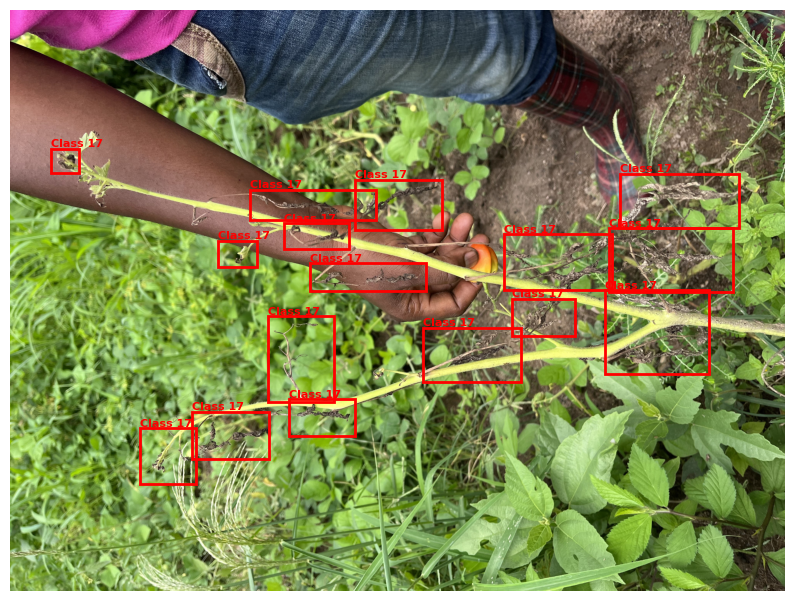

Plotting id_uzrdfu.jpg with 7 bounding boxes.


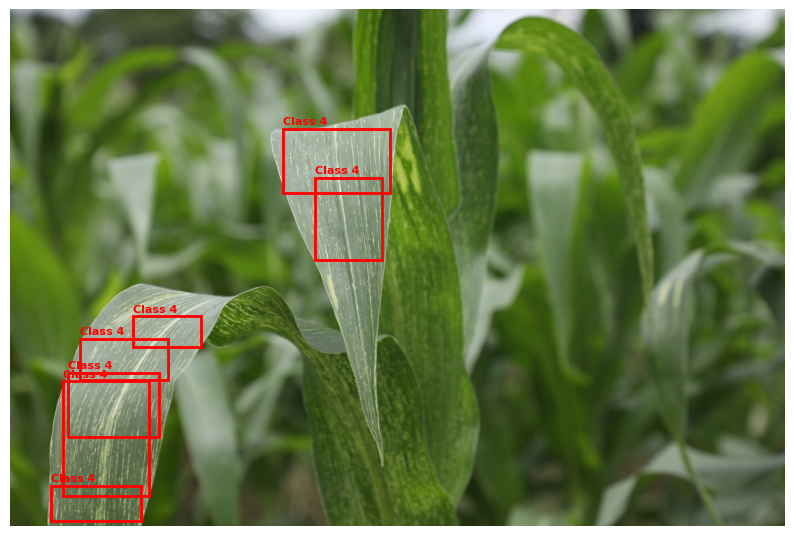

Plotting id_yeilzs.jpg with 11 bounding boxes.


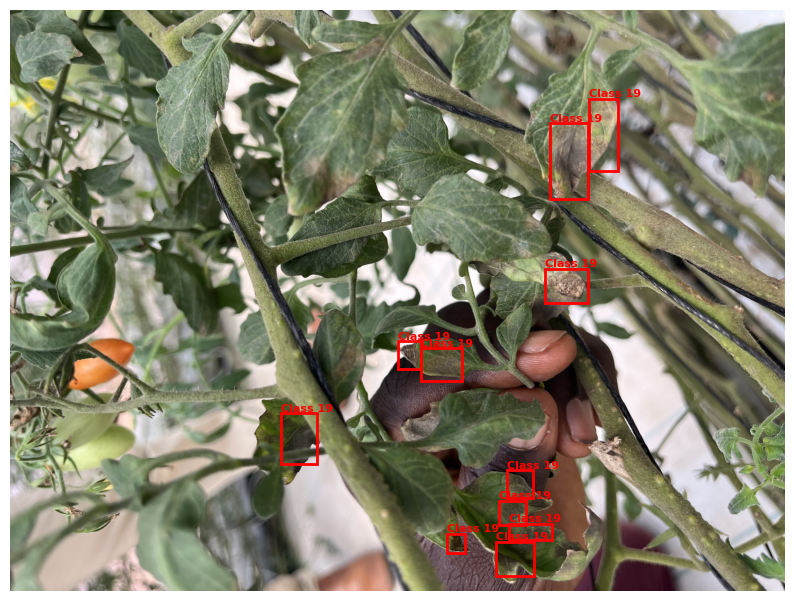

Plotting id_o1g2nf.jpg with 6 bounding boxes.


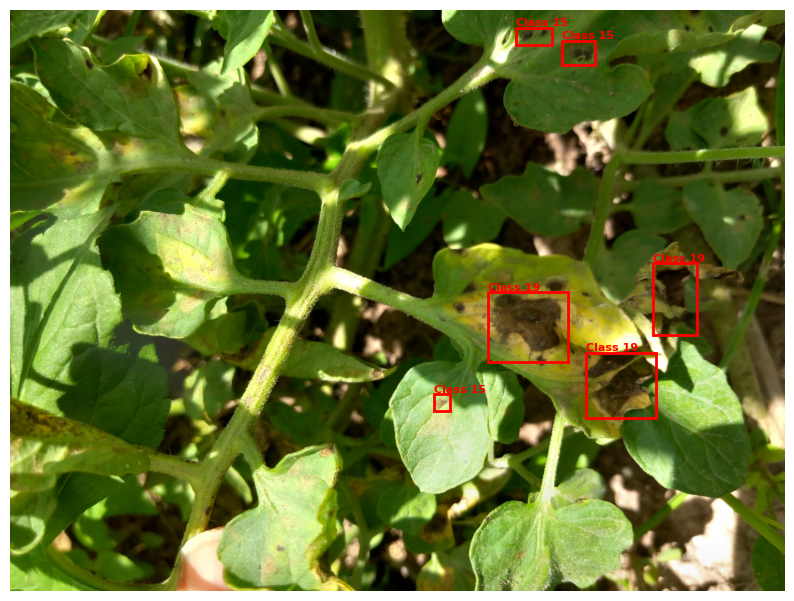

Plotting id_e9z1fo.jpg with 5 bounding boxes.


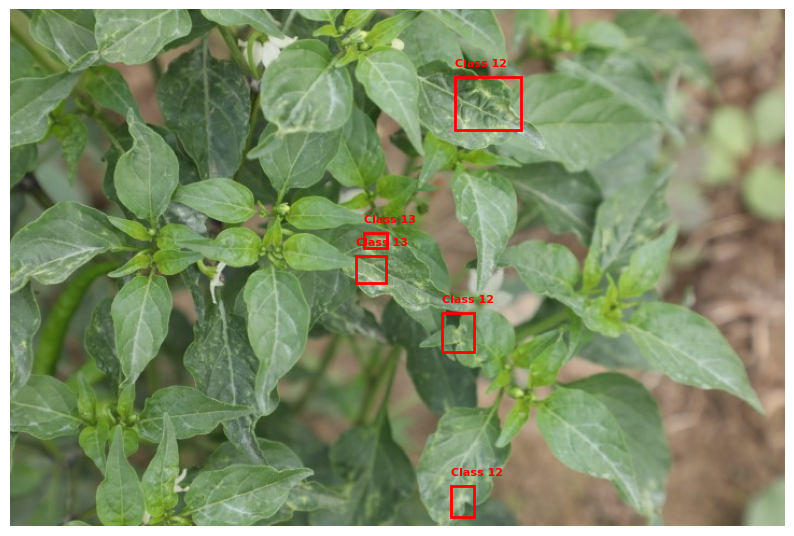

In [18]:
# Always run
# Plot some images and their bboxes to ensure the conversion was done correctly
def load_annotations(label_path):
    with open(label_path, 'r') as f:
        lines = f.readlines()
    boxes = []
    for line in lines:
        class_id, x_center, y_center, width, height = map(float, line.strip().split())
        boxes.append((class_id, x_center, y_center, width, height))
    return boxes

# Function to plot an image with its bounding boxes
def plot_image_with_boxes(image_path, boxes):
    # Load the image
    image = np.array(Image.open(str(image_path)))


    # Get image dimensions
    h, w, _ = image.shape

    # Plot the image
    plt.figure(figsize=(10, 10))
    plt.imshow(image)

    # Plot each bounding box
    for box in boxes:
        class_id, x_center, y_center, width, height = box
        # Convert YOLO format to corner coordinates
        xmin = int((x_center - width / 2) * w)
        ymin = int((y_center - height / 2) * h)
        xmax = int((x_center + width / 2) * w)
        ymax = int((y_center + height / 2) * h)

        # Draw the bounding box
        plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                          edgecolor='red', facecolor='none', linewidth=2))
        plt.text(xmin, ymin - 10, f'Class {int(class_id)}', color='red', fontsize=8, weight='bold')

    plt.axis('off')
    plt.show()

# Directories for images and labels
IMAGE_DIR = TRAIN_IMAGES_DIR
LABEL_DIR = TRAIN_LABELS_DIR

# Plot a few images with their annotations
for image_name in os.listdir(IMAGE_DIR)[:5]:
    image_path = IMAGE_DIR / image_name
    label_path = LABEL_DIR / (image_name.replace('.jpg', '.txt').replace('.png', '.txt'))

    if label_path.exists():
        boxes = load_annotations(label_path)
        print(f"Plotting {image_name} with {len(boxes)} bounding boxes.")
        plot_image_with_boxes(image_path, boxes)
    else:
        print(f"No annotations found for {image_name}.")


In [19]:
# Always run
# Install ultralytics
!pip -q install  ultralytics
!pip install aiofiles

In [20]:
# # Load a yolo pretrained model
# if cuda_available:
#   device_type = 0
# else:
#   device_type = 'cpu'

# model = YOLO('yolov8n.pt')
# # Ultra-fast testing setup
# model.train(
#     data='data.yaml',
#     epochs=2,                  # Just 1 epoch
#     imgsz=1024,                # Even smaller image size
#     batch=32,                 # Larger batch size
#     device=device_type,
#     patience=2,
#     workers=8,
#     cache=True,
#     pretrained=True,
#     optimizer='AdamW'
# )



# # Fine tune model to our data
# model.train(
#     data='data.yaml',          # Path to the dataset configuration
#     epochs=10,                 # Number of epochs
#     imgsz=1024,                # Image size (height, width)
#     batch=8,                   # Batch size
#     device=0,                  # Device to use (0 for the first GPU)
#     patience=5)


# # Load a yolo pretrained model
# model = YOLO('yolov8n.pt')  # Using the smallest YOLO model 'nano'

# # Fine tune model with faster settings for testing
# model.train(
#     data='data.yaml',
#     epochs=2,                  # Reduced from 10 to 2 epochs
#     imgsz=640,                # Reduced image size from 1024 to 640
#     batch=16,                 # Increased batch size from 8 to 16 (faster processing)
#     device=0,
#     patience=2,               # Reduced patience from 5 to 2
#     workers=8,                # Add worker threads for faster data loading
#     cache=True,               # Cache images in RAM for faster training
#     pretrained=True,          # Use pretrained weights
#     optimizer='AdamW'         # Faster optimizer
# )


# # Production-optimized training configuration
# model.train(
#     data='data.yaml',
#     epochs=100,                # Increased for better convergence
#     imgsz=640,                # Standard YOLO image size for optimal accuracy
#     batch=64,                 # Increased batch size for better GPU utilization
#     device=0,                 # Single GPU (use device=[0,1,2,3] for multi-GPU)
#     patience=20,              # Early stopping patience - prevents overfitting
#     workers=16,               # Increased workers for faster data loading
#     cache=True,              # Cache images in RAM for faster training
#     pretrained=True,         # Use pretrained weights
#     optimizer='AdamW',       # AdamW optimizer for better convergence
#     cos_lr=True,             # Cosine learning rate scheduler
#     label_smoothing=0.1,     # Reduces overfitting
#     warmup_epochs=3,         # Warm up learning rate
#     weight_decay=0.001,      # L2 regularization
#     overlap_mask=True,       # Better mask prediction
#     close_mosaic=10,         # Disable mosaic augmentation in final epochs
#     amp=True,                # Automatic mixed precision for faster training
#     multi_scale=True,        # Multi-scale training for better generalization
#     save_period=10,          # Save checkpoints every 10 epochs
#     nbs=64                   # Nominal batch size for gradient accumulation
# )












import torch
import os
from ultralytics import YOLO

# Basic setup
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
torch.backends.cudnn.benchmark = True

class SimpleYOLOTrainer:
    def __init__(self):
        # Initialize model - use small for edge deployment
        self.model = YOLO('yolov8s.pt')

    def train(self):
        # Key training settings focused on mAP@0.5
        training_args = {
            'data': 'data.yaml',
            'epochs': 10,            # More epochs for better convergence
            'imgsz': 1024,            # Standard size is enough
            'batch': 16,             # Good balance for T4 GPU
            'patience': 5,          # Avoid early stopping

            # Critical for disease detection
            'box': 0.25,            # Reduce box loss weight
            'cls': 2.0,             # Balance classification
            'dfl': 0.5,             # Reduce DFL loss

            # Optimization
            'optimizer': 'SGD',      # More stable than AdamW
            'lr0': 0.03,            # Standard learning rate
            'lrf': 0.0001,           # Final LR
            'momentum': 0.937,
            'weight_decay': 0.0005,
            'warmup_epochs': 5,

            # Essential augmentations only
            'mosaic': 1.0,          # Full mosaic aug
            'mixup': 0.5,           # Moderate mixup
            'scale': 0.5,           # Scale variation
            'fliplr': 0.5,          # Horizontal flip
            'flipud': 0.0,          # No vertical flip for plants

            # IoU specific
            'iou': 0.5,             # Match competition metric
            'conf': 0.25,           # Lower confidence threshold

            # Evaluation
            'val': True,
            'save': True,
            'save_period': -1,

            'plots': True,          # Generate plots for analysis
            'verbose': True,
            'seed': 42
        }

        # Train
        try:
            results = self.model.train(**training_args)
            return results
        except RuntimeError as e:
            print(f"Error during training: {e}")
            if "out of memory" in str(e):
                training_args.update({
                    'batch': 8,
                    'imgsz': 512
                })
                return self.model.train(**training_args)

# Train
trainer = SimpleYOLOTrainer()
results = trainer.train()

# Validate
if os.path.exists('/content/runs/detect/train/weights/best.pt'):
    model = YOLO('/content/runs/detect/train/weights/best.pt')
    results = model.val(
        data='data.yaml',
        conf=0.25,
        iou=0.5,          # Match competition metric
        augment=False,    # No TTA for edge deployment
        verbose=True
    )

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 21.5M/21.5M [00:00<00:00, 528MB/s]


Ultralytics 8.3.27 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=data.yaml, epochs=10, time=None, patience=5, batch=16, imgsz=1024, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=0.25, iou=0.5, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True

100%|██████████| 755k/755k [00:00<00:00, 112MB/s]


Overriding model.yaml nc=80 with nc=23

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytic

100%|██████████| 5.35M/5.35M [00:00<00:00, 315MB/s]


AMP: checks passed ✅


train: Scanning /content/datasets/dataset/labels/train... 4411 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4411/4411 [00:03<00:00, 1154.80it/s]


train: New cache created: /content/datasets/dataset/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/datasets/dataset/labels/val... 491 images, 0 backgrounds, 0 corrupt: 100%|██████████| 491/491 [00:00<00:00, 864.97it/s]

val: New cache created: /content/datasets/dataset/labels/val.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: SGD(lr=0.03, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      1.82G    0.08704      17.68     0.7146        131       1024: 100%|██████████| 276/276 [01:32<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:30<00:00,  1.91s/it]

                   all        491       4341      0.116    0.00711     0.0615     0.0246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      9.89G    0.07803      12.29     0.6166         86       1024: 100%|██████████| 276/276 [01:20<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.55it/s]

                   all        491       4341     0.0708    0.00922     0.0386     0.0146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      11.1G    0.07739      12.06     0.6042         67       1024: 100%|██████████| 276/276 [01:19<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.39it/s]

                   all        491       4341      0.153     0.0307     0.0871     0.0383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      11.5G    0.07811      11.87     0.6009         96       1024: 100%|██████████| 276/276 [01:19<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.89it/s]

                   all        491       4341     0.0676     0.0129     0.0367     0.0195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      10.3G    0.07872      11.76     0.6034         88       1024: 100%|██████████| 276/276 [01:18<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.06it/s]

                   all        491       4341      0.148     0.0321      0.083     0.0325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      9.95G    0.07852      11.47     0.6067         52       1024: 100%|██████████| 276/276 [01:18<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  4.00it/s]

                   all        491       4341      0.142     0.0228     0.0806     0.0293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      11.4G    0.07694      10.74     0.5909         45       1024: 100%|██████████| 276/276 [01:19<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.96it/s]

                   all        491       4341      0.161     0.0486     0.0988     0.0422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      10.4G    0.07541      10.17     0.5784         68       1024: 100%|██████████| 276/276 [01:18<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.79it/s]

                   all        491       4341      0.152     0.0526     0.0979     0.0457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      10.5G    0.07342       9.61     0.5647         75       1024: 100%|██████████| 276/276 [01:18<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.02it/s]

                   all        491       4341      0.352      0.063      0.202     0.0932



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      10.7G    0.07219      9.071     0.5544         94       1024: 100%|██████████| 276/276 [01:18<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.72it/s]

                   all        491       4341      0.289      0.114      0.192     0.0935



10 epochs completed in 0.246 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 22.6MB
Optimizer stripped from runs/detect/train/weights/best.pt, 22.6MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.27 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11,134,485 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.09it/s]


                   all        491       4341      0.352     0.0631      0.202     0.0936
Corn_Cercospora_Leaf_Spot         85        738      0.805      0.084      0.446      0.219
      Corn_Common_Rust         34        196      0.778     0.0357      0.409      0.218
          Corn_Healthy         26        173          0          0          0          0
Corn_Northern_Leaf_Blight          5          7          0          0          0          0
           Corn_Streak         37        345       0.64     0.0464      0.345      0.134
 Pepper_Bacterial_Spot         51        169          1    0.00592      0.503      0.101
     Pepper_Cercospora         16         35      0.333     0.0286      0.176      0.123
   Pepper_Early_Blight          1          9          0          0          0          0
       Pepper_Fusarium         22         47          0          0          0          0
        Pepper_Healthy         27         81      0.524      0.272      0.357      0.171
    Pepper_Late

val: Scanning /content/datasets/dataset/labels/val.cache... 491 images, 0 backgrounds, 0 corrupt: 100%|██████████| 491/491 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:30<00:00,  1.01it/s]


                   all        491       4341      0.351      0.063      0.202     0.0938
Corn_Cercospora_Leaf_Spot         85        738      0.803     0.0827      0.445      0.221
      Corn_Common_Rust         34        196      0.778     0.0357      0.409      0.211
          Corn_Healthy         26        173          0          0          0          0
Corn_Northern_Leaf_Blight          5          7          0          0          0          0
           Corn_Streak         37        345       0.64     0.0464      0.345      0.134
 Pepper_Bacterial_Spot         51        169          1    0.00592      0.503      0.101
     Pepper_Cercospora         16         35      0.333     0.0286      0.176       0.14
   Pepper_Early_Blight          1          9          0          0          0          0
       Pepper_Fusarium         22         47          0          0          0          0
        Pepper_Healthy         27         81      0.524      0.272      0.357      0.172
    Pepper_Late

In [31]:
def simple_predict(model_path, test_df, train_df):
    """Simplified prediction pipeline"""
    model = YOLO(model_path)
    predictions = []

    # Calculate default class from training data
    default_class = train_df['class'].value_counts().index[0]
    print(f"Using {default_class} as default class (most common in training)")

    # Process each image
    for image_id in tqdm(test_df['Image_ID'].unique()):
        img_path = f'/content/datasets/dataset/images/test/{image_id}'

        # Get predictions
        results = model.predict(
            source=img_path,
            conf=0.25,
            iou=0.5,
            augment=True
        )[0]

        # Handle all boxes for each image
        if len(results.boxes) > 0:
            boxes = results.boxes.xyxy.cpu().numpy()
            classes = results.boxes.cls.cpu().numpy()
            confs = results.boxes.conf.cpu().numpy()

            # Add all detections
            for box, cls, conf in zip(boxes, classes, confs):
                predictions.append({
                    'Image_ID': image_id,
                    'class': results.names[int(cls)],
                    'confidence': float(conf),
                    'ymin': float(box[1]),
                    'xmin': float(box[0]),
                    'ymax': float(box[3]),
                    'xmax': float(box[2])
                })
        else:
            # Add default prediction
            predictions.append({
                'Image_ID': image_id,
                'class': default_class,  # Most common healthy class
                'confidence': 0.25,
                'ymin': 0.1,
                'xmin': 0.1,
                'ymax': 0.9,
                'xmax': 0.9
            })

    predictions_df = pd.DataFrame(predictions)

    # Enhanced validation summary
    print("\nPrediction Analysis:")
    print("\nClass Distribution:")
    print(predictions_df['class'].value_counts(normalize=True) * 100)

    print("\nConfidence Statistics:")
    print(f"Mean confidence: {predictions_df['confidence'].mean():.3f}")
    print(f"Median confidence: {predictions_df['confidence'].median():.3f}")

    # Analyze bounding box sizes
    predictions_df['box_area'] = (
        (predictions_df['ymax'] - predictions_df['ymin']) *
        (predictions_df['xmax'] - predictions_df['xmin'])
    )

    print("\nBounding Box Statistics:")
    print(f"Mean box area: {predictions_df['box_area'].mean():.3f}")
    print(f"Median box area: {predictions_df['box_area'].median():.3f}")

    return pd.DataFrame(predictions)


# Use it
def create_submission():
    DATA_DIR = Path('/content/drive/MyDrive/Colab Notebooks/Zindi_Crop_Disease_Detection')

    # Load data
    test_df = pd.read_csv(DATA_DIR / 'Test.csv')
    train_df = pd.read_csv(DATA_DIR / 'Train.csv')
    sample_submission = pd.read_csv(DATA_DIR / 'SampleSubmission.csv')

    # Generate predictions
    predictions = simple_predict(
        model_path='/content/runs/detect/train/weights/best.pt',
        test_df=test_df,
        train_df=train_df
    )

    # Validate
    assert len(predictions) > len(test_df), "Not enough predictions"
    assert set(predictions.columns) == set(sample_submission.columns), "Column mismatch"

    # Show sample predictions
    print("\nSample Predictions:")
    print(predictions.head())

    # Save
    predictions.to_csv('submission_07.csv', index=False)
    print(f"Saved {len(predictions)} predictions")

# Run
create_submission()

Using Corn_Cercospora_Leaf_Spot as default class (most common in training)


  0%|          | 0/2101 [00:00<?, ?it/s]


image 1/1 /content/datasets/dataset/images/test/id_128pxx.jpg: 704x1024 4 Tomato_Septorias, 3965.6ms
Speed: 5.5ms preprocess, 3965.6ms inference, 2.5ms postprocess per image at shape (1, 3, 704, 1024)


  0%|          | 1/2101 [00:04<2:27:20,  4.21s/it]


image 1/1 /content/datasets/dataset/images/test/id_12jbci.jpg: 704x1024 (no detections), 44.7ms
Speed: 4.7ms preprocess, 44.7ms inference, 0.7ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_143s4o.jpg: 480x1024 10 Corn_Cercospora_Leaf_Spots, 4196.5ms
Speed: 4.6ms preprocess, 4196.5ms inference, 6.4ms postprocess per image at shape (1, 3, 480, 1024)


  0%|          | 3/2101 [00:08<1:34:25,  2.70s/it]


image 1/1 /content/datasets/dataset/images/test/id_14tfmb.jpg: 768x1024 (no detections), 4109.4ms
Speed: 12.2ms preprocess, 4109.4ms inference, 3.4ms postprocess per image at shape (1, 3, 768, 1024)


  0%|          | 4/2101 [00:12<1:54:06,  3.26s/it]


image 1/1 /content/datasets/dataset/images/test/id_14tw4o.jpg: 768x1024 7 Tomato_Early_Blights, 121.1ms
Speed: 12.2ms preprocess, 121.1ms inference, 5.7ms postprocess per image at shape (1, 3, 768, 1024)


  0%|          | 5/2101 [00:13<1:20:24,  2.30s/it]


image 1/1 /content/datasets/dataset/images/test/id_15ozvw.jpg: 768x1024 1 Pepper_Bacterial_Spot, 139.7ms
Speed: 12.4ms preprocess, 139.7ms inference, 8.2ms postprocess per image at shape (1, 3, 768, 1024)


  0%|          | 6/2101 [00:13<58:20,  1.67s/it]  


image 1/1 /content/datasets/dataset/images/test/id_163zns.jpg: 704x1024 3 Tomato_Early_Blights, 1 Tomato_Late_Blight, 146.4ms
Speed: 16.8ms preprocess, 146.4ms inference, 6.4ms postprocess per image at shape (1, 3, 704, 1024)


  0%|          | 7/2101 [00:13<42:39,  1.22s/it]


image 1/1 /content/datasets/dataset/images/test/id_1645r4.jpg: 480x1024 9 Corn_Cercospora_Leaf_Spots, 132.7ms
Speed: 8.2ms preprocess, 132.7ms inference, 6.0ms postprocess per image at shape (1, 3, 480, 1024)


  0%|          | 8/2101 [00:14<32:21,  1.08it/s]


image 1/1 /content/datasets/dataset/images/test/id_167cbn.jpg: 704x1024 14 Tomato_Healthys, 123.2ms
Speed: 10.3ms preprocess, 123.2ms inference, 5.9ms postprocess per image at shape (1, 3, 704, 1024)


  0%|          | 9/2101 [00:14<24:28,  1.42it/s]


image 1/1 /content/datasets/dataset/images/test/id_176skz.jpg: 768x1024 (no detections), 122.8ms
Speed: 11.6ms preprocess, 122.8ms inference, 2.6ms postprocess per image at shape (1, 3, 768, 1024)


  0%|          | 10/2101 [00:14<19:25,  1.79it/s]


image 1/1 /content/datasets/dataset/images/test/id_17bwk9.jpg: 1024x768 (no detections), 4196.6ms
Speed: 13.0ms preprocess, 4196.6ms inference, 5.4ms postprocess per image at shape (1, 3, 1024, 768)


  1%|          | 11/2101 [00:18<58:59,  1.69s/it]


image 1/1 /content/datasets/dataset/images/test/id_17u3md.jpg: 768x1024 13 Tomato_Healthys, 2 Tomato_Septorias, 132.9ms
Speed: 12.2ms preprocess, 132.9ms inference, 6.4ms postprocess per image at shape (1, 3, 768, 1024)


  1%|          | 12/2101 [00:19<44:48,  1.29s/it]


image 1/1 /content/datasets/dataset/images/test/id_18r32q.jpg: 768x1024 6 Tomato_Late_Blights, 7 Tomato_Septorias, 134.1ms
Speed: 12.8ms preprocess, 134.1ms inference, 6.3ms postprocess per image at shape (1, 3, 768, 1024)


  1%|          | 13/2101 [00:19<34:50,  1.00s/it]


image 1/1 /content/datasets/dataset/images/test/id_18wf25.jpg: 768x1024 2 Corn_Streaks, 138.8ms
Speed: 12.3ms preprocess, 138.8ms inference, 6.7ms postprocess per image at shape (1, 3, 768, 1024)


  1%|          | 14/2101 [00:19<28:07,  1.24it/s]


image 1/1 /content/datasets/dataset/images/test/id_1ag8gc.jpg: 768x1024 7 Pepper_Healthys, 142.1ms
Speed: 12.8ms preprocess, 142.1ms inference, 6.1ms postprocess per image at shape (1, 3, 768, 1024)


  1%|          | 15/2101 [00:20<23:11,  1.50it/s]


image 1/1 /content/datasets/dataset/images/test/id_1awm9t.jpg: 768x1024 (no detections), 149.4ms
Speed: 13.0ms preprocess, 149.4ms inference, 4.0ms postprocess per image at shape (1, 3, 768, 1024)


  1%|          | 16/2101 [00:20<19:41,  1.76it/s]


image 1/1 /content/datasets/dataset/images/test/id_1b3zwu.jpg: 768x1024 1 Pepper_Bacterial_Spot, 149.5ms
Speed: 12.6ms preprocess, 149.5ms inference, 6.3ms postprocess per image at shape (1, 3, 768, 1024)


  1%|          | 17/2101 [00:20<17:12,  2.02it/s]


image 1/1 /content/datasets/dataset/images/test/id_1ba1dt.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 136.2ms
Speed: 7.8ms preprocess, 136.2ms inference, 6.4ms postprocess per image at shape (1, 3, 480, 1024)


  1%|          | 18/2101 [00:21<14:41,  2.36it/s]


image 1/1 /content/datasets/dataset/images/test/id_1bkn2l.jpg: 768x1024 6 Tomato_Healthys, 135.0ms
Speed: 12.7ms preprocess, 135.0ms inference, 6.2ms postprocess per image at shape (1, 3, 768, 1024)


  1%|          | 19/2101 [00:21<14:22,  2.41it/s]


image 1/1 /content/datasets/dataset/images/test/id_1cl2pj.jpg: 704x1024 1 Pepper_Bacterial_Spot, 149.7ms
Speed: 10.5ms preprocess, 149.7ms inference, 6.2ms postprocess per image at shape (1, 3, 704, 1024)


  1%|          | 20/2101 [00:21<12:17,  2.82it/s]


image 1/1 /content/datasets/dataset/images/test/id_1do3cp.jpg: 768x1024 1 Pepper_Healthy, 132.8ms
Speed: 12.3ms preprocess, 132.8ms inference, 6.0ms postprocess per image at shape (1, 3, 768, 1024)


  1%|          | 21/2101 [00:22<12:05,  2.87it/s]


image 1/1 /content/datasets/dataset/images/test/id_1duv4p.jpg: 704x1024 1 Corn_Northern_Leaf_Blight, 138.7ms
Speed: 10.9ms preprocess, 138.7ms inference, 6.1ms postprocess per image at shape (1, 3, 704, 1024)


  1%|          | 22/2101 [00:22<10:33,  3.28it/s]


image 1/1 /content/datasets/dataset/images/test/id_1ecbrb.jpg: 480x1024 16 Corn_Cercospora_Leaf_Spots, 133.4ms
Speed: 8.0ms preprocess, 133.4ms inference, 6.6ms postprocess per image at shape (1, 3, 480, 1024)


  1%|          | 23/2101 [00:22<09:57,  3.48it/s]


image 1/1 /content/datasets/dataset/images/test/id_1ei3l5.jpg: 768x1024 1 Pepper_Leaf_Curl, 136.3ms
Speed: 13.0ms preprocess, 136.3ms inference, 6.3ms postprocess per image at shape (1, 3, 768, 1024)


  1%|          | 24/2101 [00:22<10:44,  3.22it/s]


image 1/1 /content/datasets/dataset/images/test/id_1f4a7k.jpg: 768x1024 (no detections), 136.4ms
Speed: 12.9ms preprocess, 136.4ms inference, 2.7ms postprocess per image at shape (1, 3, 768, 1024)


  1%|          | 25/2101 [00:23<10:53,  3.17it/s]


image 1/1 /content/datasets/dataset/images/test/id_1fjr8m.jpg: 768x1024 2 Tomato_Early_Blights, 1 Tomato_Fusarium, 1 Tomato_Late_Blight, 130.4ms
Speed: 15.0ms preprocess, 130.4ms inference, 6.4ms postprocess per image at shape (1, 3, 768, 1024)


  1%|          | 26/2101 [00:23<12:07,  2.85it/s]


image 1/1 /content/datasets/dataset/images/test/id_1flm7s.jpg: 768x1024 3 Pepper_Healthys, 134.1ms
Speed: 17.7ms preprocess, 134.1ms inference, 7.4ms postprocess per image at shape (1, 3, 768, 1024)


  1%|▏         | 27/2101 [00:24<12:42,  2.72it/s]


image 1/1 /content/datasets/dataset/images/test/id_1gj2dl.jpg: 704x1024 1 Pepper_Leaf_Blight, 131.7ms
Speed: 10.9ms preprocess, 131.7ms inference, 6.5ms postprocess per image at shape (1, 3, 704, 1024)


  1%|▏         | 28/2101 [00:24<10:56,  3.16it/s]


image 1/1 /content/datasets/dataset/images/test/id_1h4quq.jpg: 704x1024 (no detections), 131.4ms
Speed: 11.5ms preprocess, 131.4ms inference, 2.8ms postprocess per image at shape (1, 3, 704, 1024)


  1%|▏         | 29/2101 [00:24<09:35,  3.60it/s]


image 1/1 /content/datasets/dataset/images/test/id_1i7ofl.jpg: 704x1024 1 Pepper_Healthy, 139.6ms
Speed: 10.9ms preprocess, 139.6ms inference, 7.0ms postprocess per image at shape (1, 3, 704, 1024)


  1%|▏         | 30/2101 [00:24<08:53,  3.88it/s]


image 1/1 /content/datasets/dataset/images/test/id_1iazt1.jpg: 768x1024 1 Tomato_Early_Blight, 158.9ms
Speed: 12.4ms preprocess, 158.9ms inference, 6.1ms postprocess per image at shape (1, 3, 768, 1024)


  1%|▏         | 31/2101 [00:24<09:41,  3.56it/s]


image 1/1 /content/datasets/dataset/images/test/id_1ic5o7.jpg: 768x1024 1 Pepper_Cercospora, 1 Pepper_Leaf_Blight, 131.8ms
Speed: 12.2ms preprocess, 131.8ms inference, 6.4ms postprocess per image at shape (1, 3, 768, 1024)


  2%|▏         | 32/2101 [00:25<09:20,  3.69it/s]


image 1/1 /content/datasets/dataset/images/test/id_1ilfn6.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 128.7ms
Speed: 8.1ms preprocess, 128.7ms inference, 6.0ms postprocess per image at shape (1, 3, 480, 1024)


  2%|▏         | 33/2101 [00:25<09:06,  3.78it/s]


image 1/1 /content/datasets/dataset/images/test/id_1ipxx9.jpg: 768x1024 2 Pepper_Healthys, 155.3ms
Speed: 12.7ms preprocess, 155.3ms inference, 6.6ms postprocess per image at shape (1, 3, 768, 1024)


  2%|▏         | 34/2101 [00:25<09:51,  3.50it/s]


image 1/1 /content/datasets/dataset/images/test/id_1j317w.jpg: 768x1024 8 Pepper_Healthys, 136.5ms
Speed: 18.4ms preprocess, 136.5ms inference, 6.5ms postprocess per image at shape (1, 3, 768, 1024)


  2%|▏         | 35/2101 [00:26<10:57,  3.14it/s]


image 1/1 /content/datasets/dataset/images/test/id_1jc2nw.jpg: 768x1024 2 Corn_Streaks, 138.2ms
Speed: 13.0ms preprocess, 138.2ms inference, 6.4ms postprocess per image at shape (1, 3, 768, 1024)


  2%|▏         | 36/2101 [00:26<11:45,  2.93it/s]


image 1/1 /content/datasets/dataset/images/test/id_1jqp7v.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 192.0ms
Speed: 9.7ms preprocess, 192.0ms inference, 10.4ms postprocess per image at shape (1, 3, 480, 1024)


  2%|▏         | 37/2101 [00:26<12:04,  2.85it/s]


image 1/1 /content/datasets/dataset/images/test/id_1kuwad.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 132.6ms
Speed: 8.8ms preprocess, 132.6ms inference, 6.2ms postprocess per image at shape (1, 3, 480, 1024)


  2%|▏         | 38/2101 [00:27<11:13,  3.06it/s]


image 1/1 /content/datasets/dataset/images/test/id_1lgvqd.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 133.2ms
Speed: 9.2ms preprocess, 133.2ms inference, 6.3ms postprocess per image at shape (1, 3, 480, 1024)


  2%|▏         | 39/2101 [00:27<10:27,  3.29it/s]


image 1/1 /content/datasets/dataset/images/test/id_1muuin.jpg: 768x1024 (no detections), 131.4ms
Speed: 13.4ms preprocess, 131.4ms inference, 2.5ms postprocess per image at shape (1, 3, 768, 1024)


  2%|▏         | 40/2101 [00:27<10:59,  3.12it/s]


image 1/1 /content/datasets/dataset/images/test/id_1n8epx.jpg: 768x1024 1 Tomato_Septoria, 134.5ms
Speed: 13.4ms preprocess, 134.5ms inference, 6.5ms postprocess per image at shape (1, 3, 768, 1024)


  2%|▏         | 41/2101 [00:28<11:32,  2.98it/s]


image 1/1 /content/datasets/dataset/images/test/id_1p2rir.jpg: 768x1024 6 Pepper_Healthys, 141.1ms
Speed: 12.5ms preprocess, 141.1ms inference, 6.5ms postprocess per image at shape (1, 3, 768, 1024)


  2%|▏         | 42/2101 [00:28<11:55,  2.88it/s]


image 1/1 /content/datasets/dataset/images/test/id_1pfyy3.jpg: 768x1024 1 Pepper_Bacterial_Spot, 140.2ms
Speed: 12.6ms preprocess, 140.2ms inference, 6.3ms postprocess per image at shape (1, 3, 768, 1024)


  2%|▏         | 43/2101 [00:28<12:05,  2.84it/s]


image 1/1 /content/datasets/dataset/images/test/id_1qbqle.jpg: 768x1024 1 Pepper_Bacterial_Spot, 46.9ms
Speed: 6.2ms preprocess, 46.9ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


  2%|▏         | 44/2101 [00:29<10:44,  3.19it/s]


image 1/1 /content/datasets/dataset/images/test/id_1r1ydr.jpg: 704x1024 2 Pepper_Leaf_Curls, 45.1ms
Speed: 4.1ms preprocess, 45.1ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_1rr1gd.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 43.3ms
Speed: 4.0ms preprocess, 43.3ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 1024)


  2%|▏         | 46/2101 [00:29<07:06,  4.81it/s]


image 1/1 /content/datasets/dataset/images/test/id_1sgtif.jpg: 768x1024 3 Corn_Northern_Leaf_Blights, 1 Corn_Streak, 46.3ms
Speed: 6.2ms preprocess, 46.3ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


  2%|▏         | 47/2101 [00:29<06:46,  5.06it/s]


image 1/1 /content/datasets/dataset/images/test/id_1t6gmo.jpg: 704x1024 (no detections), 47.3ms
Speed: 5.4ms preprocess, 47.3ms inference, 0.7ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_1u3kxg.jpg: 480x1024 2 Corn_Healthys, 43.4ms
Speed: 4.0ms preprocess, 43.4ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)


  2%|▏         | 49/2101 [00:29<05:08,  6.66it/s]


image 1/1 /content/datasets/dataset/images/test/id_1ujan6.jpg: 704x1024 3 Pepper_Bacterial_Spots, 45.4ms
Speed: 5.4ms preprocess, 45.4ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_1ur7gy.jpg: 480x1024 2 Corn_Common_Rusts, 43.2ms
Speed: 4.0ms preprocess, 43.2ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)


  2%|▏         | 51/2101 [00:29<04:17,  7.98it/s]


image 1/1 /content/datasets/dataset/images/test/id_1v2dkb.jpg: 768x1024 1 Pepper_Bacterial_Spot, 46.1ms
Speed: 6.2ms preprocess, 46.1ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


  2%|▏         | 52/2101 [00:29<04:25,  7.72it/s]


image 1/1 /content/datasets/dataset/images/test/id_1w1k4c.jpg: 768x1024 (no detections), 48.1ms
Speed: 6.2ms preprocess, 48.1ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


  3%|▎         | 53/2101 [00:30<04:27,  7.65it/s]


image 1/1 /content/datasets/dataset/images/test/id_1wni6m.jpg: 768x1024 (no detections), 46.8ms
Speed: 6.1ms preprocess, 46.8ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


  3%|▎         | 54/2101 [00:30<04:29,  7.58it/s]


image 1/1 /content/datasets/dataset/images/test/id_1x2zqp.jpg: 704x1024 1 Pepper_Late_Blight, 1 Tomato_Late_Blight, 1 Tomato_Septoria, 45.9ms
Speed: 5.5ms preprocess, 45.9ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_1x9sri.jpg: 768x1024 3 Pepper_Healthys, 46.1ms
Speed: 6.1ms preprocess, 46.1ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


  3%|▎         | 56/2101 [00:30<04:03,  8.40it/s]


image 1/1 /content/datasets/dataset/images/test/id_1yplsq.jpg: 768x1024 4 Pepper_Healthys, 45.6ms
Speed: 6.1ms preprocess, 45.6ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


  3%|▎         | 57/2101 [00:30<04:08,  8.21it/s]


image 1/1 /content/datasets/dataset/images/test/id_1zr69f.jpg: 704x1024 6 Tomato_Healthys, 45.0ms
Speed: 5.3ms preprocess, 45.0ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_21hqo6.jpg: 480x1024 1 Corn_Common_Rust, 45.6ms
Speed: 4.1ms preprocess, 45.6ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 1024)


  3%|▎         | 59/2101 [00:30<03:35,  9.46it/s]


image 1/1 /content/datasets/dataset/images/test/id_23mmij.jpg: 480x1024 2 Corn_Healthys, 47.2ms
Speed: 4.2ms preprocess, 47.2ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 1024)


  3%|▎         | 60/2101 [00:30<03:33,  9.57it/s]


image 1/1 /content/datasets/dataset/images/test/id_249ds8.jpg: 768x1024 1 Pepper_Leaf_Curl, 48.7ms
Speed: 6.4ms preprocess, 48.7ms inference, 2.1ms postprocess per image at shape (1, 3, 768, 1024)


  3%|▎         | 61/2101 [00:31<03:52,  8.79it/s]


image 1/1 /content/datasets/dataset/images/test/id_24jt81.jpg: 768x1024 (no detections), 47.0ms
Speed: 6.3ms preprocess, 47.0ms inference, 0.8ms postprocess per image at shape (1, 3, 768, 1024)


  3%|▎         | 62/2101 [00:31<04:09,  8.18it/s]


image 1/1 /content/datasets/dataset/images/test/id_25gjbm.jpg: 768x1024 (no detections), 47.7ms
Speed: 6.1ms preprocess, 47.7ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


  3%|▎         | 63/2101 [00:31<04:21,  7.79it/s]


image 1/1 /content/datasets/dataset/images/test/id_27yxhg.jpg: 768x1024 16 Tomato_Healthys, 51.0ms
Speed: 6.4ms preprocess, 51.0ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)


  3%|▎         | 64/2101 [00:31<04:45,  7.13it/s]


image 1/1 /content/datasets/dataset/images/test/id_28jitl.jpg: 704x1024 3 Tomato_Septorias, 50.2ms
Speed: 6.0ms preprocess, 50.2ms inference, 1.9ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_29dnro.jpg: 768x1024 (no detections), 51.4ms
Speed: 6.6ms preprocess, 51.4ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


  3%|▎         | 66/2101 [00:31<04:25,  7.66it/s]


image 1/1 /content/datasets/dataset/images/test/id_29h9oe.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 4 Corn_Healthys, 46.1ms
Speed: 4.2ms preprocess, 46.1ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)


  3%|▎         | 67/2101 [00:31<04:15,  7.95it/s]


image 1/1 /content/datasets/dataset/images/test/id_29vdgx.jpg: 768x1024 1 Pepper_Leaf_Curl, 46.5ms
Speed: 6.2ms preprocess, 46.5ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


  3%|▎         | 68/2101 [00:31<04:29,  7.53it/s]


image 1/1 /content/datasets/dataset/images/test/id_2a6san.jpg: 768x1024 2 Tomato_Early_Blights, 4 Tomato_Late_Blights, 46.8ms
Speed: 6.7ms preprocess, 46.8ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


  3%|▎         | 69/2101 [00:32<04:36,  7.34it/s]


image 1/1 /content/datasets/dataset/images/test/id_2b3fgf.jpg: 704x1024 3 Pepper_Bacterial_Spots, 48.4ms
Speed: 5.8ms preprocess, 48.4ms inference, 1.9ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_2bbwro.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 43.7ms
Speed: 3.9ms preprocess, 43.7ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 1024)


  3%|▎         | 71/2101 [00:32<03:51,  8.75it/s]


image 1/1 /content/datasets/dataset/images/test/id_2bqycr.jpg: 768x1024 8 Tomato_Fusariums, 3 Tomato_Late_Blights, 45.9ms
Speed: 6.2ms preprocess, 45.9ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


  3%|▎         | 72/2101 [00:32<04:19,  7.83it/s]


image 1/1 /content/datasets/dataset/images/test/id_2bssym.jpg: 704x1024 1 Pepper_Leaf_Blight, 44.7ms
Speed: 4.2ms preprocess, 44.7ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_2c8vd5.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 44.2ms
Speed: 3.8ms preprocess, 44.2ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)


  4%|▎         | 74/2101 [00:32<03:38,  9.28it/s]


image 1/1 /content/datasets/dataset/images/test/id_2e9mkl.jpg: 704x1024 4 Pepper_Leaf_Curls, 46.3ms
Speed: 4.0ms preprocess, 46.3ms inference, 2.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_2fic1h.jpg: 768x1024 4 Pepper_Healthys, 46.9ms
Speed: 6.2ms preprocess, 46.9ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


  4%|▎         | 76/2101 [00:32<03:30,  9.63it/s]


image 1/1 /content/datasets/dataset/images/test/id_2fudj5.jpg: 768x1024 1 Tomato_Early_Blight, 46.2ms
Speed: 6.4ms preprocess, 46.2ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)


  4%|▎         | 77/2101 [00:32<03:45,  8.98it/s]


image 1/1 /content/datasets/dataset/images/test/id_2g429q.jpg: 768x1024 3 Pepper_Cercosporas, 48.5ms
Speed: 8.9ms preprocess, 48.5ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


  4%|▎         | 78/2101 [00:33<03:57,  8.54it/s]


image 1/1 /content/datasets/dataset/images/test/id_2gbmnw.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 43.5ms
Speed: 4.0ms preprocess, 43.5ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_2h8kwk.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 2 Corn_Healthys, 44.1ms
Speed: 3.9ms preprocess, 44.1ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)


  4%|▍         | 80/2101 [00:33<03:40,  9.17it/s]


image 1/1 /content/datasets/dataset/images/test/id_2hejli.jpg: 704x1024 3 Tomato_Septorias, 52.3ms
Speed: 5.6ms preprocess, 52.3ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_2hg8h5.jpg: 704x1024 1 Corn_Streak, 49.4ms
Speed: 5.3ms preprocess, 49.4ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


  4%|▍         | 82/2101 [00:33<03:17, 10.23it/s]


image 1/1 /content/datasets/dataset/images/test/id_2hi12d.jpg: 1024x768 7 Pepper_Leaf_Curls, 52.7ms
Speed: 6.2ms preprocess, 52.7ms inference, 2.1ms postprocess per image at shape (1, 3, 1024, 768)

image 1/1 /content/datasets/dataset/images/test/id_2hm6i2.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 49.7ms
Speed: 3.8ms preprocess, 49.7ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 1024)


  4%|▍         | 84/2101 [00:33<03:16, 10.24it/s]


image 1/1 /content/datasets/dataset/images/test/id_2j3vuq.jpg: 704x1024 14 Tomato_Healthys, 43.5ms
Speed: 5.2ms preprocess, 43.5ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_2j8ruh.jpg: 480x1024 (no detections), 46.7ms
Speed: 3.8ms preprocess, 46.7ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 1024)


  4%|▍         | 86/2101 [00:33<03:04, 10.90it/s]


image 1/1 /content/datasets/dataset/images/test/id_2jjwoe.jpg: 768x1024 (no detections), 46.5ms
Speed: 8.7ms preprocess, 46.5ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /content/datasets/dataset/images/test/id_2k475s.jpg: 768x1024 8 Tomato_Early_Blights, 44.9ms
Speed: 6.1ms preprocess, 44.9ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


  4%|▍         | 88/2101 [00:34<03:46,  8.89it/s]


image 1/1 /content/datasets/dataset/images/test/id_2kgi6f.jpg: 768x1024 1 Pepper_Leaf_Blight, 1 Pepper_Leaf_Curl, 45.3ms
Speed: 6.1ms preprocess, 45.3ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


  4%|▍         | 89/2101 [00:34<04:01,  8.35it/s]


image 1/1 /content/datasets/dataset/images/test/id_2l3s11.jpg: 704x1024 6 Tomato_Septorias, 45.4ms
Speed: 5.2ms preprocess, 45.4ms inference, 1.7ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_2lr93j.jpg: 768x1024 (no detections), 46.7ms
Speed: 6.2ms preprocess, 46.7ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


  4%|▍         | 91/2101 [00:34<03:54,  8.58it/s]


image 1/1 /content/datasets/dataset/images/test/id_2lxhbi.jpg: 768x1024 2 Pepper_Fusariums, 4 Pepper_Healthys, 46.8ms
Speed: 6.3ms preprocess, 46.8ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)


  4%|▍         | 92/2101 [00:34<04:14,  7.89it/s]


image 1/1 /content/datasets/dataset/images/test/id_2mdbse.jpg: 768x1024 1 Tomato_Healthy, 3 Tomato_Septorias, 45.1ms
Speed: 6.1ms preprocess, 45.1ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


  4%|▍         | 93/2101 [00:34<04:26,  7.53it/s]


image 1/1 /content/datasets/dataset/images/test/id_2mi3wt.jpg: 768x1024 2 Pepper_Leaf_Curls, 46.7ms
Speed: 6.4ms preprocess, 46.7ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)


  4%|▍         | 94/2101 [00:34<04:37,  7.22it/s]


image 1/1 /content/datasets/dataset/images/test/id_2oc7n8.jpg: 768x1024 (no detections), 46.5ms
Speed: 6.1ms preprocess, 46.5ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


  5%|▍         | 95/2101 [00:35<04:44,  7.06it/s]


image 1/1 /content/datasets/dataset/images/test/id_2oos4m.jpg: 768x1024 9 Tomato_Late_Blights, 45.6ms
Speed: 6.2ms preprocess, 45.6ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


  5%|▍         | 96/2101 [00:35<04:51,  6.89it/s]


image 1/1 /content/datasets/dataset/images/test/id_2pqh9a.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 42.8ms
Speed: 3.8ms preprocess, 42.8ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 1024)


  5%|▍         | 97/2101 [00:35<04:31,  7.38it/s]


image 1/1 /content/datasets/dataset/images/test/id_2q7lnt.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 2 Corn_Common_Rusts, 42.9ms
Speed: 3.8ms preprocess, 42.9ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_2rl9gr.jpg: 768x1024 16 Corn_Northern_Leaf_Blights, 46.4ms
Speed: 6.0ms preprocess, 46.4ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


  5%|▍         | 99/2101 [00:35<04:17,  7.78it/s]


image 1/1 /content/datasets/dataset/images/test/id_2rstzs.jpg: 768x1024 (no detections), 45.3ms
Speed: 6.1ms preprocess, 45.3ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


  5%|▍         | 100/2101 [00:35<04:25,  7.53it/s]


image 1/1 /content/datasets/dataset/images/test/id_2sg62b.jpg: 480x1024 (no detections), 44.5ms
Speed: 4.1ms preprocess, 44.5ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 1024)


  5%|▍         | 101/2101 [00:35<04:12,  7.91it/s]


image 1/1 /content/datasets/dataset/images/test/id_2tyvws.jpg: 704x1024 (no detections), 45.2ms
Speed: 5.3ms preprocess, 45.2ms inference, 0.7ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_2ugj8h.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 42.5ms
Speed: 3.8ms preprocess, 42.5ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)


  5%|▍         | 103/2101 [00:36<03:33,  9.34it/s]


image 1/1 /content/datasets/dataset/images/test/id_2uz6sz.jpg: 704x1024 7 Corn_Streaks, 47.5ms
Speed: 5.3ms preprocess, 47.5ms inference, 1.7ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_2vh4ug.jpg: 768x1024 2 Pepper_Cercosporas, 45.5ms
Speed: 6.0ms preprocess, 45.5ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


  5%|▍         | 105/2101 [00:36<03:31,  9.46it/s]


image 1/1 /content/datasets/dataset/images/test/id_2wgano.jpg: 704x1024 7 Corn_Streaks, 44.9ms
Speed: 4.1ms preprocess, 44.9ms inference, 1.7ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_2x9ksf.jpg: 704x1024 1 Corn_Streak, 44.3ms
Speed: 5.2ms preprocess, 44.3ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)


  5%|▌         | 107/2101 [00:36<03:02, 10.95it/s]


image 1/1 /content/datasets/dataset/images/test/id_2xucw1.jpg: 704x1024 6 Pepper_Leaf_Blights, 51.9ms
Speed: 5.9ms preprocess, 51.9ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_31ll76.jpg: 480x1024 3 Corn_Healthys, 46.7ms
Speed: 3.9ms preprocess, 46.7ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 1024)


  5%|▌         | 109/2101 [00:36<03:00, 11.05it/s]


image 1/1 /content/datasets/dataset/images/test/id_31ll7c.jpg: 768x1024 1 Pepper_Leaf_Curl, 46.6ms
Speed: 6.4ms preprocess, 46.6ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /content/datasets/dataset/images/test/id_31ox6x.jpg: 768x1024 2 Pepper_Leaf_Curls, 45.1ms
Speed: 9.2ms preprocess, 45.1ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


  5%|▌         | 111/2101 [00:36<03:36,  9.18it/s]


image 1/1 /content/datasets/dataset/images/test/id_31qjz4.jpg: 768x1024 8 Tomato_Late_Blights, 1 Tomato_Septoria, 47.7ms
Speed: 6.0ms preprocess, 47.7ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


  5%|▌         | 112/2101 [00:36<03:51,  8.58it/s]


image 1/1 /content/datasets/dataset/images/test/id_31rg58.jpg: 1024x768 8 Pepper_Cercosporas, 59.6ms
Speed: 9.5ms preprocess, 59.6ms inference, 2.3ms postprocess per image at shape (1, 3, 1024, 768)


  5%|▌         | 113/2101 [00:37<03:55,  8.45it/s]


image 1/1 /content/datasets/dataset/images/test/id_31vsit.jpg: 480x1024 (no detections), 46.1ms
Speed: 4.1ms preprocess, 46.1ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 1024)


  5%|▌         | 114/2101 [00:37<03:47,  8.73it/s]


image 1/1 /content/datasets/dataset/images/test/id_321ino.jpg: 704x1024 15 Tomato_Fusariums, 47.2ms
Speed: 5.4ms preprocess, 47.2ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_3242wv.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 42.8ms
Speed: 4.0ms preprocess, 42.8ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)


  6%|▌         | 116/2101 [00:37<03:30,  9.44it/s]


image 1/1 /content/datasets/dataset/images/test/id_32zk99.jpg: 704x1024 2 Tomato_Septorias, 43.6ms
Speed: 5.2ms preprocess, 43.6ms inference, 1.7ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_33ptzo.jpg: 768x1024 2 Tomato_Late_Blights, 45.7ms
Speed: 6.1ms preprocess, 45.7ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


  6%|▌         | 118/2101 [00:37<03:22,  9.77it/s]


image 1/1 /content/datasets/dataset/images/test/id_344lib.jpg: 768x1024 (no detections), 46.3ms
Speed: 6.2ms preprocess, 46.3ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


  6%|▌         | 119/2101 [00:37<03:33,  9.29it/s]


image 1/1 /content/datasets/dataset/images/test/id_35152d.jpg: 768x1024 5 Tomato_Early_Blights, 3 Tomato_Late_Blights, 50.7ms
Speed: 8.5ms preprocess, 50.7ms inference, 2.3ms postprocess per image at shape (1, 3, 768, 1024)


  6%|▌         | 120/2101 [00:37<04:09,  7.94it/s]


image 1/1 /content/datasets/dataset/images/test/id_354gu8.jpg: 768x1024 4 Pepper_Fusariums, 45.2ms
Speed: 6.0ms preprocess, 45.2ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


  6%|▌         | 121/2101 [00:38<04:11,  7.88it/s]


image 1/1 /content/datasets/dataset/images/test/id_35etjl.jpg: 704x1024 1 Pepper_Healthy, 44.1ms
Speed: 4.0ms preprocess, 44.1ms inference, 1.7ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_3635c9.jpg: 480x1024 1 Corn_Common_Rust, 42.2ms
Speed: 4.0ms preprocess, 42.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 1024)


  6%|▌         | 123/2101 [00:38<03:27,  9.53it/s]


image 1/1 /content/datasets/dataset/images/test/id_368nze.jpg: 704x1024 13 Corn_Streaks, 44.6ms
Speed: 5.3ms preprocess, 44.6ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_36g54u.jpg: 768x1024 5 Tomato_Late_Blights, 2 Tomato_Septorias, 46.1ms
Speed: 6.0ms preprocess, 46.1ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


  6%|▌         | 125/2101 [00:38<03:28,  9.48it/s]


image 1/1 /content/datasets/dataset/images/test/id_376wxu.jpg: 704x1024 (no detections), 44.4ms
Speed: 5.3ms preprocess, 44.4ms inference, 0.7ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_3955bb.jpg: 704x1024 6 Tomato_Late_Blights, 45.0ms
Speed: 5.6ms preprocess, 45.0ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)


  6%|▌         | 127/2101 [00:38<03:03, 10.77it/s]


image 1/1 /content/datasets/dataset/images/test/id_395gfp.jpg: 480x1024 3 Corn_Healthys, 42.5ms
Speed: 3.8ms preprocess, 42.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_3a3l1q.jpg: 768x1024 (no detections), 47.9ms
Speed: 6.2ms preprocess, 47.9ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


  6%|▌         | 129/2101 [00:38<03:19,  9.88it/s]


image 1/1 /content/datasets/dataset/images/test/id_3aeu3j.jpg: 768x1024 3 Tomato_Fusariums, 55.4ms
Speed: 6.2ms preprocess, 55.4ms inference, 2.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /content/datasets/dataset/images/test/id_3b8rfv.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 45.2ms
Speed: 3.9ms preprocess, 45.2ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)


  6%|▌         | 131/2101 [00:39<03:33,  9.21it/s]


image 1/1 /content/datasets/dataset/images/test/id_3ba63d.jpg: 480x1024 2 Corn_Common_Rusts, 45.4ms
Speed: 3.8ms preprocess, 45.4ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_3bqpk5.jpg: 704x1024 22 Tomato_Healthys, 44.0ms
Speed: 5.3ms preprocess, 44.0ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)


  6%|▋         | 133/2101 [00:39<03:18,  9.91it/s]


image 1/1 /content/datasets/dataset/images/test/id_3chb9m.jpg: 768x1024 (no detections), 48.3ms
Speed: 6.1ms preprocess, 48.3ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /content/datasets/dataset/images/test/id_3cjmik.jpg: 704x1024 6 Pepper_Leaf_Blights, 44.1ms
Speed: 4.0ms preprocess, 44.1ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)


  6%|▋         | 135/2101 [00:39<03:14, 10.13it/s]


image 1/1 /content/datasets/dataset/images/test/id_3d6efs.jpg: 480x1024 7 Corn_Cercospora_Leaf_Spots, 42.9ms
Speed: 4.0ms preprocess, 42.9ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_3d76rn.jpg: 768x1024 (no detections), 52.0ms
Speed: 6.2ms preprocess, 52.0ms inference, 0.9ms postprocess per image at shape (1, 3, 768, 1024)


  7%|▋         | 137/2101 [00:39<03:32,  9.26it/s]


image 1/1 /content/datasets/dataset/images/test/id_3d9beu.jpg: 768x1024 1 Corn_Streak, 46.0ms
Speed: 6.1ms preprocess, 46.0ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


  7%|▋         | 138/2101 [00:39<03:41,  8.85it/s]


image 1/1 /content/datasets/dataset/images/test/id_3dvunx.jpg: 704x1024 3 Pepper_Leaf_Curls, 44.4ms
Speed: 4.1ms preprocess, 44.4ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_3f8vcd.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 42.9ms
Speed: 3.9ms preprocess, 42.9ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)


  7%|▋         | 140/2101 [00:39<03:17,  9.93it/s]


image 1/1 /content/datasets/dataset/images/test/id_3fj2ng.jpg: 480x1024 6 Corn_Common_Rusts, 44.3ms
Speed: 3.9ms preprocess, 44.3ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_3flda1.jpg: 768x1024 1 Pepper_Leaf_Curl, 46.1ms
Speed: 5.9ms preprocess, 46.1ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


  7%|▋         | 142/2101 [00:40<03:26,  9.48it/s]


image 1/1 /content/datasets/dataset/images/test/id_3gdbjx.jpg: 704x1024 4 Tomato_Fusariums, 8 Tomato_Late_Blights, 44.3ms
Speed: 5.3ms preprocess, 44.3ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_3gqe9k.jpg: 768x1024 2 Pepper_Bacterial_Spots, 46.1ms
Speed: 6.2ms preprocess, 46.1ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


  7%|▋         | 144/2101 [00:40<03:28,  9.39it/s]


image 1/1 /content/datasets/dataset/images/test/id_3gyfjv.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 42.8ms
Speed: 3.9ms preprocess, 42.8ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)


  7%|▋         | 145/2101 [00:40<03:28,  9.40it/s]


image 1/1 /content/datasets/dataset/images/test/id_3h2g1q.jpg: 768x1024 1 Corn_Streak, 45.7ms
Speed: 5.9ms preprocess, 45.7ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


  7%|▋         | 146/2101 [00:40<03:48,  8.55it/s]


image 1/1 /content/datasets/dataset/images/test/id_3iem2y.jpg: 768x1024 (no detections), 45.7ms
Speed: 6.5ms preprocess, 45.7ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


  7%|▋         | 147/2101 [00:40<04:04,  7.98it/s]


image 1/1 /content/datasets/dataset/images/test/id_3j5uzk.jpg: 768x1024 1 Pepper_Bacterial_Spot, 49.2ms
Speed: 6.0ms preprocess, 49.2ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)


  7%|▋         | 148/2101 [00:40<04:06,  7.93it/s]


image 1/1 /content/datasets/dataset/images/test/id_3kgyvx.jpg: 768x1024 7 Tomato_Fusariums, 45.6ms
Speed: 8.4ms preprocess, 45.6ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


  7%|▋         | 149/2101 [00:41<04:20,  7.49it/s]


image 1/1 /content/datasets/dataset/images/test/id_3lqynv.jpg: 768x1024 (no detections), 45.3ms
Speed: 6.2ms preprocess, 45.3ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


  7%|▋         | 150/2101 [00:41<04:15,  7.63it/s]


image 1/1 /content/datasets/dataset/images/test/id_3mbuzw.jpg: 768x1024 1 Pepper_Cercospora, 1 Pepper_Leaf_Blight, 45.5ms
Speed: 6.0ms preprocess, 45.5ms inference, 2.6ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /content/datasets/dataset/images/test/id_3mmvls.jpg: 704x1024 (no detections), 45.5ms
Speed: 5.4ms preprocess, 45.5ms inference, 0.7ms postprocess per image at shape (1, 3, 704, 1024)


  7%|▋         | 152/2101 [00:41<03:33,  9.14it/s]


image 1/1 /content/datasets/dataset/images/test/id_3n8txk.jpg: 768x1024 2 Pepper_Fusariums, 46.2ms
Speed: 6.0ms preprocess, 46.2ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)


  7%|▋         | 153/2101 [00:41<03:42,  8.77it/s]


image 1/1 /content/datasets/dataset/images/test/id_3npb6z.jpg: 768x1024 (no detections), 44.9ms
Speed: 6.1ms preprocess, 44.9ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


  7%|▋         | 154/2101 [00:41<03:47,  8.56it/s]


image 1/1 /content/datasets/dataset/images/test/id_3orain.jpg: 768x1024 3 Pepper_Healthys, 45.4ms
Speed: 6.2ms preprocess, 45.4ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /content/datasets/dataset/images/test/id_3otwhd.jpg: 704x1024 8 Tomato_Early_Blights, 45.0ms
Speed: 5.6ms preprocess, 45.0ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)


  7%|▋         | 156/2101 [00:41<03:18,  9.79it/s]


image 1/1 /content/datasets/dataset/images/test/id_3p14hw.jpg: 480x1024 16 Corn_Cercospora_Leaf_Spots, 50.0ms
Speed: 4.0ms preprocess, 50.0ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 1024)


  7%|▋         | 157/2101 [00:41<03:18,  9.80it/s]


image 1/1 /content/datasets/dataset/images/test/id_3pdf1g.jpg: 768x1024 (no detections), 45.7ms
Speed: 6.1ms preprocess, 45.7ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


  8%|▊         | 158/2101 [00:42<03:37,  8.91it/s]


image 1/1 /content/datasets/dataset/images/test/id_3qsykd.jpg: 768x1024 (no detections), 45.3ms
Speed: 6.0ms preprocess, 45.3ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


  8%|▊         | 159/2101 [00:42<03:49,  8.48it/s]


image 1/1 /content/datasets/dataset/images/test/id_3r9xg4.jpg: 768x1024 (no detections), 46.4ms
Speed: 7.6ms preprocess, 46.4ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


  8%|▊         | 160/2101 [00:42<04:01,  8.04it/s]


image 1/1 /content/datasets/dataset/images/test/id_3ra9ha.jpg: 768x1024 2 Pepper_Leaf_Curls, 45.7ms
Speed: 5.9ms preprocess, 45.7ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


  8%|▊         | 161/2101 [00:42<04:01,  8.02it/s]


image 1/1 /content/datasets/dataset/images/test/id_3rz5sc.jpg: 704x1024 24 Tomato_Healthys, 46.0ms
Speed: 5.3ms preprocess, 46.0ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_3s2n38.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 42.4ms
Speed: 3.8ms preprocess, 42.4ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 1024)


  8%|▊         | 163/2101 [00:42<03:24,  9.48it/s]


image 1/1 /content/datasets/dataset/images/test/id_3s4wk9.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 48.3ms
Speed: 3.8ms preprocess, 48.3ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 1024)


  8%|▊         | 164/2101 [00:42<03:21,  9.59it/s]


image 1/1 /content/datasets/dataset/images/test/id_3sdsm9.jpg: 768x1024 1 Pepper_Leaf_Curl, 45.9ms
Speed: 6.2ms preprocess, 45.9ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


  8%|▊         | 165/2101 [00:42<03:35,  9.00it/s]


image 1/1 /content/datasets/dataset/images/test/id_3sxmps.jpg: 704x1024 6 Corn_Streaks, 46.4ms
Speed: 5.3ms preprocess, 46.4ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_3uw9qu.jpg: 768x1024 7 Tomato_Late_Blights, 45.2ms
Speed: 6.4ms preprocess, 45.2ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


  8%|▊         | 167/2101 [00:43<03:40,  8.79it/s]


image 1/1 /content/datasets/dataset/images/test/id_3veyaf.jpg: 768x1024 1 Pepper_Cercospora, 45.2ms
Speed: 6.0ms preprocess, 45.2ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


  8%|▊         | 168/2101 [00:43<03:54,  8.23it/s]


image 1/1 /content/datasets/dataset/images/test/id_3vps2a.jpg: 704x1024 5 Tomato_Septorias, 44.6ms
Speed: 5.4ms preprocess, 44.6ms inference, 1.7ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_3vyyov.jpg: 704x1024 (no detections), 44.4ms
Speed: 5.3ms preprocess, 44.4ms inference, 0.6ms postprocess per image at shape (1, 3, 704, 1024)


  8%|▊         | 170/2101 [00:43<03:14,  9.95it/s]


image 1/1 /content/datasets/dataset/images/test/id_3ww7zp.jpg: 1024x768 11 Pepper_Cercosporas, 46.2ms
Speed: 5.9ms preprocess, 46.2ms inference, 1.8ms postprocess per image at shape (1, 3, 1024, 768)

image 1/1 /content/datasets/dataset/images/test/id_3wwsu6.jpg: 768x1024 1 Tomato_Early_Blight, 1 Tomato_Healthy, 1 Tomato_Late_Blight, 45.5ms
Speed: 6.1ms preprocess, 45.5ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


  8%|▊         | 172/2101 [00:43<03:29,  9.21it/s]


image 1/1 /content/datasets/dataset/images/test/id_3x6jk4.jpg: 768x1024 1 Tomato_Early_Blight, 45.3ms
Speed: 5.9ms preprocess, 45.3ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /content/datasets/dataset/images/test/id_3xd98y.jpg: 768x1024 1 Pepper_Fusarium, 47.2ms
Speed: 6.3ms preprocess, 47.2ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


  8%|▊         | 174/2101 [00:43<03:38,  8.81it/s]


image 1/1 /content/datasets/dataset/images/test/id_3xfbz7.jpg: 480x1024 6 Corn_Common_Rusts, 46.0ms
Speed: 4.1ms preprocess, 46.0ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_3xys2u.jpg: 768x1024 14 Tomato_Healthys, 45.8ms
Speed: 6.2ms preprocess, 45.8ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


  8%|▊         | 176/2101 [00:44<03:46,  8.48it/s]


image 1/1 /content/datasets/dataset/images/test/id_3zb7ib.jpg: 768x1024 1 Pepper_Healthy, 2 Pepper_Leaf_Curls, 45.5ms
Speed: 5.9ms preprocess, 45.5ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


  8%|▊         | 177/2101 [00:44<03:53,  8.24it/s]


image 1/1 /content/datasets/dataset/images/test/id_3zz57h.jpg: 704x1024 1 Pepper_Cercospora, 1 Pepper_Leaf_Curl, 44.8ms
Speed: 5.3ms preprocess, 44.8ms inference, 2.5ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_42fu9t.jpg: 768x1024 1 Pepper_Leaf_Curl, 45.4ms
Speed: 6.1ms preprocess, 45.4ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


  9%|▊         | 179/2101 [00:44<03:38,  8.81it/s]


image 1/1 /content/datasets/dataset/images/test/id_448jk9.jpg: 768x1024 7 Pepper_Cercosporas, 48.0ms
Speed: 6.1ms preprocess, 48.0ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


  9%|▊         | 180/2101 [00:44<03:44,  8.57it/s]


image 1/1 /content/datasets/dataset/images/test/id_44kap9.jpg: 768x1024 5 Tomato_Healthys, 5 Tomato_Septorias, 46.1ms
Speed: 5.8ms preprocess, 46.1ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


  9%|▊         | 181/2101 [00:44<03:56,  8.12it/s]


image 1/1 /content/datasets/dataset/images/test/id_453a2w.jpg: 704x1024 1 Pepper_Leaf_Curl, 44.7ms
Speed: 4.0ms preprocess, 44.7ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_45m535.jpg: 768x1024 4 Pepper_Septorias, 5 Tomato_Septorias, 46.0ms
Speed: 6.2ms preprocess, 46.0ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


  9%|▊         | 183/2101 [00:44<03:39,  8.76it/s]


image 1/1 /content/datasets/dataset/images/test/id_4685lf.jpg: 768x1024 3 Pepper_Leaf_Curls, 44.6ms
Speed: 5.8ms preprocess, 44.6ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


  9%|▉         | 184/2101 [00:45<03:44,  8.56it/s]


image 1/1 /content/datasets/dataset/images/test/id_46yqvy.jpg: 768x1024 14 Tomato_Late_Blights, 45.0ms
Speed: 5.9ms preprocess, 45.0ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


  9%|▉         | 185/2101 [00:45<03:53,  8.20it/s]


image 1/1 /content/datasets/dataset/images/test/id_47mu5q.jpg: 768x1024 (no detections), 45.0ms
Speed: 6.0ms preprocess, 45.0ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


  9%|▉         | 186/2101 [00:45<03:54,  8.17it/s]


image 1/1 /content/datasets/dataset/images/test/id_49svy3.jpg: 704x1024 4 Tomato_Healthys, 44.4ms
Speed: 5.3ms preprocess, 44.4ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_49yggj.jpg: 768x1024 (no detections), 46.4ms
Speed: 5.9ms preprocess, 46.4ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


  9%|▉         | 188/2101 [00:45<03:33,  8.95it/s]


image 1/1 /content/datasets/dataset/images/test/id_4a1acf.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 42.4ms
Speed: 3.7ms preprocess, 42.4ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_4b3j4p.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 42.7ms
Speed: 3.8ms preprocess, 42.7ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 1024)


  9%|▉         | 190/2101 [00:45<03:20,  9.53it/s]


image 1/1 /content/datasets/dataset/images/test/id_4b6imu.jpg: 480x1024 8 Corn_Cercospora_Leaf_Spots, 42.4ms
Speed: 3.8ms preprocess, 42.4ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_4bum3e.jpg: 480x1024 9 Corn_Common_Rusts, 41.8ms
Speed: 3.7ms preprocess, 41.8ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)


  9%|▉         | 192/2101 [00:45<03:11,  9.98it/s]


image 1/1 /content/datasets/dataset/images/test/id_4cpauh.jpg: 704x1024 3 Tomato_Early_Blights, 2 Tomato_Late_Blights, 43.7ms
Speed: 5.1ms preprocess, 43.7ms inference, 1.7ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_4cuok5.jpg: 704x1024 1 Corn_Streak, 43.5ms
Speed: 5.2ms preprocess, 43.5ms inference, 1.7ms postprocess per image at shape (1, 3, 704, 1024)


  9%|▉         | 194/2101 [00:45<02:50, 11.15it/s]


image 1/1 /content/datasets/dataset/images/test/id_4dbgfb.jpg: 768x1024 1 Pepper_Cercospora, 1 Pepper_Leaf_Curl, 45.0ms
Speed: 5.9ms preprocess, 45.0ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /content/datasets/dataset/images/test/id_4dbpyl.jpg: 768x1024 1 Pepper_Healthy, 45.0ms
Speed: 6.2ms preprocess, 45.0ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


  9%|▉         | 196/2101 [00:46<03:20,  9.50it/s]


image 1/1 /content/datasets/dataset/images/test/id_4dibnv.jpg: 768x1024 2 Pepper_Fusariums, 45.6ms
Speed: 6.2ms preprocess, 45.6ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /content/datasets/dataset/images/test/id_4dn5fx.jpg: 768x1024 4 Tomato_Fusariums, 2 Tomato_Late_Blights, 51.1ms
Speed: 6.1ms preprocess, 51.1ms inference, 2.1ms postprocess per image at shape (1, 3, 768, 1024)


  9%|▉         | 198/2101 [00:46<04:05,  7.76it/s]


image 1/1 /content/datasets/dataset/images/test/id_4e982g.jpg: 704x1024 6 Pepper_Septorias, 4 Tomato_Septorias, 46.1ms
Speed: 5.4ms preprocess, 46.1ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_4ehke9.jpg: 480x1024 1 Corn_Common_Rust, 43.1ms
Speed: 3.9ms preprocess, 43.1ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)


 10%|▉         | 200/2101 [00:46<03:43,  8.50it/s]


image 1/1 /content/datasets/dataset/images/test/id_4ekbhi.jpg: 704x1024 3 Pepper_Leaf_Curls, 44.8ms
Speed: 4.1ms preprocess, 44.8ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_4elbl1.jpg: 768x1024 1 Pepper_Leaf_Curl, 46.5ms
Speed: 6.5ms preprocess, 46.5ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)


 10%|▉         | 202/2101 [00:46<03:31,  9.00it/s]


image 1/1 /content/datasets/dataset/images/test/id_4fk43b.jpg: 768x1024 27 Tomato_Healthys, 45.7ms
Speed: 6.0ms preprocess, 45.7ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 10%|▉         | 203/2101 [00:47<03:40,  8.60it/s]


image 1/1 /content/datasets/dataset/images/test/id_4fwxuw.jpg: 768x1024 1 Pepper_Septoria, 1 Tomato_Healthy, 4 Tomato_Late_Blights, 4 Tomato_Septorias, 45.7ms
Speed: 6.1ms preprocess, 45.7ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 10%|▉         | 204/2101 [00:47<03:49,  8.28it/s]


image 1/1 /content/datasets/dataset/images/test/id_4fxqs4.jpg: 768x1024 2 Pepper_Cercosporas, 52.0ms
Speed: 6.1ms preprocess, 52.0ms inference, 2.2ms postprocess per image at shape (1, 3, 768, 1024)


 10%|▉         | 205/2101 [00:47<03:54,  8.08it/s]


image 1/1 /content/datasets/dataset/images/test/id_4gtki1.jpg: 768x1024 8 Tomato_Early_Blights, 3 Tomato_Late_Blights, 45.2ms
Speed: 6.0ms preprocess, 45.2ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 10%|▉         | 206/2101 [00:47<03:57,  7.99it/s]


image 1/1 /content/datasets/dataset/images/test/id_4h2tir.jpg: 768x1024 (no detections), 45.6ms
Speed: 6.0ms preprocess, 45.6ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 10%|▉         | 207/2101 [00:47<03:59,  7.91it/s]


image 1/1 /content/datasets/dataset/images/test/id_4hcwzu.jpg: 480x1024 8 Corn_Cercospora_Leaf_Spots, 41.9ms
Speed: 3.8ms preprocess, 41.9ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_4ib7rg.jpg: 768x1024 12 Tomato_Healthys, 1 Tomato_Leaf_Curl, 46.8ms
Speed: 6.2ms preprocess, 46.8ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 10%|▉         | 209/2101 [00:47<04:00,  7.88it/s]


image 1/1 /content/datasets/dataset/images/test/id_4jnmej.jpg: 704x1024 1 Pepper_Bacterial_Spot, 43.7ms
Speed: 5.2ms preprocess, 43.7ms inference, 1.7ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_4l9mss.jpg: 768x1024 2 Pepper_Leaf_Curls, 44.6ms
Speed: 6.0ms preprocess, 44.6ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 10%|█         | 211/2101 [00:48<03:39,  8.61it/s]


image 1/1 /content/datasets/dataset/images/test/id_4lh9hl.jpg: 480x1024 17 Corn_Cercospora_Leaf_Spots, 48.6ms
Speed: 3.9ms preprocess, 48.6ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_4lj2qc.jpg: 768x1024 (no detections), 44.9ms
Speed: 6.0ms preprocess, 44.9ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 10%|█         | 213/2101 [00:48<03:41,  8.52it/s]


image 1/1 /content/datasets/dataset/images/test/id_4m651z.jpg: 1024x768 2 Pepper_Healthys, 45.6ms
Speed: 5.9ms preprocess, 45.6ms inference, 1.7ms postprocess per image at shape (1, 3, 1024, 768)

image 1/1 /content/datasets/dataset/images/test/id_4mnuo1.jpg: 768x1024 1 Pepper_Fusarium, 51.7ms
Speed: 6.4ms preprocess, 51.7ms inference, 2.2ms postprocess per image at shape (1, 3, 768, 1024)


 10%|█         | 215/2101 [00:48<03:46,  8.34it/s]


image 1/1 /content/datasets/dataset/images/test/id_4ocj2l.jpg: 768x1024 9 Tomato_Septorias, 48.0ms
Speed: 5.9ms preprocess, 48.0ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 10%|█         | 216/2101 [00:48<03:51,  8.13it/s]


image 1/1 /content/datasets/dataset/images/test/id_4ovqvp.jpg: 768x1024 4 Corn_Streaks, 45.4ms
Speed: 6.0ms preprocess, 45.4ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 10%|█         | 217/2101 [00:48<04:01,  7.80it/s]


image 1/1 /content/datasets/dataset/images/test/id_4p2irc.jpg: 704x1024 1 Pepper_Bacterial_Spot, 44.9ms
Speed: 6.5ms preprocess, 44.9ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)


 10%|█         | 218/2101 [00:49<05:11,  6.04it/s]


image 1/1 /content/datasets/dataset/images/test/id_4pd3u5.jpg: 704x1024 2 Pepper_Leaf_Curls, 49.1ms
Speed: 6.1ms preprocess, 49.1ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_4pe56v.jpg: 768x1024 2 Tomato_Late_Blights, 6 Tomato_Septorias, 44.8ms
Speed: 6.1ms preprocess, 44.8ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 10%|█         | 220/2101 [00:49<04:21,  7.19it/s]


image 1/1 /content/datasets/dataset/images/test/id_4pghlm.jpg: 704x1024 6 Tomato_Septorias, 46.6ms
Speed: 5.3ms preprocess, 46.6ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_4q5hnv.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 51.1ms
Speed: 3.9ms preprocess, 51.1ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 1024)


 11%|█         | 222/2101 [00:49<03:46,  8.31it/s]


image 1/1 /content/datasets/dataset/images/test/id_4q5z3j.jpg: 768x1024 1 Pepper_Bacterial_Spot, 46.1ms
Speed: 6.1ms preprocess, 46.1ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 11%|█         | 223/2101 [00:49<03:58,  7.86it/s]


image 1/1 /content/datasets/dataset/images/test/id_4qddjz.jpg: 704x1024 (no detections), 48.2ms
Speed: 6.5ms preprocess, 48.2ms inference, 0.7ms postprocess per image at shape (1, 3, 704, 1024)


 11%|█         | 224/2101 [00:49<04:47,  6.54it/s]


image 1/1 /content/datasets/dataset/images/test/id_4qt66h.jpg: 704x1024 10 Tomato_Early_Blights, 5 Tomato_Late_Blights, 46.4ms
Speed: 5.2ms preprocess, 46.4ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_4s92lg.jpg: 480x1024 14 Corn_Cercospora_Leaf_Spots, 41.9ms
Speed: 3.8ms preprocess, 41.9ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)


 11%|█         | 226/2101 [00:50<03:55,  7.97it/s]


image 1/1 /content/datasets/dataset/images/test/id_4t4xzp.jpg: 768x1024 6 Tomato_Late_Blights, 45.4ms
Speed: 6.3ms preprocess, 45.4ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 11%|█         | 227/2101 [00:50<04:03,  7.70it/s]


image 1/1 /content/datasets/dataset/images/test/id_4ucv2f.jpg: 480x1024 1 Corn_Healthy, 42.4ms
Speed: 3.9ms preprocess, 42.4ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_4uguai.jpg: 768x1024 (no detections), 47.1ms
Speed: 6.1ms preprocess, 47.1ms inference, 0.8ms postprocess per image at shape (1, 3, 768, 1024)


 11%|█         | 229/2101 [00:50<03:55,  7.96it/s]


image 1/1 /content/datasets/dataset/images/test/id_4vkilt.jpg: 768x1024 1 Pepper_Leaf_Curl, 45.5ms
Speed: 6.0ms preprocess, 45.5ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 11%|█         | 230/2101 [00:50<03:57,  7.88it/s]


image 1/1 /content/datasets/dataset/images/test/id_4xtjo9.jpg: 768x1024 1 Tomato_Late_Blight, 45.6ms
Speed: 6.0ms preprocess, 45.6ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /content/datasets/dataset/images/test/id_4y5wkn.jpg: 704x1024 (no detections), 45.6ms
Speed: 5.4ms preprocess, 45.6ms inference, 0.7ms postprocess per image at shape (1, 3, 704, 1024)


 11%|█         | 232/2101 [00:50<03:24,  9.16it/s]


image 1/1 /content/datasets/dataset/images/test/id_51cost.jpg: 768x1024 1 Pepper_Bacterial_Spot, 46.1ms
Speed: 6.2ms preprocess, 46.1ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 11%|█         | 233/2101 [00:50<03:29,  8.90it/s]


image 1/1 /content/datasets/dataset/images/test/id_51d3zm.jpg: 768x1024 1 Pepper_Leaf_Curl, 45.5ms
Speed: 6.0ms preprocess, 45.5ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 11%|█         | 234/2101 [00:51<03:35,  8.65it/s]


image 1/1 /content/datasets/dataset/images/test/id_51hikg.jpg: 768x1024 (no detections), 45.5ms
Speed: 6.1ms preprocess, 45.5ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 11%|█         | 235/2101 [00:51<03:40,  8.45it/s]


image 1/1 /content/datasets/dataset/images/test/id_51imjc.jpg: 768x1024 (no detections), 49.0ms
Speed: 6.1ms preprocess, 49.0ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 11%|█         | 236/2101 [00:51<03:46,  8.22it/s]


image 1/1 /content/datasets/dataset/images/test/id_52b2lm.jpg: 704x1024 (no detections), 44.4ms
Speed: 5.3ms preprocess, 44.4ms inference, 0.7ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_52ez3v.jpg: 768x1024 4 Tomato_Septorias, 52.9ms
Speed: 9.5ms preprocess, 52.9ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 11%|█▏        | 238/2101 [00:51<03:38,  8.52it/s]


image 1/1 /content/datasets/dataset/images/test/id_531xmh.jpg: 768x1024 3 Pepper_Leaf_Curls, 45.8ms
Speed: 6.0ms preprocess, 45.8ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 11%|█▏        | 239/2101 [00:51<03:41,  8.41it/s]


image 1/1 /content/datasets/dataset/images/test/id_53qnw9.jpg: 704x1024 1 Pepper_Bacterial_Spot, 47.8ms
Speed: 4.5ms preprocess, 47.8ms inference, 1.9ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_547zax.jpg: 768x1024 (no detections), 47.9ms
Speed: 6.4ms preprocess, 47.9ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 11%|█▏        | 241/2101 [00:51<03:30,  8.84it/s]


image 1/1 /content/datasets/dataset/images/test/id_548kqt.jpg: 704x1024 1 Corn_Streak, 49.3ms
Speed: 5.6ms preprocess, 49.3ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_54rowo.jpg: 768x1024 3 Corn_Streaks, 53.6ms
Speed: 9.8ms preprocess, 53.6ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)


 12%|█▏        | 243/2101 [00:52<03:33,  8.72it/s]


image 1/1 /content/datasets/dataset/images/test/id_552d3a.jpg: 480x1024 (no detections), 44.0ms
Speed: 4.0ms preprocess, 44.0ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 1024)


 12%|█▏        | 244/2101 [00:52<03:28,  8.89it/s]


image 1/1 /content/datasets/dataset/images/test/id_55fkot.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 42.2ms
Speed: 3.8ms preprocess, 42.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_55g5f4.jpg: 704x1024 7 Tomato_Septorias, 44.8ms
Speed: 5.3ms preprocess, 44.8ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)


 12%|█▏        | 246/2101 [00:52<03:06,  9.93it/s]


image 1/1 /content/datasets/dataset/images/test/id_55ibj2.jpg: 704x1024 1 Pepper_Late_Blight, 3 Tomato_Late_Blights, 1 Tomato_Septoria, 44.0ms
Speed: 5.2ms preprocess, 44.0ms inference, 1.7ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_55qasa.jpg: 768x1024 (no detections), 45.0ms
Speed: 5.9ms preprocess, 45.0ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 12%|█▏        | 248/2101 [00:52<03:04, 10.02it/s]


image 1/1 /content/datasets/dataset/images/test/id_55vjcs.jpg: 704x1024 (no detections), 44.4ms
Speed: 5.2ms preprocess, 44.4ms inference, 0.7ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_56iu3x.jpg: 704x1024 3 Pepper_Leaf_Curls, 46.3ms
Speed: 4.2ms preprocess, 46.3ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)


 12%|█▏        | 250/2101 [00:52<02:43, 11.29it/s]


image 1/1 /content/datasets/dataset/images/test/id_579elr.jpg: 768x1024 1 Pepper_Leaf_Curl, 45.9ms
Speed: 6.1ms preprocess, 45.9ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /content/datasets/dataset/images/test/id_57eby8.jpg: 768x1024 3 Corn_Streaks, 53.8ms
Speed: 7.3ms preprocess, 53.8ms inference, 2.3ms postprocess per image at shape (1, 3, 768, 1024)


 12%|█▏        | 252/2101 [00:53<03:31,  8.75it/s]


image 1/1 /content/datasets/dataset/images/test/id_57tgn5.jpg: 480x1024 13 Corn_Cercospora_Leaf_Spots, 42.8ms
Speed: 3.9ms preprocess, 42.8ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)


 12%|█▏        | 253/2101 [00:53<03:32,  8.70it/s]


image 1/1 /content/datasets/dataset/images/test/id_583k2d.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 45.2ms
Speed: 3.9ms preprocess, 45.2ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_585c6e.jpg: 1024x768 1 Pepper_Cercospora, 2 Pepper_Leaf_Curls, 47.1ms
Speed: 6.1ms preprocess, 47.1ms inference, 1.8ms postprocess per image at shape (1, 3, 1024, 768)


 12%|█▏        | 255/2101 [00:53<03:19,  9.26it/s]


image 1/1 /content/datasets/dataset/images/test/id_597dyb.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 3 Corn_Healthys, 43.0ms
Speed: 3.9ms preprocess, 43.0ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_59lcde.jpg: 768x1024 3 Pepper_Healthys, 45.7ms
Speed: 6.0ms preprocess, 45.7ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 12%|█▏        | 257/2101 [00:53<03:20,  9.21it/s]


image 1/1 /content/datasets/dataset/images/test/id_59wz6j.jpg: 768x1024 2 Pepper_Leaf_Curls, 45.9ms
Speed: 6.0ms preprocess, 45.9ms inference, 2.1ms postprocess per image at shape (1, 3, 768, 1024)


 12%|█▏        | 258/2101 [00:53<03:33,  8.62it/s]


image 1/1 /content/datasets/dataset/images/test/id_5a5kr6.jpg: 480x1024 9 Corn_Cercospora_Leaf_Spots, 46.6ms
Speed: 4.9ms preprocess, 46.6ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)


 12%|█▏        | 259/2101 [00:53<03:33,  8.63it/s]


image 1/1 /content/datasets/dataset/images/test/id_5axpej.jpg: 704x1024 3 Pepper_Leaf_Curls, 48.9ms
Speed: 4.2ms preprocess, 48.9ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_5bbjmw.jpg: 768x1024 3 Pepper_Cercosporas, 1 Pepper_Leaf_Blight, 45.2ms
Speed: 6.2ms preprocess, 45.2ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 12%|█▏        | 261/2101 [00:53<03:11,  9.59it/s]


image 1/1 /content/datasets/dataset/images/test/id_5bpv34.jpg: 768x1024 (no detections), 44.5ms
Speed: 6.1ms preprocess, 44.5ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 12%|█▏        | 262/2101 [00:54<03:30,  8.74it/s]


image 1/1 /content/datasets/dataset/images/test/id_5cdy71.jpg: 768x1024 1 Pepper_Bacterial_Spot, 48.9ms
Speed: 7.6ms preprocess, 48.9ms inference, 2.5ms postprocess per image at shape (1, 3, 768, 1024)


 13%|█▎        | 263/2101 [00:54<04:30,  6.79it/s]


image 1/1 /content/datasets/dataset/images/test/id_5cj4ox.jpg: 480x1024 12 Corn_Cercospora_Leaf_Spots, 43.4ms
Speed: 3.8ms preprocess, 43.4ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_5cvje7.jpg: 704x1024 (no detections), 45.6ms
Speed: 6.5ms preprocess, 45.6ms inference, 0.7ms postprocess per image at shape (1, 3, 704, 1024)


 13%|█▎        | 265/2101 [00:54<04:44,  6.45it/s]


image 1/1 /content/datasets/dataset/images/test/id_5edo28.jpg: 704x1024 1 Corn_Streak, 45.5ms
Speed: 5.3ms preprocess, 45.5ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_5em74c.jpg: 704x1024 2 Pepper_Leaf_Curls, 45.8ms
Speed: 6.4ms preprocess, 45.8ms inference, 1.7ms postprocess per image at shape (1, 3, 704, 1024)


 13%|█▎        | 267/2101 [00:55<04:49,  6.33it/s]


image 1/1 /content/datasets/dataset/images/test/id_5fc5fb.jpg: 704x1024 13 Tomato_Healthys, 44.3ms
Speed: 5.3ms preprocess, 44.3ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_5fnzn2.jpg: 768x1024 (no detections), 44.6ms
Speed: 5.8ms preprocess, 44.6ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 13%|█▎        | 269/2101 [00:55<04:12,  7.25it/s]


image 1/1 /content/datasets/dataset/images/test/id_5fx7ix.jpg: 768x1024 4 Tomato_Early_Blights, 1 Tomato_Late_Blight, 44.8ms
Speed: 6.0ms preprocess, 44.8ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 13%|█▎        | 270/2101 [00:55<04:11,  7.27it/s]


image 1/1 /content/datasets/dataset/images/test/id_5ha6ak.jpg: 768x1024 (no detections), 44.9ms
Speed: 5.9ms preprocess, 44.9ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 13%|█▎        | 271/2101 [00:55<04:06,  7.41it/s]


image 1/1 /content/datasets/dataset/images/test/id_5i5ois.jpg: 768x1024 4 Pepper_Healthys, 45.9ms
Speed: 6.7ms preprocess, 45.9ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 13%|█▎        | 272/2101 [00:55<04:03,  7.51it/s]


image 1/1 /content/datasets/dataset/images/test/id_5i7mpd.jpg: 768x1024 (no detections), 45.4ms
Speed: 6.2ms preprocess, 45.4ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 13%|█▎        | 273/2101 [00:55<03:59,  7.64it/s]


image 1/1 /content/datasets/dataset/images/test/id_5ix9gy.jpg: 768x1024 2 Tomato_Late_Blights, 25 Tomato_Septorias, 45.6ms
Speed: 6.1ms preprocess, 45.6ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 13%|█▎        | 274/2101 [00:55<04:11,  7.25it/s]


image 1/1 /content/datasets/dataset/images/test/id_5m2mei.jpg: 768x1024 1 Pepper_Fusarium, 4 Pepper_Healthys, 47.7ms
Speed: 6.0ms preprocess, 47.7ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 13%|█▎        | 275/2101 [00:56<04:11,  7.26it/s]


image 1/1 /content/datasets/dataset/images/test/id_5m8zts.jpg: 704x1024 2 Pepper_Bacterial_Spots, 43.8ms
Speed: 4.1ms preprocess, 43.8ms inference, 1.7ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_5mpvw2.jpg: 480x1024 21 Corn_Cercospora_Leaf_Spots, 42.1ms
Speed: 3.8ms preprocess, 42.1ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)


 13%|█▎        | 277/2101 [00:56<03:20,  9.09it/s]


image 1/1 /content/datasets/dataset/images/test/id_5n7ojq.jpg: 768x1024 1 Pepper_Healthy, 46.5ms
Speed: 6.2ms preprocess, 46.5ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 13%|█▎        | 278/2101 [00:56<03:38,  8.34it/s]


image 1/1 /content/datasets/dataset/images/test/id_5na183.jpg: 704x1024 2 Pepper_Leaf_Blights, 43.9ms
Speed: 5.2ms preprocess, 43.9ms inference, 1.7ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_5o7llc.jpg: 704x1024 2 Pepper_Bacterial_Spots, 45.7ms
Speed: 5.3ms preprocess, 45.7ms inference, 2.1ms postprocess per image at shape (1, 3, 704, 1024)


 13%|█▎        | 280/2101 [00:56<03:01, 10.02it/s]


image 1/1 /content/datasets/dataset/images/test/id_5orfrk.jpg: 768x1024 9 Pepper_Healthys, 45.4ms
Speed: 6.2ms preprocess, 45.4ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /content/datasets/dataset/images/test/id_5ouj35.jpg: 768x1024 2 Corn_Streaks, 44.9ms
Speed: 5.9ms preprocess, 44.9ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 13%|█▎        | 282/2101 [00:56<03:32,  8.58it/s]


image 1/1 /content/datasets/dataset/images/test/id_5p5kxc.jpg: 480x1024 11 Corn_Cercospora_Leaf_Spots, 43.7ms
Speed: 3.8ms preprocess, 43.7ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_5p7jwh.jpg: 768x1024 1 Pepper_Bacterial_Spot, 45.3ms
Speed: 6.2ms preprocess, 45.3ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 14%|█▎        | 284/2101 [00:57<03:33,  8.51it/s]


image 1/1 /content/datasets/dataset/images/test/id_5pzodk.jpg: 704x1024 1 Pepper_Leaf_Blight, 45.2ms
Speed: 6.4ms preprocess, 45.2ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)


 14%|█▎        | 285/2101 [00:57<04:20,  6.97it/s]


image 1/1 /content/datasets/dataset/images/test/id_5q1b17.jpg: 768x1024 1 Pepper_Fusarium, 1 Pepper_Healthy, 59.1ms
Speed: 9.3ms preprocess, 59.1ms inference, 2.3ms postprocess per image at shape (1, 3, 768, 1024)


 14%|█▎        | 286/2101 [00:57<04:31,  6.69it/s]


image 1/1 /content/datasets/dataset/images/test/id_5qsqhn.jpg: 768x1024 1 Pepper_Cercospora, 58.0ms
Speed: 9.5ms preprocess, 58.0ms inference, 2.3ms postprocess per image at shape (1, 3, 768, 1024)


 14%|█▎        | 287/2101 [00:57<04:40,  6.48it/s]


image 1/1 /content/datasets/dataset/images/test/id_5qzo5c.jpg: 768x1024 (no detections), 49.7ms
Speed: 6.4ms preprocess, 49.7ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 14%|█▎        | 288/2101 [00:57<04:37,  6.53it/s]


image 1/1 /content/datasets/dataset/images/test/id_5r5lor.jpg: 704x1024 5 Pepper_Leaf_Curls, 46.8ms
Speed: 4.2ms preprocess, 46.8ms inference, 1.9ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_5rhlbz.jpg: 768x1024 (no detections), 47.3ms
Speed: 6.4ms preprocess, 47.3ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 14%|█▍        | 290/2101 [00:57<03:53,  7.76it/s]


image 1/1 /content/datasets/dataset/images/test/id_5sgfkz.jpg: 768x1024 (no detections), 47.3ms
Speed: 6.3ms preprocess, 47.3ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 14%|█▍        | 291/2101 [00:58<03:58,  7.59it/s]


image 1/1 /content/datasets/dataset/images/test/id_5suxct.jpg: 768x1024 (no detections), 45.2ms
Speed: 6.1ms preprocess, 45.2ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 14%|█▍        | 292/2101 [00:58<03:58,  7.58it/s]


image 1/1 /content/datasets/dataset/images/test/id_5txzmq.jpg: 768x1024 1 Pepper_Leaf_Curl, 45.3ms
Speed: 6.1ms preprocess, 45.3ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 14%|█▍        | 293/2101 [00:58<03:54,  7.72it/s]


image 1/1 /content/datasets/dataset/images/test/id_5uic4r.jpg: 768x1024 2 Tomato_Fusariums, 7 Tomato_Leaf_Curls, 48.4ms
Speed: 6.0ms preprocess, 48.4ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 14%|█▍        | 294/2101 [00:58<04:06,  7.33it/s]


image 1/1 /content/datasets/dataset/images/test/id_5vopsr.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 43.3ms
Speed: 4.2ms preprocess, 43.3ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_5vzldu.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 44.4ms
Speed: 4.1ms preprocess, 44.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)


 14%|█▍        | 296/2101 [00:58<03:38,  8.27it/s]


image 1/1 /content/datasets/dataset/images/test/id_5wnslm.jpg: 768x1024 1 Pepper_Healthy, 45.8ms
Speed: 6.1ms preprocess, 45.8ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 14%|█▍        | 297/2101 [00:58<03:40,  8.18it/s]


image 1/1 /content/datasets/dataset/images/test/id_5xo7p2.jpg: 704x1024 25 Tomato_Healthys, 48.1ms
Speed: 5.3ms preprocess, 48.1ms inference, 2.3ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_5y2eds.jpg: 704x1024 3 Pepper_Leaf_Curls, 49.0ms
Speed: 4.3ms preprocess, 49.0ms inference, 1.7ms postprocess per image at shape (1, 3, 704, 1024)


 14%|█▍        | 299/2101 [00:58<03:02,  9.89it/s]


image 1/1 /content/datasets/dataset/images/test/id_5z642c.jpg: 480x1024 1 Corn_Healthy, 43.7ms
Speed: 4.0ms preprocess, 43.7ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)


 14%|█▍        | 300/2101 [00:59<03:02,  9.87it/s]


image 1/1 /content/datasets/dataset/images/test/id_5zch4o.jpg: 768x1024 2 Pepper_Leaf_Curls, 46.2ms
Speed: 6.1ms preprocess, 46.2ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 14%|█▍        | 301/2101 [00:59<03:21,  8.94it/s]


image 1/1 /content/datasets/dataset/images/test/id_5zp2z6.jpg: 768x1024 4 Pepper_Healthys, 52.3ms
Speed: 6.1ms preprocess, 52.3ms inference, 2.2ms postprocess per image at shape (1, 3, 768, 1024)


 14%|█▍        | 302/2101 [00:59<03:32,  8.45it/s]


image 1/1 /content/datasets/dataset/images/test/id_5zxk1b.jpg: 480x1024 16 Corn_Cercospora_Leaf_Spots, 50.5ms
Speed: 4.0ms preprocess, 50.5ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 1024)


 14%|█▍        | 303/2101 [00:59<03:26,  8.72it/s]


image 1/1 /content/datasets/dataset/images/test/id_61feie.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 43.0ms
Speed: 4.0ms preprocess, 43.0ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 1024)


 14%|█▍        | 304/2101 [00:59<03:19,  9.01it/s]


image 1/1 /content/datasets/dataset/images/test/id_61o6u5.jpg: 704x1024 6 Tomato_Septorias, 43.5ms
Speed: 5.1ms preprocess, 43.5ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_621lrw.jpg: 480x1024 7 Corn_Cercospora_Leaf_Spots, 45.8ms
Speed: 3.8ms preprocess, 45.8ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)


 15%|█▍        | 306/2101 [00:59<02:55, 10.21it/s]


image 1/1 /content/datasets/dataset/images/test/id_625l96.jpg: 768x1024 6 Tomato_Late_Blights, 47.0ms
Speed: 6.1ms preprocess, 47.0ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /content/datasets/dataset/images/test/id_63ebfz.jpg: 768x1024 3 Pepper_Leaf_Curls, 44.6ms
Speed: 6.0ms preprocess, 44.6ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 15%|█▍        | 308/2101 [01:00<03:35,  8.33it/s]


image 1/1 /content/datasets/dataset/images/test/id_644x7c.jpg: 480x1024 1 Corn_Common_Rust, 42.1ms
Speed: 3.8ms preprocess, 42.1ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)


 15%|█▍        | 309/2101 [01:00<03:29,  8.54it/s]


image 1/1 /content/datasets/dataset/images/test/id_64g3s2.jpg: 704x1024 1 Pepper_Bacterial_Spot, 43.8ms
Speed: 5.2ms preprocess, 43.8ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_64kwgz.jpg: 704x1024 9 Corn_Streaks, 45.0ms
Speed: 5.1ms preprocess, 45.0ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)


 15%|█▍        | 311/2101 [01:00<02:56, 10.16it/s]


image 1/1 /content/datasets/dataset/images/test/id_65fkic.jpg: 768x1024 1 Tomato_Healthy, 1 Tomato_Leaf_Curl, 3 Tomato_Septorias, 45.6ms
Speed: 6.0ms preprocess, 45.6ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /content/datasets/dataset/images/test/id_65xlnh.jpg: 768x1024 (no detections), 47.7ms
Speed: 6.0ms preprocess, 47.7ms inference, 0.9ms postprocess per image at shape (1, 3, 768, 1024)


 15%|█▍        | 313/2101 [01:00<03:25,  8.71it/s]


image 1/1 /content/datasets/dataset/images/test/id_66l41h.jpg: 704x1024 2 Pepper_Leaf_Curls, 45.2ms
Speed: 7.0ms preprocess, 45.2ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)


 15%|█▍        | 314/2101 [01:00<04:15,  6.98it/s]


image 1/1 /content/datasets/dataset/images/test/id_69lt2k.jpg: 704x1024 1 Pepper_Leaf_Blight, 45.6ms
Speed: 5.5ms preprocess, 45.6ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_69tg4u.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 1 Corn_Healthy, 41.8ms
Speed: 3.8ms preprocess, 41.8ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 1024)


 15%|█▌        | 316/2101 [01:00<03:37,  8.20it/s]


image 1/1 /content/datasets/dataset/images/test/id_6ablj3.jpg: 768x1024 3 Tomato_Healthys, 9 Tomato_Septorias, 115.6ms
Speed: 11.1ms preprocess, 115.6ms inference, 5.2ms postprocess per image at shape (1, 3, 768, 1024)


 15%|█▌        | 317/2101 [01:01<04:27,  6.68it/s]


image 1/1 /content/datasets/dataset/images/test/id_6agg8e.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 2 Corn_Healthys, 119.3ms
Speed: 7.3ms preprocess, 119.3ms inference, 7.0ms postprocess per image at shape (1, 3, 480, 1024)


 15%|█▌        | 318/2101 [01:01<05:01,  5.92it/s]


image 1/1 /content/datasets/dataset/images/test/id_6bhffh.jpg: 768x1024 1 Pepper_Leaf_Blight, 122.2ms
Speed: 11.7ms preprocess, 122.2ms inference, 5.5ms postprocess per image at shape (1, 3, 768, 1024)


 15%|█▌        | 319/2101 [01:01<06:17,  4.72it/s]


image 1/1 /content/datasets/dataset/images/test/id_6bmjw1.jpg: 480x1024 3 Corn_Healthys, 158.5ms
Speed: 8.4ms preprocess, 158.5ms inference, 7.7ms postprocess per image at shape (1, 3, 480, 1024)


 15%|█▌        | 320/2101 [01:02<06:43,  4.41it/s]


image 1/1 /content/datasets/dataset/images/test/id_6byeue.jpg: 768x1024 1 Pepper_Leaf_Curl, 123.1ms
Speed: 11.8ms preprocess, 123.1ms inference, 5.4ms postprocess per image at shape (1, 3, 768, 1024)


 15%|█▌        | 321/2101 [01:02<07:33,  3.92it/s]


image 1/1 /content/datasets/dataset/images/test/id_6cyq6v.jpg: 768x1024 1 Pepper_Fusarium, 123.2ms
Speed: 11.4ms preprocess, 123.2ms inference, 6.0ms postprocess per image at shape (1, 3, 768, 1024)


 15%|█▌        | 322/2101 [01:02<07:46,  3.81it/s]


image 1/1 /content/datasets/dataset/images/test/id_6d7eip.jpg: 768x1024 11 Tomato_Septorias, 117.4ms
Speed: 9.9ms preprocess, 117.4ms inference, 5.6ms postprocess per image at shape (1, 3, 768, 1024)


 15%|█▌        | 323/2101 [01:03<08:05,  3.66it/s]


image 1/1 /content/datasets/dataset/images/test/id_6dkki5.jpg: 704x1024 16 Tomato_Healthys, 116.0ms
Speed: 9.6ms preprocess, 116.0ms inference, 5.2ms postprocess per image at shape (1, 3, 704, 1024)


 15%|█▌        | 324/2101 [01:03<07:14,  4.09it/s]


image 1/1 /content/datasets/dataset/images/test/id_6dkqbf.jpg: 480x1024 1 Corn_Common_Rust, 119.1ms
Speed: 7.5ms preprocess, 119.1ms inference, 5.5ms postprocess per image at shape (1, 3, 480, 1024)


 15%|█▌        | 325/2101 [01:03<07:04,  4.18it/s]


image 1/1 /content/datasets/dataset/images/test/id_6eec86.jpg: 704x1024 8 Tomato_Healthys, 119.5ms
Speed: 10.1ms preprocess, 119.5ms inference, 5.6ms postprocess per image at shape (1, 3, 704, 1024)


 16%|█▌        | 326/2101 [01:03<06:35,  4.49it/s]


image 1/1 /content/datasets/dataset/images/test/id_6efwbi.jpg: 768x1024 1 Pepper_Healthy, 135.2ms
Speed: 13.5ms preprocess, 135.2ms inference, 6.8ms postprocess per image at shape (1, 3, 768, 1024)


 16%|█▌        | 327/2101 [01:03<07:14,  4.08it/s]


image 1/1 /content/datasets/dataset/images/test/id_6eifyu.jpg: 768x1024 2 Tomato_Fusariums, 15 Tomato_Late_Blights, 123.2ms
Speed: 11.9ms preprocess, 123.2ms inference, 5.8ms postprocess per image at shape (1, 3, 768, 1024)


 16%|█▌        | 328/2101 [01:04<07:58,  3.71it/s]


image 1/1 /content/datasets/dataset/images/test/id_6fq6o2.jpg: 768x1024 1 Pepper_Fusarium, 2 Pepper_Healthys, 121.5ms
Speed: 12.1ms preprocess, 121.5ms inference, 7.4ms postprocess per image at shape (1, 3, 768, 1024)


 16%|█▌        | 329/2101 [01:04<08:16,  3.57it/s]


image 1/1 /content/datasets/dataset/images/test/id_6gsmac.jpg: 768x1024 (no detections), 163.7ms
Speed: 12.0ms preprocess, 163.7ms inference, 3.0ms postprocess per image at shape (1, 3, 768, 1024)


 16%|█▌        | 330/2101 [01:04<08:34,  3.44it/s]


image 1/1 /content/datasets/dataset/images/test/id_6h1lng.jpg: 768x1024 2 Pepper_Leaf_Curls, 122.0ms
Speed: 11.5ms preprocess, 122.0ms inference, 5.7ms postprocess per image at shape (1, 3, 768, 1024)


 16%|█▌        | 331/2101 [01:05<08:44,  3.37it/s]


image 1/1 /content/datasets/dataset/images/test/id_6h2aqe.jpg: 768x1024 (no detections), 124.0ms
Speed: 12.3ms preprocess, 124.0ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 16%|█▌        | 332/2101 [01:05<08:39,  3.41it/s]


image 1/1 /content/datasets/dataset/images/test/id_6in2d1.jpg: 768x1024 2 Tomato_Late_Blights, 1 Tomato_Septoria, 122.3ms
Speed: 11.7ms preprocess, 122.3ms inference, 5.3ms postprocess per image at shape (1, 3, 768, 1024)


 16%|█▌        | 333/2101 [01:05<08:51,  3.32it/s]


image 1/1 /content/datasets/dataset/images/test/id_6j38xe.jpg: 704x1024 12 Corn_Streaks, 124.7ms
Speed: 10.6ms preprocess, 124.7ms inference, 5.6ms postprocess per image at shape (1, 3, 704, 1024)


 16%|█▌        | 334/2101 [01:05<07:53,  3.73it/s]


image 1/1 /content/datasets/dataset/images/test/id_6jqwnt.jpg: 768x1024 (no detections), 119.6ms
Speed: 11.4ms preprocess, 119.6ms inference, 2.4ms postprocess per image at shape (1, 3, 768, 1024)


 16%|█▌        | 335/2101 [01:06<07:58,  3.69it/s]


image 1/1 /content/datasets/dataset/images/test/id_6jthdg.jpg: 704x1024 18 Tomato_Healthys, 120.6ms
Speed: 10.5ms preprocess, 120.6ms inference, 5.7ms postprocess per image at shape (1, 3, 704, 1024)


 16%|█▌        | 336/2101 [01:06<07:08,  4.12it/s]


image 1/1 /content/datasets/dataset/images/test/id_6kug84.jpg: 768x1024 2 Pepper_Healthys, 124.3ms
Speed: 12.8ms preprocess, 124.3ms inference, 5.4ms postprocess per image at shape (1, 3, 768, 1024)


 16%|█▌        | 337/2101 [01:06<07:29,  3.92it/s]


image 1/1 /content/datasets/dataset/images/test/id_6kvuya.jpg: 1024x768 1 Pepper_Cercospora, 2 Pepper_Leaf_Curls, 124.5ms
Speed: 11.7ms preprocess, 124.5ms inference, 5.6ms postprocess per image at shape (1, 3, 1024, 768)


 16%|█▌        | 338/2101 [01:06<07:18,  4.02it/s]


image 1/1 /content/datasets/dataset/images/test/id_6lhtdr.jpg: 480x1024 9 Corn_Cercospora_Leaf_Spots, 118.9ms
Speed: 7.8ms preprocess, 118.9ms inference, 5.5ms postprocess per image at shape (1, 3, 480, 1024)


 16%|█▌        | 339/2101 [01:07<07:12,  4.07it/s]


image 1/1 /content/datasets/dataset/images/test/id_6ls5fz.jpg: 768x1024 (no detections), 121.7ms
Speed: 11.8ms preprocess, 121.7ms inference, 2.4ms postprocess per image at shape (1, 3, 768, 1024)


 16%|█▌        | 340/2101 [01:07<07:34,  3.87it/s]


image 1/1 /content/datasets/dataset/images/test/id_6lvqcr.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 115.8ms
Speed: 7.4ms preprocess, 115.8ms inference, 5.3ms postprocess per image at shape (1, 3, 480, 1024)


 16%|█▌        | 341/2101 [01:07<07:31,  3.90it/s]


image 1/1 /content/datasets/dataset/images/test/id_6mbwwd.jpg: 704x1024 3 Corn_Streaks, 163.8ms
Speed: 11.4ms preprocess, 163.8ms inference, 7.9ms postprocess per image at shape (1, 3, 704, 1024)


 16%|█▋        | 342/2101 [01:07<07:20,  4.00it/s]


image 1/1 /content/datasets/dataset/images/test/id_6me9oq.jpg: 704x1024 (no detections), 123.0ms
Speed: 10.0ms preprocess, 123.0ms inference, 2.5ms postprocess per image at shape (1, 3, 704, 1024)


 16%|█▋        | 343/2101 [01:08<06:42,  4.36it/s]


image 1/1 /content/datasets/dataset/images/test/id_6mlwm7.jpg: 704x1024 (no detections), 120.6ms
Speed: 10.8ms preprocess, 120.6ms inference, 4.9ms postprocess per image at shape (1, 3, 704, 1024)


 16%|█▋        | 344/2101 [01:08<06:18,  4.64it/s]


image 1/1 /content/datasets/dataset/images/test/id_6n3beb.jpg: 768x1024 2 Tomato_Healthys, 10 Tomato_Leaf_Curls, 1 Tomato_Mosaic, 120.9ms
Speed: 11.7ms preprocess, 120.9ms inference, 5.6ms postprocess per image at shape (1, 3, 768, 1024)


 16%|█▋        | 345/2101 [01:08<07:07,  4.10it/s]


image 1/1 /content/datasets/dataset/images/test/id_6p5yhs.jpg: 704x1024 5 Tomato_Septorias, 120.7ms
Speed: 9.9ms preprocess, 120.7ms inference, 5.9ms postprocess per image at shape (1, 3, 704, 1024)


 16%|█▋        | 346/2101 [01:08<06:34,  4.45it/s]


image 1/1 /content/datasets/dataset/images/test/id_6rve6o.jpg: 768x1024 2 Corn_Streaks, 124.3ms
Speed: 11.8ms preprocess, 124.3ms inference, 5.8ms postprocess per image at shape (1, 3, 768, 1024)


 17%|█▋        | 347/2101 [01:09<07:28,  3.91it/s]


image 1/1 /content/datasets/dataset/images/test/id_6snfwg.jpg: 704x1024 2 Pepper_Late_Blights, 4 Pepper_Septorias, 5 Tomato_Septorias, 124.8ms
Speed: 10.2ms preprocess, 124.8ms inference, 7.9ms postprocess per image at shape (1, 3, 704, 1024)


 17%|█▋        | 348/2101 [01:09<06:55,  4.22it/s]


image 1/1 /content/datasets/dataset/images/test/id_6t3ibh.jpg: 768x1024 (no detections), 149.6ms
Speed: 11.8ms preprocess, 149.6ms inference, 3.4ms postprocess per image at shape (1, 3, 768, 1024)


 17%|█▋        | 349/2101 [01:09<07:38,  3.82it/s]


image 1/1 /content/datasets/dataset/images/test/id_6t5h6b.jpg: 768x1024 (no detections), 128.7ms
Speed: 11.8ms preprocess, 128.7ms inference, 2.5ms postprocess per image at shape (1, 3, 768, 1024)


 17%|█▋        | 350/2101 [01:09<07:50,  3.72it/s]


image 1/1 /content/datasets/dataset/images/test/id_6ubjte.jpg: 768x1024 4 Pepper_Bacterial_Spots, 1 Pepper_Leaf_Blight, 122.0ms
Speed: 11.9ms preprocess, 122.0ms inference, 5.7ms postprocess per image at shape (1, 3, 768, 1024)


 17%|█▋        | 351/2101 [01:10<07:59,  3.65it/s]


image 1/1 /content/datasets/dataset/images/test/id_6voqfp.jpg: 768x1024 1 Pepper_Fusarium, 2 Tomato_Healthys, 3 Tomato_Septorias, 127.5ms
Speed: 12.2ms preprocess, 127.5ms inference, 5.8ms postprocess per image at shape (1, 3, 768, 1024)


 17%|█▋        | 352/2101 [01:10<08:15,  3.53it/s]


image 1/1 /content/datasets/dataset/images/test/id_6vybhj.jpg: 768x1024 2 Pepper_Healthys, 125.4ms
Speed: 11.6ms preprocess, 125.4ms inference, 5.6ms postprocess per image at shape (1, 3, 768, 1024)


 17%|█▋        | 353/2101 [01:10<08:19,  3.50it/s]


image 1/1 /content/datasets/dataset/images/test/id_6wkf5g.jpg: 480x1024 3 Corn_Common_Rusts, 122.7ms
Speed: 7.8ms preprocess, 122.7ms inference, 6.9ms postprocess per image at shape (1, 3, 480, 1024)


 17%|█▋        | 354/2101 [01:11<07:51,  3.70it/s]


image 1/1 /content/datasets/dataset/images/test/id_6wury1.jpg: 768x1024 (no detections), 127.5ms
Speed: 12.2ms preprocess, 127.5ms inference, 2.3ms postprocess per image at shape (1, 3, 768, 1024)


 17%|█▋        | 355/2101 [01:11<08:15,  3.53it/s]


image 1/1 /content/datasets/dataset/images/test/id_6x353x.jpg: 480x1024 4 Corn_Healthys, 122.3ms
Speed: 8.0ms preprocess, 122.3ms inference, 5.9ms postprocess per image at shape (1, 3, 480, 1024)


 17%|█▋        | 356/2101 [01:11<07:49,  3.72it/s]


image 1/1 /content/datasets/dataset/images/test/id_6xxb78.jpg: 480x1024 1 Corn_Healthy, 120.0ms
Speed: 7.6ms preprocess, 120.0ms inference, 5.6ms postprocess per image at shape (1, 3, 480, 1024)


 17%|█▋        | 357/2101 [01:11<07:34,  3.84it/s]


image 1/1 /content/datasets/dataset/images/test/id_6y9eed.jpg: 480x1024 1 Corn_Common_Rust, 125.6ms
Speed: 7.5ms preprocess, 125.6ms inference, 5.6ms postprocess per image at shape (1, 3, 480, 1024)


 17%|█▋        | 358/2101 [01:12<07:22,  3.94it/s]


image 1/1 /content/datasets/dataset/images/test/id_6ytlea.jpg: 768x1024 1 Pepper_Fusarium, 123.4ms
Speed: 12.3ms preprocess, 123.4ms inference, 5.6ms postprocess per image at shape (1, 3, 768, 1024)


 17%|█▋        | 359/2101 [01:12<08:12,  3.54it/s]


image 1/1 /content/datasets/dataset/images/test/id_6z6rcn.jpg: 704x1024 13 Tomato_Early_Blights, 2 Tomato_Late_Blights, 119.7ms
Speed: 9.9ms preprocess, 119.7ms inference, 5.3ms postprocess per image at shape (1, 3, 704, 1024)


 17%|█▋        | 360/2101 [01:12<07:21,  3.94it/s]


image 1/1 /content/datasets/dataset/images/test/id_6zyo3m.jpg: 768x1024 1 Pepper_Healthy, 134.0ms
Speed: 11.9ms preprocess, 134.0ms inference, 6.1ms postprocess per image at shape (1, 3, 768, 1024)


 17%|█▋        | 361/2101 [01:12<08:17,  3.50it/s]


image 1/1 /content/datasets/dataset/images/test/id_713xf1.jpg: 704x1024 4 Pepper_Leaf_Curls, 121.8ms
Speed: 7.9ms preprocess, 121.8ms inference, 5.5ms postprocess per image at shape (1, 3, 704, 1024)


 17%|█▋        | 362/2101 [01:13<07:15,  4.00it/s]


image 1/1 /content/datasets/dataset/images/test/id_71dbgd.jpg: 704x1024 2 Corn_Streaks, 126.7ms
Speed: 10.7ms preprocess, 126.7ms inference, 6.0ms postprocess per image at shape (1, 3, 704, 1024)


 17%|█▋        | 363/2101 [01:13<06:46,  4.27it/s]


image 1/1 /content/datasets/dataset/images/test/id_729m1t.jpg: 768x1024 1 Pepper_Leaf_Curl, 130.5ms
Speed: 11.5ms preprocess, 130.5ms inference, 5.8ms postprocess per image at shape (1, 3, 768, 1024)


 17%|█▋        | 364/2101 [01:13<07:52,  3.67it/s]


image 1/1 /content/datasets/dataset/images/test/id_72e33f.jpg: 704x1024 21 Tomato_Healthys, 135.7ms
Speed: 16.8ms preprocess, 135.7ms inference, 6.3ms postprocess per image at shape (1, 3, 704, 1024)


 17%|█▋        | 365/2101 [01:13<07:22,  3.92it/s]


image 1/1 /content/datasets/dataset/images/test/id_72kon6.jpg: 768x1024 (no detections), 127.3ms
Speed: 12.2ms preprocess, 127.3ms inference, 2.6ms postprocess per image at shape (1, 3, 768, 1024)


 17%|█▋        | 366/2101 [01:14<08:19,  3.47it/s]


image 1/1 /content/datasets/dataset/images/test/id_72yd92.jpg: 768x1024 2 Corn_Streaks, 135.4ms
Speed: 11.8ms preprocess, 135.4ms inference, 5.5ms postprocess per image at shape (1, 3, 768, 1024)


 17%|█▋        | 367/2101 [01:14<08:46,  3.29it/s]


image 1/1 /content/datasets/dataset/images/test/id_73pdc3.jpg: 768x1024 (no detections), 124.4ms
Speed: 11.8ms preprocess, 124.4ms inference, 2.7ms postprocess per image at shape (1, 3, 768, 1024)


 18%|█▊        | 368/2101 [01:14<09:12,  3.14it/s]


image 1/1 /content/datasets/dataset/images/test/id_73qle5.jpg: 768x1024 2 Corn_Streaks, 129.8ms
Speed: 12.0ms preprocess, 129.8ms inference, 5.7ms postprocess per image at shape (1, 3, 768, 1024)


 18%|█▊        | 369/2101 [01:15<09:56,  2.90it/s]


image 1/1 /content/datasets/dataset/images/test/id_74wdvd.jpg: 768x1024 1 Pepper_Leaf_Curl, 125.2ms
Speed: 11.5ms preprocess, 125.2ms inference, 5.4ms postprocess per image at shape (1, 3, 768, 1024)


 18%|█▊        | 370/2101 [01:15<09:56,  2.90it/s]


image 1/1 /content/datasets/dataset/images/test/id_74x6an.jpg: 704x1024 1 Corn_Streak, 128.5ms
Speed: 10.0ms preprocess, 128.5ms inference, 5.7ms postprocess per image at shape (1, 3, 704, 1024)


 18%|█▊        | 371/2101 [01:15<08:37,  3.35it/s]


image 1/1 /content/datasets/dataset/images/test/id_75ekgs.jpg: 768x1024 4 Tomato_Late_Blights, 129.0ms
Speed: 12.1ms preprocess, 129.0ms inference, 5.9ms postprocess per image at shape (1, 3, 768, 1024)


 18%|█▊        | 372/2101 [01:16<09:08,  3.15it/s]


image 1/1 /content/datasets/dataset/images/test/id_75kyhd.jpg: 704x1024 15 Tomato_Septorias, 99.7ms
Speed: 8.9ms preprocess, 99.7ms inference, 4.7ms postprocess per image at shape (1, 3, 704, 1024)


 18%|█▊        | 373/2101 [01:16<07:46,  3.71it/s]


image 1/1 /content/datasets/dataset/images/test/id_76klav.jpg: 768x1024 1 Tomato_Late_Blight, 2 Tomato_Septorias, 114.5ms
Speed: 16.7ms preprocess, 114.5ms inference, 4.5ms postprocess per image at shape (1, 3, 768, 1024)


 18%|█▊        | 374/2101 [01:16<08:41,  3.31it/s]


image 1/1 /content/datasets/dataset/images/test/id_773byq.jpg: 768x1024 4 Tomato_Late_Blights, 125.5ms
Speed: 13.2ms preprocess, 125.5ms inference, 6.2ms postprocess per image at shape (1, 3, 768, 1024)


 18%|█▊        | 375/2101 [01:17<09:04,  3.17it/s]


image 1/1 /content/datasets/dataset/images/test/id_79w816.jpg: 768x1024 5 Pepper_Septorias, 7 Tomato_Septorias, 123.7ms
Speed: 11.9ms preprocess, 123.7ms inference, 5.7ms postprocess per image at shape (1, 3, 768, 1024)


 18%|█▊        | 376/2101 [01:17<09:34,  3.00it/s]


image 1/1 /content/datasets/dataset/images/test/id_7a1y4r.jpg: 704x1024 1 Pepper_Leaf_Blight, 182.6ms
Speed: 15.7ms preprocess, 182.6ms inference, 6.3ms postprocess per image at shape (1, 3, 704, 1024)


 18%|█▊        | 377/2101 [01:17<08:47,  3.27it/s]


image 1/1 /content/datasets/dataset/images/test/id_7ae4e6.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 121.8ms
Speed: 7.6ms preprocess, 121.8ms inference, 5.7ms postprocess per image at shape (1, 3, 480, 1024)


 18%|█▊        | 378/2101 [01:18<08:23,  3.42it/s]


image 1/1 /content/datasets/dataset/images/test/id_7au5v9.jpg: 768x1024 1 Pepper_Healthy, 128.1ms
Speed: 11.9ms preprocess, 128.1ms inference, 5.4ms postprocess per image at shape (1, 3, 768, 1024)


 18%|█▊        | 379/2101 [01:18<08:53,  3.23it/s]


image 1/1 /content/datasets/dataset/images/test/id_7avwiz.jpg: 704x1024 2 Pepper_Bacterial_Spots, 129.1ms
Speed: 10.0ms preprocess, 129.1ms inference, 6.1ms postprocess per image at shape (1, 3, 704, 1024)


 18%|█▊        | 380/2101 [01:18<07:42,  3.72it/s]


image 1/1 /content/datasets/dataset/images/test/id_7b7zsf.jpg: 704x1024 (no detections), 157.1ms
Speed: 8.0ms preprocess, 157.1ms inference, 3.9ms postprocess per image at shape (1, 3, 704, 1024)


 18%|█▊        | 381/2101 [01:18<07:04,  4.05it/s]


image 1/1 /content/datasets/dataset/images/test/id_7bp5p5.jpg: 768x1024 1 Tomato_Late_Blight, 3 Tomato_Septorias, 145.4ms
Speed: 12.7ms preprocess, 145.4ms inference, 6.2ms postprocess per image at shape (1, 3, 768, 1024)


 18%|█▊        | 382/2101 [01:19<08:04,  3.55it/s]


image 1/1 /content/datasets/dataset/images/test/id_7btwd9.jpg: 768x1024 (no detections), 138.5ms
Speed: 13.1ms preprocess, 138.5ms inference, 2.8ms postprocess per image at shape (1, 3, 768, 1024)


 18%|█▊        | 383/2101 [01:19<08:31,  3.36it/s]


image 1/1 /content/datasets/dataset/images/test/id_7cyjb2.jpg: 768x1024 (no detections), 152.3ms
Speed: 12.5ms preprocess, 152.3ms inference, 4.0ms postprocess per image at shape (1, 3, 768, 1024)


 18%|█▊        | 384/2101 [01:19<08:50,  3.23it/s]


image 1/1 /content/datasets/dataset/images/test/id_7dyks5.jpg: 704x1024 3 Pepper_Bacterial_Spots, 139.6ms
Speed: 11.2ms preprocess, 139.6ms inference, 6.5ms postprocess per image at shape (1, 3, 704, 1024)


 18%|█▊        | 385/2101 [01:19<08:01,  3.56it/s]


image 1/1 /content/datasets/dataset/images/test/id_7e9jo7.jpg: 768x1024 (no detections), 129.8ms
Speed: 12.6ms preprocess, 129.8ms inference, 2.7ms postprocess per image at shape (1, 3, 768, 1024)


 18%|█▊        | 386/2101 [01:20<08:11,  3.49it/s]


image 1/1 /content/datasets/dataset/images/test/id_7ex4u9.jpg: 768x1024 19 Tomato_Fusariums, 3 Tomato_Late_Blights, 127.7ms
Speed: 12.2ms preprocess, 127.7ms inference, 6.2ms postprocess per image at shape (1, 3, 768, 1024)


 18%|█▊        | 387/2101 [01:20<08:46,  3.26it/s]


image 1/1 /content/datasets/dataset/images/test/id_7f5smu.jpg: 768x1024 1 Pepper_Bacterial_Spot, 131.6ms
Speed: 12.3ms preprocess, 131.6ms inference, 6.1ms postprocess per image at shape (1, 3, 768, 1024)


 18%|█▊        | 388/2101 [01:20<08:43,  3.27it/s]


image 1/1 /content/datasets/dataset/images/test/id_7f7inx.jpg: 768x1024 9 Pepper_Healthys, 131.3ms
Speed: 12.9ms preprocess, 131.3ms inference, 6.3ms postprocess per image at shape (1, 3, 768, 1024)


 19%|█▊        | 389/2101 [01:21<08:52,  3.21it/s]


image 1/1 /content/datasets/dataset/images/test/id_7fahu3.jpg: 768x1024 1 Tomato_Late_Blight, 1 Tomato_Septoria, 141.2ms
Speed: 12.3ms preprocess, 141.2ms inference, 6.4ms postprocess per image at shape (1, 3, 768, 1024)


 19%|█▊        | 390/2101 [01:21<09:06,  3.13it/s]


image 1/1 /content/datasets/dataset/images/test/id_7fiufn.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 1 Corn_Common_Rust, 164.2ms
Speed: 8.2ms preprocess, 164.2ms inference, 8.6ms postprocess per image at shape (1, 3, 480, 1024)


 19%|█▊        | 391/2101 [01:21<08:54,  3.20it/s]


image 1/1 /content/datasets/dataset/images/test/id_7hjpgy.jpg: 768x1024 (no detections), 134.5ms
Speed: 12.6ms preprocess, 134.5ms inference, 2.7ms postprocess per image at shape (1, 3, 768, 1024)


 19%|█▊        | 392/2101 [01:22<09:32,  2.98it/s]


image 1/1 /content/datasets/dataset/images/test/id_7hkomo.jpg: 768x1024 (no detections), 157.0ms
Speed: 13.1ms preprocess, 157.0ms inference, 3.9ms postprocess per image at shape (1, 3, 768, 1024)


 19%|█▊        | 393/2101 [01:22<09:45,  2.92it/s]


image 1/1 /content/datasets/dataset/images/test/id_7iteag.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 1 Corn_Common_Rust, 135.3ms
Speed: 8.4ms preprocess, 135.3ms inference, 6.1ms postprocess per image at shape (1, 3, 480, 1024)


 19%|█▉        | 394/2101 [01:22<09:04,  3.13it/s]


image 1/1 /content/datasets/dataset/images/test/id_7jw9qe.jpg: 768x1024 7 Tomato_Septorias, 128.3ms
Speed: 11.9ms preprocess, 128.3ms inference, 5.9ms postprocess per image at shape (1, 3, 768, 1024)


 19%|█▉        | 395/2101 [01:23<09:26,  3.01it/s]


image 1/1 /content/datasets/dataset/images/test/id_7kabk1.jpg: 768x1024 1 Corn_Streak, 174.3ms
Speed: 13.4ms preprocess, 174.3ms inference, 8.4ms postprocess per image at shape (1, 3, 768, 1024)


 19%|█▉        | 396/2101 [01:23<10:03,  2.83it/s]


image 1/1 /content/datasets/dataset/images/test/id_7m9zxt.jpg: 768x1024 1 Corn_Streak, 127.3ms
Speed: 12.1ms preprocess, 127.3ms inference, 5.8ms postprocess per image at shape (1, 3, 768, 1024)


 19%|█▉        | 397/2101 [01:24<10:01,  2.83it/s]


image 1/1 /content/datasets/dataset/images/test/id_7mc54q.jpg: 768x1024 1 Pepper_Bacterial_Spot, 137.2ms
Speed: 12.9ms preprocess, 137.2ms inference, 6.2ms postprocess per image at shape (1, 3, 768, 1024)


 19%|█▉        | 398/2101 [01:24<09:43,  2.92it/s]


image 1/1 /content/datasets/dataset/images/test/id_7o8axf.jpg: 768x1024 (no detections), 130.2ms
Speed: 12.6ms preprocess, 130.2ms inference, 2.8ms postprocess per image at shape (1, 3, 768, 1024)


 19%|█▉        | 399/2101 [01:24<09:29,  2.99it/s]


image 1/1 /content/datasets/dataset/images/test/id_7oi1bn.jpg: 768x1024 (no detections), 134.0ms
Speed: 12.3ms preprocess, 134.0ms inference, 2.7ms postprocess per image at shape (1, 3, 768, 1024)


 19%|█▉        | 400/2101 [01:25<09:35,  2.96it/s]


image 1/1 /content/datasets/dataset/images/test/id_7ostio.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 131.1ms
Speed: 8.2ms preprocess, 131.1ms inference, 6.7ms postprocess per image at shape (1, 3, 480, 1024)


 19%|█▉        | 401/2101 [01:25<08:50,  3.21it/s]


image 1/1 /content/datasets/dataset/images/test/id_7pqdur.jpg: 704x1024 3 Tomato_Septorias, 134.0ms
Speed: 10.9ms preprocess, 134.0ms inference, 6.5ms postprocess per image at shape (1, 3, 704, 1024)


 19%|█▉        | 402/2101 [01:25<07:51,  3.60it/s]


image 1/1 /content/datasets/dataset/images/test/id_7q588w.jpg: 704x1024 1 Tomato_Late_Blight, 130.8ms
Speed: 11.0ms preprocess, 130.8ms inference, 5.6ms postprocess per image at shape (1, 3, 704, 1024)


 19%|█▉        | 403/2101 [01:25<07:09,  3.95it/s]


image 1/1 /content/datasets/dataset/images/test/id_7qxjy3.jpg: 480x1024 (no detections), 147.4ms
Speed: 8.1ms preprocess, 147.4ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 1024)


 19%|█▉        | 404/2101 [01:25<07:18,  3.87it/s]


image 1/1 /content/datasets/dataset/images/test/id_7r1mme.jpg: 768x1024 (no detections), 139.6ms
Speed: 13.0ms preprocess, 139.6ms inference, 3.6ms postprocess per image at shape (1, 3, 768, 1024)


 19%|█▉        | 405/2101 [01:26<07:40,  3.68it/s]


image 1/1 /content/datasets/dataset/images/test/id_7rstkc.jpg: 480x1024 5 Corn_Healthys, 133.4ms
Speed: 8.2ms preprocess, 133.4ms inference, 8.0ms postprocess per image at shape (1, 3, 480, 1024)


 19%|█▉        | 406/2101 [01:26<07:34,  3.73it/s]


image 1/1 /content/datasets/dataset/images/test/id_7t3wma.jpg: 704x1024 (no detections), 131.7ms
Speed: 10.8ms preprocess, 131.7ms inference, 3.2ms postprocess per image at shape (1, 3, 704, 1024)


 19%|█▉        | 407/2101 [01:26<06:59,  4.03it/s]


image 1/1 /content/datasets/dataset/images/test/id_7tpm36.jpg: 768x1024 4 Pepper_Healthys, 129.7ms
Speed: 12.1ms preprocess, 129.7ms inference, 6.0ms postprocess per image at shape (1, 3, 768, 1024)


 19%|█▉        | 408/2101 [01:26<07:34,  3.72it/s]


image 1/1 /content/datasets/dataset/images/test/id_7u24fq.jpg: 704x1024 6 Tomato_Healthys, 130.7ms
Speed: 10.5ms preprocess, 130.7ms inference, 6.1ms postprocess per image at shape (1, 3, 704, 1024)


 19%|█▉        | 409/2101 [01:27<06:59,  4.03it/s]


image 1/1 /content/datasets/dataset/images/test/id_7u2vej.jpg: 480x1024 6 Corn_Common_Rusts, 128.2ms
Speed: 7.9ms preprocess, 128.2ms inference, 6.0ms postprocess per image at shape (1, 3, 480, 1024)


 20%|█▉        | 410/2101 [01:27<06:58,  4.04it/s]


image 1/1 /content/datasets/dataset/images/test/id_7vwwth.jpg: 768x1024 (no detections), 144.3ms
Speed: 12.3ms preprocess, 144.3ms inference, 3.8ms postprocess per image at shape (1, 3, 768, 1024)


 20%|█▉        | 411/2101 [01:27<07:58,  3.53it/s]


image 1/1 /content/datasets/dataset/images/test/id_7w3ion.jpg: 480x1024 (no detections), 141.5ms
Speed: 8.5ms preprocess, 141.5ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 1024)


 20%|█▉        | 412/2101 [01:28<07:44,  3.63it/s]


image 1/1 /content/datasets/dataset/images/test/id_7wpj7b.jpg: 768x1024 1 Tomato_Healthy, 14 Tomato_Septorias, 139.7ms
Speed: 12.9ms preprocess, 139.7ms inference, 6.5ms postprocess per image at shape (1, 3, 768, 1024)


 20%|█▉        | 413/2101 [01:28<08:48,  3.19it/s]


image 1/1 /content/datasets/dataset/images/test/id_7yi124.jpg: 768x1024 3 Pepper_Cercosporas, 147.3ms
Speed: 14.8ms preprocess, 147.3ms inference, 6.6ms postprocess per image at shape (1, 3, 768, 1024)


 20%|█▉        | 414/2101 [01:28<08:29,  3.31it/s]


image 1/1 /content/datasets/dataset/images/test/id_7zm8n7.jpg: 480x1024 14 Corn_Cercospora_Leaf_Spots, 140.7ms
Speed: 8.3ms preprocess, 140.7ms inference, 6.2ms postprocess per image at shape (1, 3, 480, 1024)


 20%|█▉        | 415/2101 [01:29<08:11,  3.43it/s]


image 1/1 /content/datasets/dataset/images/test/id_81awdy.jpg: 768x1024 19 Tomato_Septorias, 140.1ms
Speed: 12.6ms preprocess, 140.1ms inference, 6.3ms postprocess per image at shape (1, 3, 768, 1024)


 20%|█▉        | 416/2101 [01:29<08:41,  3.23it/s]


image 1/1 /content/datasets/dataset/images/test/id_81hzx1.jpg: 768x1024 1 Pepper_Fusarium, 137.0ms
Speed: 11.8ms preprocess, 137.0ms inference, 6.2ms postprocess per image at shape (1, 3, 768, 1024)


 20%|█▉        | 417/2101 [01:29<09:08,  3.07it/s]


image 1/1 /content/datasets/dataset/images/test/id_81v7vh.jpg: 768x1024 1 Tomato_Late_Blight, 133.0ms
Speed: 12.6ms preprocess, 133.0ms inference, 6.1ms postprocess per image at shape (1, 3, 768, 1024)


 20%|█▉        | 418/2101 [01:30<09:29,  2.96it/s]


image 1/1 /content/datasets/dataset/images/test/id_81zaub.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 131.7ms
Speed: 7.9ms preprocess, 131.7ms inference, 5.9ms postprocess per image at shape (1, 3, 480, 1024)


 20%|█▉        | 419/2101 [01:30<09:04,  3.09it/s]


image 1/1 /content/datasets/dataset/images/test/id_823ado.jpg: 768x1024 2 Tomato_Late_Blights, 2 Tomato_Septorias, 143.5ms
Speed: 12.6ms preprocess, 143.5ms inference, 6.3ms postprocess per image at shape (1, 3, 768, 1024)


 20%|█▉        | 420/2101 [01:30<09:45,  2.87it/s]


image 1/1 /content/datasets/dataset/images/test/id_82aph4.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 125.3ms
Speed: 8.0ms preprocess, 125.3ms inference, 6.0ms postprocess per image at shape (1, 3, 480, 1024)


 20%|██        | 421/2101 [01:31<08:52,  3.15it/s]


image 1/1 /content/datasets/dataset/images/test/id_82sfhl.jpg: 768x1024 4 Corn_Streaks, 117.7ms
Speed: 9.7ms preprocess, 117.7ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 20%|██        | 422/2101 [01:31<09:12,  3.04it/s]


image 1/1 /content/datasets/dataset/images/test/id_8435o8.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 134.6ms
Speed: 7.7ms preprocess, 134.6ms inference, 6.0ms postprocess per image at shape (1, 3, 480, 1024)


 20%|██        | 423/2101 [01:31<08:34,  3.26it/s]


image 1/1 /content/datasets/dataset/images/test/id_84t5vq.jpg: 704x1024 8 Pepper_Septorias, 2 Tomato_Septorias, 127.9ms
Speed: 10.7ms preprocess, 127.9ms inference, 6.2ms postprocess per image at shape (1, 3, 704, 1024)


 20%|██        | 424/2101 [01:31<07:39,  3.65it/s]


image 1/1 /content/datasets/dataset/images/test/id_858lid.jpg: 768x1024 23 Tomato_Healthys, 47.4ms
Speed: 6.2ms preprocess, 47.4ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 20%|██        | 425/2101 [01:32<06:45,  4.13it/s]


image 1/1 /content/datasets/dataset/images/test/id_86z6zd.jpg: 768x1024 1 Pepper_Bacterial_Spot, 45.4ms
Speed: 6.1ms preprocess, 45.4ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 20%|██        | 426/2101 [01:32<05:55,  4.71it/s]


image 1/1 /content/datasets/dataset/images/test/id_873iil.jpg: 768x1024 1 Pepper_Leaf_Curl, 45.5ms
Speed: 6.0ms preprocess, 45.5ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 20%|██        | 427/2101 [01:32<05:11,  5.37it/s]


image 1/1 /content/datasets/dataset/images/test/id_88t8ce.jpg: 480x1024 1 Corn_Healthy, 43.4ms
Speed: 4.0ms preprocess, 43.4ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)


 20%|██        | 428/2101 [01:32<04:29,  6.22it/s]


image 1/1 /content/datasets/dataset/images/test/id_89spfc.jpg: 704x1024 15 Tomato_Healthys, 45.5ms
Speed: 5.2ms preprocess, 45.5ms inference, 1.9ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_89t6h3.jpg: 768x1024 3 Pepper_Cercosporas, 45.4ms
Speed: 6.0ms preprocess, 45.4ms inference, 2.3ms postprocess per image at shape (1, 3, 768, 1024)


 20%|██        | 430/2101 [01:32<03:30,  7.93it/s]


image 1/1 /content/datasets/dataset/images/test/id_89uywz.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 3 Corn_Healthys, 51.7ms
Speed: 4.0ms preprocess, 51.7ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 1024)


 21%|██        | 431/2101 [01:32<03:27,  8.07it/s]


image 1/1 /content/datasets/dataset/images/test/id_8a7a7c.jpg: 480x1024 14 Corn_Cercospora_Leaf_Spots, 45.3ms
Speed: 4.0ms preprocess, 45.3ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 1024)


 21%|██        | 432/2101 [01:32<03:20,  8.33it/s]


image 1/1 /content/datasets/dataset/images/test/id_8beigq.jpg: 704x1024 2 Pepper_Bacterial_Spots, 47.8ms
Speed: 4.4ms preprocess, 47.8ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_8bij5v.jpg: 768x1024 1 Tomato_Bacterial_Spot, 7 Tomato_Early_Blights, 1 Tomato_Late_Blight, 1 Tomato_Septoria, 53.0ms
Speed: 6.4ms preprocess, 53.0ms inference, 2.2ms postprocess per image at shape (1, 3, 768, 1024)


 21%|██        | 434/2101 [01:33<03:17,  8.44it/s]


image 1/1 /content/datasets/dataset/images/test/id_8cznb8.jpg: 768x1024 5 Pepper_Fusariums, 52.1ms
Speed: 6.3ms preprocess, 52.1ms inference, 2.1ms postprocess per image at shape (1, 3, 768, 1024)


 21%|██        | 435/2101 [01:33<03:34,  7.76it/s]


image 1/1 /content/datasets/dataset/images/test/id_8dg3gv.jpg: 704x1024 1 Tomato_Healthy, 2 Tomato_Septorias, 44.2ms
Speed: 5.2ms preprocess, 44.2ms inference, 1.7ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_8ecz7a.jpg: 768x1024 4 Tomato_Late_Blights, 46.0ms
Speed: 6.1ms preprocess, 46.0ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 21%|██        | 437/2101 [01:33<03:21,  8.25it/s]


image 1/1 /content/datasets/dataset/images/test/id_8ex65i.jpg: 480x1024 1 Corn_Common_Rust, 128.4ms
Speed: 7.6ms preprocess, 128.4ms inference, 5.6ms postprocess per image at shape (1, 3, 480, 1024)


 21%|██        | 438/2101 [01:33<04:10,  6.64it/s]


image 1/1 /content/datasets/dataset/images/test/id_8eywkt.jpg: 768x1024 (no detections), 121.0ms
Speed: 12.3ms preprocess, 121.0ms inference, 2.2ms postprocess per image at shape (1, 3, 768, 1024)


 21%|██        | 439/2101 [01:33<05:18,  5.22it/s]


image 1/1 /content/datasets/dataset/images/test/id_8ez5ji.jpg: 768x1024 1 Pepper_Healthy, 118.2ms
Speed: 11.3ms preprocess, 118.2ms inference, 4.6ms postprocess per image at shape (1, 3, 768, 1024)


 21%|██        | 440/2101 [01:34<06:00,  4.61it/s]


image 1/1 /content/datasets/dataset/images/test/id_8ezudn.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 131.4ms
Speed: 8.1ms preprocess, 131.4ms inference, 7.3ms postprocess per image at shape (1, 3, 480, 1024)


 21%|██        | 441/2101 [01:34<06:15,  4.42it/s]


image 1/1 /content/datasets/dataset/images/test/id_8fq1tc.jpg: 768x1024 9 Tomato_Early_Blights, 169.0ms
Speed: 12.7ms preprocess, 169.0ms inference, 7.7ms postprocess per image at shape (1, 3, 768, 1024)


 21%|██        | 442/2101 [01:34<07:44,  3.58it/s]


image 1/1 /content/datasets/dataset/images/test/id_8gt3nu.jpg: 768x1024 3 Tomato_Late_Blights, 121.4ms
Speed: 11.7ms preprocess, 121.4ms inference, 5.8ms postprocess per image at shape (1, 3, 768, 1024)


 21%|██        | 443/2101 [01:35<07:48,  3.54it/s]


image 1/1 /content/datasets/dataset/images/test/id_8h8htl.jpg: 768x1024 2 Pepper_Fusariums, 124.6ms
Speed: 12.0ms preprocess, 124.6ms inference, 5.6ms postprocess per image at shape (1, 3, 768, 1024)


 21%|██        | 444/2101 [01:35<08:06,  3.41it/s]


image 1/1 /content/datasets/dataset/images/test/id_8i9ymq.jpg: 768x1024 1 Tomato_Healthy, 3 Tomato_Septorias, 137.0ms
Speed: 12.5ms preprocess, 137.0ms inference, 5.8ms postprocess per image at shape (1, 3, 768, 1024)


 21%|██        | 445/2101 [01:35<08:23,  3.29it/s]


image 1/1 /content/datasets/dataset/images/test/id_8ibswv.jpg: 768x1024 3 Pepper_Bacterial_Spots, 119.1ms
Speed: 11.6ms preprocess, 119.1ms inference, 5.6ms postprocess per image at shape (1, 3, 768, 1024)


 21%|██        | 446/2101 [01:36<08:11,  3.37it/s]


image 1/1 /content/datasets/dataset/images/test/id_8ie3x6.jpg: 480x1024 3 Corn_Healthys, 117.5ms
Speed: 7.5ms preprocess, 117.5ms inference, 5.6ms postprocess per image at shape (1, 3, 480, 1024)


 21%|██▏       | 447/2101 [01:36<07:33,  3.65it/s]


image 1/1 /content/datasets/dataset/images/test/id_8ijngt.jpg: 768x1024 2 Pepper_Fusariums, 123.3ms
Speed: 12.3ms preprocess, 123.3ms inference, 5.5ms postprocess per image at shape (1, 3, 768, 1024)


 21%|██▏       | 448/2101 [01:36<08:07,  3.39it/s]


image 1/1 /content/datasets/dataset/images/test/id_8im4h2.jpg: 704x1024 7 Tomato_Septorias, 118.7ms
Speed: 15.3ms preprocess, 118.7ms inference, 5.5ms postprocess per image at shape (1, 3, 704, 1024)


 21%|██▏       | 449/2101 [01:36<07:15,  3.79it/s]


image 1/1 /content/datasets/dataset/images/test/id_8iztl1.jpg: 704x1024 2 Tomato_Septorias, 143.9ms
Speed: 10.2ms preprocess, 143.9ms inference, 5.5ms postprocess per image at shape (1, 3, 704, 1024)


 21%|██▏       | 450/2101 [01:37<06:45,  4.07it/s]


image 1/1 /content/datasets/dataset/images/test/id_8j4fp7.jpg: 768x1024 (no detections), 122.6ms
Speed: 11.7ms preprocess, 122.6ms inference, 2.3ms postprocess per image at shape (1, 3, 768, 1024)


 21%|██▏       | 451/2101 [01:37<07:25,  3.70it/s]


image 1/1 /content/datasets/dataset/images/test/id_8k9n4c.jpg: 768x1024 (no detections), 121.0ms
Speed: 11.6ms preprocess, 121.0ms inference, 2.1ms postprocess per image at shape (1, 3, 768, 1024)


 22%|██▏       | 452/2101 [01:37<07:25,  3.70it/s]


image 1/1 /content/datasets/dataset/images/test/id_8kekkl.jpg: 768x1024 1 Tomato_Healthy, 11 Tomato_Septorias, 126.7ms
Speed: 11.5ms preprocess, 126.7ms inference, 5.7ms postprocess per image at shape (1, 3, 768, 1024)


 22%|██▏       | 453/2101 [01:38<07:47,  3.53it/s]


image 1/1 /content/datasets/dataset/images/test/id_8khdbi.jpg: 768x1024 15 Tomato_Late_Blights, 125.0ms
Speed: 12.1ms preprocess, 125.0ms inference, 5.4ms postprocess per image at shape (1, 3, 768, 1024)


 22%|██▏       | 454/2101 [01:38<08:14,  3.33it/s]


image 1/1 /content/datasets/dataset/images/test/id_8kszxa.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 117.9ms
Speed: 7.6ms preprocess, 117.9ms inference, 5.9ms postprocess per image at shape (1, 3, 480, 1024)


 22%|██▏       | 455/2101 [01:38<07:42,  3.56it/s]


image 1/1 /content/datasets/dataset/images/test/id_8l3hm3.jpg: 768x1024 1 Tomato_Healthy, 4 Tomato_Septorias, 136.3ms
Speed: 13.2ms preprocess, 136.3ms inference, 5.6ms postprocess per image at shape (1, 3, 768, 1024)


 22%|██▏       | 456/2101 [01:39<08:45,  3.13it/s]


image 1/1 /content/datasets/dataset/images/test/id_8lz1qy.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 117.4ms
Speed: 7.5ms preprocess, 117.4ms inference, 5.4ms postprocess per image at shape (1, 3, 480, 1024)


 22%|██▏       | 457/2101 [01:39<08:01,  3.41it/s]


image 1/1 /content/datasets/dataset/images/test/id_8mlgdz.jpg: 480x1024 7 Corn_Cercospora_Leaf_Spots, 117.7ms
Speed: 7.3ms preprocess, 117.7ms inference, 5.3ms postprocess per image at shape (1, 3, 480, 1024)


 22%|██▏       | 458/2101 [01:39<07:30,  3.64it/s]


image 1/1 /content/datasets/dataset/images/test/id_8mrspk.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 132.5ms
Speed: 7.5ms preprocess, 132.5ms inference, 5.2ms postprocess per image at shape (1, 3, 480, 1024)


 22%|██▏       | 459/2101 [01:39<07:16,  3.76it/s]


image 1/1 /content/datasets/dataset/images/test/id_8nneme.jpg: 704x1024 (no detections), 127.8ms
Speed: 9.9ms preprocess, 127.8ms inference, 2.5ms postprocess per image at shape (1, 3, 704, 1024)


 22%|██▏       | 460/2101 [01:39<06:34,  4.16it/s]


image 1/1 /content/datasets/dataset/images/test/id_8odeo5.jpg: 704x1024 (no detections), 118.9ms
Speed: 13.3ms preprocess, 118.9ms inference, 2.3ms postprocess per image at shape (1, 3, 704, 1024)


 22%|██▏       | 461/2101 [01:40<08:57,  3.05it/s]


image 1/1 /content/datasets/dataset/images/test/id_8pu1d9.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 161.1ms
Speed: 8.8ms preprocess, 161.1ms inference, 6.4ms postprocess per image at shape (1, 3, 480, 1024)


 22%|██▏       | 462/2101 [01:40<08:44,  3.12it/s]


image 1/1 /content/datasets/dataset/images/test/id_8pxury.jpg: 768x1024 1 Pepper_Cercospora, 1 Pepper_Healthy, 126.1ms
Speed: 11.8ms preprocess, 126.1ms inference, 5.8ms postprocess per image at shape (1, 3, 768, 1024)


 22%|██▏       | 463/2101 [01:41<08:50,  3.09it/s]


image 1/1 /content/datasets/dataset/images/test/id_8pzfm1.jpg: 704x1024 1 Tomato_Early_Blight, 7 Tomato_Late_Blights, 119.4ms
Speed: 10.2ms preprocess, 119.4ms inference, 5.3ms postprocess per image at shape (1, 3, 704, 1024)


 22%|██▏       | 464/2101 [01:41<07:39,  3.57it/s]


image 1/1 /content/datasets/dataset/images/test/id_8q3it3.jpg: 480x1024 9 Corn_Cercospora_Leaf_Spots, 121.8ms
Speed: 8.0ms preprocess, 121.8ms inference, 5.5ms postprocess per image at shape (1, 3, 480, 1024)


 22%|██▏       | 465/2101 [01:41<07:15,  3.76it/s]


image 1/1 /content/datasets/dataset/images/test/id_8qe4sh.jpg: 480x1024 8 Corn_Cercospora_Leaf_Spots, 125.1ms
Speed: 7.9ms preprocess, 125.1ms inference, 6.1ms postprocess per image at shape (1, 3, 480, 1024)


 22%|██▏       | 466/2101 [01:41<07:01,  3.88it/s]


image 1/1 /content/datasets/dataset/images/test/id_8qminv.jpg: 768x1024 1 Corn_Streak, 127.4ms
Speed: 11.7ms preprocess, 127.4ms inference, 5.9ms postprocess per image at shape (1, 3, 768, 1024)


 22%|██▏       | 467/2101 [01:42<07:33,  3.60it/s]


image 1/1 /content/datasets/dataset/images/test/id_8rjabw.jpg: 768x1024 6 Tomato_Late_Blights, 124.4ms
Speed: 12.1ms preprocess, 124.4ms inference, 5.7ms postprocess per image at shape (1, 3, 768, 1024)


 22%|██▏       | 468/2101 [01:42<08:00,  3.40it/s]


image 1/1 /content/datasets/dataset/images/test/id_8rx1wr.jpg: 704x1024 (no detections), 141.3ms
Speed: 10.3ms preprocess, 141.3ms inference, 3.4ms postprocess per image at shape (1, 3, 704, 1024)


 22%|██▏       | 469/2101 [01:42<07:14,  3.76it/s]


image 1/1 /content/datasets/dataset/images/test/id_8stz9b.jpg: 704x1024 1 Pepper_Late_Blight, 4 Tomato_Late_Blights, 121.0ms
Speed: 10.6ms preprocess, 121.0ms inference, 5.7ms postprocess per image at shape (1, 3, 704, 1024)


 22%|██▏       | 470/2101 [01:42<06:37,  4.11it/s]


image 1/1 /content/datasets/dataset/images/test/id_8t239a.jpg: 768x1024 2 Pepper_Healthys, 120.0ms
Speed: 11.6ms preprocess, 120.0ms inference, 5.5ms postprocess per image at shape (1, 3, 768, 1024)


 22%|██▏       | 471/2101 [01:43<07:18,  3.72it/s]


image 1/1 /content/datasets/dataset/images/test/id_8t6sd1.jpg: 768x1024 1 Tomato_Septoria, 121.4ms
Speed: 11.5ms preprocess, 121.4ms inference, 5.7ms postprocess per image at shape (1, 3, 768, 1024)


 22%|██▏       | 472/2101 [01:43<08:08,  3.33it/s]


image 1/1 /content/datasets/dataset/images/test/id_8tib8k.jpg: 768x1024 28 Tomato_Healthys, 128.2ms
Speed: 11.9ms preprocess, 128.2ms inference, 5.8ms postprocess per image at shape (1, 3, 768, 1024)


 23%|██▎       | 473/2101 [01:43<08:48,  3.08it/s]


image 1/1 /content/datasets/dataset/images/test/id_8u5umc.jpg: 480x1024 4 Corn_Healthys, 122.7ms
Speed: 7.5ms preprocess, 122.7ms inference, 5.4ms postprocess per image at shape (1, 3, 480, 1024)


 23%|██▎       | 474/2101 [01:44<08:09,  3.32it/s]


image 1/1 /content/datasets/dataset/images/test/id_8ufry4.jpg: 704x1024 (no detections), 120.2ms
Speed: 10.1ms preprocess, 120.2ms inference, 2.5ms postprocess per image at shape (1, 3, 704, 1024)


 23%|██▎       | 475/2101 [01:44<07:08,  3.79it/s]


image 1/1 /content/datasets/dataset/images/test/id_8ul61q.jpg: 480x1024 7 Corn_Cercospora_Leaf_Spots, 124.2ms
Speed: 7.6ms preprocess, 124.2ms inference, 5.7ms postprocess per image at shape (1, 3, 480, 1024)


 23%|██▎       | 476/2101 [01:44<06:52,  3.94it/s]


image 1/1 /content/datasets/dataset/images/test/id_8vu549.jpg: 480x1024 2 Corn_Healthys, 120.0ms
Speed: 7.7ms preprocess, 120.0ms inference, 5.5ms postprocess per image at shape (1, 3, 480, 1024)


 23%|██▎       | 477/2101 [01:44<06:44,  4.02it/s]


image 1/1 /content/datasets/dataset/images/test/id_8vwpsa.jpg: 768x1024 1 Tomato_Healthy, 2 Tomato_Leaf_Curls, 7 Tomato_Septorias, 124.9ms
Speed: 11.7ms preprocess, 124.9ms inference, 5.8ms postprocess per image at shape (1, 3, 768, 1024)


 23%|██▎       | 478/2101 [01:45<07:21,  3.67it/s]


image 1/1 /content/datasets/dataset/images/test/id_8wedbj.jpg: 768x1024 (no detections), 124.4ms
Speed: 11.7ms preprocess, 124.4ms inference, 2.3ms postprocess per image at shape (1, 3, 768, 1024)


 23%|██▎       | 479/2101 [01:45<07:50,  3.45it/s]


image 1/1 /content/datasets/dataset/images/test/id_8xpclv.jpg: 768x1024 1 Pepper_Fusarium, 120.6ms
Speed: 11.8ms preprocess, 120.6ms inference, 5.5ms postprocess per image at shape (1, 3, 768, 1024)


 23%|██▎       | 480/2101 [01:45<08:19,  3.25it/s]


image 1/1 /content/datasets/dataset/images/test/id_8xxudj.jpg: 480x1024 (no detections), 123.2ms
Speed: 7.6ms preprocess, 123.2ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 1024)


 23%|██▎       | 481/2101 [01:46<07:56,  3.40it/s]


image 1/1 /content/datasets/dataset/images/test/id_8y8wlr.jpg: 768x1024 2 Pepper_Healthys, 124.5ms
Speed: 11.6ms preprocess, 124.5ms inference, 5.8ms postprocess per image at shape (1, 3, 768, 1024)


 23%|██▎       | 482/2101 [01:46<07:32,  3.58it/s]


image 1/1 /content/datasets/dataset/images/test/id_8zdqys.jpg: 768x1024 2 Tomato_Early_Blights, 1 Tomato_Fusarium, 6 Tomato_Late_Blights, 2 Tomato_Septorias, 141.7ms
Speed: 11.9ms preprocess, 141.7ms inference, 7.9ms postprocess per image at shape (1, 3, 768, 1024)


 23%|██▎       | 483/2101 [01:46<08:05,  3.33it/s]


image 1/1 /content/datasets/dataset/images/test/id_8zerhw.jpg: 768x1024 1 Corn_Northern_Leaf_Blight, 4 Corn_Streaks, 123.5ms
Speed: 11.5ms preprocess, 123.5ms inference, 5.6ms postprocess per image at shape (1, 3, 768, 1024)


 23%|██▎       | 484/2101 [01:46<08:20,  3.23it/s]


image 1/1 /content/datasets/dataset/images/test/id_915g8c.jpg: 704x1024 3 Tomato_Late_Blights, 124.7ms
Speed: 10.3ms preprocess, 124.7ms inference, 5.7ms postprocess per image at shape (1, 3, 704, 1024)


 23%|██▎       | 485/2101 [01:47<07:20,  3.67it/s]


image 1/1 /content/datasets/dataset/images/test/id_916cou.jpg: 704x1024 10 Tomato_Septorias, 136.9ms
Speed: 11.2ms preprocess, 136.9ms inference, 5.8ms postprocess per image at shape (1, 3, 704, 1024)


 23%|██▎       | 486/2101 [01:47<06:44,  3.99it/s]


image 1/1 /content/datasets/dataset/images/test/id_9173ov.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 135.4ms
Speed: 9.1ms preprocess, 135.4ms inference, 5.9ms postprocess per image at shape (1, 3, 480, 1024)


 23%|██▎       | 487/2101 [01:47<06:52,  3.91it/s]


image 1/1 /content/datasets/dataset/images/test/id_91kyxj.jpg: 704x1024 1 Tomato_Healthy, 2 Tomato_Septorias, 123.5ms
Speed: 10.0ms preprocess, 123.5ms inference, 6.3ms postprocess per image at shape (1, 3, 704, 1024)


 23%|██▎       | 488/2101 [01:47<06:20,  4.24it/s]


image 1/1 /content/datasets/dataset/images/test/id_91p5wb.jpg: 1024x768 3 Pepper_Bacterial_Spots, 130.0ms
Speed: 11.8ms preprocess, 130.0ms inference, 6.0ms postprocess per image at shape (1, 3, 1024, 768)


 23%|██▎       | 489/2101 [01:48<06:22,  4.22it/s]


image 1/1 /content/datasets/dataset/images/test/id_923wue.jpg: 480x1024 6 Corn_Cercospora_Leaf_Spots, 121.1ms
Speed: 7.9ms preprocess, 121.1ms inference, 5.8ms postprocess per image at shape (1, 3, 480, 1024)


 23%|██▎       | 490/2101 [01:48<06:27,  4.16it/s]


image 1/1 /content/datasets/dataset/images/test/id_934rzx.jpg: 768x1024 3 Pepper_Healthys, 125.4ms
Speed: 12.4ms preprocess, 125.4ms inference, 5.7ms postprocess per image at shape (1, 3, 768, 1024)


 23%|██▎       | 491/2101 [01:48<06:58,  3.85it/s]


image 1/1 /content/datasets/dataset/images/test/id_93fksw.jpg: 768x1024 3 Pepper_Fusariums, 133.5ms
Speed: 11.9ms preprocess, 133.5ms inference, 5.6ms postprocess per image at shape (1, 3, 768, 1024)


 23%|██▎       | 492/2101 [01:48<07:50,  3.42it/s]


image 1/1 /content/datasets/dataset/images/test/id_9414hc.jpg: 704x1024 1 Pepper_Leaf_Blight, 1 Pepper_Leaf_Curl, 141.1ms
Speed: 9.0ms preprocess, 141.1ms inference, 5.7ms postprocess per image at shape (1, 3, 704, 1024)


 23%|██▎       | 493/2101 [01:49<07:00,  3.83it/s]


image 1/1 /content/datasets/dataset/images/test/id_95g1ep.jpg: 768x1024 1 Pepper_Bacterial_Spot, 130.6ms
Speed: 12.7ms preprocess, 130.6ms inference, 6.1ms postprocess per image at shape (1, 3, 768, 1024)


 24%|██▎       | 494/2101 [01:49<07:46,  3.44it/s]


image 1/1 /content/datasets/dataset/images/test/id_95vzyj.jpg: 768x1024 1 Pepper_Fusarium, 142.3ms
Speed: 11.7ms preprocess, 142.3ms inference, 6.0ms postprocess per image at shape (1, 3, 768, 1024)


 24%|██▎       | 495/2101 [01:49<08:21,  3.20it/s]


image 1/1 /content/datasets/dataset/images/test/id_96gf81.jpg: 768x1024 1 Pepper_Bacterial_Spot, 127.4ms
Speed: 12.0ms preprocess, 127.4ms inference, 5.5ms postprocess per image at shape (1, 3, 768, 1024)


 24%|██▎       | 496/2101 [01:50<08:48,  3.04it/s]


image 1/1 /content/datasets/dataset/images/test/id_97h8ww.jpg: 768x1024 1 Pepper_Leaf_Blight, 119.8ms
Speed: 11.7ms preprocess, 119.8ms inference, 5.6ms postprocess per image at shape (1, 3, 768, 1024)


 24%|██▎       | 497/2101 [01:50<08:54,  3.00it/s]


image 1/1 /content/datasets/dataset/images/test/id_97jknw.jpg: 768x1024 1 Pepper_Fusarium, 134.0ms
Speed: 12.2ms preprocess, 134.0ms inference, 5.9ms postprocess per image at shape (1, 3, 768, 1024)


 24%|██▎       | 498/2101 [01:50<09:08,  2.92it/s]


image 1/1 /content/datasets/dataset/images/test/id_98awiq.jpg: 768x1024 2 Tomato_Bacterial_Spots, 1 Tomato_Late_Blight, 139.9ms
Speed: 12.5ms preprocess, 139.9ms inference, 8.6ms postprocess per image at shape (1, 3, 768, 1024)


 24%|██▍       | 499/2101 [01:51<09:36,  2.78it/s]


image 1/1 /content/datasets/dataset/images/test/id_98gj7h.jpg: 768x1024 1 Pepper_Leaf_Curl, 136.3ms
Speed: 13.2ms preprocess, 136.3ms inference, 6.3ms postprocess per image at shape (1, 3, 768, 1024)


 24%|██▍       | 500/2101 [01:51<09:39,  2.76it/s]


image 1/1 /content/datasets/dataset/images/test/id_9952c6.jpg: 768x1024 (no detections), 132.3ms
Speed: 11.1ms preprocess, 132.3ms inference, 2.7ms postprocess per image at shape (1, 3, 768, 1024)


 24%|██▍       | 501/2101 [01:52<09:45,  2.73it/s]


image 1/1 /content/datasets/dataset/images/test/id_99u23h.jpg: 768x1024 9 Tomato_Healthys, 155.1ms
Speed: 12.0ms preprocess, 155.1ms inference, 9.0ms postprocess per image at shape (1, 3, 768, 1024)


 24%|██▍       | 502/2101 [01:52<10:10,  2.62it/s]


image 1/1 /content/datasets/dataset/images/test/id_9abncz.jpg: 768x1024 (no detections), 141.0ms
Speed: 12.7ms preprocess, 141.0ms inference, 3.0ms postprocess per image at shape (1, 3, 768, 1024)


 24%|██▍       | 503/2101 [01:52<10:16,  2.59it/s]


image 1/1 /content/datasets/dataset/images/test/id_9bl54o.jpg: 768x1024 3 Pepper_Healthys, 131.7ms
Speed: 12.8ms preprocess, 131.7ms inference, 6.0ms postprocess per image at shape (1, 3, 768, 1024)


 24%|██▍       | 504/2101 [01:53<10:22,  2.56it/s]


image 1/1 /content/datasets/dataset/images/test/id_9dqwsl.jpg: 768x1024 2 Pepper_Fusariums, 1 Pepper_Healthy, 131.3ms
Speed: 12.3ms preprocess, 131.3ms inference, 6.4ms postprocess per image at shape (1, 3, 768, 1024)


 24%|██▍       | 505/2101 [01:53<10:24,  2.56it/s]


image 1/1 /content/datasets/dataset/images/test/id_9efz9u.jpg: 704x1024 (no detections), 135.8ms
Speed: 10.9ms preprocess, 135.8ms inference, 3.2ms postprocess per image at shape (1, 3, 704, 1024)


 24%|██▍       | 506/2101 [01:53<08:52,  2.99it/s]


image 1/1 /content/datasets/dataset/images/test/id_9f1lu2.jpg: 768x1024 (no detections), 137.0ms
Speed: 13.1ms preprocess, 137.0ms inference, 2.7ms postprocess per image at shape (1, 3, 768, 1024)


 24%|██▍       | 507/2101 [01:54<09:21,  2.84it/s]


image 1/1 /content/datasets/dataset/images/test/id_9fx3wt.jpg: 480x1024 2 Corn_Healthys, 135.7ms
Speed: 8.6ms preprocess, 135.7ms inference, 7.1ms postprocess per image at shape (1, 3, 480, 1024)


 24%|██▍       | 508/2101 [01:54<08:49,  3.01it/s]


image 1/1 /content/datasets/dataset/images/test/id_9h1g6g.jpg: 704x1024 5 Corn_Streaks, 140.8ms
Speed: 13.1ms preprocess, 140.8ms inference, 6.6ms postprocess per image at shape (1, 3, 704, 1024)


 24%|██▍       | 509/2101 [01:54<07:50,  3.38it/s]


image 1/1 /content/datasets/dataset/images/test/id_9ha8vd.jpg: 704x1024 4 Pepper_Leaf_Blights, 170.8ms
Speed: 10.3ms preprocess, 170.8ms inference, 8.3ms postprocess per image at shape (1, 3, 704, 1024)


 24%|██▍       | 510/2101 [01:54<07:14,  3.66it/s]


image 1/1 /content/datasets/dataset/images/test/id_9i759h.jpg: 768x1024 1 Pepper_Bacterial_Spot, 4 Pepper_Leaf_Curls, 141.7ms
Speed: 12.5ms preprocess, 141.7ms inference, 9.3ms postprocess per image at shape (1, 3, 768, 1024)


 24%|██▍       | 511/2101 [01:55<07:40,  3.46it/s]


image 1/1 /content/datasets/dataset/images/test/id_9iobrn.jpg: 768x1024 (no detections), 130.6ms
Speed: 12.1ms preprocess, 130.6ms inference, 2.6ms postprocess per image at shape (1, 3, 768, 1024)


 24%|██▍       | 512/2101 [01:55<08:53,  2.98it/s]


image 1/1 /content/datasets/dataset/images/test/id_9iuxhl.jpg: 704x1024 1 Pepper_Leaf_Blight, 3 Pepper_Leaf_Curls, 137.3ms
Speed: 12.7ms preprocess, 137.3ms inference, 6.7ms postprocess per image at shape (1, 3, 704, 1024)


 24%|██▍       | 513/2101 [01:55<07:52,  3.36it/s]


image 1/1 /content/datasets/dataset/images/test/id_9j1i1c.jpg: 768x1024 9 Tomato_Septorias, 138.5ms
Speed: 12.3ms preprocess, 138.5ms inference, 8.8ms postprocess per image at shape (1, 3, 768, 1024)


 24%|██▍       | 514/2101 [01:56<08:12,  3.23it/s]


image 1/1 /content/datasets/dataset/images/test/id_9jofpt.jpg: 768x1024 (no detections), 134.3ms
Speed: 12.1ms preprocess, 134.3ms inference, 2.7ms postprocess per image at shape (1, 3, 768, 1024)


 25%|██▍       | 515/2101 [01:56<08:15,  3.20it/s]


image 1/1 /content/datasets/dataset/images/test/id_9krfb9.jpg: 768x1024 17 Tomato_Healthys, 1 Tomato_Leaf_Curl, 134.7ms
Speed: 12.6ms preprocess, 134.7ms inference, 6.5ms postprocess per image at shape (1, 3, 768, 1024)


 25%|██▍       | 516/2101 [01:56<08:35,  3.07it/s]


image 1/1 /content/datasets/dataset/images/test/id_9legf4.jpg: 768x1024 6 Tomato_Healthys, 5 Tomato_Septorias, 136.1ms
Speed: 12.4ms preprocess, 136.1ms inference, 6.0ms postprocess per image at shape (1, 3, 768, 1024)


 25%|██▍       | 517/2101 [01:57<08:48,  3.00it/s]


image 1/1 /content/datasets/dataset/images/test/id_9lmvp9.jpg: 768x1024 (no detections), 162.6ms
Speed: 11.6ms preprocess, 162.6ms inference, 2.7ms postprocess per image at shape (1, 3, 768, 1024)


 25%|██▍       | 518/2101 [01:57<08:59,  2.94it/s]


image 1/1 /content/datasets/dataset/images/test/id_9lxok1.jpg: 768x1024 1 Tomato_Fusarium, 3 Tomato_Late_Blights, 133.2ms
Speed: 12.3ms preprocess, 133.2ms inference, 5.9ms postprocess per image at shape (1, 3, 768, 1024)


 25%|██▍       | 519/2101 [01:58<08:56,  2.95it/s]


image 1/1 /content/datasets/dataset/images/test/id_9m4n6r.jpg: 768x1024 3 Pepper_Healthys, 129.3ms
Speed: 12.0ms preprocess, 129.3ms inference, 6.5ms postprocess per image at shape (1, 3, 768, 1024)


 25%|██▍       | 520/2101 [01:58<08:09,  3.23it/s]


image 1/1 /content/datasets/dataset/images/test/id_9myeru.jpg: 768x1024 1 Pepper_Cercospora, 139.4ms
Speed: 12.8ms preprocess, 139.4ms inference, 7.1ms postprocess per image at shape (1, 3, 768, 1024)


 25%|██▍       | 521/2101 [01:58<08:46,  3.00it/s]


image 1/1 /content/datasets/dataset/images/test/id_9oecyz.jpg: 704x1024 3 Corn_Streaks, 138.9ms
Speed: 11.0ms preprocess, 138.9ms inference, 7.0ms postprocess per image at shape (1, 3, 704, 1024)


 25%|██▍       | 522/2101 [01:58<07:50,  3.35it/s]


image 1/1 /content/datasets/dataset/images/test/id_9ooeau.jpg: 480x1024 10 Corn_Cercospora_Leaf_Spots, 127.9ms
Speed: 8.0ms preprocess, 127.9ms inference, 5.6ms postprocess per image at shape (1, 3, 480, 1024)


 25%|██▍       | 523/2101 [01:59<07:42,  3.41it/s]


image 1/1 /content/datasets/dataset/images/test/id_9oy1kb.jpg: 704x1024 4 Pepper_Leaf_Blights, 129.6ms
Speed: 8.3ms preprocess, 129.6ms inference, 6.0ms postprocess per image at shape (1, 3, 704, 1024)


 25%|██▍       | 524/2101 [01:59<06:51,  3.83it/s]


image 1/1 /content/datasets/dataset/images/test/id_9p2pp3.jpg: 768x1024 12 Tomato_Early_Blights, 125.9ms
Speed: 12.3ms preprocess, 125.9ms inference, 5.5ms postprocess per image at shape (1, 3, 768, 1024)


 25%|██▍       | 525/2101 [01:59<07:22,  3.56it/s]


image 1/1 /content/datasets/dataset/images/test/id_9plzqb.jpg: 480x1024 2 Corn_Common_Rusts, 128.6ms
Speed: 7.9ms preprocess, 128.6ms inference, 6.1ms postprocess per image at shape (1, 3, 480, 1024)


 25%|██▌       | 526/2101 [01:59<07:06,  3.69it/s]


image 1/1 /content/datasets/dataset/images/test/id_9s93kr.jpg: 768x1024 3 Corn_Streaks, 133.2ms
Speed: 12.5ms preprocess, 133.2ms inference, 8.8ms postprocess per image at shape (1, 3, 768, 1024)


 25%|██▌       | 527/2101 [02:00<08:06,  3.24it/s]


image 1/1 /content/datasets/dataset/images/test/id_9tnknt.jpg: 768x1024 2 Tomato_Early_Blights, 3 Tomato_Late_Blights, 133.7ms
Speed: 12.8ms preprocess, 133.7ms inference, 6.2ms postprocess per image at shape (1, 3, 768, 1024)


 25%|██▌       | 528/2101 [02:00<08:17,  3.16it/s]


image 1/1 /content/datasets/dataset/images/test/id_9uekrs.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 133.7ms
Speed: 8.3ms preprocess, 133.7ms inference, 6.3ms postprocess per image at shape (1, 3, 480, 1024)


 25%|██▌       | 529/2101 [02:00<07:46,  3.37it/s]


image 1/1 /content/datasets/dataset/images/test/id_9ulqob.jpg: 704x1024 1 Pepper_Leaf_Curl, 151.7ms
Speed: 11.2ms preprocess, 151.7ms inference, 5.6ms postprocess per image at shape (1, 3, 704, 1024)


 25%|██▌       | 530/2101 [02:01<07:08,  3.66it/s]


image 1/1 /content/datasets/dataset/images/test/id_9v3rev.jpg: 768x1024 1 Pepper_Fusarium, 133.3ms
Speed: 12.9ms preprocess, 133.3ms inference, 6.1ms postprocess per image at shape (1, 3, 768, 1024)


 25%|██▌       | 531/2101 [02:01<07:38,  3.43it/s]


image 1/1 /content/datasets/dataset/images/test/id_9vzs7i.jpg: 768x1024 1 Pepper_Leaf_Curl, 132.8ms
Speed: 12.4ms preprocess, 132.8ms inference, 5.9ms postprocess per image at shape (1, 3, 768, 1024)


 25%|██▌       | 532/2101 [02:01<07:50,  3.33it/s]


image 1/1 /content/datasets/dataset/images/test/id_9x647j.jpg: 480x1024 1 Corn_Common_Rust, 129.8ms
Speed: 8.0ms preprocess, 129.8ms inference, 6.0ms postprocess per image at shape (1, 3, 480, 1024)


 25%|██▌       | 533/2101 [02:02<07:26,  3.51it/s]


image 1/1 /content/datasets/dataset/images/test/id_9x6o81.jpg: 768x1024 2 Pepper_Leaf_Curls, 139.1ms
Speed: 12.8ms preprocess, 139.1ms inference, 6.3ms postprocess per image at shape (1, 3, 768, 1024)


 25%|██▌       | 534/2101 [02:02<08:09,  3.20it/s]


image 1/1 /content/datasets/dataset/images/test/id_9xfxds.jpg: 768x1024 2 Corn_Northern_Leaf_Blights, 1 Corn_Streak, 129.3ms
Speed: 12.3ms preprocess, 129.3ms inference, 5.9ms postprocess per image at shape (1, 3, 768, 1024)


 25%|██▌       | 535/2101 [02:02<08:33,  3.05it/s]


image 1/1 /content/datasets/dataset/images/test/id_9xmn2m.jpg: 768x1024 19 Tomato_Healthys, 133.9ms
Speed: 12.8ms preprocess, 133.9ms inference, 6.2ms postprocess per image at shape (1, 3, 768, 1024)


 26%|██▌       | 536/2101 [02:03<08:42,  3.00it/s]


image 1/1 /content/datasets/dataset/images/test/id_9yfh9i.jpg: 768x1024 2 Pepper_Leaf_Curls, 134.7ms
Speed: 12.5ms preprocess, 134.7ms inference, 6.1ms postprocess per image at shape (1, 3, 768, 1024)


 26%|██▌       | 537/2101 [02:03<08:36,  3.03it/s]


image 1/1 /content/datasets/dataset/images/test/id_9zrvwf.jpg: 768x1024 1 Pepper_Leaf_Curl, 45.2ms
Speed: 6.0ms preprocess, 45.2ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 26%|██▌       | 538/2101 [02:03<07:10,  3.63it/s]


image 1/1 /content/datasets/dataset/images/test/id_9zunmp.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 41.8ms
Speed: 3.8ms preprocess, 41.8ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_a18dsf.jpg: 768x1024 21 Tomato_Healthys, 48.0ms
Speed: 6.2ms preprocess, 48.0ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)


 26%|██▌       | 540/2101 [02:03<05:23,  4.82it/s]


image 1/1 /content/datasets/dataset/images/test/id_a1ik2w.jpg: 768x1024 2 Corn_Streaks, 45.2ms
Speed: 5.9ms preprocess, 45.2ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 26%|██▌       | 541/2101 [02:03<04:58,  5.23it/s]


image 1/1 /content/datasets/dataset/images/test/id_a2iczv.jpg: 768x1024 (no detections), 44.7ms
Speed: 6.0ms preprocess, 44.7ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 26%|██▌       | 542/2101 [02:04<04:31,  5.74it/s]


image 1/1 /content/datasets/dataset/images/test/id_a34mxy.jpg: 768x1024 (no detections), 44.6ms
Speed: 6.0ms preprocess, 44.6ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 26%|██▌       | 543/2101 [02:04<04:11,  6.19it/s]


image 1/1 /content/datasets/dataset/images/test/id_a361cu.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 2 Corn_Healthys, 43.0ms
Speed: 3.8ms preprocess, 43.0ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_a43w8n.jpg: 704x1024 2 Pepper_Bacterial_Spots, 44.3ms
Speed: 5.2ms preprocess, 44.3ms inference, 1.9ms postprocess per image at shape (1, 3, 704, 1024)


 26%|██▌       | 545/2101 [02:04<03:16,  7.90it/s]


image 1/1 /content/datasets/dataset/images/test/id_a4eidi.jpg: 768x1024 1 Pepper_Bacterial_Spot, 45.2ms
Speed: 6.1ms preprocess, 45.2ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 26%|██▌       | 546/2101 [02:04<03:14,  7.98it/s]


image 1/1 /content/datasets/dataset/images/test/id_a4p8jj.jpg: 480x1024 6 Corn_Cercospora_Leaf_Spots, 44.8ms
Speed: 3.9ms preprocess, 44.8ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_a4wilf.jpg: 768x1024 1 Pepper_Leaf_Curl, 45.3ms
Speed: 6.3ms preprocess, 45.3ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 26%|██▌       | 548/2101 [02:04<03:10,  8.15it/s]


image 1/1 /content/datasets/dataset/images/test/id_a62a5s.jpg: 768x1024 2 Corn_Streaks, 45.1ms
Speed: 6.0ms preprocess, 45.1ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 26%|██▌       | 549/2101 [02:04<03:14,  7.98it/s]


image 1/1 /content/datasets/dataset/images/test/id_a6km4h.jpg: 768x1024 3 Pepper_Healthys, 47.9ms
Speed: 6.3ms preprocess, 47.9ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 26%|██▌       | 550/2101 [02:05<03:17,  7.86it/s]


image 1/1 /content/datasets/dataset/images/test/id_a8c6w8.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 43.9ms
Speed: 4.1ms preprocess, 43.9ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_a8hgcl.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 53.4ms
Speed: 6.4ms preprocess, 53.4ms inference, 2.2ms postprocess per image at shape (1, 3, 768, 1024)


 26%|██▋       | 552/2101 [02:05<03:18,  7.79it/s]


image 1/1 /content/datasets/dataset/images/test/id_a9aet4.jpg: 768x1024 (no detections), 52.6ms
Speed: 6.4ms preprocess, 52.6ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 26%|██▋       | 553/2101 [02:05<03:22,  7.64it/s]


image 1/1 /content/datasets/dataset/images/test/id_a9ckto.jpg: 768x1024 1 Pepper_Bacterial_Spot, 1 Pepper_Leaf_Blight, 47.0ms
Speed: 6.0ms preprocess, 47.0ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 26%|██▋       | 554/2101 [02:05<03:21,  7.67it/s]


image 1/1 /content/datasets/dataset/images/test/id_a9h8yw.jpg: 768x1024 12 Tomato_Fusariums, 44.6ms
Speed: 6.0ms preprocess, 44.6ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)


 26%|██▋       | 555/2101 [02:05<03:19,  7.75it/s]


image 1/1 /content/datasets/dataset/images/test/id_aamief.jpg: 480x1024 8 Corn_Cercospora_Leaf_Spots, 42.5ms
Speed: 3.8ms preprocess, 42.5ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_aawd6w.jpg: 768x1024 (no detections), 55.0ms
Speed: 6.7ms preprocess, 55.0ms inference, 0.8ms postprocess per image at shape (1, 3, 768, 1024)


 27%|██▋       | 557/2101 [02:05<03:19,  7.73it/s]


image 1/1 /content/datasets/dataset/images/test/id_adki5u.jpg: 480x1024 7 Corn_Cercospora_Leaf_Spots, 42.6ms
Speed: 3.9ms preprocess, 42.6ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_adozns.jpg: 704x1024 (no detections), 45.1ms
Speed: 6.4ms preprocess, 45.1ms inference, 0.7ms postprocess per image at shape (1, 3, 704, 1024)


 27%|██▋       | 559/2101 [02:06<03:42,  6.93it/s]


image 1/1 /content/datasets/dataset/images/test/id_ae5kx3.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 2 Corn_Northern_Leaf_Blights, 45.3ms
Speed: 6.1ms preprocess, 45.3ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 27%|██▋       | 560/2101 [02:06<03:45,  6.85it/s]


image 1/1 /content/datasets/dataset/images/test/id_afocdo.jpg: 704x1024 2 Pepper_Leaf_Blights, 45.4ms
Speed: 5.5ms preprocess, 45.4ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_ais9dz.jpg: 768x1024 (no detections), 46.8ms
Speed: 7.1ms preprocess, 46.8ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 27%|██▋       | 562/2101 [02:06<03:17,  7.80it/s]


image 1/1 /content/datasets/dataset/images/test/id_aj5p67.jpg: 768x1024 (no detections), 48.7ms
Speed: 6.2ms preprocess, 48.7ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 27%|██▋       | 563/2101 [02:06<03:20,  7.69it/s]


image 1/1 /content/datasets/dataset/images/test/id_al9ua9.jpg: 480x1024 15 Corn_Cercospora_Leaf_Spots, 47.4ms
Speed: 3.9ms preprocess, 47.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_ald851.jpg: 768x1024 9 Pepper_Leaf_Blights, 48.3ms
Speed: 6.0ms preprocess, 48.3ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 27%|██▋       | 565/2101 [02:06<03:01,  8.48it/s]


image 1/1 /content/datasets/dataset/images/test/id_alksbp.jpg: 768x1024 1 Pepper_Bacterial_Spot, 1 Pepper_Leaf_Curl, 47.2ms
Speed: 6.1ms preprocess, 47.2ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 27%|██▋       | 566/2101 [02:07<03:06,  8.24it/s]


image 1/1 /content/datasets/dataset/images/test/id_alyp95.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 4 Corn_Healthys, 43.7ms
Speed: 3.9ms preprocess, 43.7ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_amugf1.jpg: 480x1024 1 Corn_Healthy, 43.0ms
Speed: 3.9ms preprocess, 43.0ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)


 27%|██▋       | 568/2101 [02:07<02:49,  9.04it/s]


image 1/1 /content/datasets/dataset/images/test/id_ao2r69.jpg: 768x1024 3 Tomato_Early_Blights, 4 Tomato_Fusariums, 8 Tomato_Leaf_Curls, 45.4ms
Speed: 6.0ms preprocess, 45.4ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 27%|██▋       | 569/2101 [02:07<02:59,  8.52it/s]


image 1/1 /content/datasets/dataset/images/test/id_aols4a.jpg: 768x1024 (no detections), 45.4ms
Speed: 6.1ms preprocess, 45.4ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 27%|██▋       | 570/2101 [02:07<03:09,  8.09it/s]


image 1/1 /content/datasets/dataset/images/test/id_aoubd3.jpg: 480x1024 2 Corn_Common_Rusts, 42.7ms
Speed: 3.9ms preprocess, 42.7ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 1024)


 27%|██▋       | 571/2101 [02:07<03:04,  8.29it/s]


image 1/1 /content/datasets/dataset/images/test/id_aovzli.jpg: 704x1024 (no detections), 45.4ms
Speed: 4.3ms preprocess, 45.4ms inference, 0.7ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_apt7i5.jpg: 768x1024 1 Corn_Streak, 50.3ms
Speed: 6.5ms preprocess, 50.3ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 27%|██▋       | 573/2101 [02:07<02:53,  8.82it/s]


image 1/1 /content/datasets/dataset/images/test/id_aq3i1h.jpg: 480x1024 1 Corn_Healthy, 45.7ms
Speed: 3.9ms preprocess, 45.7ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_aqdin6.jpg: 768x1024 (no detections), 45.6ms
Speed: 6.1ms preprocess, 45.6ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 27%|██▋       | 575/2101 [02:08<02:56,  8.66it/s]


image 1/1 /content/datasets/dataset/images/test/id_aqsfb2.jpg: 704x1024 1 Tomato_Healthy, 45.6ms
Speed: 5.4ms preprocess, 45.6ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_arlzsy.jpg: 768x1024 1 Pepper_Fusarium, 3 Pepper_Healthys, 47.9ms
Speed: 6.3ms preprocess, 47.9ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 27%|██▋       | 577/2101 [02:08<02:49,  8.98it/s]


image 1/1 /content/datasets/dataset/images/test/id_arntjq.jpg: 768x1024 1 Tomato_Early_Blight, 1 Tomato_Late_Blight, 46.3ms
Speed: 6.0ms preprocess, 46.3ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 28%|██▊       | 578/2101 [02:08<02:54,  8.72it/s]


image 1/1 /content/datasets/dataset/images/test/id_asozwl.jpg: 768x1024 1 Tomato_Early_Blight, 47.2ms
Speed: 6.1ms preprocess, 47.2ms inference, 2.6ms postprocess per image at shape (1, 3, 768, 1024)


 28%|██▊       | 579/2101 [02:08<02:50,  8.95it/s]


image 1/1 /content/datasets/dataset/images/test/id_atam6w.jpg: 768x1024 (no detections), 45.9ms
Speed: 6.1ms preprocess, 45.9ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 28%|██▊       | 580/2101 [02:08<03:05,  8.20it/s]


image 1/1 /content/datasets/dataset/images/test/id_av1me3.jpg: 768x1024 (no detections), 48.2ms
Speed: 6.1ms preprocess, 48.2ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 28%|██▊       | 581/2101 [02:08<03:17,  7.71it/s]


image 1/1 /content/datasets/dataset/images/test/id_awr46o.jpg: 768x1024 3 Pepper_Fusariums, 45.4ms
Speed: 6.1ms preprocess, 45.4ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 28%|██▊       | 582/2101 [02:08<03:18,  7.65it/s]


image 1/1 /content/datasets/dataset/images/test/id_axf8fk.jpg: 704x1024 4 Pepper_Late_Blights, 44.7ms
Speed: 5.3ms preprocess, 44.7ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_axktj2.jpg: 704x1024 1 Corn_Streak, 44.7ms
Speed: 5.3ms preprocess, 44.7ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)


 28%|██▊       | 584/2101 [02:09<02:38,  9.54it/s]


image 1/1 /content/datasets/dataset/images/test/id_ayeiia.jpg: 768x1024 1 Corn_Northern_Leaf_Blight, 2 Corn_Streaks, 46.8ms
Speed: 6.1ms preprocess, 46.8ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 28%|██▊       | 585/2101 [02:09<03:01,  8.36it/s]


image 1/1 /content/datasets/dataset/images/test/id_ayklsb.jpg: 704x1024 2 Tomato_Leaf_Curls, 3 Tomato_Mosaics, 5 Tomato_Septorias, 45.9ms
Speed: 7.4ms preprocess, 45.9ms inference, 1.9ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_azkhqh.jpg: 704x1024 3 Pepper_Late_Blights, 2 Tomato_Late_Blights, 48.3ms
Speed: 5.7ms preprocess, 48.3ms inference, 1.9ms postprocess per image at shape (1, 3, 704, 1024)


 28%|██▊       | 587/2101 [02:09<02:33,  9.84it/s]


image 1/1 /content/datasets/dataset/images/test/id_b1mlcd.jpg: 704x1024 2 Pepper_Bacterial_Spots, 48.1ms
Speed: 5.3ms preprocess, 48.1ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_b3m1rt.jpg: 704x1024 1 Pepper_Leaf_Blight, 46.6ms
Speed: 6.4ms preprocess, 46.6ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)


 28%|██▊       | 589/2101 [02:09<03:04,  8.20it/s]


image 1/1 /content/datasets/dataset/images/test/id_b53h5f.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 51.0ms
Speed: 4.3ms preprocess, 51.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)


 28%|██▊       | 590/2101 [02:09<02:59,  8.42it/s]


image 1/1 /content/datasets/dataset/images/test/id_b57hwl.jpg: 768x1024 6 Pepper_Leaf_Curls, 45.1ms
Speed: 6.0ms preprocess, 45.1ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 28%|██▊       | 591/2101 [02:10<03:09,  7.99it/s]


image 1/1 /content/datasets/dataset/images/test/id_b6xvk6.jpg: 704x1024 (no detections), 45.9ms
Speed: 5.2ms preprocess, 45.9ms inference, 0.7ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_b7rak7.jpg: 768x1024 4 Tomato_Early_Blights, 1 Tomato_Septoria, 45.2ms
Speed: 6.0ms preprocess, 45.2ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 28%|██▊       | 593/2101 [02:10<02:56,  8.54it/s]


image 1/1 /content/datasets/dataset/images/test/id_b936hs.jpg: 768x1024 1 Pepper_Bacterial_Spot, 45.6ms
Speed: 6.0ms preprocess, 45.6ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 28%|██▊       | 594/2101 [02:10<03:00,  8.37it/s]


image 1/1 /content/datasets/dataset/images/test/id_ba497i.jpg: 704x1024 8 Pepper_Fusariums, 44.2ms
Speed: 5.5ms preprocess, 44.2ms inference, 1.9ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_baah8x.jpg: 768x1024 1 Corn_Streak, 45.2ms
Speed: 6.0ms preprocess, 45.2ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 28%|██▊       | 596/2101 [02:10<02:50,  8.84it/s]


image 1/1 /content/datasets/dataset/images/test/id_balc2h.jpg: 768x1024 7 Tomato_Septorias, 46.0ms
Speed: 6.0ms preprocess, 46.0ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 28%|██▊       | 597/2101 [02:10<02:56,  8.54it/s]


image 1/1 /content/datasets/dataset/images/test/id_bb4gyf.jpg: 704x1024 8 Tomato_Early_Blights, 44.7ms
Speed: 5.3ms preprocess, 44.7ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_bbargq.jpg: 768x1024 2 Tomato_Late_Blights, 1 Tomato_Septoria, 45.7ms
Speed: 6.1ms preprocess, 45.7ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 29%|██▊       | 599/2101 [02:10<02:44,  9.14it/s]


image 1/1 /content/datasets/dataset/images/test/id_bbipv7.jpg: 768x1024 2 Corn_Northern_Leaf_Blights, 1 Corn_Streak, 45.2ms
Speed: 6.1ms preprocess, 45.2ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 29%|██▊       | 600/2101 [02:11<02:55,  8.56it/s]


image 1/1 /content/datasets/dataset/images/test/id_bcphfe.jpg: 480x1024 9 Corn_Cercospora_Leaf_Spots, 42.3ms
Speed: 3.8ms preprocess, 42.3ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_bd3i3d.jpg: 768x1024 15 Tomato_Healthys, 7 Tomato_Leaf_Curls, 57.1ms
Speed: 6.2ms preprocess, 57.1ms inference, 2.4ms postprocess per image at shape (1, 3, 768, 1024)


 29%|██▊       | 602/2101 [02:11<03:11,  7.84it/s]


image 1/1 /content/datasets/dataset/images/test/id_bdv523.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 44.6ms
Speed: 4.0ms preprocess, 44.6ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_benqsu.jpg: 704x1024 12 Tomato_Septorias, 44.2ms
Speed: 5.4ms preprocess, 44.2ms inference, 1.9ms postprocess per image at shape (1, 3, 704, 1024)


 29%|██▊       | 604/2101 [02:11<02:47,  8.93it/s]


image 1/1 /content/datasets/dataset/images/test/id_bfa75p.jpg: 480x1024 10 Corn_Cercospora_Leaf_Spots, 1 Corn_Common_Rust, 44.6ms
Speed: 4.0ms preprocess, 44.6ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)


 29%|██▉       | 605/2101 [02:11<02:47,  8.92it/s]


image 1/1 /content/datasets/dataset/images/test/id_bfgdei.jpg: 704x1024 (no detections), 58.2ms
Speed: 8.7ms preprocess, 58.2ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_bg26bh.jpg: 704x1024 1 Pepper_Leaf_Curl, 47.5ms
Speed: 4.2ms preprocess, 47.5ms inference, 1.9ms postprocess per image at shape (1, 3, 704, 1024)


 29%|██▉       | 607/2101 [02:11<02:28, 10.04it/s]


image 1/1 /content/datasets/dataset/images/test/id_bg729r.jpg: 480x1024 1 Corn_Healthy, 49.4ms
Speed: 3.9ms preprocess, 49.4ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_bgnocb.jpg: 480x1024 1 Corn_Healthy, 50.5ms
Speed: 5.3ms preprocess, 50.5ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)


 29%|██▉       | 609/2101 [02:11<02:31,  9.88it/s]


image 1/1 /content/datasets/dataset/images/test/id_bhr3l9.jpg: 768x1024 2 Corn_Streaks, 45.9ms
Speed: 6.0ms preprocess, 45.9ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /content/datasets/dataset/images/test/id_bhwpqz.jpg: 768x1024 2 Tomato_Early_Blights, 3 Tomato_Late_Blights, 46.4ms
Speed: 6.2ms preprocess, 46.4ms inference, 2.7ms postprocess per image at shape (1, 3, 768, 1024)


 29%|██▉       | 611/2101 [02:12<03:02,  8.16it/s]


image 1/1 /content/datasets/dataset/images/test/id_bizwcx.jpg: 768x1024 6 Pepper_Fusariums, 46.6ms
Speed: 6.0ms preprocess, 46.6ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)


 29%|██▉       | 612/2101 [02:12<03:12,  7.72it/s]


image 1/1 /content/datasets/dataset/images/test/id_bj5tvk.jpg: 768x1024 2 Pepper_Fusariums, 5 Pepper_Healthys, 47.9ms
Speed: 7.1ms preprocess, 47.9ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)


 29%|██▉       | 613/2101 [02:12<03:22,  7.36it/s]


image 1/1 /content/datasets/dataset/images/test/id_bj8g6o.jpg: 704x1024 4 Pepper_Leaf_Curls, 48.5ms
Speed: 4.1ms preprocess, 48.5ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_bk2qa8.jpg: 768x1024 1 Corn_Streak, 55.7ms
Speed: 6.4ms preprocess, 55.7ms inference, 2.3ms postprocess per image at shape (1, 3, 768, 1024)


 29%|██▉       | 615/2101 [02:12<03:18,  7.48it/s]


image 1/1 /content/datasets/dataset/images/test/id_bkmc61.jpg: 768x1024 1 Pepper_Fusarium, 45.8ms
Speed: 6.0ms preprocess, 45.8ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 29%|██▉       | 616/2101 [02:13<03:28,  7.12it/s]


image 1/1 /content/datasets/dataset/images/test/id_bkxxtd.jpg: 480x1024 10 Corn_Cercospora_Leaf_Spots, 43.0ms
Speed: 4.4ms preprocess, 43.0ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 1024)


 29%|██▉       | 617/2101 [02:13<03:20,  7.41it/s]


image 1/1 /content/datasets/dataset/images/test/id_bl13p1.jpg: 704x1024 1 Pepper_Cercospora, 44.4ms
Speed: 5.3ms preprocess, 44.4ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_blogez.jpg: 704x1024 7 Tomato_Healthys, 2 Tomato_Late_Blights, 57.0ms
Speed: 8.2ms preprocess, 57.0ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)


 29%|██▉       | 619/2101 [02:13<02:46,  8.90it/s]


image 1/1 /content/datasets/dataset/images/test/id_blvrue.jpg: 704x1024 8 Tomato_Early_Blights, 45.4ms
Speed: 5.2ms preprocess, 45.4ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_bm7n4h.jpg: 704x1024 (no detections), 44.7ms
Speed: 4.0ms preprocess, 44.7ms inference, 0.7ms postprocess per image at shape (1, 3, 704, 1024)


 30%|██▉       | 621/2101 [02:13<02:19, 10.60it/s]


image 1/1 /content/datasets/dataset/images/test/id_bm9o3p.jpg: 768x1024 3 Tomato_Healthys, 10 Tomato_Leaf_Curls, 1 Tomato_Mosaic, 46.5ms
Speed: 6.2ms preprocess, 46.5ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /content/datasets/dataset/images/test/id_bmwjs3.jpg: 768x1024 7 Tomato_Septorias, 46.6ms
Speed: 6.2ms preprocess, 46.6ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 30%|██▉       | 623/2101 [02:13<02:41,  9.15it/s]


image 1/1 /content/datasets/dataset/images/test/id_bn3jdx.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 1 Corn_Healthy, 44.3ms
Speed: 3.9ms preprocess, 44.3ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_bneq55.jpg: 768x1024 1 Tomato_Early_Blight, 5 Tomato_Fusariums, 8 Tomato_Late_Blights, 48.7ms
Speed: 6.1ms preprocess, 48.7ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 30%|██▉       | 625/2101 [02:13<02:52,  8.57it/s]


image 1/1 /content/datasets/dataset/images/test/id_bnqdre.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 49.7ms
Speed: 4.0ms preprocess, 49.7ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)


 30%|██▉       | 626/2101 [02:14<02:48,  8.78it/s]


image 1/1 /content/datasets/dataset/images/test/id_bodkar.jpg: 768x1024 (no detections), 45.6ms
Speed: 6.1ms preprocess, 45.6ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 30%|██▉       | 627/2101 [02:14<03:05,  7.96it/s]


image 1/1 /content/datasets/dataset/images/test/id_bok537.jpg: 768x1024 (no detections), 45.4ms
Speed: 5.9ms preprocess, 45.4ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 30%|██▉       | 628/2101 [02:14<03:08,  7.83it/s]


image 1/1 /content/datasets/dataset/images/test/id_bpoy14.jpg: 704x1024 1 Pepper_Late_Blight, 5 Tomato_Septorias, 52.8ms
Speed: 5.7ms preprocess, 52.8ms inference, 2.4ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_bqbu9m.jpg: 704x1024 7 Tomato_Septorias, 47.8ms
Speed: 5.4ms preprocess, 47.8ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)


 30%|██▉       | 630/2101 [02:14<02:39,  9.25it/s]


image 1/1 /content/datasets/dataset/images/test/id_bqknox.jpg: 480x1024 2 Corn_Healthys, 44.0ms
Speed: 3.9ms preprocess, 44.0ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_brje4r.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 1 Corn_Healthy, 42.2ms
Speed: 3.8ms preprocess, 42.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 1024)


 30%|███       | 632/2101 [02:14<02:32,  9.65it/s]


image 1/1 /content/datasets/dataset/images/test/id_brsmnd.jpg: 704x1024 26 Tomato_Healthys, 48.3ms
Speed: 8.3ms preprocess, 48.3ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_bsvqyu.jpg: 768x1024 3 Pepper_Healthys, 46.1ms
Speed: 6.4ms preprocess, 46.1ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 30%|███       | 634/2101 [02:14<02:37,  9.30it/s]


image 1/1 /content/datasets/dataset/images/test/id_bu7pd5.jpg: 704x1024 1 Pepper_Bacterial_Spot, 47.6ms
Speed: 4.3ms preprocess, 47.6ms inference, 1.7ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_buyppa.jpg: 768x1024 1 Tomato_Fusarium, 46.8ms
Speed: 6.2ms preprocess, 46.8ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 30%|███       | 636/2101 [02:15<02:43,  8.97it/s]


image 1/1 /content/datasets/dataset/images/test/id_bvcgpc.jpg: 768x1024 3 Tomato_Late_Blights, 54.1ms
Speed: 6.2ms preprocess, 54.1ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 30%|███       | 637/2101 [02:15<02:58,  8.21it/s]


image 1/1 /content/datasets/dataset/images/test/id_bw9xeh.jpg: 768x1024 (no detections), 46.6ms
Speed: 6.3ms preprocess, 46.6ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)


 30%|███       | 638/2101 [02:15<03:12,  7.61it/s]


image 1/1 /content/datasets/dataset/images/test/id_bwuzoy.jpg: 768x1024 2 Corn_Northern_Leaf_Blights, 6 Corn_Streaks, 46.5ms
Speed: 6.2ms preprocess, 46.5ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 30%|███       | 639/2101 [02:15<03:31,  6.91it/s]


image 1/1 /content/datasets/dataset/images/test/id_bwv9mn.jpg: 704x1024 4 Pepper_Leaf_Blights, 48.0ms
Speed: 4.2ms preprocess, 48.0ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_bx27gf.jpg: 768x1024 3 Corn_Streaks, 46.2ms
Speed: 6.3ms preprocess, 46.2ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 31%|███       | 641/2101 [02:15<03:13,  7.53it/s]


image 1/1 /content/datasets/dataset/images/test/id_bx8pre.jpg: 480x1024 1 Corn_Healthy, 42.7ms
Speed: 3.8ms preprocess, 42.7ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 1024)


 31%|███       | 642/2101 [02:16<03:05,  7.87it/s]


image 1/1 /content/datasets/dataset/images/test/id_bxga6y.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 45.0ms
Speed: 4.0ms preprocess, 45.0ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_bxoagn.jpg: 1024x768 (no detections), 45.1ms
Speed: 5.9ms preprocess, 45.1ms inference, 0.7ms postprocess per image at shape (1, 3, 1024, 768)


 31%|███       | 644/2101 [02:16<02:44,  8.87it/s]


image 1/1 /content/datasets/dataset/images/test/id_bxrqf7.jpg: 768x1024 1 Corn_Streak, 46.0ms
Speed: 6.0ms preprocess, 46.0ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 31%|███       | 645/2101 [02:16<02:51,  8.49it/s]


image 1/1 /content/datasets/dataset/images/test/id_bxz1md.jpg: 768x1024 1 Tomato_Early_Blight, 1 Tomato_Leaf_Curl, 47.0ms
Speed: 6.4ms preprocess, 47.0ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 31%|███       | 646/2101 [02:16<03:06,  7.79it/s]


image 1/1 /content/datasets/dataset/images/test/id_bychfe.jpg: 768x1024 (no detections), 47.2ms
Speed: 6.1ms preprocess, 47.2ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 31%|███       | 647/2101 [02:16<03:14,  7.47it/s]


image 1/1 /content/datasets/dataset/images/test/id_bywimn.jpg: 480x1024 5 Corn_Healthys, 43.2ms
Speed: 4.0ms preprocess, 43.2ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)


 31%|███       | 648/2101 [02:16<03:05,  7.85it/s]


image 1/1 /content/datasets/dataset/images/test/id_c2lsit.jpg: 704x1024 1 Pepper_Bacterial_Spot, 49.5ms
Speed: 5.6ms preprocess, 49.5ms inference, 1.9ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_c3abzu.jpg: 704x1024 3 Pepper_Bacterial_Spots, 44.1ms
Speed: 5.2ms preprocess, 44.1ms inference, 1.7ms postprocess per image at shape (1, 3, 704, 1024)


 31%|███       | 650/2101 [02:16<02:30,  9.66it/s]


image 1/1 /content/datasets/dataset/images/test/id_c3pa1h.jpg: 768x1024 1 Corn_Streak, 46.4ms
Speed: 6.0ms preprocess, 46.4ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 31%|███       | 651/2101 [02:17<02:49,  8.55it/s]


image 1/1 /content/datasets/dataset/images/test/id_c429kf.jpg: 768x1024 4 Pepper_Bacterial_Spots, 45.9ms
Speed: 6.1ms preprocess, 45.9ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 31%|███       | 652/2101 [02:17<02:52,  8.38it/s]


image 1/1 /content/datasets/dataset/images/test/id_c4br2x.jpg: 480x1024 13 Corn_Cercospora_Leaf_Spots, 44.8ms
Speed: 3.9ms preprocess, 44.8ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_c78beh.jpg: 768x1024 14 Tomato_Early_Blights, 47.3ms
Speed: 6.3ms preprocess, 47.3ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)


 31%|███       | 654/2101 [02:17<02:53,  8.32it/s]


image 1/1 /content/datasets/dataset/images/test/id_c7y52g.jpg: 768x1024 9 Tomato_Late_Blights, 46.0ms
Speed: 6.0ms preprocess, 46.0ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 31%|███       | 655/2101 [02:17<02:55,  8.24it/s]


image 1/1 /content/datasets/dataset/images/test/id_c826sj.jpg: 768x1024 (no detections), 47.8ms
Speed: 6.3ms preprocess, 47.8ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 31%|███       | 656/2101 [02:17<02:58,  8.11it/s]


image 1/1 /content/datasets/dataset/images/test/id_c9v9tg.jpg: 704x1024 (no detections), 45.5ms
Speed: 4.3ms preprocess, 45.5ms inference, 0.7ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_cacp4w.jpg: 768x1024 (no detections), 51.4ms
Speed: 6.5ms preprocess, 51.4ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 31%|███▏      | 658/2101 [02:17<02:43,  8.85it/s]


image 1/1 /content/datasets/dataset/images/test/id_cadiom.jpg: 704x1024 17 Tomato_Leaf_Curls, 4 Tomato_Mosaics, 44.6ms
Speed: 8.3ms preprocess, 44.6ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_cavdtj.jpg: 704x1024 8 Tomato_Early_Blights, 44.1ms
Speed: 5.3ms preprocess, 44.1ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)


 31%|███▏      | 660/2101 [02:18<02:20, 10.28it/s]


image 1/1 /content/datasets/dataset/images/test/id_cayfin.jpg: 704x1024 2 Corn_Streaks, 44.7ms
Speed: 5.3ms preprocess, 44.7ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_cb6crv.jpg: 704x1024 1 Corn_Streak, 45.7ms
Speed: 4.1ms preprocess, 45.7ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)


 32%|███▏      | 662/2101 [02:18<02:04, 11.59it/s]


image 1/1 /content/datasets/dataset/images/test/id_cbzpg9.jpg: 704x1024 6 Corn_Streaks, 45.7ms
Speed: 5.7ms preprocess, 45.7ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_ccpncl.jpg: 768x1024 (no detections), 45.9ms
Speed: 6.1ms preprocess, 45.9ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 32%|███▏      | 664/2101 [02:18<02:08, 11.15it/s]


image 1/1 /content/datasets/dataset/images/test/id_ccza1l.jpg: 768x1024 (no detections), 49.2ms
Speed: 6.6ms preprocess, 49.2ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /content/datasets/dataset/images/test/id_cddmqu.jpg: 768x1024 1 Pepper_Bacterial_Spot, 45.8ms
Speed: 6.0ms preprocess, 45.8ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 32%|███▏      | 666/2101 [02:18<02:27,  9.72it/s]


image 1/1 /content/datasets/dataset/images/test/id_cdn8gg.jpg: 704x1024 5 Tomato_Early_Blights, 45.5ms
Speed: 5.5ms preprocess, 45.5ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_cdw8yr.jpg: 704x1024 (no detections), 47.2ms
Speed: 5.9ms preprocess, 47.2ms inference, 0.7ms postprocess per image at shape (1, 3, 704, 1024)


 32%|███▏      | 668/2101 [02:18<02:13, 10.77it/s]


image 1/1 /content/datasets/dataset/images/test/id_ceg1jw.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 46.9ms
Speed: 4.0ms preprocess, 46.9ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_cfujak.jpg: 768x1024 3 Pepper_Fusariums, 46.8ms
Speed: 6.2ms preprocess, 46.8ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)


 32%|███▏      | 670/2101 [02:19<02:28,  9.65it/s]


image 1/1 /content/datasets/dataset/images/test/id_cg2qds.jpg: 768x1024 3 Pepper_Healthys, 46.5ms
Speed: 6.3ms preprocess, 46.5ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /content/datasets/dataset/images/test/id_cg9fg6.jpg: 480x1024 1 Corn_Common_Rust, 44.3ms
Speed: 4.1ms preprocess, 44.3ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 1024)


 32%|███▏      | 672/2101 [02:19<02:31,  9.41it/s]


image 1/1 /content/datasets/dataset/images/test/id_cggrrh.jpg: 768x1024 3 Tomato_Healthys, 8 Tomato_Septorias, 45.6ms
Speed: 6.0ms preprocess, 45.6ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 32%|███▏      | 673/2101 [02:19<02:47,  8.54it/s]


image 1/1 /content/datasets/dataset/images/test/id_cgsbiz.jpg: 704x1024 (no detections), 48.6ms
Speed: 4.3ms preprocess, 48.6ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_chf9bu.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 44.1ms
Speed: 3.9ms preprocess, 44.1ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)


 32%|███▏      | 675/2101 [02:19<02:27,  9.68it/s]


image 1/1 /content/datasets/dataset/images/test/id_cjjo1q.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 43.1ms
Speed: 4.0ms preprocess, 43.1ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_cjmgyc.jpg: 768x1024 1 Pepper_Bacterial_Spot, 46.9ms
Speed: 6.1ms preprocess, 46.9ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 32%|███▏      | 677/2101 [02:19<02:30,  9.43it/s]


image 1/1 /content/datasets/dataset/images/test/id_ck3rir.jpg: 768x1024 (no detections), 46.0ms
Speed: 6.2ms preprocess, 46.0ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 32%|███▏      | 678/2101 [02:19<02:41,  8.79it/s]


image 1/1 /content/datasets/dataset/images/test/id_ckcf6h.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 43.9ms
Speed: 4.0ms preprocess, 43.9ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)


 32%|███▏      | 679/2101 [02:20<02:41,  8.83it/s]


image 1/1 /content/datasets/dataset/images/test/id_ckgw2y.jpg: 704x1024 (no detections), 45.1ms
Speed: 5.3ms preprocess, 45.1ms inference, 0.7ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_ckiesg.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 44.1ms
Speed: 4.1ms preprocess, 44.1ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)


 32%|███▏      | 681/2101 [02:20<02:24,  9.83it/s]


image 1/1 /content/datasets/dataset/images/test/id_ckpzp4.jpg: 768x1024 1 Pepper_Leaf_Curl, 47.3ms
Speed: 6.4ms preprocess, 47.3ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)


 32%|███▏      | 682/2101 [02:20<02:38,  8.93it/s]


image 1/1 /content/datasets/dataset/images/test/id_ckvqqh.jpg: 480x1024 2 Corn_Common_Rusts, 44.2ms
Speed: 3.9ms preprocess, 44.2ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_cl4oc2.jpg: 480x1024 15 Corn_Cercospora_Leaf_Spots, 44.3ms
Speed: 3.9ms preprocess, 44.3ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 1024)


 33%|███▎      | 684/2101 [02:20<02:31,  9.38it/s]


image 1/1 /content/datasets/dataset/images/test/id_clfnks.jpg: 768x1024 1 Pepper_Leaf_Blight, 46.0ms
Speed: 6.2ms preprocess, 46.0ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 33%|███▎      | 685/2101 [02:20<02:38,  8.96it/s]


image 1/1 /content/datasets/dataset/images/test/id_clg265.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 44.2ms
Speed: 4.0ms preprocess, 44.2ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)


 33%|███▎      | 686/2101 [02:20<02:37,  8.97it/s]


image 1/1 /content/datasets/dataset/images/test/id_clmkky.jpg: 704x1024 6 Tomato_Healthys, 56.9ms
Speed: 8.5ms preprocess, 56.9ms inference, 2.5ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_cmsrkl.jpg: 768x1024 (no detections), 46.0ms
Speed: 6.2ms preprocess, 46.0ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 33%|███▎      | 688/2101 [02:21<02:35,  9.07it/s]


image 1/1 /content/datasets/dataset/images/test/id_cnf9sj.jpg: 704x1024 (no detections), 44.5ms
Speed: 5.4ms preprocess, 44.5ms inference, 0.7ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_coelzc.jpg: 768x1024 1 Tomato_Early_Blight, 3 Tomato_Late_Blights, 46.5ms
Speed: 6.0ms preprocess, 46.5ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 33%|███▎      | 690/2101 [02:21<02:29,  9.46it/s]


image 1/1 /content/datasets/dataset/images/test/id_coh23e.jpg: 704x1024 (no detections), 46.1ms
Speed: 5.8ms preprocess, 46.1ms inference, 0.7ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_cojo2c.jpg: 768x1024 2 Pepper_Healthys, 46.6ms
Speed: 6.2ms preprocess, 46.6ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 33%|███▎      | 692/2101 [02:21<02:27,  9.56it/s]


image 1/1 /content/datasets/dataset/images/test/id_cq1voo.jpg: 768x1024 9 Tomato_Healthys, 5 Tomato_Septorias, 45.5ms
Speed: 6.0ms preprocess, 45.5ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)


 33%|███▎      | 693/2101 [02:21<02:37,  8.97it/s]


image 1/1 /content/datasets/dataset/images/test/id_crmabu.jpg: 768x1024 2 Pepper_Leaf_Curls, 47.1ms
Speed: 6.0ms preprocess, 47.1ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 33%|███▎      | 694/2101 [02:21<02:41,  8.73it/s]


image 1/1 /content/datasets/dataset/images/test/id_cs25fb.jpg: 704x1024 1 Pepper_Bacterial_Spot, 45.8ms
Speed: 4.3ms preprocess, 45.8ms inference, 1.9ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_cs5yaj.jpg: 704x1024 (no detections), 47.8ms
Speed: 4.2ms preprocess, 47.8ms inference, 0.7ms postprocess per image at shape (1, 3, 704, 1024)


 33%|███▎      | 696/2101 [02:21<02:11, 10.66it/s]


image 1/1 /content/datasets/dataset/images/test/id_cszgjb.jpg: 768x1024 1 Pepper_Fusarium, 45.7ms
Speed: 6.3ms preprocess, 45.7ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /content/datasets/dataset/images/test/id_ct35pp.jpg: 768x1024 2 Pepper_Bacterial_Spots, 1 Pepper_Leaf_Blight, 52.6ms
Speed: 6.0ms preprocess, 52.6ms inference, 2.2ms postprocess per image at shape (1, 3, 768, 1024)


 33%|███▎      | 698/2101 [02:22<02:23,  9.75it/s]


image 1/1 /content/datasets/dataset/images/test/id_ctmew1.jpg: 704x1024 3 Corn_Streaks, 47.1ms
Speed: 5.8ms preprocess, 47.1ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_cu5zis.jpg: 480x1024 2 Corn_Healthys, 43.6ms
Speed: 3.9ms preprocess, 43.6ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 1024)


 33%|███▎      | 700/2101 [02:22<02:15, 10.36it/s]


image 1/1 /content/datasets/dataset/images/test/id_cudjiq.jpg: 768x1024 1 Pepper_Cercospora, 1 Pepper_Leaf_Blight, 46.1ms
Speed: 6.0ms preprocess, 46.1ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /content/datasets/dataset/images/test/id_cvtq8y.jpg: 768x1024 (no detections), 45.7ms
Speed: 6.1ms preprocess, 45.7ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 33%|███▎      | 702/2101 [02:22<02:26,  9.56it/s]


image 1/1 /content/datasets/dataset/images/test/id_cw9n1o.jpg: 768x1024 5 Tomato_Healthys, 1 Tomato_Septoria, 45.6ms
Speed: 6.0ms preprocess, 45.6ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 33%|███▎      | 703/2101 [02:22<02:34,  9.06it/s]


image 1/1 /content/datasets/dataset/images/test/id_cwee1w.jpg: 768x1024 (no detections), 45.8ms
Speed: 5.9ms preprocess, 45.8ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 34%|███▎      | 704/2101 [02:22<02:38,  8.83it/s]


image 1/1 /content/datasets/dataset/images/test/id_cwfgfw.jpg: 704x1024 7 Tomato_Septorias, 45.0ms
Speed: 5.3ms preprocess, 45.0ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_cxlyiu.jpg: 768x1024 1 Pepper_Leaf_Curl, 46.8ms
Speed: 6.1ms preprocess, 46.8ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 34%|███▎      | 706/2101 [02:22<02:31,  9.24it/s]


image 1/1 /content/datasets/dataset/images/test/id_cxvsqe.jpg: 768x1024 2 Pepper_Leaf_Curls, 46.2ms
Speed: 5.9ms preprocess, 46.2ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 34%|███▎      | 707/2101 [02:23<02:37,  8.83it/s]


image 1/1 /content/datasets/dataset/images/test/id_cxwa7u.jpg: 704x1024 1 Pepper_Leaf_Blight, 44.9ms
Speed: 5.5ms preprocess, 44.9ms inference, 1.7ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_cyq199.jpg: 704x1024 4 Pepper_Leaf_Curls, 44.4ms
Speed: 4.0ms preprocess, 44.4ms inference, 1.7ms postprocess per image at shape (1, 3, 704, 1024)


 34%|███▎      | 709/2101 [02:23<02:13, 10.45it/s]


image 1/1 /content/datasets/dataset/images/test/id_cze149.jpg: 704x1024 5 Pepper_Leaf_Curls, 44.1ms
Speed: 3.9ms preprocess, 44.1ms inference, 1.7ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_czsg54.jpg: 768x1024 4 Tomato_Late_Blights, 45.3ms
Speed: 6.2ms preprocess, 45.3ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 34%|███▍      | 711/2101 [02:23<02:13, 10.43it/s]


image 1/1 /content/datasets/dataset/images/test/id_d1my4q.jpg: 768x1024 1 Pepper_Cercospora, 3 Pepper_Healthys, 45.0ms
Speed: 6.0ms preprocess, 45.0ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /content/datasets/dataset/images/test/id_d1s7jh.jpg: 704x1024 2 Pepper_Cercosporas, 43.5ms
Speed: 5.1ms preprocess, 43.5ms inference, 1.7ms postprocess per image at shape (1, 3, 704, 1024)


 34%|███▍      | 713/2101 [02:23<02:15, 10.27it/s]


image 1/1 /content/datasets/dataset/images/test/id_d1y7i4.jpg: 704x1024 12 Tomato_Healthys, 43.9ms
Speed: 5.5ms preprocess, 43.9ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_d24cfs.jpg: 480x1024 13 Corn_Cercospora_Leaf_Spots, 42.5ms
Speed: 3.8ms preprocess, 42.5ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)


 34%|███▍      | 715/2101 [02:23<02:06, 10.92it/s]


image 1/1 /content/datasets/dataset/images/test/id_d2h417.jpg: 768x1024 2 Pepper_Healthys, 50.7ms
Speed: 6.3ms preprocess, 50.7ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /content/datasets/dataset/images/test/id_d2imj9.jpg: 480x1024 2 Corn_Common_Rusts, 42.8ms
Speed: 3.8ms preprocess, 42.8ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)


 34%|███▍      | 717/2101 [02:23<02:21,  9.80it/s]


image 1/1 /content/datasets/dataset/images/test/id_d2owzk.jpg: 768x1024 2 Pepper_Septorias, 7 Tomato_Septorias, 45.2ms
Speed: 6.0ms preprocess, 45.2ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /content/datasets/dataset/images/test/id_d2yreh.jpg: 768x1024 5 Pepper_Healthys, 46.3ms
Speed: 6.0ms preprocess, 46.3ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 34%|███▍      | 719/2101 [02:24<02:40,  8.60it/s]


image 1/1 /content/datasets/dataset/images/test/id_d3f7sw.jpg: 704x1024 (no detections), 46.2ms
Speed: 5.2ms preprocess, 46.2ms inference, 0.7ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_d3lq2m.jpg: 768x1024 4 Pepper_Leaf_Blights, 45.8ms
Speed: 5.9ms preprocess, 45.8ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 34%|███▍      | 721/2101 [02:24<02:25,  9.46it/s]


image 1/1 /content/datasets/dataset/images/test/id_d3r29j.jpg: 768x1024 12 Tomato_Healthys, 46.0ms
Speed: 6.1ms preprocess, 46.0ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /content/datasets/dataset/images/test/id_d3swt3.jpg: 768x1024 (no detections), 46.1ms
Speed: 6.0ms preprocess, 46.1ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 34%|███▍      | 723/2101 [02:24<02:41,  8.55it/s]


image 1/1 /content/datasets/dataset/images/test/id_d4yx4o.jpg: 768x1024 2 Pepper_Septorias, 7 Tomato_Septorias, 56.3ms
Speed: 6.8ms preprocess, 56.3ms inference, 2.1ms postprocess per image at shape (1, 3, 768, 1024)


 34%|███▍      | 724/2101 [02:24<02:49,  8.14it/s]


image 1/1 /content/datasets/dataset/images/test/id_d5853o.jpg: 480x1024 10 Corn_Cercospora_Leaf_Spots, 42.8ms
Speed: 3.8ms preprocess, 42.8ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_d5d6wm.jpg: 704x1024 1 Corn_Streak, 44.3ms
Speed: 5.2ms preprocess, 44.3ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)


 35%|███▍      | 726/2101 [02:25<02:30,  9.15it/s]


image 1/1 /content/datasets/dataset/images/test/id_d5ynnr.jpg: 768x1024 2 Pepper_Bacterial_Spots, 1 Pepper_Leaf_Blight, 46.1ms
Speed: 6.1ms preprocess, 46.1ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 35%|███▍      | 727/2101 [02:25<02:36,  8.81it/s]


image 1/1 /content/datasets/dataset/images/test/id_d6cl6u.jpg: 480x1024 13 Corn_Cercospora_Leaf_Spots, 43.9ms
Speed: 3.9ms preprocess, 43.9ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_d6gcio.jpg: 480x1024 12 Corn_Cercospora_Leaf_Spots, 42.8ms
Speed: 3.8ms preprocess, 42.8ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)


 35%|███▍      | 729/2101 [02:25<02:26,  9.37it/s]


image 1/1 /content/datasets/dataset/images/test/id_d796cy.jpg: 704x1024 (no detections), 45.3ms
Speed: 6.4ms preprocess, 45.3ms inference, 0.7ms postprocess per image at shape (1, 3, 704, 1024)


 35%|███▍      | 730/2101 [02:25<03:05,  7.38it/s]


image 1/1 /content/datasets/dataset/images/test/id_d7c3s4.jpg: 480x1024 16 Corn_Cercospora_Leaf_Spots, 44.4ms
Speed: 3.9ms preprocess, 44.4ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)


 35%|███▍      | 731/2101 [02:25<02:58,  7.69it/s]


image 1/1 /content/datasets/dataset/images/test/id_d7lcyj.jpg: 768x1024 (no detections), 49.2ms
Speed: 6.2ms preprocess, 49.2ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 35%|███▍      | 732/2101 [02:25<03:11,  7.13it/s]


image 1/1 /content/datasets/dataset/images/test/id_d8cpkz.jpg: 704x1024 7 Tomato_Healthys, 44.3ms
Speed: 5.4ms preprocess, 44.3ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_d938tv.jpg: 480x1024 1 Corn_Healthy, 45.9ms
Speed: 4.8ms preprocess, 45.9ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)


 35%|███▍      | 734/2101 [02:26<02:41,  8.48it/s]


image 1/1 /content/datasets/dataset/images/test/id_d96f8m.jpg: 704x1024 4 Tomato_Septorias, 45.4ms
Speed: 5.7ms preprocess, 45.4ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_dan5xc.jpg: 704x1024 1 Tomato_Early_Blight, 4 Tomato_Late_Blights, 44.9ms
Speed: 6.9ms preprocess, 44.9ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)


 35%|███▌      | 736/2101 [02:26<02:17,  9.93it/s]


image 1/1 /content/datasets/dataset/images/test/id_dash9c.jpg: 768x1024 1 Pepper_Fusarium, 1 Pepper_Healthy, 45.9ms
Speed: 6.1ms preprocess, 45.9ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /content/datasets/dataset/images/test/id_dbapls.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 1 Corn_Healthy, 43.2ms
Speed: 3.8ms preprocess, 43.2ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)


 35%|███▌      | 738/2101 [02:26<02:23,  9.53it/s]


image 1/1 /content/datasets/dataset/images/test/id_dbl1x7.jpg: 768x1024 1 Pepper_Leaf_Curl, 46.6ms
Speed: 6.2ms preprocess, 46.6ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 35%|███▌      | 739/2101 [02:26<02:37,  8.62it/s]


image 1/1 /content/datasets/dataset/images/test/id_dc94tf.jpg: 768x1024 1 Pepper_Leaf_Curl, 52.7ms
Speed: 6.3ms preprocess, 52.7ms inference, 2.2ms postprocess per image at shape (1, 3, 768, 1024)


 35%|███▌      | 740/2101 [02:26<02:41,  8.41it/s]


image 1/1 /content/datasets/dataset/images/test/id_dd9pni.jpg: 768x1024 2 Pepper_Septorias, 1 Tomato_Late_Blight, 10 Tomato_Septorias, 45.3ms
Speed: 6.1ms preprocess, 45.3ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 35%|███▌      | 741/2101 [02:26<02:50,  7.96it/s]


image 1/1 /content/datasets/dataset/images/test/id_ddka72.jpg: 768x1024 (no detections), 45.3ms
Speed: 6.2ms preprocess, 45.3ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 35%|███▌      | 742/2101 [02:27<02:54,  7.80it/s]


image 1/1 /content/datasets/dataset/images/test/id_ddr5d8.jpg: 768x1024 (no detections), 45.5ms
Speed: 6.0ms preprocess, 45.5ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 35%|███▌      | 743/2101 [02:27<02:54,  7.79it/s]


image 1/1 /content/datasets/dataset/images/test/id_dgibxy.jpg: 704x1024 1 Pepper_Bacterial_Spot, 45.7ms
Speed: 5.6ms preprocess, 45.7ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_dgqqwg.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 44.3ms
Speed: 4.0ms preprocess, 44.3ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)


 35%|███▌      | 745/2101 [02:27<02:27,  9.22it/s]


image 1/1 /content/datasets/dataset/images/test/id_di69er.jpg: 768x1024 4 Pepper_Bacterial_Spots, 46.1ms
Speed: 6.1ms preprocess, 46.1ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 36%|███▌      | 746/2101 [02:27<02:38,  8.53it/s]


image 1/1 /content/datasets/dataset/images/test/id_djlx8f.jpg: 704x1024 2 Tomato_Healthys, 4 Tomato_Septorias, 46.1ms
Speed: 5.5ms preprocess, 46.1ms inference, 1.7ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_dkb8im.jpg: 480x1024 (no detections), 44.3ms
Speed: 4.1ms preprocess, 44.3ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 1024)


 36%|███▌      | 748/2101 [02:27<02:20,  9.64it/s]


image 1/1 /content/datasets/dataset/images/test/id_dkdp5z.jpg: 704x1024 (no detections), 46.8ms
Speed: 6.1ms preprocess, 46.8ms inference, 0.7ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_dkxzos.jpg: 768x1024 1 Pepper_Fusarium, 49.9ms
Speed: 6.2ms preprocess, 49.9ms inference, 2.1ms postprocess per image at shape (1, 3, 768, 1024)


 36%|███▌      | 750/2101 [02:27<02:19,  9.71it/s]


image 1/1 /content/datasets/dataset/images/test/id_dlypj4.jpg: 768x1024 (no detections), 46.4ms
Speed: 6.2ms preprocess, 46.4ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 36%|███▌      | 751/2101 [02:27<02:25,  9.28it/s]


image 1/1 /content/datasets/dataset/images/test/id_dn1wqr.jpg: 480x1024 (no detections), 45.4ms
Speed: 4.0ms preprocess, 45.4ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_dn3w7r.jpg: 1024x768 2 Pepper_Cercosporas, 49.9ms
Speed: 6.1ms preprocess, 49.9ms inference, 1.8ms postprocess per image at shape (1, 3, 1024, 768)


 36%|███▌      | 753/2101 [02:28<02:20,  9.57it/s]


image 1/1 /content/datasets/dataset/images/test/id_dni4as.jpg: 480x1024 7 Corn_Cercospora_Leaf_Spots, 42.9ms
Speed: 4.0ms preprocess, 42.9ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_dnm7cm.jpg: 768x1024 2 Pepper_Leaf_Curls, 48.4ms
Speed: 6.3ms preprocess, 48.4ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 36%|███▌      | 755/2101 [02:28<02:31,  8.89it/s]


image 1/1 /content/datasets/dataset/images/test/id_dobcyo.jpg: 768x1024 (no detections), 57.1ms
Speed: 9.4ms preprocess, 57.1ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 36%|███▌      | 756/2101 [02:28<02:49,  7.94it/s]


image 1/1 /content/datasets/dataset/images/test/id_dozhbt.jpg: 480x1024 24 Corn_Cercospora_Leaf_Spots, 42.8ms
Speed: 3.9ms preprocess, 42.8ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_dqol5t.jpg: 768x1024 1 Corn_Streak, 54.1ms
Speed: 6.0ms preprocess, 54.1ms inference, 2.1ms postprocess per image at shape (1, 3, 768, 1024)


 36%|███▌      | 758/2101 [02:28<02:50,  7.86it/s]


image 1/1 /content/datasets/dataset/images/test/id_drh1op.jpg: 480x1024 11 Corn_Cercospora_Leaf_Spots, 43.2ms
Speed: 3.9ms preprocess, 43.2ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)


 36%|███▌      | 759/2101 [02:28<02:43,  8.22it/s]


image 1/1 /content/datasets/dataset/images/test/id_dry813.jpg: 768x1024 1 Pepper_Leaf_Curl, 46.3ms
Speed: 6.1ms preprocess, 46.3ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 36%|███▌      | 760/2101 [02:29<02:54,  7.69it/s]


image 1/1 /content/datasets/dataset/images/test/id_dscw71.jpg: 768x1024 10 Tomato_Healthys, 1 Tomato_Septoria, 46.0ms
Speed: 6.1ms preprocess, 46.0ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)


 36%|███▌      | 761/2101 [02:29<03:01,  7.36it/s]


image 1/1 /content/datasets/dataset/images/test/id_dswvyx.jpg: 768x1024 11 Tomato_Septorias, 45.8ms
Speed: 6.1ms preprocess, 45.8ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 36%|███▋      | 762/2101 [02:29<03:01,  7.37it/s]


image 1/1 /content/datasets/dataset/images/test/id_dtlkaz.jpg: 704x1024 5 Corn_Streaks, 45.1ms
Speed: 7.8ms preprocess, 45.1ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_dtry16.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 1 Corn_Healthy, 42.4ms
Speed: 3.8ms preprocess, 42.4ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 1024)


 36%|███▋      | 764/2101 [02:29<02:33,  8.74it/s]


image 1/1 /content/datasets/dataset/images/test/id_dttmgf.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 42.7ms
Speed: 3.9ms preprocess, 42.7ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_du3t2t.jpg: 704x1024 16 Tomato_Septorias, 43.9ms
Speed: 5.2ms preprocess, 43.9ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)


 36%|███▋      | 766/2101 [02:29<02:17,  9.73it/s]


image 1/1 /content/datasets/dataset/images/test/id_dw9fjt.jpg: 768x1024 3 Pepper_Leaf_Curls, 50.1ms
Speed: 6.6ms preprocess, 50.1ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 37%|███▋      | 767/2101 [02:29<02:34,  8.66it/s]


image 1/1 /content/datasets/dataset/images/test/id_dwogct.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 45.3ms
Speed: 4.0ms preprocess, 45.3ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)


 37%|███▋      | 768/2101 [02:30<02:32,  8.76it/s]


image 1/1 /content/datasets/dataset/images/test/id_dwzsh5.jpg: 704x1024 (no detections), 45.2ms
Speed: 5.7ms preprocess, 45.2ms inference, 0.7ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_e12mgg.jpg: 480x1024 (no detections), 42.5ms
Speed: 3.9ms preprocess, 42.5ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 1024)


 37%|███▋      | 770/2101 [02:30<02:13,  9.98it/s]


image 1/1 /content/datasets/dataset/images/test/id_e2igxp.jpg: 768x1024 (no detections), 46.1ms
Speed: 6.4ms preprocess, 46.1ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 37%|███▋      | 771/2101 [02:30<02:33,  8.68it/s]


image 1/1 /content/datasets/dataset/images/test/id_e2pa6s.jpg: 1024x768 7 Pepper_Leaf_Curls, 45.1ms
Speed: 6.0ms preprocess, 45.1ms inference, 1.8ms postprocess per image at shape (1, 3, 1024, 768)

image 1/1 /content/datasets/dataset/images/test/id_e2znq9.jpg: 768x1024 4 Pepper_Healthys, 50.1ms
Speed: 6.1ms preprocess, 50.1ms inference, 2.3ms postprocess per image at shape (1, 3, 768, 1024)


 37%|███▋      | 773/2101 [02:30<02:38,  8.40it/s]


image 1/1 /content/datasets/dataset/images/test/id_e42xow.jpg: 768x1024 (no detections), 51.9ms
Speed: 6.1ms preprocess, 51.9ms inference, 0.9ms postprocess per image at shape (1, 3, 768, 1024)


 37%|███▋      | 774/2101 [02:30<02:42,  8.16it/s]


image 1/1 /content/datasets/dataset/images/test/id_e4ez67.jpg: 480x1024 2 Corn_Healthys, 59.0ms
Speed: 4.0ms preprocess, 59.0ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 1024)


 37%|███▋      | 775/2101 [02:30<02:40,  8.27it/s]


image 1/1 /content/datasets/dataset/images/test/id_e7dvme.jpg: 768x1024 (no detections), 45.5ms
Speed: 6.2ms preprocess, 45.5ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 37%|███▋      | 776/2101 [02:30<02:48,  7.84it/s]


image 1/1 /content/datasets/dataset/images/test/id_e8t46v.jpg: 768x1024 5 Pepper_Healthys, 45.3ms
Speed: 6.0ms preprocess, 45.3ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 37%|███▋      | 777/2101 [02:31<02:52,  7.66it/s]


image 1/1 /content/datasets/dataset/images/test/id_e8xljn.jpg: 704x1024 15 Tomato_Healthys, 48.0ms
Speed: 5.2ms preprocess, 48.0ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_e93auk.jpg: 768x1024 3 Pepper_Leaf_Curls, 46.3ms
Speed: 7.0ms preprocess, 46.3ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 37%|███▋      | 779/2101 [02:31<02:39,  8.31it/s]


image 1/1 /content/datasets/dataset/images/test/id_e9euuk.jpg: 768x1024 1 Pepper_Healthy, 45.7ms
Speed: 6.0ms preprocess, 45.7ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 37%|███▋      | 780/2101 [02:31<02:40,  8.23it/s]


image 1/1 /content/datasets/dataset/images/test/id_e9rahp.jpg: 768x1024 1 Pepper_Leaf_Curl, 45.6ms
Speed: 6.5ms preprocess, 45.6ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 37%|███▋      | 781/2101 [02:31<02:43,  8.08it/s]


image 1/1 /content/datasets/dataset/images/test/id_e9wvnf.jpg: 768x1024 1 Pepper_Bacterial_Spot, 46.1ms
Speed: 6.1ms preprocess, 46.1ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 37%|███▋      | 782/2101 [02:31<02:48,  7.84it/s]


image 1/1 /content/datasets/dataset/images/test/id_ea8ct3.jpg: 704x1024 2 Corn_Streaks, 59.0ms
Speed: 8.3ms preprocess, 59.0ms inference, 2.3ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_eairus.jpg: 768x1024 17 Tomato_Healthys, 47.6ms
Speed: 6.2ms preprocess, 47.6ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 37%|███▋      | 784/2101 [02:31<02:43,  8.05it/s]


image 1/1 /content/datasets/dataset/images/test/id_ebed94.jpg: 704x1024 6 Tomato_Early_Blights, 49.1ms
Speed: 5.5ms preprocess, 49.1ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_ebz59v.jpg: 704x1024 3 Corn_Streaks, 45.5ms
Speed: 7.4ms preprocess, 45.5ms inference, 1.9ms postprocess per image at shape (1, 3, 704, 1024)


 37%|███▋      | 786/2101 [02:32<02:18,  9.49it/s]


image 1/1 /content/datasets/dataset/images/test/id_ec2rik.jpg: 768x1024 3 Pepper_Healthys, 49.0ms
Speed: 6.3ms preprocess, 49.0ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)


 37%|███▋      | 787/2101 [02:32<02:26,  8.97it/s]


image 1/1 /content/datasets/dataset/images/test/id_eckt44.jpg: 768x1024 2 Pepper_Healthys, 45.1ms
Speed: 5.9ms preprocess, 45.1ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 38%|███▊      | 788/2101 [02:32<02:30,  8.71it/s]


image 1/1 /content/datasets/dataset/images/test/id_ecrewx.jpg: 480x1024 7 Corn_Cercospora_Leaf_Spots, 44.5ms
Speed: 6.2ms preprocess, 44.5ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_ecxlma.jpg: 768x1024 1 Pepper_Leaf_Curl, 46.1ms
Speed: 6.2ms preprocess, 46.1ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 38%|███▊      | 790/2101 [02:32<02:34,  8.49it/s]


image 1/1 /content/datasets/dataset/images/test/id_ed4pdt.jpg: 768x1024 12 Tomato_Healthys, 8 Tomato_Leaf_Curls, 47.0ms
Speed: 6.2ms preprocess, 47.0ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)


 38%|███▊      | 791/2101 [02:32<02:42,  8.06it/s]


image 1/1 /content/datasets/dataset/images/test/id_ediliw.jpg: 704x1024 2 Pepper_Cercosporas, 49.2ms
Speed: 5.8ms preprocess, 49.2ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_edjp2j.jpg: 480x1024 (no detections), 44.5ms
Speed: 3.8ms preprocess, 44.5ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 1024)


 38%|███▊      | 793/2101 [02:32<02:21,  9.27it/s]


image 1/1 /content/datasets/dataset/images/test/id_edsl8g.jpg: 768x1024 1 Pepper_Leaf_Curl, 46.6ms
Speed: 6.0ms preprocess, 46.6ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 38%|███▊      | 794/2101 [02:33<02:33,  8.54it/s]


image 1/1 /content/datasets/dataset/images/test/id_ee3yqr.jpg: 704x1024 8 Tomato_Early_Blights, 47.6ms
Speed: 5.4ms preprocess, 47.6ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_eemr4h.jpg: 768x1024 10 Tomato_Healthys, 58.1ms
Speed: 9.2ms preprocess, 58.1ms inference, 2.3ms postprocess per image at shape (1, 3, 768, 1024)


 38%|███▊      | 796/2101 [02:33<02:22,  9.15it/s]


image 1/1 /content/datasets/dataset/images/test/id_ees476.jpg: 704x1024 3 Tomato_Septorias, 44.8ms
Speed: 5.3ms preprocess, 44.8ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_eg2bs1.jpg: 768x1024 2 Corn_Streaks, 45.9ms
Speed: 6.1ms preprocess, 45.9ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 38%|███▊      | 798/2101 [02:33<02:20,  9.24it/s]


image 1/1 /content/datasets/dataset/images/test/id_ejjcf7.jpg: 704x1024 1 Pepper_Bacterial_Spot, 45.1ms
Speed: 5.2ms preprocess, 45.1ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_ek3i3d.jpg: 768x1024 1 Pepper_Leaf_Curl, 45.6ms
Speed: 6.1ms preprocess, 45.6ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 38%|███▊      | 800/2101 [02:33<02:15,  9.57it/s]


image 1/1 /content/datasets/dataset/images/test/id_el81dx.jpg: 768x1024 2 Pepper_Healthys, 45.4ms
Speed: 6.3ms preprocess, 45.4ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 38%|███▊      | 801/2101 [02:33<02:21,  9.18it/s]


image 1/1 /content/datasets/dataset/images/test/id_elihq5.jpg: 768x1024 14 Tomato_Early_Blights, 47.7ms
Speed: 6.1ms preprocess, 47.7ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 38%|███▊      | 802/2101 [02:33<02:28,  8.74it/s]


image 1/1 /content/datasets/dataset/images/test/id_elsdma.jpg: 768x1024 3 Pepper_Healthys, 45.6ms
Speed: 5.9ms preprocess, 45.6ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 38%|███▊      | 803/2101 [02:34<02:34,  8.42it/s]


image 1/1 /content/datasets/dataset/images/test/id_eluugf.jpg: 768x1024 3 Pepper_Healthys, 45.2ms
Speed: 6.1ms preprocess, 45.2ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 38%|███▊      | 804/2101 [02:34<02:36,  8.26it/s]


image 1/1 /content/datasets/dataset/images/test/id_emgj8i.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 1 Corn_Common_Rust, 44.9ms
Speed: 3.8ms preprocess, 44.9ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_emro8e.jpg: 768x1024 2 Pepper_Fusariums, 47.6ms
Speed: 6.2ms preprocess, 47.6ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 38%|███▊      | 806/2101 [02:34<02:44,  7.87it/s]


image 1/1 /content/datasets/dataset/images/test/id_en4xqh.jpg: 768x1024 1 Pepper_Bacterial_Spot, 45.3ms
Speed: 5.9ms preprocess, 45.3ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 38%|███▊      | 807/2101 [02:34<02:43,  7.90it/s]


image 1/1 /content/datasets/dataset/images/test/id_encfd3.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 42.7ms
Speed: 3.9ms preprocess, 42.7ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)


 38%|███▊      | 808/2101 [02:34<02:36,  8.26it/s]


image 1/1 /content/datasets/dataset/images/test/id_eo4vhn.jpg: 768x1024 7 Pepper_Healthys, 45.3ms
Speed: 6.1ms preprocess, 45.3ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 39%|███▊      | 809/2101 [02:34<02:49,  7.60it/s]


image 1/1 /content/datasets/dataset/images/test/id_eo8h4u.jpg: 704x1024 10 Tomato_Healthys, 52.3ms
Speed: 8.3ms preprocess, 52.3ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_eoihsi.jpg: 768x1024 6 Pepper_Fusariums, 46.0ms
Speed: 6.2ms preprocess, 46.0ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)


 39%|███▊      | 811/2101 [02:35<02:36,  8.23it/s]


image 1/1 /content/datasets/dataset/images/test/id_eoyqyg.jpg: 768x1024 1 Pepper_Cercospora, 2 Pepper_Leaf_Blights, 46.4ms
Speed: 6.4ms preprocess, 46.4ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 39%|███▊      | 812/2101 [02:35<02:41,  8.00it/s]


image 1/1 /content/datasets/dataset/images/test/id_eponqz.jpg: 480x1024 1 Corn_Common_Rust, 45.7ms
Speed: 4.0ms preprocess, 45.7ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_ept88v.jpg: 480x1024 6 Corn_Cercospora_Leaf_Spots, 45.0ms
Speed: 4.1ms preprocess, 45.0ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 1024)


 39%|███▊      | 814/2101 [02:35<02:27,  8.75it/s]


image 1/1 /content/datasets/dataset/images/test/id_eqjzoh.jpg: 704x1024 1 Pepper_Healthy, 48.1ms
Speed: 8.9ms preprocess, 48.1ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_ere3cz.jpg: 704x1024 3 Tomato_Septorias, 44.3ms
Speed: 5.7ms preprocess, 44.3ms inference, 1.7ms postprocess per image at shape (1, 3, 704, 1024)


 39%|███▉      | 816/2101 [02:35<02:07, 10.08it/s]


image 1/1 /content/datasets/dataset/images/test/id_eri6ww.jpg: 768x1024 15 Tomato_Septorias, 51.0ms
Speed: 6.8ms preprocess, 51.0ms inference, 2.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /content/datasets/dataset/images/test/id_ermmxi.jpg: 704x1024 1 Tomato_Septoria, 48.3ms
Speed: 5.9ms preprocess, 48.3ms inference, 1.9ms postprocess per image at shape (1, 3, 704, 1024)


 39%|███▉      | 818/2101 [02:35<02:11,  9.79it/s]


image 1/1 /content/datasets/dataset/images/test/id_es7bb1.jpg: 768x1024 8 Tomato_Fusariums, 48.3ms
Speed: 6.2ms preprocess, 48.3ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 39%|███▉      | 819/2101 [02:35<02:26,  8.77it/s]


image 1/1 /content/datasets/dataset/images/test/id_eskuxf.jpg: 768x1024 2 Pepper_Fusariums, 5 Pepper_Healthys, 45.3ms
Speed: 6.1ms preprocess, 45.3ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 39%|███▉      | 820/2101 [02:36<02:36,  8.21it/s]


image 1/1 /content/datasets/dataset/images/test/id_et1if7.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 43.5ms
Speed: 4.0ms preprocess, 43.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 1024)


 39%|███▉      | 821/2101 [02:36<02:32,  8.38it/s]


image 1/1 /content/datasets/dataset/images/test/id_et4hex.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 2 Corn_Healthys, 44.1ms
Speed: 3.9ms preprocess, 44.1ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_eth5uo.jpg: 768x1024 (no detections), 45.7ms
Speed: 6.0ms preprocess, 45.7ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 39%|███▉      | 823/2101 [02:36<02:30,  8.47it/s]


image 1/1 /content/datasets/dataset/images/test/id_euopfo.jpg: 480x1024 2 Corn_Healthys, 43.7ms
Speed: 4.0ms preprocess, 43.7ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)


 39%|███▉      | 824/2101 [02:36<02:29,  8.57it/s]


image 1/1 /content/datasets/dataset/images/test/id_evidt5.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 43.5ms
Speed: 3.9ms preprocess, 43.5ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_evxfo6.jpg: 768x1024 11 Tomato_Healthys, 46.4ms
Speed: 6.1ms preprocess, 46.4ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)


 39%|███▉      | 826/2101 [02:36<02:29,  8.51it/s]


image 1/1 /content/datasets/dataset/images/test/id_ewaz4c.jpg: 768x1024 17 Tomato_Septorias, 46.3ms
Speed: 6.1ms preprocess, 46.3ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 39%|███▉      | 827/2101 [02:36<02:42,  7.84it/s]


image 1/1 /content/datasets/dataset/images/test/id_ewd3zh.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 1 Corn_Streak, 45.4ms
Speed: 6.0ms preprocess, 45.4ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 39%|███▉      | 828/2101 [02:37<02:54,  7.31it/s]


image 1/1 /content/datasets/dataset/images/test/id_ewl6ab.jpg: 768x1024 8 Pepper_Healthys, 45.2ms
Speed: 6.2ms preprocess, 45.2ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 39%|███▉      | 829/2101 [02:37<02:58,  7.11it/s]


image 1/1 /content/datasets/dataset/images/test/id_ex7fii.jpg: 480x1024 11 Corn_Cercospora_Leaf_Spots, 115.0ms
Speed: 3.9ms preprocess, 115.0ms inference, 5.3ms postprocess per image at shape (1, 3, 480, 1024)


 40%|███▉      | 830/2101 [02:37<03:16,  6.48it/s]


image 1/1 /content/datasets/dataset/images/test/id_exdt31.jpg: 480x1024 2 Corn_Common_Rusts, 118.9ms
Speed: 7.5ms preprocess, 118.9ms inference, 5.8ms postprocess per image at shape (1, 3, 480, 1024)


 40%|███▉      | 831/2101 [02:37<03:45,  5.62it/s]


image 1/1 /content/datasets/dataset/images/test/id_ey2hau.jpg: 480x1024 2 Corn_Healthys, 116.2ms
Speed: 7.9ms preprocess, 116.2ms inference, 5.9ms postprocess per image at shape (1, 3, 480, 1024)


 40%|███▉      | 832/2101 [02:37<04:02,  5.22it/s]


image 1/1 /content/datasets/dataset/images/test/id_ey5um9.jpg: 768x1024 (no detections), 119.3ms
Speed: 11.4ms preprocess, 119.3ms inference, 2.3ms postprocess per image at shape (1, 3, 768, 1024)


 40%|███▉      | 833/2101 [02:38<04:49,  4.37it/s]


image 1/1 /content/datasets/dataset/images/test/id_eyv4ok.jpg: 704x1024 22 Tomato_Healthys, 123.4ms
Speed: 10.1ms preprocess, 123.4ms inference, 5.7ms postprocess per image at shape (1, 3, 704, 1024)


 40%|███▉      | 834/2101 [02:38<04:35,  4.59it/s]


image 1/1 /content/datasets/dataset/images/test/id_eyvy4e.jpg: 704x1024 1 Pepper_Leaf_Curl, 153.5ms
Speed: 10.2ms preprocess, 153.5ms inference, 8.0ms postprocess per image at shape (1, 3, 704, 1024)


 40%|███▉      | 835/2101 [02:38<04:38,  4.54it/s]


image 1/1 /content/datasets/dataset/images/test/id_ez2f4v.jpg: 768x1024 (no detections), 131.4ms
Speed: 11.2ms preprocess, 131.4ms inference, 2.4ms postprocess per image at shape (1, 3, 768, 1024)


 40%|███▉      | 836/2101 [02:38<05:20,  3.95it/s]


image 1/1 /content/datasets/dataset/images/test/id_f2a5b3.jpg: 768x1024 3 Tomato_Septorias, 148.0ms
Speed: 13.0ms preprocess, 148.0ms inference, 7.8ms postprocess per image at shape (1, 3, 768, 1024)


 40%|███▉      | 837/2101 [02:39<06:12,  3.40it/s]


image 1/1 /content/datasets/dataset/images/test/id_f39664.jpg: 480x1024 6 Corn_Cercospora_Leaf_Spots, 121.0ms
Speed: 7.6ms preprocess, 121.0ms inference, 5.3ms postprocess per image at shape (1, 3, 480, 1024)


 40%|███▉      | 838/2101 [02:39<05:50,  3.61it/s]


image 1/1 /content/datasets/dataset/images/test/id_f3yjws.jpg: 768x1024 26 Tomato_Healthys, 123.1ms
Speed: 12.7ms preprocess, 123.1ms inference, 5.7ms postprocess per image at shape (1, 3, 768, 1024)


 40%|███▉      | 839/2101 [02:39<06:24,  3.29it/s]


image 1/1 /content/datasets/dataset/images/test/id_f41pga.jpg: 768x1024 24 Tomato_Healthys, 126.5ms
Speed: 12.0ms preprocess, 126.5ms inference, 6.1ms postprocess per image at shape (1, 3, 768, 1024)


 40%|███▉      | 840/2101 [02:40<06:32,  3.22it/s]


image 1/1 /content/datasets/dataset/images/test/id_f6cbqo.jpg: 704x1024 5 Pepper_Leaf_Curls, 122.8ms
Speed: 7.9ms preprocess, 122.8ms inference, 5.7ms postprocess per image at shape (1, 3, 704, 1024)


 40%|████      | 841/2101 [02:40<05:37,  3.74it/s]


image 1/1 /content/datasets/dataset/images/test/id_f7i2ix.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 128.9ms
Speed: 7.4ms preprocess, 128.9ms inference, 7.3ms postprocess per image at shape (1, 3, 480, 1024)


 40%|████      | 842/2101 [02:40<05:25,  3.86it/s]


image 1/1 /content/datasets/dataset/images/test/id_f7limj.jpg: 768x1024 6 Pepper_Septorias, 7 Tomato_Septorias, 122.4ms
Speed: 11.3ms preprocess, 122.4ms inference, 8.4ms postprocess per image at shape (1, 3, 768, 1024)


 40%|████      | 843/2101 [02:41<05:58,  3.50it/s]


image 1/1 /content/datasets/dataset/images/test/id_f8ek1v.jpg: 704x1024 2 Pepper_Leaf_Blights, 116.3ms
Speed: 7.5ms preprocess, 116.3ms inference, 5.5ms postprocess per image at shape (1, 3, 704, 1024)


 40%|████      | 844/2101 [02:41<05:09,  4.06it/s]


image 1/1 /content/datasets/dataset/images/test/id_f8jmz5.jpg: 704x1024 2 Pepper_Bacterial_Spots, 123.8ms
Speed: 7.4ms preprocess, 123.8ms inference, 5.5ms postprocess per image at shape (1, 3, 704, 1024)


 40%|████      | 845/2101 [02:41<04:38,  4.51it/s]


image 1/1 /content/datasets/dataset/images/test/id_f8vyce.jpg: 480x1024 7 Corn_Cercospora_Leaf_Spots, 120.5ms
Speed: 7.6ms preprocess, 120.5ms inference, 6.0ms postprocess per image at shape (1, 3, 480, 1024)


 40%|████      | 846/2101 [02:41<04:40,  4.48it/s]


image 1/1 /content/datasets/dataset/images/test/id_f926r6.jpg: 704x1024 2 Tomato_Septorias, 122.9ms
Speed: 10.9ms preprocess, 122.9ms inference, 6.5ms postprocess per image at shape (1, 3, 704, 1024)


 40%|████      | 847/2101 [02:41<04:24,  4.74it/s]


image 1/1 /content/datasets/dataset/images/test/id_f92qpj.jpg: 768x1024 11 Corn_Northern_Leaf_Blights, 130.7ms
Speed: 11.8ms preprocess, 130.7ms inference, 5.9ms postprocess per image at shape (1, 3, 768, 1024)


 40%|████      | 848/2101 [02:42<05:06,  4.09it/s]


image 1/1 /content/datasets/dataset/images/test/id_f9f7ve.jpg: 480x1024 2 Corn_Healthys, 126.0ms
Speed: 8.0ms preprocess, 126.0ms inference, 5.9ms postprocess per image at shape (1, 3, 480, 1024)


 40%|████      | 849/2101 [02:42<04:58,  4.20it/s]


image 1/1 /content/datasets/dataset/images/test/id_fa7szp.jpg: 768x1024 1 Pepper_Leaf_Curl, 128.3ms
Speed: 11.8ms preprocess, 128.3ms inference, 5.9ms postprocess per image at shape (1, 3, 768, 1024)


 40%|████      | 850/2101 [02:42<05:38,  3.69it/s]


image 1/1 /content/datasets/dataset/images/test/id_fbqfl4.jpg: 768x1024 3 Pepper_Fusariums, 1 Pepper_Healthy, 125.9ms
Speed: 11.4ms preprocess, 125.9ms inference, 5.6ms postprocess per image at shape (1, 3, 768, 1024)


 41%|████      | 851/2101 [02:42<05:47,  3.60it/s]


image 1/1 /content/datasets/dataset/images/test/id_fbuq5h.jpg: 768x1024 1 Pepper_Bacterial_Spot, 127.7ms
Speed: 11.8ms preprocess, 127.7ms inference, 6.0ms postprocess per image at shape (1, 3, 768, 1024)


 41%|████      | 852/2101 [02:43<05:50,  3.56it/s]


image 1/1 /content/datasets/dataset/images/test/id_fc34b4.jpg: 768x1024 1 Corn_Streak, 129.2ms
Speed: 12.0ms preprocess, 129.2ms inference, 5.5ms postprocess per image at shape (1, 3, 768, 1024)


 41%|████      | 853/2101 [02:43<05:58,  3.49it/s]


image 1/1 /content/datasets/dataset/images/test/id_fcp8de.jpg: 704x1024 21 Tomato_Early_Blights, 2 Tomato_Late_Blights, 123.1ms
Speed: 10.0ms preprocess, 123.1ms inference, 5.9ms postprocess per image at shape (1, 3, 704, 1024)


 41%|████      | 854/2101 [02:43<05:17,  3.92it/s]


image 1/1 /content/datasets/dataset/images/test/id_fd8gqm.jpg: 768x1024 2 Pepper_Healthys, 1 Pepper_Leaf_Curl, 122.5ms
Speed: 11.6ms preprocess, 122.5ms inference, 5.9ms postprocess per image at shape (1, 3, 768, 1024)


 41%|████      | 855/2101 [02:44<05:30,  3.77it/s]


image 1/1 /content/datasets/dataset/images/test/id_fdepai.jpg: 768x1024 5 Pepper_Fusariums, 123.2ms
Speed: 11.3ms preprocess, 123.2ms inference, 5.8ms postprocess per image at shape (1, 3, 768, 1024)


 41%|████      | 856/2101 [02:44<05:42,  3.63it/s]


image 1/1 /content/datasets/dataset/images/test/id_fekvfw.jpg: 768x1024 3 Pepper_Leaf_Curls, 127.2ms
Speed: 11.9ms preprocess, 127.2ms inference, 5.5ms postprocess per image at shape (1, 3, 768, 1024)


 41%|████      | 857/2101 [02:44<05:50,  3.55it/s]


image 1/1 /content/datasets/dataset/images/test/id_fepqz8.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 120.2ms
Speed: 7.4ms preprocess, 120.2ms inference, 5.5ms postprocess per image at shape (1, 3, 480, 1024)


 41%|████      | 858/2101 [02:44<05:29,  3.77it/s]


image 1/1 /content/datasets/dataset/images/test/id_fg7lpj.jpg: 768x1024 4 Pepper_Fusariums, 120.7ms
Speed: 11.6ms preprocess, 120.7ms inference, 5.6ms postprocess per image at shape (1, 3, 768, 1024)


 41%|████      | 859/2101 [02:45<05:55,  3.49it/s]


image 1/1 /content/datasets/dataset/images/test/id_fgkv56.jpg: 768x1024 3 Pepper_Leaf_Curls, 132.5ms
Speed: 12.2ms preprocess, 132.5ms inference, 5.6ms postprocess per image at shape (1, 3, 768, 1024)


 41%|████      | 860/2101 [02:45<06:02,  3.43it/s]


image 1/1 /content/datasets/dataset/images/test/id_fgvcct.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 123.2ms
Speed: 7.8ms preprocess, 123.2ms inference, 5.9ms postprocess per image at shape (1, 3, 480, 1024)


 41%|████      | 861/2101 [02:45<05:38,  3.67it/s]


image 1/1 /content/datasets/dataset/images/test/id_fhiiqj.jpg: 768x1024 (no detections), 125.5ms
Speed: 12.0ms preprocess, 125.5ms inference, 2.5ms postprocess per image at shape (1, 3, 768, 1024)


 41%|████      | 862/2101 [02:46<06:03,  3.41it/s]


image 1/1 /content/datasets/dataset/images/test/id_fiw4kp.jpg: 768x1024 1 Pepper_Leaf_Curl, 127.5ms
Speed: 11.9ms preprocess, 127.5ms inference, 5.5ms postprocess per image at shape (1, 3, 768, 1024)


 41%|████      | 863/2101 [02:46<06:04,  3.40it/s]


image 1/1 /content/datasets/dataset/images/test/id_fj9nsp.jpg: 704x1024 19 Tomato_Fusariums, 129.7ms
Speed: 10.4ms preprocess, 129.7ms inference, 5.8ms postprocess per image at shape (1, 3, 704, 1024)


 41%|████      | 864/2101 [02:46<05:27,  3.78it/s]


image 1/1 /content/datasets/dataset/images/test/id_flqlyb.jpg: 704x1024 9 Tomato_Healthys, 1 Tomato_Septoria, 124.6ms
Speed: 10.1ms preprocess, 124.6ms inference, 5.9ms postprocess per image at shape (1, 3, 704, 1024)


 41%|████      | 865/2101 [02:46<04:57,  4.16it/s]


image 1/1 /content/datasets/dataset/images/test/id_fmkrio.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 124.2ms
Speed: 7.6ms preprocess, 124.2ms inference, 5.5ms postprocess per image at shape (1, 3, 480, 1024)


 41%|████      | 866/2101 [02:46<05:00,  4.11it/s]


image 1/1 /content/datasets/dataset/images/test/id_fonfgt.jpg: 768x1024 1 Pepper_Cercospora, 1 Pepper_Leaf_Blight, 147.7ms
Speed: 13.2ms preprocess, 147.7ms inference, 6.3ms postprocess per image at shape (1, 3, 768, 1024)


 41%|████▏     | 867/2101 [02:47<05:05,  4.04it/s]


image 1/1 /content/datasets/dataset/images/test/id_fp42f9.jpg: 704x1024 (no detections), 129.2ms
Speed: 8.9ms preprocess, 129.2ms inference, 2.4ms postprocess per image at shape (1, 3, 704, 1024)


 41%|████▏     | 868/2101 [02:47<04:35,  4.48it/s]


image 1/1 /content/datasets/dataset/images/test/id_fp8yh1.jpg: 704x1024 2 Tomato_Early_Blights, 2 Tomato_Late_Blights, 123.7ms
Speed: 10.3ms preprocess, 123.7ms inference, 5.5ms postprocess per image at shape (1, 3, 704, 1024)


 41%|████▏     | 869/2101 [02:47<04:22,  4.69it/s]


image 1/1 /content/datasets/dataset/images/test/id_fprhf3.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 1 Corn_Common_Rust, 126.0ms
Speed: 7.6ms preprocess, 126.0ms inference, 6.0ms postprocess per image at shape (1, 3, 480, 1024)


 41%|████▏     | 870/2101 [02:47<04:31,  4.54it/s]


image 1/1 /content/datasets/dataset/images/test/id_fq79ml.jpg: 704x1024 14 Tomato_Healthys, 135.3ms
Speed: 10.2ms preprocess, 135.3ms inference, 6.4ms postprocess per image at shape (1, 3, 704, 1024)


 41%|████▏     | 871/2101 [02:48<04:23,  4.67it/s]


image 1/1 /content/datasets/dataset/images/test/id_fr26o8.jpg: 480x1024 2 Corn_Healthys, 123.8ms
Speed: 7.8ms preprocess, 123.8ms inference, 5.9ms postprocess per image at shape (1, 3, 480, 1024)


 42%|████▏     | 872/2101 [02:48<04:26,  4.61it/s]


image 1/1 /content/datasets/dataset/images/test/id_fr9mjb.jpg: 768x1024 17 Tomato_Leaf_Curls, 1 Tomato_Mosaic, 126.1ms
Speed: 11.8ms preprocess, 126.1ms inference, 5.8ms postprocess per image at shape (1, 3, 768, 1024)


 42%|████▏     | 873/2101 [02:48<05:16,  3.88it/s]


image 1/1 /content/datasets/dataset/images/test/id_fsuj4a.jpg: 704x1024 1 Pepper_Healthy, 156.8ms
Speed: 12.6ms preprocess, 156.8ms inference, 5.8ms postprocess per image at shape (1, 3, 704, 1024)


 42%|████▏     | 874/2101 [02:48<04:57,  4.12it/s]


image 1/1 /content/datasets/dataset/images/test/id_fttj4r.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 141.3ms
Speed: 12.4ms preprocess, 141.3ms inference, 6.0ms postprocess per image at shape (1, 3, 480, 1024)


 42%|████▏     | 875/2101 [02:49<05:12,  3.92it/s]


image 1/1 /content/datasets/dataset/images/test/id_fuyecs.jpg: 768x1024 (no detections), 102.5ms
Speed: 9.7ms preprocess, 102.5ms inference, 2.6ms postprocess per image at shape (1, 3, 768, 1024)


 42%|████▏     | 876/2101 [02:49<05:45,  3.54it/s]


image 1/1 /content/datasets/dataset/images/test/id_fv84jg.jpg: 704x1024 6 Pepper_Leaf_Curls, 128.1ms
Speed: 8.1ms preprocess, 128.1ms inference, 6.0ms postprocess per image at shape (1, 3, 704, 1024)


 42%|████▏     | 877/2101 [02:49<05:07,  3.98it/s]


image 1/1 /content/datasets/dataset/images/test/id_fvf2r2.jpg: 768x1024 2 Pepper_Leaf_Curls, 1 Tomato_Late_Blight, 127.0ms
Speed: 12.9ms preprocess, 127.0ms inference, 5.9ms postprocess per image at shape (1, 3, 768, 1024)


 42%|████▏     | 878/2101 [02:49<05:35,  3.64it/s]


image 1/1 /content/datasets/dataset/images/test/id_fvxmr4.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 127.9ms
Speed: 8.1ms preprocess, 127.9ms inference, 5.9ms postprocess per image at shape (1, 3, 480, 1024)


 42%|████▏     | 879/2101 [02:50<05:29,  3.71it/s]


image 1/1 /content/datasets/dataset/images/test/id_fw3983.jpg: 768x1024 1 Pepper_Leaf_Blight, 133.3ms
Speed: 12.3ms preprocess, 133.3ms inference, 6.0ms postprocess per image at shape (1, 3, 768, 1024)


 42%|████▏     | 880/2101 [02:50<06:14,  3.26it/s]


image 1/1 /content/datasets/dataset/images/test/id_fwn6yk.jpg: 768x1024 (no detections), 126.2ms
Speed: 12.0ms preprocess, 126.2ms inference, 2.5ms postprocess per image at shape (1, 3, 768, 1024)


 42%|████▏     | 881/2101 [02:50<06:07,  3.32it/s]


image 1/1 /content/datasets/dataset/images/test/id_fwo9u8.jpg: 768x1024 (no detections), 126.0ms
Speed: 11.8ms preprocess, 126.0ms inference, 2.7ms postprocess per image at shape (1, 3, 768, 1024)


 42%|████▏     | 882/2101 [02:51<06:09,  3.30it/s]


image 1/1 /content/datasets/dataset/images/test/id_fy6pok.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 131.2ms
Speed: 7.7ms preprocess, 131.2ms inference, 5.8ms postprocess per image at shape (1, 3, 480, 1024)


 42%|████▏     | 883/2101 [02:51<05:47,  3.51it/s]


image 1/1 /content/datasets/dataset/images/test/id_fybv8t.jpg: 768x1024 15 Tomato_Healthys, 1 Tomato_Leaf_Curl, 133.3ms
Speed: 13.6ms preprocess, 133.3ms inference, 6.4ms postprocess per image at shape (1, 3, 768, 1024)


 42%|████▏     | 884/2101 [02:51<06:22,  3.18it/s]


image 1/1 /content/datasets/dataset/images/test/id_fz5l1k.jpg: 768x1024 1 Tomato_Septoria, 152.6ms
Speed: 12.1ms preprocess, 152.6ms inference, 5.8ms postprocess per image at shape (1, 3, 768, 1024)


 42%|████▏     | 885/2101 [02:52<06:27,  3.14it/s]


image 1/1 /content/datasets/dataset/images/test/id_fz9brn.jpg: 704x1024 1 Pepper_Bacterial_Spot, 128.8ms
Speed: 10.5ms preprocess, 128.8ms inference, 5.8ms postprocess per image at shape (1, 3, 704, 1024)


 42%|████▏     | 886/2101 [02:52<05:35,  3.62it/s]


image 1/1 /content/datasets/dataset/images/test/id_g18k6l.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 1 Corn_Healthy, 129.7ms
Speed: 7.8ms preprocess, 129.7ms inference, 6.1ms postprocess per image at shape (1, 3, 480, 1024)


 42%|████▏     | 887/2101 [02:52<05:22,  3.76it/s]


image 1/1 /content/datasets/dataset/images/test/id_g292r8.jpg: 704x1024 1 Tomato_Healthy, 1 Tomato_Septoria, 156.6ms
Speed: 10.2ms preprocess, 156.6ms inference, 7.9ms postprocess per image at shape (1, 3, 704, 1024)


 42%|████▏     | 888/2101 [02:52<05:08,  3.93it/s]


image 1/1 /content/datasets/dataset/images/test/id_g2b4hm.jpg: 768x1024 26 Tomato_Healthys, 129.0ms
Speed: 11.9ms preprocess, 129.0ms inference, 5.7ms postprocess per image at shape (1, 3, 768, 1024)


 42%|████▏     | 889/2101 [02:53<05:32,  3.64it/s]


image 1/1 /content/datasets/dataset/images/test/id_g2ouyg.jpg: 480x1024 8 Corn_Cercospora_Leaf_Spots, 128.3ms
Speed: 7.8ms preprocess, 128.3ms inference, 5.5ms postprocess per image at shape (1, 3, 480, 1024)


 42%|████▏     | 890/2101 [02:53<05:20,  3.78it/s]


image 1/1 /content/datasets/dataset/images/test/id_g2q9e9.jpg: 768x1024 1 Pepper_Leaf_Curl, 103.5ms
Speed: 12.8ms preprocess, 103.5ms inference, 4.6ms postprocess per image at shape (1, 3, 768, 1024)


 42%|████▏     | 891/2101 [02:53<05:38,  3.57it/s]


image 1/1 /content/datasets/dataset/images/test/id_g2qawn.jpg: 768x1024 (no detections), 133.1ms
Speed: 12.4ms preprocess, 133.1ms inference, 2.5ms postprocess per image at shape (1, 3, 768, 1024)


 42%|████▏     | 892/2101 [02:54<05:56,  3.39it/s]


image 1/1 /content/datasets/dataset/images/test/id_g2syp1.jpg: 704x1024 2 Pepper_Leaf_Curls, 124.6ms
Speed: 6.5ms preprocess, 124.6ms inference, 5.6ms postprocess per image at shape (1, 3, 704, 1024)


 43%|████▎     | 893/2101 [02:54<05:10,  3.89it/s]


image 1/1 /content/datasets/dataset/images/test/id_g2wexk.jpg: 704x1024 4 Corn_Streaks, 129.6ms
Speed: 10.8ms preprocess, 129.6ms inference, 5.6ms postprocess per image at shape (1, 3, 704, 1024)


 43%|████▎     | 894/2101 [02:54<04:47,  4.19it/s]


image 1/1 /content/datasets/dataset/images/test/id_g3jqtu.jpg: 768x1024 3 Pepper_Leaf_Curls, 137.9ms
Speed: 11.8ms preprocess, 137.9ms inference, 6.3ms postprocess per image at shape (1, 3, 768, 1024)


 43%|████▎     | 895/2101 [02:54<05:12,  3.86it/s]


image 1/1 /content/datasets/dataset/images/test/id_g6fpt8.jpg: 1024x768 2 Pepper_Leaf_Curls, 138.6ms
Speed: 13.3ms preprocess, 138.6ms inference, 6.4ms postprocess per image at shape (1, 3, 1024, 768)


 43%|████▎     | 896/2101 [02:54<05:05,  3.95it/s]


image 1/1 /content/datasets/dataset/images/test/id_g7hao9.jpg: 768x1024 1 Tomato_Healthy, 141.0ms
Speed: 13.0ms preprocess, 141.0ms inference, 6.3ms postprocess per image at shape (1, 3, 768, 1024)


 43%|████▎     | 897/2101 [02:55<06:01,  3.33it/s]


image 1/1 /content/datasets/dataset/images/test/id_g7qqgn.jpg: 768x1024 4 Corn_Streaks, 137.6ms
Speed: 13.4ms preprocess, 137.6ms inference, 6.3ms postprocess per image at shape (1, 3, 768, 1024)


 43%|████▎     | 898/2101 [02:55<06:23,  3.14it/s]


image 1/1 /content/datasets/dataset/images/test/id_g8aro1.jpg: 704x1024 6 Tomato_Healthys, 140.9ms
Speed: 11.4ms preprocess, 140.9ms inference, 6.5ms postprocess per image at shape (1, 3, 704, 1024)


 43%|████▎     | 899/2101 [02:55<05:42,  3.50it/s]


image 1/1 /content/datasets/dataset/images/test/id_g8bojy.jpg: 768x1024 (no detections), 138.1ms
Speed: 13.0ms preprocess, 138.1ms inference, 2.7ms postprocess per image at shape (1, 3, 768, 1024)


 43%|████▎     | 900/2101 [02:56<05:52,  3.40it/s]


image 1/1 /content/datasets/dataset/images/test/id_g9a4dh.jpg: 704x1024 18 Tomato_Healthys, 1 Tomato_Septoria, 131.8ms
Speed: 10.6ms preprocess, 131.8ms inference, 6.3ms postprocess per image at shape (1, 3, 704, 1024)


 43%|████▎     | 901/2101 [02:56<05:15,  3.80it/s]


image 1/1 /content/datasets/dataset/images/test/id_gaosuc.jpg: 704x1024 7 Tomato_Early_Blights, 137.1ms
Speed: 10.3ms preprocess, 137.1ms inference, 6.3ms postprocess per image at shape (1, 3, 704, 1024)


 43%|████▎     | 902/2101 [02:56<04:54,  4.07it/s]


image 1/1 /content/datasets/dataset/images/test/id_gb24nk.jpg: 704x1024 6 Pepper_Leaf_Blights, 133.4ms
Speed: 9.2ms preprocess, 133.4ms inference, 6.4ms postprocess per image at shape (1, 3, 704, 1024)


 43%|████▎     | 903/2101 [02:56<04:31,  4.41it/s]


image 1/1 /content/datasets/dataset/images/test/id_gcgn81.jpg: 768x1024 1 Pepper_Fusarium, 331.9ms
Speed: 13.1ms preprocess, 331.9ms inference, 9.6ms postprocess per image at shape (1, 3, 768, 1024)


 43%|████▎     | 904/2101 [02:57<06:23,  3.12it/s]


image 1/1 /content/datasets/dataset/images/test/id_gdguzu.jpg: 480x1024 8 Corn_Cercospora_Leaf_Spots, 126.0ms
Speed: 8.3ms preprocess, 126.0ms inference, 6.1ms postprocess per image at shape (1, 3, 480, 1024)


 43%|████▎     | 905/2101 [02:57<05:53,  3.39it/s]


image 1/1 /content/datasets/dataset/images/test/id_gdmets.jpg: 768x1024 1 Pepper_Fusarium, 142.7ms
Speed: 12.8ms preprocess, 142.7ms inference, 5.8ms postprocess per image at shape (1, 3, 768, 1024)


 43%|████▎     | 906/2101 [02:57<06:19,  3.15it/s]


image 1/1 /content/datasets/dataset/images/test/id_gdo5qk.jpg: 768x1024 6 Tomato_Late_Blights, 8 Tomato_Septorias, 131.6ms
Speed: 12.6ms preprocess, 131.6ms inference, 7.8ms postprocess per image at shape (1, 3, 768, 1024)


 43%|████▎     | 907/2101 [02:58<06:29,  3.07it/s]


image 1/1 /content/datasets/dataset/images/test/id_gdzuvb.jpg: 480x1024 14 Corn_Cercospora_Leaf_Spots, 129.9ms
Speed: 8.3ms preprocess, 129.9ms inference, 6.1ms postprocess per image at shape (1, 3, 480, 1024)


 43%|████▎     | 908/2101 [02:58<06:00,  3.31it/s]


image 1/1 /content/datasets/dataset/images/test/id_gea4uj.jpg: 480x1024 2 Corn_Healthys, 186.7ms
Speed: 9.0ms preprocess, 186.7ms inference, 8.2ms postprocess per image at shape (1, 3, 480, 1024)


 43%|████▎     | 909/2101 [02:58<06:02,  3.29it/s]


image 1/1 /content/datasets/dataset/images/test/id_gecw5n.jpg: 704x1024 9 Tomato_Healthys, 125.6ms
Speed: 10.7ms preprocess, 125.6ms inference, 11.3ms postprocess per image at shape (1, 3, 704, 1024)


 43%|████▎     | 910/2101 [02:59<05:23,  3.68it/s]


image 1/1 /content/datasets/dataset/images/test/id_gfa5r6.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 123.6ms
Speed: 7.7ms preprocess, 123.6ms inference, 6.1ms postprocess per image at shape (1, 3, 480, 1024)


 43%|████▎     | 911/2101 [02:59<05:08,  3.86it/s]


image 1/1 /content/datasets/dataset/images/test/id_ggwul6.jpg: 704x1024 (no detections), 128.0ms
Speed: 10.5ms preprocess, 128.0ms inference, 2.5ms postprocess per image at shape (1, 3, 704, 1024)


 43%|████▎     | 912/2101 [02:59<04:41,  4.22it/s]


image 1/1 /content/datasets/dataset/images/test/id_ghjppr.jpg: 704x1024 11 Tomato_Healthys, 2 Tomato_Leaf_Curls, 125.9ms
Speed: 11.2ms preprocess, 125.9ms inference, 6.0ms postprocess per image at shape (1, 3, 704, 1024)


 43%|████▎     | 913/2101 [02:59<04:24,  4.49it/s]


image 1/1 /content/datasets/dataset/images/test/id_ghkcyn.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 2 Corn_Healthys, 125.3ms
Speed: 8.2ms preprocess, 125.3ms inference, 6.0ms postprocess per image at shape (1, 3, 480, 1024)


 44%|████▎     | 914/2101 [02:59<04:32,  4.36it/s]


image 1/1 /content/datasets/dataset/images/test/id_giggl2.jpg: 768x1024 8 Pepper_Septorias, 8 Tomato_Septorias, 130.8ms
Speed: 12.2ms preprocess, 130.8ms inference, 8.1ms postprocess per image at shape (1, 3, 768, 1024)


 44%|████▎     | 915/2101 [03:00<05:14,  3.77it/s]


image 1/1 /content/datasets/dataset/images/test/id_giy5ow.jpg: 768x1024 3 Pepper_Bacterial_Spots, 141.8ms
Speed: 12.9ms preprocess, 141.8ms inference, 6.2ms postprocess per image at shape (1, 3, 768, 1024)


 44%|████▎     | 916/2101 [03:00<05:49,  3.39it/s]


image 1/1 /content/datasets/dataset/images/test/id_gj7fqf.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 140.3ms
Speed: 8.4ms preprocess, 140.3ms inference, 6.1ms postprocess per image at shape (1, 3, 480, 1024)


 44%|████▎     | 917/2101 [03:00<05:44,  3.44it/s]


image 1/1 /content/datasets/dataset/images/test/id_gkcqoc.jpg: 768x1024 1 Pepper_Bacterial_Spot, 128.4ms
Speed: 12.5ms preprocess, 128.4ms inference, 5.8ms postprocess per image at shape (1, 3, 768, 1024)


 44%|████▎     | 918/2101 [03:01<06:03,  3.25it/s]


image 1/1 /content/datasets/dataset/images/test/id_glcdvh.jpg: 768x1024 37 Tomato_Late_Blights, 124.1ms
Speed: 12.6ms preprocess, 124.1ms inference, 5.8ms postprocess per image at shape (1, 3, 768, 1024)


 44%|████▎     | 919/2101 [03:01<06:08,  3.21it/s]


image 1/1 /content/datasets/dataset/images/test/id_glqk68.jpg: 768x1024 1 Pepper_Bacterial_Spot, 131.7ms
Speed: 12.4ms preprocess, 131.7ms inference, 5.9ms postprocess per image at shape (1, 3, 768, 1024)


 44%|████▍     | 920/2101 [03:01<06:12,  3.17it/s]


image 1/1 /content/datasets/dataset/images/test/id_gmbomg.jpg: 480x1024 8 Corn_Cercospora_Leaf_Spots, 128.3ms
Speed: 8.1ms preprocess, 128.3ms inference, 6.2ms postprocess per image at shape (1, 3, 480, 1024)


 44%|████▍     | 921/2101 [03:02<05:44,  3.43it/s]


image 1/1 /content/datasets/dataset/images/test/id_gndwyk.jpg: 768x1024 (no detections), 129.6ms
Speed: 12.6ms preprocess, 129.6ms inference, 2.6ms postprocess per image at shape (1, 3, 768, 1024)


 44%|████▍     | 922/2101 [03:02<06:00,  3.27it/s]


image 1/1 /content/datasets/dataset/images/test/id_gnvuha.jpg: 768x1024 2 Pepper_Septorias, 4 Tomato_Septorias, 184.2ms
Speed: 16.6ms preprocess, 184.2ms inference, 8.5ms postprocess per image at shape (1, 3, 768, 1024)


 44%|████▍     | 923/2101 [03:02<06:32,  3.00it/s]


image 1/1 /content/datasets/dataset/images/test/id_gq6auz.jpg: 480x1024 15 Corn_Cercospora_Leaf_Spots, 129.6ms
Speed: 7.1ms preprocess, 129.6ms inference, 6.2ms postprocess per image at shape (1, 3, 480, 1024)


 44%|████▍     | 924/2101 [03:03<06:06,  3.21it/s]


image 1/1 /content/datasets/dataset/images/test/id_gqm648.jpg: 768x1024 1 Tomato_Early_Blight, 10 Tomato_Late_Blights, 128.5ms
Speed: 12.6ms preprocess, 128.5ms inference, 6.1ms postprocess per image at shape (1, 3, 768, 1024)


 44%|████▍     | 925/2101 [03:03<06:20,  3.09it/s]


image 1/1 /content/datasets/dataset/images/test/id_gqrqpj.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 123.3ms
Speed: 8.8ms preprocess, 123.3ms inference, 5.7ms postprocess per image at shape (1, 3, 480, 1024)


 44%|████▍     | 926/2101 [03:03<05:50,  3.36it/s]


image 1/1 /content/datasets/dataset/images/test/id_gr1g74.jpg: 704x1024 6 Pepper_Late_Blights, 138.0ms
Speed: 11.8ms preprocess, 138.0ms inference, 6.4ms postprocess per image at shape (1, 3, 704, 1024)


 44%|████▍     | 927/2101 [03:03<05:18,  3.68it/s]


image 1/1 /content/datasets/dataset/images/test/id_gr7aw2.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 128.5ms
Speed: 8.2ms preprocess, 128.5ms inference, 6.5ms postprocess per image at shape (1, 3, 480, 1024)


 44%|████▍     | 928/2101 [03:04<05:07,  3.81it/s]


image 1/1 /content/datasets/dataset/images/test/id_grykg2.jpg: 704x1024 3 Pepper_Bacterial_Spots, 134.1ms
Speed: 11.1ms preprocess, 134.1ms inference, 6.4ms postprocess per image at shape (1, 3, 704, 1024)


 44%|████▍     | 929/2101 [03:04<04:46,  4.09it/s]


image 1/1 /content/datasets/dataset/images/test/id_gsrzkl.jpg: 768x1024 1 Pepper_Healthy, 131.0ms
Speed: 12.6ms preprocess, 131.0ms inference, 6.2ms postprocess per image at shape (1, 3, 768, 1024)


 44%|████▍     | 930/2101 [03:04<05:11,  3.76it/s]


image 1/1 /content/datasets/dataset/images/test/id_gtetxd.jpg: 768x1024 1 Corn_Northern_Leaf_Blight, 3 Corn_Streaks, 134.7ms
Speed: 12.3ms preprocess, 134.7ms inference, 5.9ms postprocess per image at shape (1, 3, 768, 1024)


 44%|████▍     | 931/2101 [03:05<05:39,  3.45it/s]


image 1/1 /content/datasets/dataset/images/test/id_gtgu67.jpg: 704x1024 7 Tomato_Septorias, 126.9ms
Speed: 11.3ms preprocess, 126.9ms inference, 6.0ms postprocess per image at shape (1, 3, 704, 1024)


 44%|████▍     | 932/2101 [03:05<05:08,  3.79it/s]


image 1/1 /content/datasets/dataset/images/test/id_gto1et.jpg: 480x1024 8 Corn_Cercospora_Leaf_Spots, 132.1ms
Speed: 8.6ms preprocess, 132.1ms inference, 6.4ms postprocess per image at shape (1, 3, 480, 1024)


 44%|████▍     | 933/2101 [03:05<05:05,  3.82it/s]


image 1/1 /content/datasets/dataset/images/test/id_gufb56.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 127.8ms
Speed: 8.1ms preprocess, 127.8ms inference, 6.0ms postprocess per image at shape (1, 3, 480, 1024)


 44%|████▍     | 934/2101 [03:05<05:01,  3.87it/s]


image 1/1 /content/datasets/dataset/images/test/id_gumdcy.jpg: 768x1024 3 Corn_Streaks, 133.0ms
Speed: 11.7ms preprocess, 133.0ms inference, 6.3ms postprocess per image at shape (1, 3, 768, 1024)


 45%|████▍     | 935/2101 [03:06<05:37,  3.46it/s]


image 1/1 /content/datasets/dataset/images/test/id_gungp7.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 164.4ms
Speed: 7.9ms preprocess, 164.4ms inference, 8.1ms postprocess per image at shape (1, 3, 480, 1024)


 45%|████▍     | 936/2101 [03:06<05:50,  3.32it/s]


image 1/1 /content/datasets/dataset/images/test/id_guq1wn.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 132.2ms
Speed: 7.9ms preprocess, 132.2ms inference, 6.1ms postprocess per image at shape (1, 3, 480, 1024)


 45%|████▍     | 937/2101 [03:06<05:38,  3.43it/s]


image 1/1 /content/datasets/dataset/images/test/id_gvh7x7.jpg: 480x1024 13 Corn_Cercospora_Leaf_Spots, 139.7ms
Speed: 8.0ms preprocess, 139.7ms inference, 6.2ms postprocess per image at shape (1, 3, 480, 1024)


 45%|████▍     | 938/2101 [03:06<05:25,  3.58it/s]


image 1/1 /content/datasets/dataset/images/test/id_gvhrfz.jpg: 768x1024 10 Tomato_Healthys, 4 Tomato_Leaf_Curls, 138.3ms
Speed: 13.4ms preprocess, 138.3ms inference, 6.3ms postprocess per image at shape (1, 3, 768, 1024)


 45%|████▍     | 939/2101 [03:07<06:03,  3.19it/s]


image 1/1 /content/datasets/dataset/images/test/id_gvp46r.jpg: 768x1024 1 Pepper_Leaf_Curl, 46.1ms
Speed: 6.3ms preprocess, 46.1ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 45%|████▍     | 940/2101 [03:07<05:10,  3.74it/s]


image 1/1 /content/datasets/dataset/images/test/id_gwhsbx.jpg: 768x1024 1 Pepper_Leaf_Blight, 46.5ms
Speed: 6.2ms preprocess, 46.5ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 45%|████▍     | 941/2101 [03:07<04:30,  4.30it/s]


image 1/1 /content/datasets/dataset/images/test/id_gwsemu.jpg: 768x1024 (no detections), 45.7ms
Speed: 6.1ms preprocess, 45.7ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 45%|████▍     | 942/2101 [03:07<03:59,  4.84it/s]


image 1/1 /content/datasets/dataset/images/test/id_gxlf7w.jpg: 768x1024 9 Tomato_Fusariums, 46.6ms
Speed: 6.1ms preprocess, 46.6ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 45%|████▍     | 943/2101 [03:07<03:40,  5.24it/s]


image 1/1 /content/datasets/dataset/images/test/id_gy4t47.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 43.5ms
Speed: 3.9ms preprocess, 43.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 1024)


 45%|████▍     | 944/2101 [03:08<03:13,  5.97it/s]


image 1/1 /content/datasets/dataset/images/test/id_h29zb3.jpg: 768x1024 (no detections), 44.8ms
Speed: 5.9ms preprocess, 44.8ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 45%|████▍     | 945/2101 [03:08<03:05,  6.22it/s]


image 1/1 /content/datasets/dataset/images/test/id_h2u3h9.jpg: 704x1024 2 Tomato_Early_Blights, 2 Tomato_Late_Blights, 44.3ms
Speed: 5.3ms preprocess, 44.3ms inference, 1.7ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_h2x7of.jpg: 768x1024 1 Pepper_Bacterial_Spot, 1 Pepper_Cercospora, 1 Pepper_Leaf_Curl, 105.8ms
Speed: 5.9ms preprocess, 105.8ms inference, 3.7ms postprocess per image at shape (1, 3, 768, 1024)


 45%|████▌     | 947/2101 [03:08<02:51,  6.72it/s]


image 1/1 /content/datasets/dataset/images/test/id_h3fquk.jpg: 704x1024 7 Pepper_Late_Blights, 4 Tomato_Fusariums, 2 Tomato_Late_Blights, 125.8ms
Speed: 10.6ms preprocess, 125.8ms inference, 5.5ms postprocess per image at shape (1, 3, 704, 1024)


 45%|████▌     | 948/2101 [03:08<03:03,  6.28it/s]


image 1/1 /content/datasets/dataset/images/test/id_h3tv25.jpg: 768x1024 (no detections), 110.4ms
Speed: 10.9ms preprocess, 110.4ms inference, 2.6ms postprocess per image at shape (1, 3, 768, 1024)


 45%|████▌     | 949/2101 [03:08<03:39,  5.24it/s]


image 1/1 /content/datasets/dataset/images/test/id_h44l9s.jpg: 704x1024 5 Tomato_Early_Blights, 1 Tomato_Late_Blight, 150.2ms
Speed: 10.1ms preprocess, 150.2ms inference, 7.4ms postprocess per image at shape (1, 3, 704, 1024)


 45%|████▌     | 950/2101 [03:09<03:47,  5.06it/s]


image 1/1 /content/datasets/dataset/images/test/id_h4fcz7.jpg: 704x1024 3 Pepper_Bacterial_Spots, 122.4ms
Speed: 9.6ms preprocess, 122.4ms inference, 5.4ms postprocess per image at shape (1, 3, 704, 1024)


 45%|████▌     | 951/2101 [03:09<03:40,  5.22it/s]


image 1/1 /content/datasets/dataset/images/test/id_h5vrdg.jpg: 768x1024 1 Tomato_Bacterial_Spot, 1 Tomato_Leaf_Curl, 121.7ms
Speed: 11.4ms preprocess, 121.7ms inference, 5.6ms postprocess per image at shape (1, 3, 768, 1024)


 45%|████▌     | 952/2101 [03:09<04:28,  4.27it/s]


image 1/1 /content/datasets/dataset/images/test/id_h79fyh.jpg: 704x1024 2 Tomato_Septorias, 113.7ms
Speed: 10.3ms preprocess, 113.7ms inference, 5.3ms postprocess per image at shape (1, 3, 704, 1024)


 45%|████▌     | 953/2101 [03:09<04:09,  4.61it/s]


image 1/1 /content/datasets/dataset/images/test/id_h913yt.jpg: 768x1024 1 Tomato_Bacterial_Spot, 7 Tomato_Early_Blights, 3 Tomato_Septorias, 118.9ms
Speed: 11.7ms preprocess, 118.9ms inference, 5.7ms postprocess per image at shape (1, 3, 768, 1024)


 45%|████▌     | 954/2101 [03:10<04:39,  4.10it/s]


image 1/1 /content/datasets/dataset/images/test/id_h9ewld.jpg: 768x1024 1 Pepper_Leaf_Curl, 120.1ms
Speed: 11.3ms preprocess, 120.1ms inference, 5.3ms postprocess per image at shape (1, 3, 768, 1024)


 45%|████▌     | 955/2101 [03:10<04:54,  3.90it/s]


image 1/1 /content/datasets/dataset/images/test/id_hapl92.jpg: 704x1024 5 Tomato_Healthys, 3 Tomato_Leaf_Curls, 2 Tomato_Mosaics, 138.1ms
Speed: 10.1ms preprocess, 138.1ms inference, 7.4ms postprocess per image at shape (1, 3, 704, 1024)


 46%|████▌     | 956/2101 [03:10<04:36,  4.14it/s]


image 1/1 /content/datasets/dataset/images/test/id_hayzlx.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 2 Corn_Healthys, 124.7ms
Speed: 7.4ms preprocess, 124.7ms inference, 5.6ms postprocess per image at shape (1, 3, 480, 1024)


 46%|████▌     | 957/2101 [03:10<04:36,  4.14it/s]


image 1/1 /content/datasets/dataset/images/test/id_hbuslk.jpg: 768x1024 3 Tomato_Healthys, 6 Tomato_Septorias, 114.9ms
Speed: 11.8ms preprocess, 114.9ms inference, 4.4ms postprocess per image at shape (1, 3, 768, 1024)


 46%|████▌     | 958/2101 [03:11<05:04,  3.75it/s]


image 1/1 /content/datasets/dataset/images/test/id_hcgp9l.jpg: 768x1024 1 Pepper_Fusarium, 119.7ms
Speed: 11.5ms preprocess, 119.7ms inference, 5.5ms postprocess per image at shape (1, 3, 768, 1024)


 46%|████▌     | 959/2101 [03:11<05:12,  3.65it/s]


image 1/1 /content/datasets/dataset/images/test/id_he7c31.jpg: 480x1024 1 Corn_Healthy, 119.6ms
Speed: 7.8ms preprocess, 119.6ms inference, 5.2ms postprocess per image at shape (1, 3, 480, 1024)


 46%|████▌     | 960/2101 [03:11<05:00,  3.80it/s]


image 1/1 /content/datasets/dataset/images/test/id_hei4kk.jpg: 768x1024 4 Tomato_Late_Blights, 123.6ms
Speed: 11.0ms preprocess, 123.6ms inference, 5.3ms postprocess per image at shape (1, 3, 768, 1024)


 46%|████▌     | 961/2101 [03:12<05:31,  3.44it/s]


image 1/1 /content/datasets/dataset/images/test/id_hf1h63.jpg: 704x1024 1 Pepper_Leaf_Curl, 119.9ms
Speed: 10.0ms preprocess, 119.9ms inference, 7.6ms postprocess per image at shape (1, 3, 704, 1024)


 46%|████▌     | 962/2101 [03:12<04:57,  3.83it/s]


image 1/1 /content/datasets/dataset/images/test/id_hf4bye.jpg: 480x1024 8 Corn_Cercospora_Leaf_Spots, 117.5ms
Speed: 8.2ms preprocess, 117.5ms inference, 5.2ms postprocess per image at shape (1, 3, 480, 1024)


 46%|████▌     | 963/2101 [03:12<04:46,  3.97it/s]


image 1/1 /content/datasets/dataset/images/test/id_hfy8rb.jpg: 704x1024 10 Tomato_Healthys, 1 Tomato_Septoria, 119.1ms
Speed: 9.6ms preprocess, 119.1ms inference, 5.7ms postprocess per image at shape (1, 3, 704, 1024)


 46%|████▌     | 964/2101 [03:12<04:20,  4.37it/s]


image 1/1 /content/datasets/dataset/images/test/id_hfysua.jpg: 768x1024 3 Pepper_Fusariums, 5 Pepper_Healthys, 127.7ms
Speed: 11.2ms preprocess, 127.7ms inference, 5.9ms postprocess per image at shape (1, 3, 768, 1024)


 46%|████▌     | 965/2101 [03:13<04:45,  3.98it/s]


image 1/1 /content/datasets/dataset/images/test/id_hh1izs.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 1 Corn_Healthy, 121.8ms
Speed: 8.1ms preprocess, 121.8ms inference, 5.7ms postprocess per image at shape (1, 3, 480, 1024)


 46%|████▌     | 966/2101 [03:13<04:37,  4.09it/s]


image 1/1 /content/datasets/dataset/images/test/id_hhckbu.jpg: 768x1024 4 Tomato_Late_Blights, 124.3ms
Speed: 11.2ms preprocess, 124.3ms inference, 7.3ms postprocess per image at shape (1, 3, 768, 1024)


 46%|████▌     | 967/2101 [03:13<05:17,  3.58it/s]


image 1/1 /content/datasets/dataset/images/test/id_hhq9aw.jpg: 704x1024 (no detections), 120.8ms
Speed: 10.3ms preprocess, 120.8ms inference, 2.1ms postprocess per image at shape (1, 3, 704, 1024)


 46%|████▌     | 968/2101 [03:13<04:43,  4.00it/s]


image 1/1 /content/datasets/dataset/images/test/id_hiayoh.jpg: 768x1024 2 Tomato_Leaf_Curls, 2 Tomato_Septorias, 120.2ms
Speed: 11.6ms preprocess, 120.2ms inference, 5.6ms postprocess per image at shape (1, 3, 768, 1024)


 46%|████▌     | 969/2101 [03:14<04:58,  3.80it/s]


image 1/1 /content/datasets/dataset/images/test/id_hidd5i.jpg: 768x1024 2 Pepper_Leaf_Blights, 123.0ms
Speed: 11.7ms preprocess, 123.0ms inference, 5.7ms postprocess per image at shape (1, 3, 768, 1024)


 46%|████▌     | 970/2101 [03:14<05:07,  3.68it/s]


image 1/1 /content/datasets/dataset/images/test/id_hiyibv.jpg: 768x1024 3 Tomato_Septorias, 121.0ms
Speed: 11.3ms preprocess, 121.0ms inference, 5.7ms postprocess per image at shape (1, 3, 768, 1024)


 46%|████▌     | 971/2101 [03:14<05:17,  3.56it/s]


image 1/1 /content/datasets/dataset/images/test/id_hizwmp.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 3 Corn_Healthys, 121.5ms
Speed: 7.4ms preprocess, 121.5ms inference, 5.7ms postprocess per image at shape (1, 3, 480, 1024)


 46%|████▋     | 972/2101 [03:14<04:59,  3.77it/s]


image 1/1 /content/datasets/dataset/images/test/id_hj9k7k.jpg: 768x1024 (no detections), 120.2ms
Speed: 11.6ms preprocess, 120.2ms inference, 2.4ms postprocess per image at shape (1, 3, 768, 1024)


 46%|████▋     | 973/2101 [03:15<05:37,  3.35it/s]


image 1/1 /content/datasets/dataset/images/test/id_hje4sg.jpg: 768x1024 3 Pepper_Fusariums, 1 Pepper_Healthy, 122.7ms
Speed: 11.5ms preprocess, 122.7ms inference, 5.6ms postprocess per image at shape (1, 3, 768, 1024)


 46%|████▋     | 974/2101 [03:15<05:39,  3.32it/s]


image 1/1 /content/datasets/dataset/images/test/id_hjhvmr.jpg: 480x1024 7 Corn_Cercospora_Leaf_Spots, 137.9ms
Speed: 8.3ms preprocess, 137.9ms inference, 5.2ms postprocess per image at shape (1, 3, 480, 1024)


 46%|████▋     | 975/2101 [03:15<05:23,  3.48it/s]


image 1/1 /content/datasets/dataset/images/test/id_hka7oq.jpg: 480x1024 19 Corn_Cercospora_Leaf_Spots, 150.1ms
Speed: 8.2ms preprocess, 150.1ms inference, 5.7ms postprocess per image at shape (1, 3, 480, 1024)


 46%|████▋     | 976/2101 [03:16<05:19,  3.52it/s]


image 1/1 /content/datasets/dataset/images/test/id_hkv3zh.jpg: 704x1024 (no detections), 122.2ms
Speed: 9.9ms preprocess, 122.2ms inference, 2.7ms postprocess per image at shape (1, 3, 704, 1024)


 47%|████▋     | 977/2101 [03:16<04:44,  3.95it/s]


image 1/1 /content/datasets/dataset/images/test/id_hl2gnu.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 1 Corn_Healthy, 121.6ms
Speed: 7.7ms preprocess, 121.6ms inference, 5.7ms postprocess per image at shape (1, 3, 480, 1024)


 47%|████▋     | 978/2101 [03:16<04:37,  4.05it/s]


image 1/1 /content/datasets/dataset/images/test/id_hl615f.jpg: 704x1024 3 Corn_Streaks, 122.5ms
Speed: 11.3ms preprocess, 122.5ms inference, 5.6ms postprocess per image at shape (1, 3, 704, 1024)


 47%|████▋     | 979/2101 [03:16<04:17,  4.35it/s]


image 1/1 /content/datasets/dataset/images/test/id_hleug3.jpg: 768x1024 (no detections), 131.0ms
Speed: 12.3ms preprocess, 131.0ms inference, 2.5ms postprocess per image at shape (1, 3, 768, 1024)


 47%|████▋     | 980/2101 [03:17<04:40,  4.00it/s]


image 1/1 /content/datasets/dataset/images/test/id_hm28eq.jpg: 768x1024 2 Pepper_Fusariums, 124.5ms
Speed: 11.7ms preprocess, 124.5ms inference, 5.6ms postprocess per image at shape (1, 3, 768, 1024)


 47%|████▋     | 981/2101 [03:17<05:16,  3.54it/s]


image 1/1 /content/datasets/dataset/images/test/id_hmpreg.jpg: 768x1024 5 Tomato_Late_Blights, 10 Tomato_Septorias, 156.4ms
Speed: 12.1ms preprocess, 156.4ms inference, 8.1ms postprocess per image at shape (1, 3, 768, 1024)


 47%|████▋     | 982/2101 [03:17<06:02,  3.09it/s]


image 1/1 /content/datasets/dataset/images/test/id_hn3wj3.jpg: 768x1024 1 Tomato_Bacterial_Spot, 6 Tomato_Early_Blights, 1 Tomato_Late_Blight, 131.9ms
Speed: 12.1ms preprocess, 131.9ms inference, 5.7ms postprocess per image at shape (1, 3, 768, 1024)


 47%|████▋     | 983/2101 [03:18<06:12,  3.00it/s]


image 1/1 /content/datasets/dataset/images/test/id_hncvkf.jpg: 704x1024 2 Tomato_Bacterial_Spots, 4 Tomato_Early_Blights, 131.0ms
Speed: 10.5ms preprocess, 131.0ms inference, 5.8ms postprocess per image at shape (1, 3, 704, 1024)


 47%|████▋     | 984/2101 [03:18<05:26,  3.42it/s]


image 1/1 /content/datasets/dataset/images/test/id_hnkswo.jpg: 768x1024 (no detections), 122.0ms
Speed: 11.8ms preprocess, 122.0ms inference, 2.3ms postprocess per image at shape (1, 3, 768, 1024)


 47%|████▋     | 985/2101 [03:18<05:36,  3.32it/s]


image 1/1 /content/datasets/dataset/images/test/id_hntpbc.jpg: 768x1024 (no detections), 125.7ms
Speed: 11.7ms preprocess, 125.7ms inference, 2.6ms postprocess per image at shape (1, 3, 768, 1024)


 47%|████▋     | 986/2101 [03:18<05:15,  3.53it/s]


image 1/1 /content/datasets/dataset/images/test/id_hnysfj.jpg: 768x1024 5 Pepper_Leaf_Curls, 124.8ms
Speed: 11.5ms preprocess, 124.8ms inference, 5.6ms postprocess per image at shape (1, 3, 768, 1024)


 47%|████▋     | 987/2101 [03:19<05:36,  3.31it/s]


image 1/1 /content/datasets/dataset/images/test/id_hp16gx.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 125.1ms
Speed: 8.2ms preprocess, 125.1ms inference, 6.0ms postprocess per image at shape (1, 3, 480, 1024)


 47%|████▋     | 988/2101 [03:19<05:16,  3.51it/s]


image 1/1 /content/datasets/dataset/images/test/id_hp8wm3.jpg: 704x1024 1 Pepper_Leaf_Curl, 127.8ms
Speed: 10.2ms preprocess, 127.8ms inference, 5.8ms postprocess per image at shape (1, 3, 704, 1024)


 47%|████▋     | 989/2101 [03:19<04:45,  3.89it/s]


image 1/1 /content/datasets/dataset/images/test/id_hqkzm1.jpg: 768x1024 2 Pepper_Healthys, 130.2ms
Speed: 12.5ms preprocess, 130.2ms inference, 5.8ms postprocess per image at shape (1, 3, 768, 1024)


 47%|████▋     | 990/2101 [03:19<04:57,  3.73it/s]


image 1/1 /content/datasets/dataset/images/test/id_hr9qqw.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 123.5ms
Speed: 7.8ms preprocess, 123.5ms inference, 6.9ms postprocess per image at shape (1, 3, 480, 1024)


 47%|████▋     | 991/2101 [03:20<04:45,  3.89it/s]


image 1/1 /content/datasets/dataset/images/test/id_hruvug.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 125.7ms
Speed: 7.9ms preprocess, 125.7ms inference, 6.1ms postprocess per image at shape (1, 3, 480, 1024)


 47%|████▋     | 992/2101 [03:20<04:44,  3.90it/s]


image 1/1 /content/datasets/dataset/images/test/id_htmjuz.jpg: 768x1024 1 Corn_Cercospora_Leaf_Spot, 124.6ms
Speed: 12.2ms preprocess, 124.6ms inference, 5.8ms postprocess per image at shape (1, 3, 768, 1024)


 47%|████▋     | 993/2101 [03:20<05:08,  3.60it/s]


image 1/1 /content/datasets/dataset/images/test/id_htot13.jpg: 480x1024 3 Corn_Common_Rusts, 124.0ms
Speed: 7.9ms preprocess, 124.0ms inference, 5.9ms postprocess per image at shape (1, 3, 480, 1024)


 47%|████▋     | 994/2101 [03:21<05:08,  3.59it/s]


image 1/1 /content/datasets/dataset/images/test/id_hu4gds.jpg: 768x1024 (no detections), 123.6ms
Speed: 13.9ms preprocess, 123.6ms inference, 2.5ms postprocess per image at shape (1, 3, 768, 1024)


 47%|████▋     | 995/2101 [03:21<05:27,  3.37it/s]


image 1/1 /content/datasets/dataset/images/test/id_hue5td.jpg: 768x1024 17 Tomato_Septorias, 125.6ms
Speed: 11.9ms preprocess, 125.6ms inference, 8.6ms postprocess per image at shape (1, 3, 768, 1024)


 47%|████▋     | 996/2101 [03:21<05:34,  3.30it/s]


image 1/1 /content/datasets/dataset/images/test/id_huyv83.jpg: 768x1024 6 Pepper_Cercosporas, 126.4ms
Speed: 12.2ms preprocess, 126.4ms inference, 5.7ms postprocess per image at shape (1, 3, 768, 1024)


 47%|████▋     | 997/2101 [03:21<05:12,  3.53it/s]


image 1/1 /content/datasets/dataset/images/test/id_hvz48h.jpg: 768x1024 (no detections), 127.4ms
Speed: 12.0ms preprocess, 127.4ms inference, 2.6ms postprocess per image at shape (1, 3, 768, 1024)


 48%|████▊     | 998/2101 [03:22<05:28,  3.36it/s]


image 1/1 /content/datasets/dataset/images/test/id_hwveyu.jpg: 768x1024 4 Pepper_Healthys, 132.4ms
Speed: 12.5ms preprocess, 132.4ms inference, 6.1ms postprocess per image at shape (1, 3, 768, 1024)


 48%|████▊     | 999/2101 [03:22<05:36,  3.27it/s]


image 1/1 /content/datasets/dataset/images/test/id_hxf39h.jpg: 768x1024 4 Tomato_Fusariums, 126.3ms
Speed: 11.8ms preprocess, 126.3ms inference, 7.6ms postprocess per image at shape (1, 3, 768, 1024)


 48%|████▊     | 1000/2101 [03:22<05:43,  3.21it/s]


image 1/1 /content/datasets/dataset/images/test/id_hxg4rx.jpg: 704x1024 2 Pepper_Bacterial_Spots, 125.7ms
Speed: 10.1ms preprocess, 125.7ms inference, 5.4ms postprocess per image at shape (1, 3, 704, 1024)


 48%|████▊     | 1001/2101 [03:23<05:02,  3.63it/s]


image 1/1 /content/datasets/dataset/images/test/id_hxtgug.jpg: 704x1024 2 Pepper_Leaf_Curls, 128.2ms
Speed: 8.0ms preprocess, 128.2ms inference, 5.5ms postprocess per image at shape (1, 3, 704, 1024)


 48%|████▊     | 1002/2101 [03:23<04:27,  4.10it/s]


image 1/1 /content/datasets/dataset/images/test/id_hxwdhl.jpg: 768x1024 3 Pepper_Leaf_Curls, 139.9ms
Speed: 12.2ms preprocess, 139.9ms inference, 5.9ms postprocess per image at shape (1, 3, 768, 1024)


 48%|████▊     | 1003/2101 [03:23<04:45,  3.84it/s]


image 1/1 /content/datasets/dataset/images/test/id_hxzuex.jpg: 768x1024 (no detections), 132.5ms
Speed: 12.2ms preprocess, 132.5ms inference, 2.6ms postprocess per image at shape (1, 3, 768, 1024)


 48%|████▊     | 1004/2101 [03:23<05:00,  3.65it/s]


image 1/1 /content/datasets/dataset/images/test/id_hydbz8.jpg: 768x1024 3 Pepper_Healthys, 131.9ms
Speed: 12.1ms preprocess, 131.9ms inference, 6.0ms postprocess per image at shape (1, 3, 768, 1024)


 48%|████▊     | 1005/2101 [03:24<05:10,  3.53it/s]


image 1/1 /content/datasets/dataset/images/test/id_hyg81d.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 122.9ms
Speed: 8.0ms preprocess, 122.9ms inference, 5.7ms postprocess per image at shape (1, 3, 480, 1024)


 48%|████▊     | 1006/2101 [03:24<04:53,  3.74it/s]


image 1/1 /content/datasets/dataset/images/test/id_hypvhz.jpg: 768x1024 3 Tomato_Early_Blights, 143.4ms
Speed: 12.7ms preprocess, 143.4ms inference, 5.8ms postprocess per image at shape (1, 3, 768, 1024)


 48%|████▊     | 1007/2101 [03:24<05:26,  3.35it/s]


image 1/1 /content/datasets/dataset/images/test/id_hz22nq.jpg: 704x1024 1 Tomato_Septoria, 131.1ms
Speed: 11.0ms preprocess, 131.1ms inference, 5.7ms postprocess per image at shape (1, 3, 704, 1024)


 48%|████▊     | 1008/2101 [03:25<04:52,  3.74it/s]


image 1/1 /content/datasets/dataset/images/test/id_hz628c.jpg: 480x1024 18 Corn_Cercospora_Leaf_Spots, 123.5ms
Speed: 8.1ms preprocess, 123.5ms inference, 5.6ms postprocess per image at shape (1, 3, 480, 1024)


 48%|████▊     | 1009/2101 [03:25<04:40,  3.89it/s]


image 1/1 /content/datasets/dataset/images/test/id_hzil93.jpg: 768x1024 1 Tomato_Bacterial_Spot, 4 Tomato_Early_Blights, 127.0ms
Speed: 12.3ms preprocess, 127.0ms inference, 6.1ms postprocess per image at shape (1, 3, 768, 1024)


 48%|████▊     | 1010/2101 [03:25<05:08,  3.54it/s]


image 1/1 /content/datasets/dataset/images/test/id_i1i7jv.jpg: 768x1024 6 Pepper_Cercosporas, 139.9ms
Speed: 12.3ms preprocess, 139.9ms inference, 5.9ms postprocess per image at shape (1, 3, 768, 1024)


 48%|████▊     | 1011/2101 [03:25<04:58,  3.66it/s]


image 1/1 /content/datasets/dataset/images/test/id_i1s3cr.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 153.6ms
Speed: 9.3ms preprocess, 153.6ms inference, 6.6ms postprocess per image at shape (1, 3, 480, 1024)


 48%|████▊     | 1012/2101 [03:26<04:59,  3.64it/s]


image 1/1 /content/datasets/dataset/images/test/id_i1vv7o.jpg: 768x1024 2 Tomato_Early_Blights, 8 Tomato_Late_Blights, 135.5ms
Speed: 13.1ms preprocess, 135.5ms inference, 6.5ms postprocess per image at shape (1, 3, 768, 1024)


 48%|████▊     | 1013/2101 [03:26<05:23,  3.37it/s]


image 1/1 /content/datasets/dataset/images/test/id_i1xyc1.jpg: 704x1024 (no detections), 135.7ms
Speed: 10.8ms preprocess, 135.7ms inference, 2.6ms postprocess per image at shape (1, 3, 704, 1024)


 48%|████▊     | 1014/2101 [03:26<04:49,  3.75it/s]


image 1/1 /content/datasets/dataset/images/test/id_i29hgm.jpg: 768x1024 (no detections), 138.0ms
Speed: 11.8ms preprocess, 138.0ms inference, 2.8ms postprocess per image at shape (1, 3, 768, 1024)


 48%|████▊     | 1015/2101 [03:27<05:15,  3.44it/s]


image 1/1 /content/datasets/dataset/images/test/id_i2k73m.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 127.6ms
Speed: 8.3ms preprocess, 127.6ms inference, 6.1ms postprocess per image at shape (1, 3, 480, 1024)


 48%|████▊     | 1016/2101 [03:27<05:11,  3.49it/s]


image 1/1 /content/datasets/dataset/images/test/id_i5wdq6.jpg: 768x1024 5 Tomato_Early_Blights, 2 Tomato_Late_Blights, 143.0ms
Speed: 13.2ms preprocess, 143.0ms inference, 6.2ms postprocess per image at shape (1, 3, 768, 1024)


 48%|████▊     | 1017/2101 [03:27<05:52,  3.08it/s]


image 1/1 /content/datasets/dataset/images/test/id_i6nxgf.jpg: 768x1024 2 Pepper_Fusariums, 137.4ms
Speed: 12.7ms preprocess, 137.4ms inference, 6.1ms postprocess per image at shape (1, 3, 768, 1024)


 48%|████▊     | 1018/2101 [03:28<06:11,  2.91it/s]


image 1/1 /content/datasets/dataset/images/test/id_i6u6hk.jpg: 704x1024 1 Pepper_Bacterial_Spot, 190.4ms
Speed: 9.4ms preprocess, 190.4ms inference, 8.5ms postprocess per image at shape (1, 3, 704, 1024)


 49%|████▊     | 1019/2101 [03:28<05:40,  3.17it/s]


image 1/1 /content/datasets/dataset/images/test/id_i75y2h.jpg: 768x1024 3 Pepper_Septorias, 1 Tomato_Late_Blight, 5 Tomato_Septorias, 147.8ms
Speed: 13.4ms preprocess, 147.8ms inference, 6.9ms postprocess per image at shape (1, 3, 768, 1024)


 49%|████▊     | 1020/2101 [03:28<05:54,  3.05it/s]


image 1/1 /content/datasets/dataset/images/test/id_i7av5o.jpg: 768x1024 (no detections), 176.3ms
Speed: 13.2ms preprocess, 176.3ms inference, 3.6ms postprocess per image at shape (1, 3, 768, 1024)


 49%|████▊     | 1021/2101 [03:29<06:06,  2.95it/s]


image 1/1 /content/datasets/dataset/images/test/id_i7sqx3.jpg: 480x1024 6 Corn_Common_Rusts, 140.9ms
Speed: 8.6ms preprocess, 140.9ms inference, 6.1ms postprocess per image at shape (1, 3, 480, 1024)


 49%|████▊     | 1022/2101 [03:29<05:43,  3.14it/s]


image 1/1 /content/datasets/dataset/images/test/id_i86q51.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 109.7ms
Speed: 6.8ms preprocess, 109.7ms inference, 6.3ms postprocess per image at shape (1, 3, 480, 1024)


 49%|████▊     | 1023/2101 [03:29<05:16,  3.41it/s]


image 1/1 /content/datasets/dataset/images/test/id_i9swcc.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 137.7ms
Speed: 8.0ms preprocess, 137.7ms inference, 6.1ms postprocess per image at shape (1, 3, 480, 1024)


 49%|████▊     | 1024/2101 [03:29<05:04,  3.54it/s]


image 1/1 /content/datasets/dataset/images/test/id_ib2w7q.jpg: 768x1024 3 Corn_Northern_Leaf_Blights, 134.1ms
Speed: 12.8ms preprocess, 134.1ms inference, 6.1ms postprocess per image at shape (1, 3, 768, 1024)


 49%|████▉     | 1025/2101 [03:30<05:39,  3.17it/s]


image 1/1 /content/datasets/dataset/images/test/id_ibat4z.jpg: 768x1024 (no detections), 160.8ms
Speed: 12.3ms preprocess, 160.8ms inference, 2.8ms postprocess per image at shape (1, 3, 768, 1024)


 49%|████▉     | 1026/2101 [03:30<06:00,  2.98it/s]


image 1/1 /content/datasets/dataset/images/test/id_ibixw2.jpg: 480x1024 3 Corn_Common_Rusts, 136.1ms
Speed: 8.4ms preprocess, 136.1ms inference, 8.7ms postprocess per image at shape (1, 3, 480, 1024)


 49%|████▉     | 1027/2101 [03:30<05:49,  3.07it/s]


image 1/1 /content/datasets/dataset/images/test/id_ibjec2.jpg: 768x1024 2 Pepper_Septorias, 1 Tomato_Late_Blight, 3 Tomato_Septorias, 137.4ms
Speed: 12.8ms preprocess, 137.4ms inference, 6.5ms postprocess per image at shape (1, 3, 768, 1024)


 49%|████▉     | 1028/2101 [03:31<06:15,  2.86it/s]


image 1/1 /content/datasets/dataset/images/test/id_ibw5dj.jpg: 768x1024 4 Pepper_Leaf_Curls, 128.8ms
Speed: 10.3ms preprocess, 128.8ms inference, 6.6ms postprocess per image at shape (1, 3, 768, 1024)


 49%|████▉     | 1029/2101 [03:31<05:55,  3.01it/s]


image 1/1 /content/datasets/dataset/images/test/id_ie1w2m.jpg: 704x1024 2 Tomato_Healthys, 1 Tomato_Septoria, 137.2ms
Speed: 11.4ms preprocess, 137.2ms inference, 6.0ms postprocess per image at shape (1, 3, 704, 1024)


 49%|████▉     | 1030/2101 [03:31<05:14,  3.40it/s]


image 1/1 /content/datasets/dataset/images/test/id_if9qzy.jpg: 768x1024 (no detections), 132.2ms
Speed: 12.6ms preprocess, 132.2ms inference, 2.7ms postprocess per image at shape (1, 3, 768, 1024)


 49%|████▉     | 1031/2101 [03:32<05:25,  3.29it/s]


image 1/1 /content/datasets/dataset/images/test/id_ifacsf.jpg: 768x1024 4 Pepper_Healthys, 129.0ms
Speed: 13.2ms preprocess, 129.0ms inference, 5.8ms postprocess per image at shape (1, 3, 768, 1024)


 49%|████▉     | 1032/2101 [03:32<05:22,  3.32it/s]


image 1/1 /content/datasets/dataset/images/test/id_ifakmt.jpg: 768x1024 4 Pepper_Healthys, 130.8ms
Speed: 12.5ms preprocess, 130.8ms inference, 5.6ms postprocess per image at shape (1, 3, 768, 1024)


 49%|████▉     | 1033/2101 [03:32<05:05,  3.49it/s]


image 1/1 /content/datasets/dataset/images/test/id_ifknev.jpg: 480x1024 6 Corn_Cercospora_Leaf_Spots, 137.3ms
Speed: 8.3ms preprocess, 137.3ms inference, 5.7ms postprocess per image at shape (1, 3, 480, 1024)


 49%|████▉     | 1034/2101 [03:32<05:00,  3.56it/s]


image 1/1 /content/datasets/dataset/images/test/id_igodm2.jpg: 768x1024 1 Pepper_Leaf_Blight, 135.9ms
Speed: 12.4ms preprocess, 135.9ms inference, 5.5ms postprocess per image at shape (1, 3, 768, 1024)


 49%|████▉     | 1035/2101 [03:33<05:08,  3.46it/s]


image 1/1 /content/datasets/dataset/images/test/id_ihfvx4.jpg: 768x1024 4 Tomato_Late_Blights, 9 Tomato_Septorias, 142.2ms
Speed: 12.5ms preprocess, 142.2ms inference, 6.2ms postprocess per image at shape (1, 3, 768, 1024)


 49%|████▉     | 1036/2101 [03:33<05:37,  3.16it/s]


image 1/1 /content/datasets/dataset/images/test/id_iiaglt.jpg: 704x1024 1 Tomato_Bacterial_Spot, 2 Tomato_Early_Blights, 160.9ms
Speed: 11.1ms preprocess, 160.9ms inference, 6.7ms postprocess per image at shape (1, 3, 704, 1024)


 49%|████▉     | 1037/2101 [03:33<05:12,  3.41it/s]


image 1/1 /content/datasets/dataset/images/test/id_iicmme.jpg: 768x1024 1 Pepper_Bacterial_Spot, 128.8ms
Speed: 12.5ms preprocess, 128.8ms inference, 6.2ms postprocess per image at shape (1, 3, 768, 1024)


 49%|████▉     | 1038/2101 [03:34<05:36,  3.16it/s]


image 1/1 /content/datasets/dataset/images/test/id_iii6kt.jpg: 768x1024 (no detections), 129.6ms
Speed: 12.7ms preprocess, 129.6ms inference, 2.6ms postprocess per image at shape (1, 3, 768, 1024)


 49%|████▉     | 1039/2101 [03:34<05:47,  3.05it/s]


image 1/1 /content/datasets/dataset/images/test/id_ijb4j6.jpg: 768x1024 1 Pepper_Healthy, 134.4ms
Speed: 12.8ms preprocess, 134.4ms inference, 6.3ms postprocess per image at shape (1, 3, 768, 1024)


 50%|████▉     | 1040/2101 [03:34<06:03,  2.92it/s]


image 1/1 /content/datasets/dataset/images/test/id_ijoh2u.jpg: 768x1024 (no detections), 140.6ms
Speed: 13.0ms preprocess, 140.6ms inference, 2.8ms postprocess per image at shape (1, 3, 768, 1024)


 50%|████▉     | 1041/2101 [03:35<06:08,  2.87it/s]


image 1/1 /content/datasets/dataset/images/test/id_ijuk4f.jpg: 768x1024 1 Pepper_Leaf_Curl, 132.6ms
Speed: 12.5ms preprocess, 132.6ms inference, 6.3ms postprocess per image at shape (1, 3, 768, 1024)


 50%|████▉     | 1042/2101 [03:35<06:14,  2.83it/s]


image 1/1 /content/datasets/dataset/images/test/id_ijwxbo.jpg: 768x1024 (no detections), 141.6ms
Speed: 14.0ms preprocess, 141.6ms inference, 2.7ms postprocess per image at shape (1, 3, 768, 1024)


 50%|████▉     | 1043/2101 [03:36<06:17,  2.80it/s]


image 1/1 /content/datasets/dataset/images/test/id_ik5wvw.jpg: 768x1024 1 Tomato_Bacterial_Spot, 6 Tomato_Early_Blights, 131.8ms
Speed: 12.6ms preprocess, 131.8ms inference, 6.4ms postprocess per image at shape (1, 3, 768, 1024)


 50%|████▉     | 1044/2101 [03:36<06:17,  2.80it/s]


image 1/1 /content/datasets/dataset/images/test/id_ik6eq5.jpg: 480x1024 15 Corn_Cercospora_Leaf_Spots, 160.3ms
Speed: 9.2ms preprocess, 160.3ms inference, 5.4ms postprocess per image at shape (1, 3, 480, 1024)


 50%|████▉     | 1045/2101 [03:36<05:57,  2.95it/s]


image 1/1 /content/datasets/dataset/images/test/id_ikvjyx.jpg: 768x1024 (no detections), 141.0ms
Speed: 13.3ms preprocess, 141.0ms inference, 2.8ms postprocess per image at shape (1, 3, 768, 1024)


 50%|████▉     | 1046/2101 [03:37<06:09,  2.85it/s]


image 1/1 /content/datasets/dataset/images/test/id_il6lzl.jpg: 768x1024 11 Corn_Streaks, 132.1ms
Speed: 12.3ms preprocess, 132.1ms inference, 6.0ms postprocess per image at shape (1, 3, 768, 1024)


 50%|████▉     | 1047/2101 [03:37<06:07,  2.86it/s]


image 1/1 /content/datasets/dataset/images/test/id_imw33u.jpg: 768x1024 1 Pepper_Leaf_Blight, 1 Pepper_Leaf_Curl, 150.3ms
Speed: 12.6ms preprocess, 150.3ms inference, 6.3ms postprocess per image at shape (1, 3, 768, 1024)


 50%|████▉     | 1048/2101 [03:37<06:03,  2.90it/s]


image 1/1 /content/datasets/dataset/images/test/id_inejhl.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 135.2ms
Speed: 8.6ms preprocess, 135.2ms inference, 6.3ms postprocess per image at shape (1, 3, 480, 1024)


 50%|████▉     | 1049/2101 [03:38<05:36,  3.12it/s]


image 1/1 /content/datasets/dataset/images/test/id_inl3f5.jpg: 480x1024 18 Corn_Cercospora_Leaf_Spots, 80.7ms
Speed: 7.8ms preprocess, 80.7ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)


 50%|████▉     | 1050/2101 [03:38<04:58,  3.52it/s]


image 1/1 /content/datasets/dataset/images/test/id_ino6ds.jpg: 768x1024 1 Tomato_Healthy, 2 Tomato_Septorias, 45.2ms
Speed: 6.0ms preprocess, 45.2ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 50%|█████     | 1051/2101 [03:38<04:14,  4.12it/s]


image 1/1 /content/datasets/dataset/images/test/id_invdvv.jpg: 704x1024 13 Tomato_Septorias, 46.7ms
Speed: 5.3ms preprocess, 46.7ms inference, 2.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_inxrsp.jpg: 480x1024 6 Corn_Cercospora_Leaf_Spots, 43.6ms
Speed: 3.9ms preprocess, 43.6ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 1024)


 50%|█████     | 1053/2101 [03:38<03:02,  5.76it/s]


image 1/1 /content/datasets/dataset/images/test/id_iowchl.jpg: 768x1024 1 Corn_Streak, 46.7ms
Speed: 6.1ms preprocess, 46.7ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)


 50%|█████     | 1054/2101 [03:38<02:57,  5.88it/s]


image 1/1 /content/datasets/dataset/images/test/id_iq68wc.jpg: 1024x768 1 Pepper_Cercospora, 6 Pepper_Leaf_Curls, 49.8ms
Speed: 6.6ms preprocess, 49.8ms inference, 1.8ms postprocess per image at shape (1, 3, 1024, 768)

image 1/1 /content/datasets/dataset/images/test/id_iqpbix.jpg: 768x1024 1 Pepper_Leaf_Curl, 54.3ms
Speed: 6.2ms preprocess, 54.3ms inference, 2.2ms postprocess per image at shape (1, 3, 768, 1024)


 50%|█████     | 1056/2101 [03:38<02:38,  6.61it/s]


image 1/1 /content/datasets/dataset/images/test/id_ir2dck.jpg: 768x1024 (no detections), 46.5ms
Speed: 6.2ms preprocess, 46.5ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 50%|█████     | 1057/2101 [03:39<02:32,  6.83it/s]


image 1/1 /content/datasets/dataset/images/test/id_irh248.jpg: 768x1024 20 Tomato_Late_Blights, 45.0ms
Speed: 6.0ms preprocess, 45.0ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 50%|█████     | 1058/2101 [03:39<02:33,  6.79it/s]


image 1/1 /content/datasets/dataset/images/test/id_is4h2k.jpg: 768x1024 (no detections), 46.3ms
Speed: 6.1ms preprocess, 46.3ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 50%|█████     | 1059/2101 [03:39<02:28,  7.02it/s]


image 1/1 /content/datasets/dataset/images/test/id_isl76a.jpg: 768x1024 2 Pepper_Bacterial_Spots, 45.5ms
Speed: 6.4ms preprocess, 45.5ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 50%|█████     | 1060/2101 [03:39<02:23,  7.26it/s]


image 1/1 /content/datasets/dataset/images/test/id_iuhhpt.jpg: 768x1024 1 Tomato_Healthy, 45.1ms
Speed: 5.9ms preprocess, 45.1ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 50%|█████     | 1061/2101 [03:39<02:24,  7.19it/s]


image 1/1 /content/datasets/dataset/images/test/id_iuva9t.jpg: 768x1024 (no detections), 45.3ms
Speed: 6.0ms preprocess, 45.3ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 51%|█████     | 1062/2101 [03:39<02:19,  7.44it/s]


image 1/1 /content/datasets/dataset/images/test/id_ive5t8.jpg: 480x1024 10 Corn_Cercospora_Leaf_Spots, 1 Corn_Common_Rust, 48.6ms
Speed: 4.0ms preprocess, 48.6ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 1024)


 51%|█████     | 1063/2101 [03:39<02:10,  7.96it/s]


image 1/1 /content/datasets/dataset/images/test/id_ivx616.jpg: 704x1024 18 Tomato_Early_Blights, 2 Tomato_Fusariums, 46.4ms
Speed: 5.8ms preprocess, 46.4ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_iwl6ow.jpg: 480x1024 2 Corn_Common_Rusts, 43.9ms
Speed: 3.9ms preprocess, 43.9ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)


 51%|█████     | 1065/2101 [03:40<01:50,  9.38it/s]


image 1/1 /content/datasets/dataset/images/test/id_iwy9c7.jpg: 704x1024 1 Pepper_Leaf_Curl, 45.6ms
Speed: 4.1ms preprocess, 45.6ms inference, 1.7ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_ix7si9.jpg: 480x1024 (no detections), 42.7ms
Speed: 3.9ms preprocess, 42.7ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 1024)


 51%|█████     | 1067/2101 [03:40<01:37, 10.59it/s]


image 1/1 /content/datasets/dataset/images/test/id_ixpnes.jpg: 768x1024 4 Pepper_Healthys, 45.2ms
Speed: 6.1ms preprocess, 45.2ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /content/datasets/dataset/images/test/id_iyfa3y.jpg: 480x1024 11 Corn_Cercospora_Leaf_Spots, 43.3ms
Speed: 3.8ms preprocess, 43.3ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 1024)


 51%|█████     | 1069/2101 [03:40<01:47,  9.62it/s]


image 1/1 /content/datasets/dataset/images/test/id_iza9v7.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 2 Corn_Healthys, 42.4ms
Speed: 3.9ms preprocess, 42.4ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_izf712.jpg: 768x1024 3 Pepper_Bacterial_Spots, 45.8ms
Speed: 5.9ms preprocess, 45.8ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 51%|█████     | 1071/2101 [03:40<01:49,  9.42it/s]


image 1/1 /content/datasets/dataset/images/test/id_j1gaau.jpg: 768x1024 1 Tomato_Septoria, 47.0ms
Speed: 6.0ms preprocess, 47.0ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 51%|█████     | 1072/2101 [03:40<02:02,  8.41it/s]


image 1/1 /content/datasets/dataset/images/test/id_j2dx1c.jpg: 704x1024 1 Corn_Streak, 46.4ms
Speed: 4.0ms preprocess, 46.4ms inference, 1.9ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_j2xr3t.jpg: 768x1024 (no detections), 46.3ms
Speed: 6.3ms preprocess, 46.3ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 51%|█████     | 1074/2101 [03:41<01:56,  8.82it/s]


image 1/1 /content/datasets/dataset/images/test/id_j3ni1q.jpg: 768x1024 8 Pepper_Healthys, 45.6ms
Speed: 6.1ms preprocess, 45.6ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 51%|█████     | 1075/2101 [03:41<02:05,  8.15it/s]


image 1/1 /content/datasets/dataset/images/test/id_j43l75.jpg: 768x1024 (no detections), 45.5ms
Speed: 6.0ms preprocess, 45.5ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 51%|█████     | 1076/2101 [03:41<02:10,  7.83it/s]


image 1/1 /content/datasets/dataset/images/test/id_j45fyl.jpg: 480x1024 2 Corn_Healthys, 43.0ms
Speed: 3.9ms preprocess, 43.0ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)


 51%|█████▏    | 1077/2101 [03:41<02:08,  7.95it/s]


image 1/1 /content/datasets/dataset/images/test/id_j53x77.jpg: 768x1024 1 Corn_Northern_Leaf_Blight, 5 Corn_Streaks, 45.0ms
Speed: 5.9ms preprocess, 45.0ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 51%|█████▏    | 1078/2101 [03:41<02:18,  7.37it/s]


image 1/1 /content/datasets/dataset/images/test/id_j58yf6.jpg: 768x1024 11 Tomato_Fusariums, 47.0ms
Speed: 6.1ms preprocess, 47.0ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)


 51%|█████▏    | 1079/2101 [03:41<02:18,  7.37it/s]


image 1/1 /content/datasets/dataset/images/test/id_j62b9f.jpg: 480x1024 3 Corn_Healthys, 42.8ms
Speed: 3.9ms preprocess, 42.8ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_j7asf7.jpg: 1024x768 3 Pepper_Cercosporas, 45.0ms
Speed: 5.8ms preprocess, 45.0ms inference, 1.8ms postprocess per image at shape (1, 3, 1024, 768)


 51%|█████▏    | 1081/2101 [03:41<01:58,  8.64it/s]


image 1/1 /content/datasets/dataset/images/test/id_j8de4e.jpg: 704x1024 (no detections), 46.2ms
Speed: 5.3ms preprocess, 46.2ms inference, 0.7ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_j8n9w9.jpg: 768x1024 2 Pepper_Septorias, 6 Tomato_Septorias, 44.9ms
Speed: 5.9ms preprocess, 44.9ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 52%|█████▏    | 1083/2101 [03:42<01:52,  9.02it/s]


image 1/1 /content/datasets/dataset/images/test/id_j8vsxn.jpg: 768x1024 1 Tomato_Early_Blight, 46.5ms
Speed: 6.1ms preprocess, 46.5ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 52%|█████▏    | 1084/2101 [03:42<01:58,  8.60it/s]


image 1/1 /content/datasets/dataset/images/test/id_j9bgho.jpg: 704x1024 (no detections), 45.8ms
Speed: 6.4ms preprocess, 45.8ms inference, 0.7ms postprocess per image at shape (1, 3, 704, 1024)


 52%|█████▏    | 1085/2101 [03:42<02:58,  5.70it/s]


image 1/1 /content/datasets/dataset/images/test/id_j9k4ta.jpg: 768x1024 1 Corn_Streak, 52.7ms
Speed: 6.2ms preprocess, 52.7ms inference, 2.2ms postprocess per image at shape (1, 3, 768, 1024)


 52%|█████▏    | 1086/2101 [03:42<02:51,  5.93it/s]


image 1/1 /content/datasets/dataset/images/test/id_ja4biv.jpg: 768x1024 (no detections), 47.7ms
Speed: 7.0ms preprocess, 47.7ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 52%|█████▏    | 1087/2101 [03:42<02:41,  6.26it/s]


image 1/1 /content/datasets/dataset/images/test/id_jasv8g.jpg: 768x1024 1 Pepper_Leaf_Curl, 45.7ms
Speed: 5.9ms preprocess, 45.7ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 52%|█████▏    | 1088/2101 [03:43<02:33,  6.59it/s]


image 1/1 /content/datasets/dataset/images/test/id_jatmpw.jpg: 768x1024 6 Tomato_Healthys, 8 Tomato_Septorias, 46.2ms
Speed: 6.0ms preprocess, 46.2ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 52%|█████▏    | 1089/2101 [03:43<02:32,  6.65it/s]


image 1/1 /content/datasets/dataset/images/test/id_jazc6s.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 1 Corn_Common_Rust, 43.5ms
Speed: 3.8ms preprocess, 43.5ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_jbstpq.jpg: 480x1024 (no detections), 44.8ms
Speed: 3.9ms preprocess, 44.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 1024)


 52%|█████▏    | 1091/2101 [03:43<02:06,  7.99it/s]


image 1/1 /content/datasets/dataset/images/test/id_jbtxf1.jpg: 768x1024 8 Tomato_Early_Blights, 45.1ms
Speed: 6.0ms preprocess, 45.1ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 52%|█████▏    | 1092/2101 [03:43<02:09,  7.76it/s]


image 1/1 /content/datasets/dataset/images/test/id_jbw2pa.jpg: 704x1024 (no detections), 44.4ms
Speed: 5.5ms preprocess, 44.4ms inference, 0.7ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_jendnb.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 42.9ms
Speed: 3.9ms preprocess, 42.9ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)


 52%|█████▏    | 1094/2101 [03:43<01:53,  8.85it/s]


image 1/1 /content/datasets/dataset/images/test/id_jf1rha.jpg: 768x1024 (no detections), 54.9ms
Speed: 6.9ms preprocess, 54.9ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 52%|█████▏    | 1095/2101 [03:43<02:04,  8.06it/s]


image 1/1 /content/datasets/dataset/images/test/id_jfhzw6.jpg: 768x1024 (no detections), 45.0ms
Speed: 6.0ms preprocess, 45.0ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 52%|█████▏    | 1096/2101 [03:44<02:06,  7.96it/s]


image 1/1 /content/datasets/dataset/images/test/id_jfvt92.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 44.4ms
Speed: 4.0ms preprocess, 44.4ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_jichkb.jpg: 768x1024 2 Pepper_Bacterial_Spots, 45.9ms
Speed: 6.1ms preprocess, 45.9ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 52%|█████▏    | 1098/2101 [03:44<02:04,  8.04it/s]


image 1/1 /content/datasets/dataset/images/test/id_jikz24.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 1 Corn_Healthy, 42.7ms
Speed: 3.9ms preprocess, 42.7ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_jilso9.jpg: 768x1024 2 Tomato_Bacterial_Spots, 5 Tomato_Early_Blights, 46.1ms
Speed: 6.3ms preprocess, 46.1ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)


 52%|█████▏    | 1100/2101 [03:44<02:03,  8.08it/s]


image 1/1 /content/datasets/dataset/images/test/id_jj56k4.jpg: 704x1024 3 Pepper_Bacterial_Spots, 45.4ms
Speed: 4.0ms preprocess, 45.4ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_jj91ad.jpg: 768x1024 (no detections), 47.4ms
Speed: 6.4ms preprocess, 47.4ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 52%|█████▏    | 1102/2101 [03:44<01:54,  8.74it/s]


image 1/1 /content/datasets/dataset/images/test/id_jk1pii.jpg: 704x1024 8 Tomato_Early_Blights, 47.3ms
Speed: 5.6ms preprocess, 47.3ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_jk1u1s.jpg: 480x1024 7 Corn_Cercospora_Leaf_Spots, 45.4ms
Speed: 3.9ms preprocess, 45.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)


 53%|█████▎    | 1104/2101 [03:44<01:44,  9.52it/s]


image 1/1 /content/datasets/dataset/images/test/id_jkyyj1.jpg: 704x1024 7 Tomato_Septorias, 46.9ms
Speed: 5.5ms preprocess, 46.9ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_jlibpi.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 43.8ms
Speed: 3.9ms preprocess, 43.8ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)


 53%|█████▎    | 1106/2101 [03:45<01:37, 10.18it/s]


image 1/1 /content/datasets/dataset/images/test/id_jly7x5.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 2 Corn_Healthys, 42.6ms
Speed: 4.0ms preprocess, 42.6ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_jmrdw8.jpg: 704x1024 3 Pepper_Leaf_Curls, 44.7ms
Speed: 4.2ms preprocess, 44.7ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)


 53%|█████▎    | 1108/2101 [03:45<01:31, 10.81it/s]


image 1/1 /content/datasets/dataset/images/test/id_jmxusg.jpg: 768x1024 (no detections), 46.1ms
Speed: 6.2ms preprocess, 46.1ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /content/datasets/dataset/images/test/id_joj4r2.jpg: 480x1024 2 Corn_Healthys, 44.1ms
Speed: 4.1ms preprocess, 44.1ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 1024)


 53%|█████▎    | 1110/2101 [03:45<01:47,  9.23it/s]


image 1/1 /content/datasets/dataset/images/test/id_jpg2tw.jpg: 768x1024 (no detections), 47.3ms
Speed: 6.0ms preprocess, 47.3ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 53%|█████▎    | 1111/2101 [03:45<01:56,  8.52it/s]


image 1/1 /content/datasets/dataset/images/test/id_jppat3.jpg: 1024x768 4 Pepper_Leaf_Blights, 46.4ms
Speed: 6.2ms preprocess, 46.4ms inference, 1.9ms postprocess per image at shape (1, 3, 1024, 768)

image 1/1 /content/datasets/dataset/images/test/id_jq3e8d.jpg: 768x1024 5 Corn_Northern_Leaf_Blights, 50.7ms
Speed: 6.2ms preprocess, 50.7ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)


 53%|█████▎    | 1113/2101 [03:45<02:01,  8.13it/s]


image 1/1 /content/datasets/dataset/images/test/id_jr7llb.jpg: 768x1024 3 Tomato_Late_Blights, 4 Tomato_Septorias, 45.2ms
Speed: 6.0ms preprocess, 45.2ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 53%|█████▎    | 1114/2101 [03:46<02:05,  7.88it/s]


image 1/1 /content/datasets/dataset/images/test/id_jtx27m.jpg: 768x1024 (no detections), 44.9ms
Speed: 6.0ms preprocess, 44.9ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 53%|█████▎    | 1115/2101 [03:46<02:08,  7.66it/s]


image 1/1 /content/datasets/dataset/images/test/id_jvuh5s.jpg: 768x1024 2 Corn_Streaks, 45.1ms
Speed: 6.1ms preprocess, 45.1ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 53%|█████▎    | 1116/2101 [03:46<02:14,  7.32it/s]


image 1/1 /content/datasets/dataset/images/test/id_jw5v4g.jpg: 480x1024 12 Corn_Cercospora_Leaf_Spots, 42.0ms
Speed: 3.8ms preprocess, 42.0ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_jx29w7.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 1 Corn_Healthy, 42.5ms
Speed: 3.9ms preprocess, 42.5ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)


 53%|█████▎    | 1118/2101 [03:46<01:58,  8.28it/s]


image 1/1 /content/datasets/dataset/images/test/id_jx3gsf.jpg: 768x1024 6 Tomato_Septorias, 51.4ms
Speed: 6.1ms preprocess, 51.4ms inference, 2.3ms postprocess per image at shape (1, 3, 768, 1024)


 53%|█████▎    | 1119/2101 [03:46<02:07,  7.68it/s]


image 1/1 /content/datasets/dataset/images/test/id_jx4ifj.jpg: 768x1024 2 Pepper_Fusariums, 5 Pepper_Healthys, 49.1ms
Speed: 6.2ms preprocess, 49.1ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)


 53%|█████▎    | 1120/2101 [03:46<02:15,  7.26it/s]


image 1/1 /content/datasets/dataset/images/test/id_jylaut.jpg: 768x1024 6 Tomato_Septorias, 45.5ms
Speed: 6.0ms preprocess, 45.5ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 53%|█████▎    | 1121/2101 [03:47<02:20,  6.99it/s]


image 1/1 /content/datasets/dataset/images/test/id_jyoay4.jpg: 480x1024 11 Corn_Cercospora_Leaf_Spots, 42.8ms
Speed: 4.0ms preprocess, 42.8ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)


 53%|█████▎    | 1122/2101 [03:47<02:12,  7.37it/s]


image 1/1 /content/datasets/dataset/images/test/id_jz6iej.jpg: 768x1024 2 Pepper_Bacterial_Spots, 1 Pepper_Leaf_Blight, 46.4ms
Speed: 6.2ms preprocess, 46.4ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 53%|█████▎    | 1123/2101 [03:47<02:17,  7.14it/s]


image 1/1 /content/datasets/dataset/images/test/id_jzhp42.jpg: 704x1024 (no detections), 45.7ms
Speed: 5.5ms preprocess, 45.7ms inference, 0.7ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_jzrsdt.jpg: 480x1024 2 Corn_Healthys, 42.6ms
Speed: 3.9ms preprocess, 42.6ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)


 54%|█████▎    | 1125/2101 [03:47<01:51,  8.72it/s]


image 1/1 /content/datasets/dataset/images/test/id_k1uwef.jpg: 704x1024 1 Tomato_Leaf_Curl, 3 Tomato_Mosaics, 6 Tomato_Septorias, 45.2ms
Speed: 5.3ms preprocess, 45.2ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_k1vgb1.jpg: 704x1024 4 Tomato_Septorias, 45.5ms
Speed: 5.2ms preprocess, 45.5ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)


 54%|█████▎    | 1127/2101 [03:47<01:35, 10.24it/s]


image 1/1 /content/datasets/dataset/images/test/id_k2hml9.jpg: 704x1024 (no detections), 44.8ms
Speed: 5.4ms preprocess, 44.8ms inference, 0.6ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_k2ysxl.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 43.1ms
Speed: 4.0ms preprocess, 43.1ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)


 54%|█████▎    | 1129/2101 [03:47<01:29, 10.86it/s]


image 1/1 /content/datasets/dataset/images/test/id_k3nh6g.jpg: 768x1024 1 Tomato_Bacterial_Spot, 2 Tomato_Early_Blights, 5 Tomato_Healthys, 1 Tomato_Late_Blight, 46.2ms
Speed: 6.3ms preprocess, 46.2ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /content/datasets/dataset/images/test/id_k41qiu.jpg: 768x1024 4 Pepper_Fusariums, 49.7ms
Speed: 6.5ms preprocess, 49.7ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 54%|█████▍    | 1131/2101 [03:48<01:51,  8.69it/s]


image 1/1 /content/datasets/dataset/images/test/id_k4ei9p.jpg: 704x1024 (no detections), 45.2ms
Speed: 5.1ms preprocess, 45.2ms inference, 0.7ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_k6rvh9.jpg: 704x1024 10 Tomato_Healthys, 46.7ms
Speed: 8.8ms preprocess, 46.7ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)


 54%|█████▍    | 1133/2101 [03:48<01:36,  9.99it/s]


image 1/1 /content/datasets/dataset/images/test/id_k6x9x7.jpg: 704x1024 7 Corn_Streaks, 47.4ms
Speed: 5.3ms preprocess, 47.4ms inference, 1.7ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_k9mvdp.jpg: 480x1024 13 Corn_Cercospora_Leaf_Spots, 42.4ms
Speed: 3.9ms preprocess, 42.4ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)


 54%|█████▍    | 1135/2101 [03:48<01:31, 10.54it/s]


image 1/1 /content/datasets/dataset/images/test/id_k9nnhm.jpg: 704x1024 2 Pepper_Late_Blights, 1 Tomato_Late_Blight, 44.9ms
Speed: 5.3ms preprocess, 44.9ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_ka5hhm.jpg: 768x1024 4 Pepper_Fusariums, 45.9ms
Speed: 5.9ms preprocess, 45.9ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 54%|█████▍    | 1137/2101 [03:48<01:34, 10.20it/s]


image 1/1 /content/datasets/dataset/images/test/id_kaaoti.jpg: 768x1024 1 Pepper_Fusarium, 45.2ms
Speed: 6.0ms preprocess, 45.2ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /content/datasets/dataset/images/test/id_kb9v32.jpg: 768x1024 1 Pepper_Healthy, 1 Pepper_Septoria, 1 Tomato_Septoria, 47.4ms
Speed: 6.0ms preprocess, 47.4ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 54%|█████▍    | 1139/2101 [03:48<01:49,  8.82it/s]


image 1/1 /content/datasets/dataset/images/test/id_kbgoon.jpg: 704x1024 3 Pepper_Septorias, 5 Tomato_Septorias, 45.0ms
Speed: 5.4ms preprocess, 45.0ms inference, 1.7ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_kbjt26.jpg: 704x1024 2 Pepper_Leaf_Curls, 44.9ms
Speed: 5.2ms preprocess, 44.9ms inference, 1.7ms postprocess per image at shape (1, 3, 704, 1024)


 54%|█████▍    | 1141/2101 [03:49<01:36,  9.99it/s]


image 1/1 /content/datasets/dataset/images/test/id_kcxdy4.jpg: 768x1024 1 Pepper_Leaf_Blight, 44.9ms
Speed: 6.0ms preprocess, 44.9ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /content/datasets/dataset/images/test/id_kd931u.jpg: 768x1024 1 Pepper_Healthy, 47.7ms
Speed: 6.1ms preprocess, 47.7ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 54%|█████▍    | 1143/2101 [03:49<01:44,  9.19it/s]


image 1/1 /content/datasets/dataset/images/test/id_kdsomh.jpg: 768x1024 17 Tomato_Leaf_Curls, 1 Tomato_Mosaic, 45.3ms
Speed: 6.0ms preprocess, 45.3ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /content/datasets/dataset/images/test/id_ke4s5l.jpg: 704x1024 4 Pepper_Leaf_Curls, 45.9ms
Speed: 4.1ms preprocess, 45.9ms inference, 1.7ms postprocess per image at shape (1, 3, 704, 1024)


 54%|█████▍    | 1145/2101 [03:49<01:42,  9.31it/s]


image 1/1 /content/datasets/dataset/images/test/id_kee4ko.jpg: 704x1024 14 Tomato_Healthys, 45.6ms
Speed: 5.3ms preprocess, 45.6ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_keo7kb.jpg: 704x1024 3 Corn_Streaks, 44.3ms
Speed: 5.4ms preprocess, 44.3ms inference, 1.7ms postprocess per image at shape (1, 3, 704, 1024)


 55%|█████▍    | 1147/2101 [03:49<01:31, 10.40it/s]


image 1/1 /content/datasets/dataset/images/test/id_kf6fm8.jpg: 704x1024 3 Pepper_Bacterial_Spots, 44.0ms
Speed: 4.2ms preprocess, 44.0ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_kg8wst.jpg: 768x1024 8 Tomato_Healthys, 5 Tomato_Septorias, 52.3ms
Speed: 6.2ms preprocess, 52.3ms inference, 2.1ms postprocess per image at shape (1, 3, 768, 1024)


 55%|█████▍    | 1149/2101 [03:49<01:36,  9.82it/s]


image 1/1 /content/datasets/dataset/images/test/id_kgwzs6.jpg: 768x1024 2 Pepper_Bacterial_Spots, 52.3ms
Speed: 6.0ms preprocess, 52.3ms inference, 2.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /content/datasets/dataset/images/test/id_khdayu.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 50.4ms
Speed: 4.1ms preprocess, 50.4ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 1024)


 55%|█████▍    | 1151/2101 [03:50<01:42,  9.28it/s]


image 1/1 /content/datasets/dataset/images/test/id_khgn7q.jpg: 768x1024 2 Pepper_Leaf_Curls, 46.2ms
Speed: 6.1ms preprocess, 46.2ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 55%|█████▍    | 1152/2101 [03:50<01:51,  8.49it/s]


image 1/1 /content/datasets/dataset/images/test/id_kikbak.jpg: 704x1024 21 Tomato_Fusariums, 46.5ms
Speed: 5.3ms preprocess, 46.5ms inference, 1.9ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_kiqrpq.jpg: 768x1024 (no detections), 45.6ms
Speed: 6.1ms preprocess, 45.6ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 55%|█████▍    | 1154/2101 [03:50<01:45,  8.94it/s]


image 1/1 /content/datasets/dataset/images/test/id_kjkx6m.jpg: 768x1024 (no detections), 45.2ms
Speed: 5.9ms preprocess, 45.2ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 55%|█████▍    | 1155/2101 [03:50<01:50,  8.57it/s]


image 1/1 /content/datasets/dataset/images/test/id_kkm1lv.jpg: 704x1024 3 Pepper_Leaf_Curls, 47.0ms
Speed: 4.0ms preprocess, 47.0ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_kkwkuj.jpg: 768x1024 (no detections), 53.0ms
Speed: 6.4ms preprocess, 53.0ms inference, 0.8ms postprocess per image at shape (1, 3, 768, 1024)


 55%|█████▌    | 1157/2101 [03:50<01:46,  8.86it/s]


image 1/1 /content/datasets/dataset/images/test/id_kl9e6s.jpg: 768x1024 2 Pepper_Leaf_Blights, 44.9ms
Speed: 6.1ms preprocess, 44.9ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 55%|█████▌    | 1158/2101 [03:50<01:49,  8.62it/s]


image 1/1 /content/datasets/dataset/images/test/id_klde9s.jpg: 768x1024 1 Pepper_Leaf_Blight, 46.0ms
Speed: 6.2ms preprocess, 46.0ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 55%|█████▌    | 1159/2101 [03:51<01:52,  8.39it/s]


image 1/1 /content/datasets/dataset/images/test/id_kn7z35.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 42.3ms
Speed: 3.8ms preprocess, 42.3ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 1024)


 55%|█████▌    | 1160/2101 [03:51<01:48,  8.66it/s]


image 1/1 /content/datasets/dataset/images/test/id_ko15l7.jpg: 768x1024 1 Pepper_Bacterial_Spot, 45.8ms
Speed: 6.1ms preprocess, 45.8ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 55%|█████▌    | 1161/2101 [03:51<01:58,  7.91it/s]


image 1/1 /content/datasets/dataset/images/test/id_kp9u82.jpg: 768x1024 10 Tomato_Healthys, 46.1ms
Speed: 6.1ms preprocess, 46.1ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 55%|█████▌    | 1162/2101 [03:51<02:05,  7.47it/s]


image 1/1 /content/datasets/dataset/images/test/id_kptmz3.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 1 Corn_Common_Rust, 44.6ms
Speed: 3.9ms preprocess, 44.6ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_kq8g7c.jpg: 768x1024 1 Pepper_Leaf_Curl, 46.6ms
Speed: 6.1ms preprocess, 46.6ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 55%|█████▌    | 1164/2101 [03:51<02:01,  7.71it/s]


image 1/1 /content/datasets/dataset/images/test/id_krdhxb.jpg: 480x1024 6 Corn_Cercospora_Leaf_Spots, 44.2ms
Speed: 3.9ms preprocess, 44.2ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)


 55%|█████▌    | 1165/2101 [03:51<01:56,  8.05it/s]


image 1/1 /content/datasets/dataset/images/test/id_krgx6h.jpg: 768x1024 1 Pepper_Fusarium, 1 Pepper_Leaf_Curl, 45.6ms
Speed: 6.2ms preprocess, 45.6ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 55%|█████▌    | 1166/2101 [03:52<02:03,  7.57it/s]


image 1/1 /content/datasets/dataset/images/test/id_krjuve.jpg: 768x1024 3 Tomato_Healthys, 1 Tomato_Leaf_Curl, 45.4ms
Speed: 6.0ms preprocess, 45.4ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 56%|█████▌    | 1167/2101 [03:52<02:04,  7.51it/s]


image 1/1 /content/datasets/dataset/images/test/id_krxr3u.jpg: 480x1024 6 Corn_Cercospora_Leaf_Spots, 43.3ms
Speed: 3.8ms preprocess, 43.3ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_ks4jyj.jpg: 768x1024 (no detections), 45.7ms
Speed: 6.0ms preprocess, 45.7ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 56%|█████▌    | 1169/2101 [03:52<01:59,  7.83it/s]


image 1/1 /content/datasets/dataset/images/test/id_ksby5v.jpg: 704x1024 1 Tomato_Healthy, 3 Tomato_Septorias, 49.8ms
Speed: 8.7ms preprocess, 49.8ms inference, 2.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_ksmh4p.jpg: 704x1024 (no detections), 45.4ms
Speed: 6.4ms preprocess, 45.4ms inference, 0.7ms postprocess per image at shape (1, 3, 704, 1024)


 56%|█████▌    | 1171/2101 [03:52<02:11,  7.09it/s]


image 1/1 /content/datasets/dataset/images/test/id_ksqpvl.jpg: 704x1024 1 Tomato_Early_Blight, 2 Tomato_Healthys, 2 Tomato_Late_Blights, 58.5ms
Speed: 7.2ms preprocess, 58.5ms inference, 1.9ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_kttv87.jpg: 704x1024 (no detections), 45.9ms
Speed: 8.8ms preprocess, 45.9ms inference, 0.7ms postprocess per image at shape (1, 3, 704, 1024)


 56%|█████▌    | 1173/2101 [03:52<01:52,  8.27it/s]


image 1/1 /content/datasets/dataset/images/test/id_kuhdwt.jpg: 768x1024 (no detections), 44.7ms
Speed: 5.9ms preprocess, 44.7ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 56%|█████▌    | 1174/2101 [03:53<01:53,  8.20it/s]


image 1/1 /content/datasets/dataset/images/test/id_kup1dy.jpg: 704x1024 10 Tomato_Healthys, 45.6ms
Speed: 5.5ms preprocess, 45.6ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_kv9anz.jpg: 768x1024 (no detections), 45.3ms
Speed: 6.0ms preprocess, 45.3ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 56%|█████▌    | 1176/2101 [03:53<01:44,  8.84it/s]


image 1/1 /content/datasets/dataset/images/test/id_kvi68g.jpg: 704x1024 4 Pepper_Leaf_Curls, 44.8ms
Speed: 4.0ms preprocess, 44.8ms inference, 2.5ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_kvmq85.jpg: 768x1024 3 Pepper_Leaf_Curls, 45.4ms
Speed: 6.2ms preprocess, 45.4ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 56%|█████▌    | 1178/2101 [03:53<01:39,  9.26it/s]


image 1/1 /content/datasets/dataset/images/test/id_kvrdtv.jpg: 768x1024 3 Tomato_Fusariums, 5 Tomato_Late_Blights, 47.8ms
Speed: 6.0ms preprocess, 47.8ms inference, 2.2ms postprocess per image at shape (1, 3, 768, 1024)


 56%|█████▌    | 1179/2101 [03:53<01:47,  8.62it/s]


image 1/1 /content/datasets/dataset/images/test/id_kvwsg9.jpg: 768x1024 (no detections), 47.6ms
Speed: 5.9ms preprocess, 47.6ms inference, 0.8ms postprocess per image at shape (1, 3, 768, 1024)


 56%|█████▌    | 1180/2101 [03:53<01:50,  8.34it/s]


image 1/1 /content/datasets/dataset/images/test/id_kvyq3g.jpg: 768x1024 1 Corn_Streak, 56.7ms
Speed: 6.1ms preprocess, 56.7ms inference, 2.2ms postprocess per image at shape (1, 3, 768, 1024)


 56%|█████▌    | 1181/2101 [03:53<01:57,  7.84it/s]


image 1/1 /content/datasets/dataset/images/test/id_kxou2s.jpg: 768x1024 (no detections), 45.6ms
Speed: 6.2ms preprocess, 45.6ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 56%|█████▋    | 1182/2101 [03:53<01:56,  7.87it/s]


image 1/1 /content/datasets/dataset/images/test/id_ky7g4z.jpg: 768x1024 6 Tomato_Late_Blights, 45.6ms
Speed: 6.2ms preprocess, 45.6ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 56%|█████▋    | 1183/2101 [03:54<01:55,  7.93it/s]


image 1/1 /content/datasets/dataset/images/test/id_kzwcvk.jpg: 480x1024 8 Corn_Cercospora_Leaf_Spots, 42.1ms
Speed: 3.8ms preprocess, 42.1ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_l1gmfp.jpg: 768x1024 6 Pepper_Healthys, 45.7ms
Speed: 6.0ms preprocess, 45.7ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 56%|█████▋    | 1185/2101 [03:54<01:53,  8.07it/s]


image 1/1 /content/datasets/dataset/images/test/id_l21hv1.jpg: 768x1024 3 Tomato_Early_Blights, 3 Tomato_Late_Blights, 47.0ms
Speed: 6.0ms preprocess, 47.0ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 56%|█████▋    | 1186/2101 [03:54<01:55,  7.91it/s]


image 1/1 /content/datasets/dataset/images/test/id_l2b28t.jpg: 704x1024 3 Tomato_Late_Blights, 44.9ms
Speed: 5.4ms preprocess, 44.9ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_l3nfqh.jpg: 704x1024 (no detections), 45.8ms
Speed: 5.3ms preprocess, 45.8ms inference, 0.7ms postprocess per image at shape (1, 3, 704, 1024)


 57%|█████▋    | 1188/2101 [03:54<01:34,  9.69it/s]


image 1/1 /content/datasets/dataset/images/test/id_l3nhpd.jpg: 480x1024 2 Corn_Healthys, 42.8ms
Speed: 3.9ms preprocess, 42.8ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_l4lkfx.jpg: 768x1024 2 Pepper_Bacterial_Spots, 1 Pepper_Leaf_Blight, 46.1ms
Speed: 6.1ms preprocess, 46.1ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 57%|█████▋    | 1190/2101 [03:54<01:40,  9.09it/s]


image 1/1 /content/datasets/dataset/images/test/id_l5bxe4.jpg: 768x1024 (no detections), 52.3ms
Speed: 6.1ms preprocess, 52.3ms inference, 0.9ms postprocess per image at shape (1, 3, 768, 1024)


 57%|█████▋    | 1191/2101 [03:54<01:44,  8.67it/s]


image 1/1 /content/datasets/dataset/images/test/id_l5k4kv.jpg: 768x1024 3 Tomato_Bacterial_Spots, 45.7ms
Speed: 6.1ms preprocess, 45.7ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)


 57%|█████▋    | 1192/2101 [03:55<01:47,  8.47it/s]


image 1/1 /content/datasets/dataset/images/test/id_l62kut.jpg: 768x1024 3 Tomato_Fusariums, 45.9ms
Speed: 6.2ms preprocess, 45.9ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 57%|█████▋    | 1193/2101 [03:55<01:49,  8.30it/s]


image 1/1 /content/datasets/dataset/images/test/id_l7jatg.jpg: 768x1024 1 Pepper_Bacterial_Spot, 45.9ms
Speed: 6.1ms preprocess, 45.9ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 57%|█████▋    | 1194/2101 [03:55<01:51,  8.15it/s]


image 1/1 /content/datasets/dataset/images/test/id_l92bfc.jpg: 768x1024 1 Pepper_Fusarium, 46.1ms
Speed: 6.4ms preprocess, 46.1ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 57%|█████▋    | 1195/2101 [03:55<01:53,  8.01it/s]


image 1/1 /content/datasets/dataset/images/test/id_l9rbxn.jpg: 768x1024 (no detections), 44.6ms
Speed: 6.1ms preprocess, 44.6ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 57%|█████▋    | 1196/2101 [03:55<01:52,  8.01it/s]


image 1/1 /content/datasets/dataset/images/test/id_l9xfzs.jpg: 768x1024 (no detections), 44.8ms
Speed: 6.1ms preprocess, 44.8ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 57%|█████▋    | 1197/2101 [03:55<01:54,  7.89it/s]


image 1/1 /content/datasets/dataset/images/test/id_lbt53u.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 48.5ms
Speed: 3.9ms preprocess, 48.5ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_lcq65m.jpg: 480x1024 3 Corn_Common_Rusts, 42.6ms
Speed: 4.0ms preprocess, 42.6ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 1024)


 57%|█████▋    | 1199/2101 [03:55<01:42,  8.78it/s]


image 1/1 /content/datasets/dataset/images/test/id_lcw2d5.jpg: 480x1024 10 Corn_Cercospora_Leaf_Spots, 43.3ms
Speed: 3.9ms preprocess, 43.3ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_ldgehb.jpg: 704x1024 2 Pepper_Septorias, 6 Tomato_Septorias, 45.4ms
Speed: 5.8ms preprocess, 45.4ms inference, 1.7ms postprocess per image at shape (1, 3, 704, 1024)


 57%|█████▋    | 1201/2101 [03:56<01:30,  9.93it/s]


image 1/1 /content/datasets/dataset/images/test/id_ldggce.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 42.6ms
Speed: 3.9ms preprocess, 42.6ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_le2mal.jpg: 768x1024 (no detections), 45.8ms
Speed: 6.3ms preprocess, 45.8ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 57%|█████▋    | 1203/2101 [03:56<01:36,  9.27it/s]


image 1/1 /content/datasets/dataset/images/test/id_lf9qz4.jpg: 768x1024 1 Corn_Streak, 45.0ms
Speed: 6.0ms preprocess, 45.0ms inference, 2.2ms postprocess per image at shape (1, 3, 768, 1024)


 57%|█████▋    | 1204/2101 [03:56<01:47,  8.35it/s]


image 1/1 /content/datasets/dataset/images/test/id_lfpt6y.jpg: 768x1024 10 Tomato_Healthys, 51.5ms
Speed: 6.2ms preprocess, 51.5ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)


 57%|█████▋    | 1205/2101 [03:56<01:57,  7.65it/s]


image 1/1 /content/datasets/dataset/images/test/id_lgmwc1.jpg: 768x1024 3 Pepper_Healthys, 46.7ms
Speed: 6.1ms preprocess, 46.7ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 57%|█████▋    | 1206/2101 [03:56<02:02,  7.29it/s]


image 1/1 /content/datasets/dataset/images/test/id_lgxs7l.jpg: 480x1024 1 Corn_Healthy, 42.7ms
Speed: 4.0ms preprocess, 42.7ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 1024)


 57%|█████▋    | 1207/2101 [03:56<01:55,  7.72it/s]


image 1/1 /content/datasets/dataset/images/test/id_lhd9bf.jpg: 768x1024 18 Tomato_Septorias, 46.5ms
Speed: 6.5ms preprocess, 46.5ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)


 57%|█████▋    | 1208/2101 [03:57<02:02,  7.30it/s]


image 1/1 /content/datasets/dataset/images/test/id_lhen4z.jpg: 768x1024 3 Tomato_Fusariums, 7 Tomato_Late_Blights, 45.5ms
Speed: 6.1ms preprocess, 45.5ms inference, 2.3ms postprocess per image at shape (1, 3, 768, 1024)


 58%|█████▊    | 1209/2101 [03:57<02:08,  6.93it/s]


image 1/1 /content/datasets/dataset/images/test/id_lhzte6.jpg: 768x1024 15 Tomato_Late_Blights, 1 Tomato_Septoria, 45.0ms
Speed: 6.0ms preprocess, 45.0ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 58%|█████▊    | 1210/2101 [03:57<02:06,  7.04it/s]


image 1/1 /content/datasets/dataset/images/test/id_li2cp6.jpg: 704x1024 14 Tomato_Healthys, 48.7ms
Speed: 6.4ms preprocess, 48.7ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_li5r3m.jpg: 768x1024 2 Pepper_Cercosporas, 2 Pepper_Leaf_Blights, 45.2ms
Speed: 6.0ms preprocess, 45.2ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 58%|█████▊    | 1212/2101 [03:57<01:43,  8.62it/s]


image 1/1 /content/datasets/dataset/images/test/id_liojaf.jpg: 704x1024 4 Tomato_Fusariums, 1 Tomato_Late_Blight, 49.1ms
Speed: 7.0ms preprocess, 49.1ms inference, 1.7ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_lk4lpm.jpg: 768x1024 (no detections), 46.7ms
Speed: 6.1ms preprocess, 46.7ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 58%|█████▊    | 1214/2101 [03:57<01:38,  9.04it/s]


image 1/1 /content/datasets/dataset/images/test/id_llhtml.jpg: 768x1024 4 Pepper_Healthys, 45.4ms
Speed: 6.3ms preprocess, 45.4ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 58%|█████▊    | 1215/2101 [03:57<01:42,  8.69it/s]


image 1/1 /content/datasets/dataset/images/test/id_llrmte.jpg: 768x1024 8 Tomato_Healthys, 47.6ms
Speed: 6.1ms preprocess, 47.6ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 58%|█████▊    | 1216/2101 [03:58<01:48,  8.18it/s]


image 1/1 /content/datasets/dataset/images/test/id_llvzgv.jpg: 480x1024 2 Corn_Healthys, 44.6ms
Speed: 4.1ms preprocess, 44.6ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_lncxm4.jpg: 704x1024 (no detections), 45.2ms
Speed: 5.3ms preprocess, 45.2ms inference, 0.7ms postprocess per image at shape (1, 3, 704, 1024)


 58%|█████▊    | 1218/2101 [03:58<01:32,  9.51it/s]


image 1/1 /content/datasets/dataset/images/test/id_lo6obz.jpg: 768x1024 13 Tomato_Late_Blights, 45.1ms
Speed: 6.1ms preprocess, 45.1ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)


 58%|█████▊    | 1219/2101 [03:58<01:38,  8.92it/s]


image 1/1 /content/datasets/dataset/images/test/id_lo9kyy.jpg: 768x1024 8 Tomato_Healthys, 1 Tomato_Septoria, 167.3ms
Speed: 5.9ms preprocess, 167.3ms inference, 2.6ms postprocess per image at shape (1, 3, 768, 1024)


 58%|█████▊    | 1220/2101 [03:58<02:10,  6.77it/s]


image 1/1 /content/datasets/dataset/images/test/id_lpi7s5.jpg: 704x1024 3 Pepper_Bacterial_Spots, 49.2ms
Speed: 4.7ms preprocess, 49.2ms inference, 1.7ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_lpk58i.jpg: 1024x768 (no detections), 51.4ms
Speed: 6.2ms preprocess, 51.4ms inference, 0.8ms postprocess per image at shape (1, 3, 1024, 768)


 58%|█████▊    | 1222/2101 [03:58<01:47,  8.21it/s]


image 1/1 /content/datasets/dataset/images/test/id_lpqg7n.jpg: 480x1024 (no detections), 44.5ms
Speed: 3.9ms preprocess, 44.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 1024)


 58%|█████▊    | 1223/2101 [03:58<01:43,  8.45it/s]


image 1/1 /content/datasets/dataset/images/test/id_lq5kgl.jpg: 704x1024 3 Corn_Streaks, 45.3ms
Speed: 5.3ms preprocess, 45.3ms inference, 1.7ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_lrg3na.jpg: 768x1024 1 Pepper_Leaf_Curl, 45.2ms
Speed: 6.2ms preprocess, 45.2ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 58%|█████▊    | 1225/2101 [03:59<01:41,  8.61it/s]


image 1/1 /content/datasets/dataset/images/test/id_lroqph.jpg: 768x1024 4 Tomato_Late_Blights, 45.6ms
Speed: 6.1ms preprocess, 45.6ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 58%|█████▊    | 1226/2101 [03:59<01:51,  7.88it/s]


image 1/1 /content/datasets/dataset/images/test/id_lshv4k.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 42.7ms
Speed: 4.0ms preprocess, 42.7ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)


 58%|█████▊    | 1227/2101 [03:59<01:46,  8.20it/s]


image 1/1 /content/datasets/dataset/images/test/id_lsj6d7.jpg: 768x1024 7 Tomato_Late_Blights, 45.1ms
Speed: 6.1ms preprocess, 45.1ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 58%|█████▊    | 1228/2101 [03:59<01:55,  7.56it/s]


image 1/1 /content/datasets/dataset/images/test/id_lsjfq9.jpg: 768x1024 32 Tomato_Fusariums, 46.1ms
Speed: 6.0ms preprocess, 46.1ms inference, 2.2ms postprocess per image at shape (1, 3, 768, 1024)


 58%|█████▊    | 1229/2101 [03:59<01:56,  7.51it/s]


image 1/1 /content/datasets/dataset/images/test/id_ltagpb.jpg: 704x1024 3 Tomato_Healthys, 3 Tomato_Septorias, 46.8ms
Speed: 5.3ms preprocess, 46.8ms inference, 2.4ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_ltdf4a.jpg: 704x1024 13 Tomato_Healthys, 1 Tomato_Leaf_Curl, 46.7ms
Speed: 5.6ms preprocess, 46.7ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)


 59%|█████▊    | 1231/2101 [03:59<01:32,  9.39it/s]


image 1/1 /content/datasets/dataset/images/test/id_lujiwg.jpg: 768x1024 (no detections), 45.2ms
Speed: 6.0ms preprocess, 45.2ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 59%|█████▊    | 1232/2101 [03:59<01:41,  8.52it/s]


image 1/1 /content/datasets/dataset/images/test/id_luktqr.jpg: 768x1024 14 Tomato_Healthys, 2 Tomato_Leaf_Curls, 45.6ms
Speed: 5.9ms preprocess, 45.6ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 59%|█████▊    | 1233/2101 [04:00<01:47,  8.07it/s]


image 1/1 /content/datasets/dataset/images/test/id_lumwe2.jpg: 768x1024 3 Pepper_Leaf_Curls, 45.6ms
Speed: 6.3ms preprocess, 45.6ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 59%|█████▊    | 1234/2101 [04:00<01:49,  7.95it/s]


image 1/1 /content/datasets/dataset/images/test/id_lvejv8.jpg: 704x1024 5 Tomato_Healthys, 44.3ms
Speed: 5.6ms preprocess, 44.3ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_lvpmve.jpg: 768x1024 (no detections), 45.2ms
Speed: 5.9ms preprocess, 45.2ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 59%|█████▉    | 1236/2101 [04:00<01:40,  8.61it/s]


image 1/1 /content/datasets/dataset/images/test/id_lx9xes.jpg: 768x1024 11 Tomato_Fusariums, 45.0ms
Speed: 6.0ms preprocess, 45.0ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 59%|█████▉    | 1237/2101 [04:00<01:46,  8.14it/s]


image 1/1 /content/datasets/dataset/images/test/id_lxkecb.jpg: 704x1024 1 Tomato_Bacterial_Spot, 44.7ms
Speed: 6.8ms preprocess, 44.7ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_ly4a95.jpg: 768x1024 (no detections), 44.9ms
Speed: 6.0ms preprocess, 44.9ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 59%|█████▉    | 1239/2101 [04:00<01:38,  8.78it/s]


image 1/1 /content/datasets/dataset/images/test/id_lyw4ym.jpg: 480x1024 9 Corn_Cercospora_Leaf_Spots, 42.0ms
Speed: 3.8ms preprocess, 42.0ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_lyxbbt.jpg: 768x1024 (no detections), 45.9ms
Speed: 5.9ms preprocess, 45.9ms inference, 0.8ms postprocess per image at shape (1, 3, 768, 1024)


 59%|█████▉    | 1241/2101 [04:01<01:44,  8.27it/s]


image 1/1 /content/datasets/dataset/images/test/id_lzx232.jpg: 704x1024 1 Pepper_Leaf_Curl, 46.6ms
Speed: 5.4ms preprocess, 46.6ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_lzxx1n.jpg: 768x1024 7 Tomato_Early_Blights, 1 Tomato_Late_Blight, 4 Tomato_Septorias, 46.3ms
Speed: 6.0ms preprocess, 46.3ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 59%|█████▉    | 1243/2101 [04:01<01:39,  8.60it/s]


image 1/1 /content/datasets/dataset/images/test/id_m16rkf.jpg: 1024x768 2 Pepper_Cercosporas, 46.7ms
Speed: 5.9ms preprocess, 46.7ms inference, 1.8ms postprocess per image at shape (1, 3, 1024, 768)


 59%|█████▉    | 1244/2101 [04:01<01:37,  8.79it/s]


image 1/1 /content/datasets/dataset/images/test/id_m2jg1g.jpg: 768x1024 6 Pepper_Fusariums, 52.0ms
Speed: 6.2ms preprocess, 52.0ms inference, 2.2ms postprocess per image at shape (1, 3, 768, 1024)


 59%|█████▉    | 1245/2101 [04:01<01:47,  7.96it/s]


image 1/1 /content/datasets/dataset/images/test/id_m3d9d5.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 2 Corn_Healthys, 44.0ms
Speed: 4.1ms preprocess, 44.0ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_m4xioe.jpg: 704x1024 (no detections), 44.9ms
Speed: 5.5ms preprocess, 44.9ms inference, 0.7ms postprocess per image at shape (1, 3, 704, 1024)


 59%|█████▉    | 1247/2101 [04:01<01:33,  9.18it/s]


image 1/1 /content/datasets/dataset/images/test/id_m6s3yp.jpg: 704x1024 3 Tomato_Fusariums, 48.1ms
Speed: 5.3ms preprocess, 48.1ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_m79ncq.jpg: 768x1024 4 Tomato_Healthys, 6 Tomato_Septorias, 45.6ms
Speed: 6.1ms preprocess, 45.6ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)


 59%|█████▉    | 1249/2101 [04:01<01:34,  8.98it/s]


image 1/1 /content/datasets/dataset/images/test/id_m7uney.jpg: 480x1024 6 Corn_Cercospora_Leaf_Spots, 42.6ms
Speed: 3.9ms preprocess, 42.6ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_m8e6jp.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 42.9ms
Speed: 3.9ms preprocess, 42.9ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)


 60%|█████▉    | 1251/2101 [04:02<01:29,  9.51it/s]


image 1/1 /content/datasets/dataset/images/test/id_m8hgnt.jpg: 704x1024 3 Pepper_Cercosporas, 44.4ms
Speed: 6.3ms preprocess, 44.4ms inference, 1.7ms postprocess per image at shape (1, 3, 704, 1024)


 60%|█████▉    | 1252/2101 [04:02<01:53,  7.48it/s]


image 1/1 /content/datasets/dataset/images/test/id_m8kijf.jpg: 704x1024 (no detections), 44.8ms
Speed: 3.9ms preprocess, 44.8ms inference, 0.7ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_m8vb7d.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 49.4ms
Speed: 4.0ms preprocess, 49.4ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 1024)


 60%|█████▉    | 1254/2101 [04:02<01:39,  8.54it/s]


image 1/1 /content/datasets/dataset/images/test/id_m96zyl.jpg: 480x1024 1 Corn_Common_Rust, 42.9ms
Speed: 3.9ms preprocess, 42.9ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_m9o3ft.jpg: 768x1024 20 Tomato_Septorias, 46.2ms
Speed: 6.0ms preprocess, 46.2ms inference, 2.7ms postprocess per image at shape (1, 3, 768, 1024)


 60%|█████▉    | 1256/2101 [04:02<01:39,  8.48it/s]


image 1/1 /content/datasets/dataset/images/test/id_ma5sng.jpg: 768x1024 1 Pepper_Fusarium, 7 Tomato_Late_Blights, 4 Tomato_Septorias, 47.2ms
Speed: 5.9ms preprocess, 47.2ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 60%|█████▉    | 1257/2101 [04:02<01:46,  7.90it/s]


image 1/1 /content/datasets/dataset/images/test/id_ma86v7.jpg: 704x1024 2 Tomato_Early_Blights, 46.9ms
Speed: 5.7ms preprocess, 46.9ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_may8mk.jpg: 768x1024 1 Pepper_Healthy, 2 Pepper_Leaf_Curls, 1 Tomato_Healthy, 44.9ms
Speed: 6.0ms preprocess, 44.9ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 60%|█████▉    | 1259/2101 [04:03<01:41,  8.30it/s]


image 1/1 /content/datasets/dataset/images/test/id_mb61jd.jpg: 768x1024 4 Tomato_Late_Blights, 44.9ms
Speed: 6.1ms preprocess, 44.9ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 60%|█████▉    | 1260/2101 [04:03<01:46,  7.89it/s]


image 1/1 /content/datasets/dataset/images/test/id_mb9qt1.jpg: 480x1024 12 Corn_Cercospora_Leaf_Spots, 45.4ms
Speed: 4.0ms preprocess, 45.4ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)


 60%|██████    | 1261/2101 [04:03<01:43,  8.12it/s]


image 1/1 /content/datasets/dataset/images/test/id_mcahcp.jpg: 768x1024 (no detections), 46.8ms
Speed: 6.2ms preprocess, 46.8ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 60%|██████    | 1262/2101 [04:03<01:48,  7.73it/s]


image 1/1 /content/datasets/dataset/images/test/id_mctyn9.jpg: 768x1024 2 Pepper_Healthys, 47.1ms
Speed: 6.0ms preprocess, 47.1ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 60%|██████    | 1263/2101 [04:03<01:42,  8.18it/s]


image 1/1 /content/datasets/dataset/images/test/id_md4xgg.jpg: 768x1024 2 Pepper_Leaf_Curls, 45.9ms
Speed: 7.2ms preprocess, 45.9ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 60%|██████    | 1264/2101 [04:03<01:49,  7.66it/s]


image 1/1 /content/datasets/dataset/images/test/id_mdhv53.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 43.0ms
Speed: 3.9ms preprocess, 43.0ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_mejg6e.jpg: 768x1024 2 Pepper_Leaf_Curls, 45.1ms
Speed: 6.0ms preprocess, 45.1ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 60%|██████    | 1266/2101 [04:04<01:45,  7.93it/s]


image 1/1 /content/datasets/dataset/images/test/id_mfg3ge.jpg: 768x1024 5 Pepper_Healthys, 45.1ms
Speed: 5.9ms preprocess, 45.1ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 60%|██████    | 1267/2101 [04:04<01:46,  7.81it/s]


image 1/1 /content/datasets/dataset/images/test/id_mfumer.jpg: 704x1024 4 Tomato_Healthys, 45.6ms
Speed: 5.1ms preprocess, 45.6ms inference, 1.7ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_mgfs3w.jpg: 704x1024 (no detections), 46.6ms
Speed: 3.9ms preprocess, 46.6ms inference, 0.7ms postprocess per image at shape (1, 3, 704, 1024)


 60%|██████    | 1269/2101 [04:04<01:25,  9.74it/s]


image 1/1 /content/datasets/dataset/images/test/id_mh4egk.jpg: 704x1024 (no detections), 45.7ms
Speed: 5.4ms preprocess, 45.7ms inference, 0.7ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_mhjwtb.jpg: 704x1024 7 Pepper_Leaf_Curls, 44.9ms
Speed: 4.0ms preprocess, 44.9ms inference, 2.3ms postprocess per image at shape (1, 3, 704, 1024)


 60%|██████    | 1271/2101 [04:04<01:13, 11.23it/s]


image 1/1 /content/datasets/dataset/images/test/id_mhlaxx.jpg: 768x1024 17 Tomato_Early_Blights, 47.8ms
Speed: 6.2ms preprocess, 47.8ms inference, 2.1ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /content/datasets/dataset/images/test/id_mhlf19.jpg: 480x1024 4 Corn_Common_Rusts, 43.8ms
Speed: 4.1ms preprocess, 43.8ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)


 61%|██████    | 1273/2101 [04:04<01:22, 10.08it/s]


image 1/1 /content/datasets/dataset/images/test/id_mikmj3.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 47.3ms
Speed: 3.9ms preprocess, 47.3ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_mjl6lr.jpg: 704x1024 8 Tomato_Septorias, 53.5ms
Speed: 5.9ms preprocess, 53.5ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)


 61%|██████    | 1275/2101 [04:04<01:20, 10.25it/s]


image 1/1 /content/datasets/dataset/images/test/id_mjpu68.jpg: 768x1024 10 Tomato_Fusariums, 46.1ms
Speed: 6.0ms preprocess, 46.1ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /content/datasets/dataset/images/test/id_mjvtef.jpg: 1024x768 (no detections), 45.6ms
Speed: 5.9ms preprocess, 45.6ms inference, 0.7ms postprocess per image at shape (1, 3, 1024, 768)


 61%|██████    | 1277/2101 [04:05<01:26,  9.54it/s]


image 1/1 /content/datasets/dataset/images/test/id_mk4s6t.jpg: 768x1024 10 Pepper_Healthys, 47.5ms
Speed: 6.2ms preprocess, 47.5ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 61%|██████    | 1278/2101 [04:05<01:34,  8.74it/s]


image 1/1 /content/datasets/dataset/images/test/id_mkp6a7.jpg: 704x1024 29 Tomato_Healthys, 46.4ms
Speed: 6.6ms preprocess, 46.4ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_mm1t7k.jpg: 768x1024 2 Pepper_Fusariums, 4 Pepper_Healthys, 48.2ms
Speed: 6.2ms preprocess, 48.2ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)


 61%|██████    | 1280/2101 [04:05<01:35,  8.59it/s]


image 1/1 /content/datasets/dataset/images/test/id_mm3dw6.jpg: 768x1024 7 Tomato_Fusariums, 45.1ms
Speed: 6.2ms preprocess, 45.1ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 61%|██████    | 1281/2101 [04:05<01:44,  7.86it/s]


image 1/1 /content/datasets/dataset/images/test/id_mnd281.jpg: 768x1024 (no detections), 45.5ms
Speed: 6.2ms preprocess, 45.5ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 61%|██████    | 1282/2101 [04:05<01:48,  7.55it/s]


image 1/1 /content/datasets/dataset/images/test/id_mnwa7o.jpg: 768x1024 1 Pepper_Healthy, 46.0ms
Speed: 6.1ms preprocess, 46.0ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 61%|██████    | 1283/2101 [04:06<01:53,  7.23it/s]


image 1/1 /content/datasets/dataset/images/test/id_mo4b3c.jpg: 768x1024 5 Pepper_Leaf_Curls, 46.2ms
Speed: 6.0ms preprocess, 46.2ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 61%|██████    | 1284/2101 [04:06<01:55,  7.07it/s]


image 1/1 /content/datasets/dataset/images/test/id_moiedd.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 43.8ms
Speed: 6.1ms preprocess, 43.8ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)


 61%|██████    | 1285/2101 [04:06<01:46,  7.65it/s]


image 1/1 /content/datasets/dataset/images/test/id_mphkht.jpg: 768x1024 20 Tomato_Healthys, 47.8ms
Speed: 6.1ms preprocess, 47.8ms inference, 2.4ms postprocess per image at shape (1, 3, 768, 1024)


 61%|██████    | 1286/2101 [04:06<01:56,  7.02it/s]


image 1/1 /content/datasets/dataset/images/test/id_mpj7cs.jpg: 1024x768 3 Pepper_Cercosporas, 47.0ms
Speed: 6.3ms preprocess, 47.0ms inference, 1.8ms postprocess per image at shape (1, 3, 1024, 768)

image 1/1 /content/datasets/dataset/images/test/id_mq97dy.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 43.0ms
Speed: 3.9ms preprocess, 43.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 1024)


 61%|██████▏   | 1288/2101 [04:06<01:41,  8.01it/s]


image 1/1 /content/datasets/dataset/images/test/id_mqjtvd.jpg: 480x1024 6 Corn_Healthys, 45.8ms
Speed: 4.0ms preprocess, 45.8ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_mqnph7.jpg: 768x1024 3 Corn_Streaks, 45.6ms
Speed: 6.0ms preprocess, 45.6ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)


 61%|██████▏   | 1290/2101 [04:06<01:42,  7.89it/s]


image 1/1 /content/datasets/dataset/images/test/id_mqwnpr.jpg: 768x1024 1 Pepper_Leaf_Curl, 57.5ms
Speed: 6.3ms preprocess, 57.5ms inference, 2.3ms postprocess per image at shape (1, 3, 768, 1024)


 61%|██████▏   | 1291/2101 [04:07<01:49,  7.42it/s]


image 1/1 /content/datasets/dataset/images/test/id_mr5871.jpg: 768x1024 3 Tomato_Early_Blights, 2 Tomato_Late_Blights, 1 Tomato_Septoria, 54.9ms
Speed: 6.2ms preprocess, 54.9ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 61%|██████▏   | 1292/2101 [04:07<01:55,  6.99it/s]


image 1/1 /content/datasets/dataset/images/test/id_mrhlyf.jpg: 704x1024 1 Corn_Streak, 45.4ms
Speed: 6.5ms preprocess, 45.4ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_mrihmn.jpg: 768x1024 (no detections), 49.6ms
Speed: 6.4ms preprocess, 49.6ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 62%|██████▏   | 1294/2101 [04:07<01:50,  7.27it/s]


image 1/1 /content/datasets/dataset/images/test/id_mrpxhg.jpg: 768x1024 1 Pepper_Bacterial_Spot, 4 Pepper_Fusariums, 51.5ms
Speed: 6.5ms preprocess, 51.5ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 62%|██████▏   | 1295/2101 [04:07<01:58,  6.79it/s]


image 1/1 /content/datasets/dataset/images/test/id_mrz83i.jpg: 704x1024 1 Tomato_Early_Blight, 11 Tomato_Septorias, 50.5ms
Speed: 5.5ms preprocess, 50.5ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_mtezu8.jpg: 704x1024 13 Tomato_Septorias, 46.0ms
Speed: 5.4ms preprocess, 46.0ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)


 62%|██████▏   | 1297/2101 [04:07<01:35,  8.40it/s]


image 1/1 /content/datasets/dataset/images/test/id_mtxeln.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 44.9ms
Speed: 3.9ms preprocess, 44.9ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 1024)


 62%|██████▏   | 1298/2101 [04:07<01:34,  8.50it/s]


image 1/1 /content/datasets/dataset/images/test/id_mu3wi7.jpg: 704x1024 1 Pepper_Healthy, 48.8ms
Speed: 4.1ms preprocess, 48.8ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_mu7zqs.jpg: 704x1024 1 Pepper_Bacterial_Spot, 47.3ms
Speed: 5.7ms preprocess, 47.3ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)


 62%|██████▏   | 1300/2101 [04:08<01:19, 10.11it/s]


image 1/1 /content/datasets/dataset/images/test/id_mw3ycp.jpg: 768x1024 4 Tomato_Late_Blights, 46.0ms
Speed: 6.0ms preprocess, 46.0ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /content/datasets/dataset/images/test/id_mwbpy9.jpg: 768x1024 (no detections), 44.8ms
Speed: 5.9ms preprocess, 44.8ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 62%|██████▏   | 1302/2101 [04:08<01:27,  9.15it/s]


image 1/1 /content/datasets/dataset/images/test/id_mwl1yg.jpg: 480x1024 (no detections), 43.7ms
Speed: 4.1ms preprocess, 43.7ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_mwmtm1.jpg: 768x1024 1 Pepper_Cercospora, 50.9ms
Speed: 6.2ms preprocess, 50.9ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 62%|██████▏   | 1304/2101 [04:08<01:31,  8.72it/s]


image 1/1 /content/datasets/dataset/images/test/id_mwrnst.jpg: 704x1024 2 Tomato_Bacterial_Spots, 2 Tomato_Early_Blights, 48.6ms
Speed: 7.4ms preprocess, 48.6ms inference, 2.1ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_mx1gez.jpg: 768x1024 4 Corn_Streaks, 53.7ms
Speed: 6.2ms preprocess, 53.7ms inference, 2.2ms postprocess per image at shape (1, 3, 768, 1024)


 62%|██████▏   | 1306/2101 [04:08<01:33,  8.53it/s]


image 1/1 /content/datasets/dataset/images/test/id_mx89in.jpg: 480x1024 6 Corn_Cercospora_Leaf_Spots, 43.4ms
Speed: 4.0ms preprocess, 43.4ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)


 62%|██████▏   | 1307/2101 [04:08<01:32,  8.61it/s]


image 1/1 /content/datasets/dataset/images/test/id_my16fs.jpg: 768x1024 (no detections), 45.6ms
Speed: 6.1ms preprocess, 45.6ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 62%|██████▏   | 1308/2101 [04:09<01:37,  8.14it/s]


image 1/1 /content/datasets/dataset/images/test/id_my5uey.jpg: 768x1024 13 Tomato_Septorias, 44.8ms
Speed: 5.9ms preprocess, 44.8ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 62%|██████▏   | 1309/2101 [04:09<01:41,  7.81it/s]


image 1/1 /content/datasets/dataset/images/test/id_myvfll.jpg: 704x1024 (no detections), 46.1ms
Speed: 5.7ms preprocess, 46.1ms inference, 0.7ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_mywser.jpg: 768x1024 2 Pepper_Fusariums, 45.8ms
Speed: 6.2ms preprocess, 45.8ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 62%|██████▏   | 1311/2101 [04:09<01:34,  8.36it/s]


image 1/1 /content/datasets/dataset/images/test/id_myzcv5.jpg: 768x1024 14 Tomato_Healthys, 45.5ms
Speed: 5.9ms preprocess, 45.5ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 62%|██████▏   | 1312/2101 [04:09<01:38,  7.98it/s]


image 1/1 /content/datasets/dataset/images/test/id_mzlxv4.jpg: 704x1024 1 Pepper_Leaf_Blight, 59.4ms
Speed: 5.3ms preprocess, 59.4ms inference, 2.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_n19jtx.jpg: 704x1024 1 Pepper_Leaf_Curl, 60.0ms
Speed: 6.1ms preprocess, 60.0ms inference, 1.9ms postprocess per image at shape (1, 3, 704, 1024)


 63%|██████▎   | 1314/2101 [04:09<01:25,  9.23it/s]


image 1/1 /content/datasets/dataset/images/test/id_n2jwpj.jpg: 768x1024 4 Pepper_Cercosporas, 45.9ms
Speed: 6.2ms preprocess, 45.9ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 63%|██████▎   | 1315/2101 [04:09<01:29,  8.75it/s]


image 1/1 /content/datasets/dataset/images/test/id_n2syfq.jpg: 768x1024 (no detections), 48.9ms
Speed: 6.0ms preprocess, 48.9ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 63%|██████▎   | 1316/2101 [04:10<01:32,  8.49it/s]


image 1/1 /content/datasets/dataset/images/test/id_n347cu.jpg: 704x1024 (no detections), 49.8ms
Speed: 4.2ms preprocess, 49.8ms inference, 0.7ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_n3ml9c.jpg: 768x1024 14 Tomato_Late_Blights, 1 Tomato_Septoria, 45.2ms
Speed: 6.1ms preprocess, 45.2ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 63%|██████▎   | 1318/2101 [04:10<01:28,  8.89it/s]


image 1/1 /content/datasets/dataset/images/test/id_n4c6a2.jpg: 480x1024 12 Corn_Cercospora_Leaf_Spots, 43.1ms
Speed: 4.1ms preprocess, 43.1ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_n4voyx.jpg: 768x1024 1 Tomato_Early_Blight, 1 Tomato_Healthy, 45.1ms
Speed: 6.1ms preprocess, 45.1ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 63%|██████▎   | 1320/2101 [04:10<01:31,  8.52it/s]


image 1/1 /content/datasets/dataset/images/test/id_n5rgat.jpg: 704x1024 3 Pepper_Bacterial_Spots, 121.4ms
Speed: 5.2ms preprocess, 121.4ms inference, 5.2ms postprocess per image at shape (1, 3, 704, 1024)


 63%|██████▎   | 1321/2101 [04:10<01:40,  7.79it/s]


image 1/1 /content/datasets/dataset/images/test/id_n5z5wv.jpg: 768x1024 2 Pepper_Bacterial_Spots, 127.0ms
Speed: 11.3ms preprocess, 127.0ms inference, 7.4ms postprocess per image at shape (1, 3, 768, 1024)


 63%|██████▎   | 1322/2101 [04:10<02:11,  5.91it/s]


image 1/1 /content/datasets/dataset/images/test/id_n7628s.jpg: 480x1024 14 Corn_Cercospora_Leaf_Spots, 119.4ms
Speed: 7.6ms preprocess, 119.4ms inference, 5.6ms postprocess per image at shape (1, 3, 480, 1024)


 63%|██████▎   | 1323/2101 [04:11<02:26,  5.30it/s]


image 1/1 /content/datasets/dataset/images/test/id_n76phc.jpg: 768x1024 1 Pepper_Bacterial_Spot, 121.3ms
Speed: 11.7ms preprocess, 121.3ms inference, 5.5ms postprocess per image at shape (1, 3, 768, 1024)


 63%|██████▎   | 1324/2101 [04:11<02:58,  4.34it/s]


image 1/1 /content/datasets/dataset/images/test/id_n7bt2w.jpg: 480x1024 (no detections), 126.5ms
Speed: 7.6ms preprocess, 126.5ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 1024)


 63%|██████▎   | 1325/2101 [04:11<02:57,  4.38it/s]


image 1/1 /content/datasets/dataset/images/test/id_n7eppw.jpg: 704x1024 6 Tomato_Healthys, 118.4ms
Speed: 10.1ms preprocess, 118.4ms inference, 5.4ms postprocess per image at shape (1, 3, 704, 1024)


 63%|██████▎   | 1326/2101 [04:11<02:47,  4.63it/s]


image 1/1 /content/datasets/dataset/images/test/id_n7obfw.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 2 Corn_Healthys, 121.5ms
Speed: 7.5ms preprocess, 121.5ms inference, 5.5ms postprocess per image at shape (1, 3, 480, 1024)


 63%|██████▎   | 1327/2101 [04:12<02:50,  4.55it/s]


image 1/1 /content/datasets/dataset/images/test/id_n85bcq.jpg: 768x1024 1 Pepper_Bacterial_Spot, 124.6ms
Speed: 11.2ms preprocess, 124.6ms inference, 5.7ms postprocess per image at shape (1, 3, 768, 1024)


 63%|██████▎   | 1328/2101 [04:12<03:17,  3.91it/s]


image 1/1 /content/datasets/dataset/images/test/id_n8aepu.jpg: 768x1024 1 Pepper_Bacterial_Spot, 123.4ms
Speed: 12.0ms preprocess, 123.4ms inference, 5.3ms postprocess per image at shape (1, 3, 768, 1024)


 63%|██████▎   | 1329/2101 [04:12<03:27,  3.72it/s]


image 1/1 /content/datasets/dataset/images/test/id_n8i5pt.jpg: 768x1024 11 Tomato_Healthys, 124.5ms
Speed: 11.7ms preprocess, 124.5ms inference, 5.8ms postprocess per image at shape (1, 3, 768, 1024)


 63%|██████▎   | 1330/2101 [04:13<03:39,  3.52it/s]


image 1/1 /content/datasets/dataset/images/test/id_n8lp12.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 1 Corn_Healthy, 116.2ms
Speed: 8.7ms preprocess, 116.2ms inference, 5.3ms postprocess per image at shape (1, 3, 480, 1024)


 63%|██████▎   | 1331/2101 [04:13<03:26,  3.73it/s]


image 1/1 /content/datasets/dataset/images/test/id_n8nf5y.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 117.5ms
Speed: 7.3ms preprocess, 117.5ms inference, 5.8ms postprocess per image at shape (1, 3, 480, 1024)


 63%|██████▎   | 1332/2101 [04:13<03:17,  3.90it/s]


image 1/1 /content/datasets/dataset/images/test/id_n8njau.jpg: 1024x768 3 Pepper_Cercosporas, 126.5ms
Speed: 11.7ms preprocess, 126.5ms inference, 5.8ms postprocess per image at shape (1, 3, 1024, 768)


 63%|██████▎   | 1333/2101 [04:13<03:13,  3.98it/s]


image 1/1 /content/datasets/dataset/images/test/id_n97x2c.jpg: 768x1024 1 Pepper_Fusarium, 121.1ms
Speed: 11.5ms preprocess, 121.1ms inference, 5.5ms postprocess per image at shape (1, 3, 768, 1024)


 63%|██████▎   | 1334/2101 [04:14<03:24,  3.76it/s]


image 1/1 /content/datasets/dataset/images/test/id_nalc7q.jpg: 480x1024 16 Corn_Cercospora_Leaf_Spots, 116.8ms
Speed: 7.4ms preprocess, 116.8ms inference, 5.6ms postprocess per image at shape (1, 3, 480, 1024)


 64%|██████▎   | 1335/2101 [04:14<03:20,  3.82it/s]


image 1/1 /content/datasets/dataset/images/test/id_nb41gm.jpg: 704x1024 2 Pepper_Leaf_Curls, 152.2ms
Speed: 9.7ms preprocess, 152.2ms inference, 5.6ms postprocess per image at shape (1, 3, 704, 1024)


 64%|██████▎   | 1336/2101 [04:14<03:05,  4.13it/s]


image 1/1 /content/datasets/dataset/images/test/id_nbhjum.jpg: 768x1024 1 Pepper_Bacterial_Spot, 131.6ms
Speed: 12.9ms preprocess, 131.6ms inference, 5.7ms postprocess per image at shape (1, 3, 768, 1024)


 64%|██████▎   | 1337/2101 [04:14<03:19,  3.84it/s]


image 1/1 /content/datasets/dataset/images/test/id_nc72u5.jpg: 768x1024 3 Pepper_Healthys, 123.8ms
Speed: 11.8ms preprocess, 123.8ms inference, 5.8ms postprocess per image at shape (1, 3, 768, 1024)


 64%|██████▎   | 1338/2101 [04:15<03:24,  3.73it/s]


image 1/1 /content/datasets/dataset/images/test/id_ncs1cd.jpg: 768x1024 (no detections), 116.6ms
Speed: 11.4ms preprocess, 116.6ms inference, 3.2ms postprocess per image at shape (1, 3, 768, 1024)


 64%|██████▎   | 1339/2101 [04:15<03:23,  3.75it/s]


image 1/1 /content/datasets/dataset/images/test/id_nd5mjk.jpg: 768x1024 2 Pepper_Fusariums, 1 Pepper_Healthy, 137.5ms
Speed: 12.7ms preprocess, 137.5ms inference, 5.6ms postprocess per image at shape (1, 3, 768, 1024)


 64%|██████▍   | 1340/2101 [04:15<03:33,  3.56it/s]


image 1/1 /content/datasets/dataset/images/test/id_ne7ks6.jpg: 768x1024 22 Tomato_Healthys, 123.1ms
Speed: 11.7ms preprocess, 123.1ms inference, 5.6ms postprocess per image at shape (1, 3, 768, 1024)


 64%|██████▍   | 1341/2101 [04:16<03:38,  3.47it/s]


image 1/1 /content/datasets/dataset/images/test/id_nf2zzu.jpg: 768x1024 1 Pepper_Fusarium, 1 Pepper_Healthy, 119.1ms
Speed: 11.5ms preprocess, 119.1ms inference, 5.2ms postprocess per image at shape (1, 3, 768, 1024)


 64%|██████▍   | 1342/2101 [04:16<03:38,  3.48it/s]


image 1/1 /content/datasets/dataset/images/test/id_nf3a8h.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 135.0ms
Speed: 8.3ms preprocess, 135.0ms inference, 5.5ms postprocess per image at shape (1, 3, 480, 1024)


 64%|██████▍   | 1343/2101 [04:16<03:25,  3.69it/s]


image 1/1 /content/datasets/dataset/images/test/id_nfiwoc.jpg: 704x1024 7 Pepper_Late_Blights, 127.9ms
Speed: 10.2ms preprocess, 127.9ms inference, 5.8ms postprocess per image at shape (1, 3, 704, 1024)


 64%|██████▍   | 1344/2101 [04:16<03:07,  4.04it/s]


image 1/1 /content/datasets/dataset/images/test/id_ngglkj.jpg: 704x1024 2 Tomato_Septorias, 120.9ms
Speed: 10.1ms preprocess, 120.9ms inference, 5.8ms postprocess per image at shape (1, 3, 704, 1024)


 64%|██████▍   | 1345/2101 [04:16<02:51,  4.40it/s]


image 1/1 /content/datasets/dataset/images/test/id_ni6kz9.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 2 Corn_Common_Rusts, 119.1ms
Speed: 7.7ms preprocess, 119.1ms inference, 6.1ms postprocess per image at shape (1, 3, 480, 1024)


 64%|██████▍   | 1346/2101 [04:17<02:53,  4.36it/s]


image 1/1 /content/datasets/dataset/images/test/id_nis1n3.jpg: 704x1024 4 Tomato_Healthys, 4 Tomato_Septorias, 124.0ms
Speed: 10.1ms preprocess, 124.0ms inference, 5.3ms postprocess per image at shape (1, 3, 704, 1024)


 64%|██████▍   | 1347/2101 [04:17<02:44,  4.58it/s]


image 1/1 /content/datasets/dataset/images/test/id_njsuxa.jpg: 704x1024 7 Tomato_Septorias, 118.8ms
Speed: 10.7ms preprocess, 118.8ms inference, 5.4ms postprocess per image at shape (1, 3, 704, 1024)


 64%|██████▍   | 1348/2101 [04:17<02:35,  4.84it/s]


image 1/1 /content/datasets/dataset/images/test/id_nk9nv1.jpg: 704x1024 (no detections), 120.4ms
Speed: 10.1ms preprocess, 120.4ms inference, 2.4ms postprocess per image at shape (1, 3, 704, 1024)


 64%|██████▍   | 1349/2101 [04:17<02:27,  5.09it/s]


image 1/1 /content/datasets/dataset/images/test/id_nkph1n.jpg: 768x1024 1 Tomato_Healthy, 6 Tomato_Septorias, 122.8ms
Speed: 11.5ms preprocess, 122.8ms inference, 5.7ms postprocess per image at shape (1, 3, 768, 1024)


 64%|██████▍   | 1350/2101 [04:18<02:51,  4.38it/s]


image 1/1 /content/datasets/dataset/images/test/id_nkyni3.jpg: 704x1024 2 Pepper_Bacterial_Spots, 123.3ms
Speed: 9.6ms preprocess, 123.3ms inference, 5.8ms postprocess per image at shape (1, 3, 704, 1024)


 64%|██████▍   | 1351/2101 [04:18<02:40,  4.66it/s]


image 1/1 /content/datasets/dataset/images/test/id_nlulxy.jpg: 768x1024 1 Pepper_Bacterial_Spot, 136.9ms
Speed: 11.6ms preprocess, 136.9ms inference, 7.5ms postprocess per image at shape (1, 3, 768, 1024)


 64%|██████▍   | 1352/2101 [04:18<03:00,  4.15it/s]


image 1/1 /content/datasets/dataset/images/test/id_nlwv2u.jpg: 480x1024 1 Corn_Common_Rust, 119.1ms
Speed: 7.7ms preprocess, 119.1ms inference, 5.6ms postprocess per image at shape (1, 3, 480, 1024)


 64%|██████▍   | 1353/2101 [04:18<02:57,  4.22it/s]


image 1/1 /content/datasets/dataset/images/test/id_nnmosd.jpg: 704x1024 16 Tomato_Healthys, 126.6ms
Speed: 10.6ms preprocess, 126.6ms inference, 5.9ms postprocess per image at shape (1, 3, 704, 1024)


 64%|██████▍   | 1354/2101 [04:18<02:45,  4.51it/s]


image 1/1 /content/datasets/dataset/images/test/id_nob3ix.jpg: 704x1024 (no detections), 123.7ms
Speed: 10.5ms preprocess, 123.7ms inference, 2.2ms postprocess per image at shape (1, 3, 704, 1024)


 64%|██████▍   | 1355/2101 [04:19<02:35,  4.80it/s]


image 1/1 /content/datasets/dataset/images/test/id_nogtv9.jpg: 704x1024 2 Pepper_Late_Blights, 1 Tomato_Early_Blight, 126.6ms
Speed: 10.4ms preprocess, 126.6ms inference, 5.6ms postprocess per image at shape (1, 3, 704, 1024)


 65%|██████▍   | 1356/2101 [04:19<02:31,  4.93it/s]


image 1/1 /content/datasets/dataset/images/test/id_noyj88.jpg: 768x1024 (no detections), 124.9ms
Speed: 12.2ms preprocess, 124.9ms inference, 2.8ms postprocess per image at shape (1, 3, 768, 1024)


 65%|██████▍   | 1357/2101 [04:19<02:48,  4.40it/s]


image 1/1 /content/datasets/dataset/images/test/id_np5qz5.jpg: 704x1024 (no detections), 161.1ms
Speed: 12.0ms preprocess, 161.1ms inference, 3.6ms postprocess per image at shape (1, 3, 704, 1024)


 65%|██████▍   | 1358/2101 [04:19<02:49,  4.37it/s]


image 1/1 /content/datasets/dataset/images/test/id_np8z48.jpg: 704x1024 5 Tomato_Healthys, 2 Tomato_Septorias, 122.7ms
Speed: 9.3ms preprocess, 122.7ms inference, 8.1ms postprocess per image at shape (1, 3, 704, 1024)


 65%|██████▍   | 1359/2101 [04:20<02:39,  4.64it/s]


image 1/1 /content/datasets/dataset/images/test/id_npxm6e.jpg: 480x1024 3 Corn_Common_Rusts, 122.5ms
Speed: 7.8ms preprocess, 122.5ms inference, 5.8ms postprocess per image at shape (1, 3, 480, 1024)


 65%|██████▍   | 1360/2101 [04:20<02:41,  4.58it/s]


image 1/1 /content/datasets/dataset/images/test/id_nr6u8q.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 123.9ms
Speed: 7.7ms preprocess, 123.9ms inference, 5.5ms postprocess per image at shape (1, 3, 480, 1024)


 65%|██████▍   | 1361/2101 [04:20<02:44,  4.48it/s]


image 1/1 /content/datasets/dataset/images/test/id_nrfy6o.jpg: 1024x768 2 Pepper_Leaf_Blights, 133.0ms
Speed: 12.0ms preprocess, 133.0ms inference, 6.1ms postprocess per image at shape (1, 3, 1024, 768)


 65%|██████▍   | 1362/2101 [04:20<02:47,  4.42it/s]


image 1/1 /content/datasets/dataset/images/test/id_nric2j.jpg: 480x1024 13 Corn_Cercospora_Leaf_Spots, 124.7ms
Speed: 7.9ms preprocess, 124.7ms inference, 5.8ms postprocess per image at shape (1, 3, 480, 1024)


 65%|██████▍   | 1363/2101 [04:20<02:47,  4.40it/s]


image 1/1 /content/datasets/dataset/images/test/id_ns3ljp.jpg: 768x1024 15 Tomato_Septorias, 126.8ms
Speed: 12.0ms preprocess, 126.8ms inference, 7.8ms postprocess per image at shape (1, 3, 768, 1024)


 65%|██████▍   | 1364/2101 [04:21<03:11,  3.86it/s]


image 1/1 /content/datasets/dataset/images/test/id_nucvvz.jpg: 768x1024 20 Tomato_Healthys, 125.3ms
Speed: 11.6ms preprocess, 125.3ms inference, 7.9ms postprocess per image at shape (1, 3, 768, 1024)


 65%|██████▍   | 1365/2101 [04:21<03:36,  3.41it/s]


image 1/1 /content/datasets/dataset/images/test/id_nunxb6.jpg: 768x1024 1 Pepper_Fusarium, 123.6ms
Speed: 12.1ms preprocess, 123.6ms inference, 5.6ms postprocess per image at shape (1, 3, 768, 1024)


 65%|██████▌   | 1366/2101 [04:22<03:45,  3.26it/s]


image 1/1 /content/datasets/dataset/images/test/id_nv7bkm.jpg: 768x1024 1 Pepper_Fusarium, 131.3ms
Speed: 12.0ms preprocess, 131.3ms inference, 6.1ms postprocess per image at shape (1, 3, 768, 1024)


 65%|██████▌   | 1367/2101 [04:22<03:57,  3.10it/s]


image 1/1 /content/datasets/dataset/images/test/id_nvmzaw.jpg: 768x1024 1 Pepper_Healthy, 122.0ms
Speed: 12.4ms preprocess, 122.0ms inference, 5.7ms postprocess per image at shape (1, 3, 768, 1024)


 65%|██████▌   | 1368/2101 [04:22<04:00,  3.05it/s]


image 1/1 /content/datasets/dataset/images/test/id_nx9mzr.jpg: 768x1024 (no detections), 123.9ms
Speed: 11.9ms preprocess, 123.9ms inference, 2.6ms postprocess per image at shape (1, 3, 768, 1024)


 65%|██████▌   | 1369/2101 [04:23<04:03,  3.01it/s]


image 1/1 /content/datasets/dataset/images/test/id_nxi5yi.jpg: 704x1024 2 Pepper_Late_Blights, 2 Pepper_Septorias, 1 Tomato_Septoria, 136.8ms
Speed: 10.8ms preprocess, 136.8ms inference, 6.3ms postprocess per image at shape (1, 3, 704, 1024)


 65%|██████▌   | 1370/2101 [04:23<03:36,  3.38it/s]


image 1/1 /content/datasets/dataset/images/test/id_nyejox.jpg: 768x1024 2 Tomato_Early_Blights, 2 Tomato_Late_Blights, 124.7ms
Speed: 11.3ms preprocess, 124.7ms inference, 5.5ms postprocess per image at shape (1, 3, 768, 1024)


 65%|██████▌   | 1371/2101 [04:23<03:25,  3.55it/s]


image 1/1 /content/datasets/dataset/images/test/id_nyklt2.jpg: 768x1024 7 Tomato_Late_Blights, 2 Tomato_Septorias, 134.4ms
Speed: 12.1ms preprocess, 134.4ms inference, 5.5ms postprocess per image at shape (1, 3, 768, 1024)


 65%|██████▌   | 1372/2101 [04:23<03:45,  3.23it/s]


image 1/1 /content/datasets/dataset/images/test/id_nz8orm.jpg: 768x1024 6 Pepper_Fusariums, 124.1ms
Speed: 12.1ms preprocess, 124.1ms inference, 5.9ms postprocess per image at shape (1, 3, 768, 1024)


 65%|██████▌   | 1373/2101 [04:24<03:53,  3.11it/s]


image 1/1 /content/datasets/dataset/images/test/id_o1cxcg.jpg: 768x1024 8 Tomato_Healthys, 140.3ms
Speed: 12.2ms preprocess, 140.3ms inference, 6.0ms postprocess per image at shape (1, 3, 768, 1024)


 65%|██████▌   | 1374/2101 [04:24<03:58,  3.05it/s]


image 1/1 /content/datasets/dataset/images/test/id_o1iqbe.jpg: 704x1024 1 Pepper_Leaf_Curl, 120.8ms
Speed: 7.0ms preprocess, 120.8ms inference, 5.6ms postprocess per image at shape (1, 3, 704, 1024)


 65%|██████▌   | 1375/2101 [04:24<03:21,  3.60it/s]


image 1/1 /content/datasets/dataset/images/test/id_o1j12q.jpg: 768x1024 2 Tomato_Late_Blights, 2 Tomato_Septorias, 123.7ms
Speed: 12.5ms preprocess, 123.7ms inference, 5.9ms postprocess per image at shape (1, 3, 768, 1024)


 65%|██████▌   | 1376/2101 [04:25<03:36,  3.36it/s]


image 1/1 /content/datasets/dataset/images/test/id_o22ore.jpg: 704x1024 1 Pepper_Leaf_Blight, 122.9ms
Speed: 6.7ms preprocess, 122.9ms inference, 5.6ms postprocess per image at shape (1, 3, 704, 1024)


 66%|██████▌   | 1377/2101 [04:25<03:06,  3.87it/s]


image 1/1 /content/datasets/dataset/images/test/id_o2m72h.jpg: 768x1024 1 Tomato_Early_Blight, 126.3ms
Speed: 12.3ms preprocess, 126.3ms inference, 5.6ms postprocess per image at shape (1, 3, 768, 1024)


 66%|██████▌   | 1378/2101 [04:25<03:26,  3.50it/s]


image 1/1 /content/datasets/dataset/images/test/id_o3ts54.jpg: 704x1024 3 Corn_Streaks, 123.2ms
Speed: 8.2ms preprocess, 123.2ms inference, 5.8ms postprocess per image at shape (1, 3, 704, 1024)


 66%|██████▌   | 1379/2101 [04:25<03:03,  3.94it/s]


image 1/1 /content/datasets/dataset/images/test/id_o47iiv.jpg: 768x1024 1 Pepper_Bacterial_Spot, 123.1ms
Speed: 12.1ms preprocess, 123.1ms inference, 5.5ms postprocess per image at shape (1, 3, 768, 1024)


 66%|██████▌   | 1380/2101 [04:26<03:23,  3.54it/s]


image 1/1 /content/datasets/dataset/images/test/id_o4uphd.jpg: 768x1024 (no detections), 126.8ms
Speed: 12.2ms preprocess, 126.8ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 66%|██████▌   | 1381/2101 [04:26<03:37,  3.31it/s]


image 1/1 /content/datasets/dataset/images/test/id_o566dp.jpg: 768x1024 1 Tomato_Early_Blight, 132.2ms
Speed: 13.2ms preprocess, 132.2ms inference, 6.8ms postprocess per image at shape (1, 3, 768, 1024)


 66%|██████▌   | 1382/2101 [04:26<03:50,  3.12it/s]


image 1/1 /content/datasets/dataset/images/test/id_o56pt7.jpg: 768x1024 3 Pepper_Septorias, 6 Tomato_Septorias, 129.6ms
Speed: 12.4ms preprocess, 129.6ms inference, 5.4ms postprocess per image at shape (1, 3, 768, 1024)


 66%|██████▌   | 1383/2101 [04:27<03:53,  3.08it/s]


image 1/1 /content/datasets/dataset/images/test/id_o59ra8.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 171.3ms
Speed: 9.0ms preprocess, 171.3ms inference, 7.9ms postprocess per image at shape (1, 3, 480, 1024)


 66%|██████▌   | 1384/2101 [04:27<03:44,  3.20it/s]


image 1/1 /content/datasets/dataset/images/test/id_o67wre.jpg: 768x1024 15 Tomato_Fusariums, 131.3ms
Speed: 11.9ms preprocess, 131.3ms inference, 7.3ms postprocess per image at shape (1, 3, 768, 1024)


 66%|██████▌   | 1385/2101 [04:27<03:57,  3.02it/s]


image 1/1 /content/datasets/dataset/images/test/id_o6ltln.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 134.0ms
Speed: 8.2ms preprocess, 134.0ms inference, 6.5ms postprocess per image at shape (1, 3, 480, 1024)


 66%|██████▌   | 1386/2101 [04:28<03:39,  3.26it/s]


image 1/1 /content/datasets/dataset/images/test/id_o6z2j1.jpg: 768x1024 2 Pepper_Cercosporas, 133.3ms
Speed: 12.5ms preprocess, 133.3ms inference, 6.4ms postprocess per image at shape (1, 3, 768, 1024)


 66%|██████▌   | 1387/2101 [04:28<03:52,  3.07it/s]


image 1/1 /content/datasets/dataset/images/test/id_o74f8m.jpg: 768x1024 1 Pepper_Bacterial_Spot, 136.4ms
Speed: 12.9ms preprocess, 136.4ms inference, 6.3ms postprocess per image at shape (1, 3, 768, 1024)


 66%|██████▌   | 1388/2101 [04:28<03:49,  3.11it/s]


image 1/1 /content/datasets/dataset/images/test/id_o7cybo.jpg: 768x1024 2 Pepper_Leaf_Curls, 136.5ms
Speed: 13.2ms preprocess, 136.5ms inference, 6.8ms postprocess per image at shape (1, 3, 768, 1024)


 66%|██████▌   | 1389/2101 [04:29<03:49,  3.11it/s]


image 1/1 /content/datasets/dataset/images/test/id_o7impu.jpg: 480x1024 14 Corn_Cercospora_Leaf_Spots, 135.0ms
Speed: 8.3ms preprocess, 135.0ms inference, 6.5ms postprocess per image at shape (1, 3, 480, 1024)


 66%|██████▌   | 1390/2101 [04:29<03:32,  3.34it/s]


image 1/1 /content/datasets/dataset/images/test/id_o7v2ip.jpg: 480x1024 (no detections), 130.9ms
Speed: 7.9ms preprocess, 130.9ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 1024)


 66%|██████▌   | 1391/2101 [04:29<03:21,  3.53it/s]


image 1/1 /content/datasets/dataset/images/test/id_o8llxl.jpg: 768x1024 (no detections), 157.3ms
Speed: 14.6ms preprocess, 157.3ms inference, 2.3ms postprocess per image at shape (1, 3, 768, 1024)


 66%|██████▋   | 1392/2101 [04:29<03:34,  3.31it/s]


image 1/1 /content/datasets/dataset/images/test/id_o8v6bi.jpg: 480x1024 8 Corn_Cercospora_Leaf_Spots, 127.6ms
Speed: 8.2ms preprocess, 127.6ms inference, 6.3ms postprocess per image at shape (1, 3, 480, 1024)


 66%|██████▋   | 1393/2101 [04:30<03:27,  3.41it/s]


image 1/1 /content/datasets/dataset/images/test/id_o9cyxm.jpg: 768x1024 (no detections), 131.5ms
Speed: 12.3ms preprocess, 131.5ms inference, 2.5ms postprocess per image at shape (1, 3, 768, 1024)


 66%|██████▋   | 1394/2101 [04:30<03:44,  3.15it/s]


image 1/1 /content/datasets/dataset/images/test/id_o9ngas.jpg: 480x1024 (no detections), 137.1ms
Speed: 8.7ms preprocess, 137.1ms inference, 3.2ms postprocess per image at shape (1, 3, 480, 1024)


 66%|██████▋   | 1395/2101 [04:30<03:30,  3.36it/s]


image 1/1 /content/datasets/dataset/images/test/id_oaft5l.jpg: 704x1024 (no detections), 139.1ms
Speed: 13.3ms preprocess, 139.1ms inference, 2.8ms postprocess per image at shape (1, 3, 704, 1024)


 66%|██████▋   | 1396/2101 [04:31<04:26,  2.65it/s]


image 1/1 /content/datasets/dataset/images/test/id_ob88nt.jpg: 480x1024 14 Corn_Cercospora_Leaf_Spots, 136.4ms
Speed: 8.5ms preprocess, 136.4ms inference, 5.8ms postprocess per image at shape (1, 3, 480, 1024)


 66%|██████▋   | 1397/2101 [04:31<04:01,  2.92it/s]


image 1/1 /content/datasets/dataset/images/test/id_ob8x7f.jpg: 768x1024 (no detections), 134.3ms
Speed: 13.0ms preprocess, 134.3ms inference, 2.9ms postprocess per image at shape (1, 3, 768, 1024)


 67%|██████▋   | 1398/2101 [04:32<04:09,  2.82it/s]


image 1/1 /content/datasets/dataset/images/test/id_obswbu.jpg: 480x1024 3 Corn_Common_Rusts, 131.3ms
Speed: 8.1ms preprocess, 131.3ms inference, 9.3ms postprocess per image at shape (1, 3, 480, 1024)


 67%|██████▋   | 1399/2101 [04:32<03:50,  3.05it/s]


image 1/1 /content/datasets/dataset/images/test/id_oc19xe.jpg: 704x1024 3 Pepper_Bacterial_Spots, 132.7ms
Speed: 13.5ms preprocess, 132.7ms inference, 6.2ms postprocess per image at shape (1, 3, 704, 1024)


 67%|██████▋   | 1400/2101 [04:32<03:19,  3.52it/s]


image 1/1 /content/datasets/dataset/images/test/id_ocqvdq.jpg: 704x1024 3 Tomato_Septorias, 129.2ms
Speed: 11.7ms preprocess, 129.2ms inference, 5.9ms postprocess per image at shape (1, 3, 704, 1024)


 67%|██████▋   | 1401/2101 [04:32<02:59,  3.90it/s]


image 1/1 /content/datasets/dataset/images/test/id_ocsrjn.jpg: 480x1024 1 Corn_Common_Rust, 137.0ms
Speed: 8.2ms preprocess, 137.0ms inference, 6.3ms postprocess per image at shape (1, 3, 480, 1024)


 67%|██████▋   | 1402/2101 [04:32<03:00,  3.87it/s]


image 1/1 /content/datasets/dataset/images/test/id_od7nys.jpg: 768x1024 15 Tomato_Septorias, 143.3ms
Speed: 12.3ms preprocess, 143.3ms inference, 6.3ms postprocess per image at shape (1, 3, 768, 1024)


 67%|██████▋   | 1403/2101 [04:33<03:30,  3.32it/s]


image 1/1 /content/datasets/dataset/images/test/id_odbbxm.jpg: 768x1024 3 Pepper_Healthys, 142.1ms
Speed: 13.2ms preprocess, 142.1ms inference, 7.7ms postprocess per image at shape (1, 3, 768, 1024)


 67%|██████▋   | 1404/2101 [04:33<03:34,  3.25it/s]


image 1/1 /content/datasets/dataset/images/test/id_odl86z.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 136.4ms
Speed: 8.5ms preprocess, 136.4ms inference, 6.4ms postprocess per image at shape (1, 3, 480, 1024)


 67%|██████▋   | 1405/2101 [04:33<03:23,  3.41it/s]


image 1/1 /content/datasets/dataset/images/test/id_odptr4.jpg: 768x1024 (no detections), 134.2ms
Speed: 13.5ms preprocess, 134.2ms inference, 2.8ms postprocess per image at shape (1, 3, 768, 1024)


 67%|██████▋   | 1406/2101 [04:34<03:38,  3.18it/s]


image 1/1 /content/datasets/dataset/images/test/id_odw7jb.jpg: 704x1024 7 Tomato_Early_Blights, 137.2ms
Speed: 11.2ms preprocess, 137.2ms inference, 7.0ms postprocess per image at shape (1, 3, 704, 1024)


 67%|██████▋   | 1407/2101 [04:34<03:17,  3.52it/s]


image 1/1 /content/datasets/dataset/images/test/id_oftupx.jpg: 480x1024 5 Corn_Common_Rusts, 133.7ms
Speed: 8.3ms preprocess, 133.7ms inference, 6.1ms postprocess per image at shape (1, 3, 480, 1024)


 67%|██████▋   | 1408/2101 [04:34<03:10,  3.65it/s]


image 1/1 /content/datasets/dataset/images/test/id_ofymrz.jpg: 768x1024 1 Tomato_Early_Blight, 3 Tomato_Late_Blights, 133.2ms
Speed: 12.6ms preprocess, 133.2ms inference, 6.5ms postprocess per image at shape (1, 3, 768, 1024)


 67%|██████▋   | 1409/2101 [04:35<03:31,  3.27it/s]


image 1/1 /content/datasets/dataset/images/test/id_ogcx76.jpg: 768x1024 5 Pepper_Leaf_Curls, 129.8ms
Speed: 14.5ms preprocess, 129.8ms inference, 6.2ms postprocess per image at shape (1, 3, 768, 1024)


 67%|██████▋   | 1410/2101 [04:35<03:31,  3.27it/s]


image 1/1 /content/datasets/dataset/images/test/id_ogngxr.jpg: 768x1024 5 Tomato_Fusariums, 159.4ms
Speed: 12.9ms preprocess, 159.4ms inference, 9.2ms postprocess per image at shape (1, 3, 768, 1024)


 67%|██████▋   | 1411/2101 [04:35<03:43,  3.08it/s]


image 1/1 /content/datasets/dataset/images/test/id_ohj76l.jpg: 768x1024 1 Pepper_Leaf_Curl, 139.2ms
Speed: 15.7ms preprocess, 139.2ms inference, 6.2ms postprocess per image at shape (1, 3, 768, 1024)


 67%|██████▋   | 1412/2101 [04:36<03:46,  3.05it/s]


image 1/1 /content/datasets/dataset/images/test/id_ojdfbp.jpg: 704x1024 3 Pepper_Leaf_Curls, 131.9ms
Speed: 10.6ms preprocess, 131.9ms inference, 5.6ms postprocess per image at shape (1, 3, 704, 1024)


 67%|██████▋   | 1413/2101 [04:36<03:15,  3.51it/s]


image 1/1 /content/datasets/dataset/images/test/id_ojusgg.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 135.3ms
Speed: 8.4ms preprocess, 135.3ms inference, 9.5ms postprocess per image at shape (1, 3, 480, 1024)


 67%|██████▋   | 1414/2101 [04:36<03:11,  3.59it/s]


image 1/1 /content/datasets/dataset/images/test/id_ok9fi4.jpg: 480x1024 1 Corn_Common_Rust, 131.5ms
Speed: 7.5ms preprocess, 131.5ms inference, 6.7ms postprocess per image at shape (1, 3, 480, 1024)


 67%|██████▋   | 1415/2101 [04:36<03:06,  3.69it/s]


image 1/1 /content/datasets/dataset/images/test/id_okguce.jpg: 768x1024 1 Tomato_Late_Blight, 132.2ms
Speed: 12.6ms preprocess, 132.2ms inference, 6.2ms postprocess per image at shape (1, 3, 768, 1024)


 67%|██████▋   | 1416/2101 [04:37<03:11,  3.57it/s]


image 1/1 /content/datasets/dataset/images/test/id_olyzny.jpg: 480x1024 (no detections), 138.7ms
Speed: 8.2ms preprocess, 138.7ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 1024)


 67%|██████▋   | 1417/2101 [04:37<03:11,  3.56it/s]


image 1/1 /content/datasets/dataset/images/test/id_om5rke.jpg: 480x1024 (no detections), 135.1ms
Speed: 8.2ms preprocess, 135.1ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 1024)


 67%|██████▋   | 1418/2101 [04:37<03:07,  3.64it/s]


image 1/1 /content/datasets/dataset/images/test/id_on2xij.jpg: 768x1024 1 Corn_Streak, 206.3ms
Speed: 15.9ms preprocess, 206.3ms inference, 11.1ms postprocess per image at shape (1, 3, 768, 1024)


 68%|██████▊   | 1419/2101 [04:38<03:39,  3.11it/s]


image 1/1 /content/datasets/dataset/images/test/id_onf46j.jpg: 768x1024 4 Pepper_Healthys, 136.1ms
Speed: 12.9ms preprocess, 136.1ms inference, 6.0ms postprocess per image at shape (1, 3, 768, 1024)


 68%|██████▊   | 1420/2101 [04:38<03:49,  2.97it/s]


image 1/1 /content/datasets/dataset/images/test/id_op25et.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 127.9ms
Speed: 8.5ms preprocess, 127.9ms inference, 5.8ms postprocess per image at shape (1, 3, 480, 1024)


 68%|██████▊   | 1421/2101 [04:38<03:35,  3.16it/s]


image 1/1 /content/datasets/dataset/images/test/id_op2bh5.jpg: 1024x768 1 Pepper_Leaf_Blight, 134.1ms
Speed: 12.4ms preprocess, 134.1ms inference, 5.8ms postprocess per image at shape (1, 3, 1024, 768)


 68%|██████▊   | 1422/2101 [04:39<03:21,  3.36it/s]


image 1/1 /content/datasets/dataset/images/test/id_opk7co.jpg: 768x1024 1 Corn_Northern_Leaf_Blight, 137.0ms
Speed: 13.2ms preprocess, 137.0ms inference, 5.9ms postprocess per image at shape (1, 3, 768, 1024)


 68%|██████▊   | 1423/2101 [04:39<03:31,  3.20it/s]


image 1/1 /content/datasets/dataset/images/test/id_oq1vgd.jpg: 704x1024 2 Tomato_Early_Blights, 2 Tomato_Late_Blights, 128.1ms
Speed: 11.2ms preprocess, 128.1ms inference, 6.1ms postprocess per image at shape (1, 3, 704, 1024)


 68%|██████▊   | 1424/2101 [04:39<03:07,  3.61it/s]


image 1/1 /content/datasets/dataset/images/test/id_oqca9t.jpg: 768x1024 3 Pepper_Healthys, 158.3ms
Speed: 11.4ms preprocess, 158.3ms inference, 8.5ms postprocess per image at shape (1, 3, 768, 1024)


 68%|██████▊   | 1425/2101 [04:39<03:19,  3.39it/s]


image 1/1 /content/datasets/dataset/images/test/id_or533c.jpg: 768x1024 1 Pepper_Bacterial_Spot, 137.3ms
Speed: 13.0ms preprocess, 137.3ms inference, 6.5ms postprocess per image at shape (1, 3, 768, 1024)


 68%|██████▊   | 1426/2101 [04:40<03:24,  3.30it/s]


image 1/1 /content/datasets/dataset/images/test/id_ostb2x.jpg: 480x1024 7 Corn_Cercospora_Leaf_Spots, 121.5ms
Speed: 8.0ms preprocess, 121.5ms inference, 6.1ms postprocess per image at shape (1, 3, 480, 1024)


 68%|██████▊   | 1427/2101 [04:40<03:11,  3.52it/s]


image 1/1 /content/datasets/dataset/images/test/id_otjomz.jpg: 768x1024 1 Pepper_Healthy, 122.2ms
Speed: 12.2ms preprocess, 122.2ms inference, 5.9ms postprocess per image at shape (1, 3, 768, 1024)


 68%|██████▊   | 1428/2101 [04:40<03:28,  3.23it/s]


image 1/1 /content/datasets/dataset/images/test/id_ovl6ha.jpg: 768x1024 4 Tomato_Early_Blights, 1 Tomato_Late_Blight, 45.5ms
Speed: 6.0ms preprocess, 45.5ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 68%|██████▊   | 1429/2101 [04:40<02:56,  3.80it/s]


image 1/1 /content/datasets/dataset/images/test/id_ow5rlg.jpg: 768x1024 (no detections), 45.5ms
Speed: 6.0ms preprocess, 45.5ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 68%|██████▊   | 1430/2101 [04:41<02:28,  4.53it/s]


image 1/1 /content/datasets/dataset/images/test/id_ow67vy.jpg: 768x1024 2 Tomato_Early_Blights, 2 Tomato_Healthys, 5 Tomato_Late_Blights, 45.5ms
Speed: 6.0ms preprocess, 45.5ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 68%|██████▊   | 1431/2101 [04:41<02:13,  5.01it/s]


image 1/1 /content/datasets/dataset/images/test/id_oxnxc7.jpg: 704x1024 19 Tomato_Septorias, 50.9ms
Speed: 7.7ms preprocess, 50.9ms inference, 1.9ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_ozdkzk.jpg: 768x1024 1 Corn_Streak, 162.5ms
Speed: 11.5ms preprocess, 162.5ms inference, 6.1ms postprocess per image at shape (1, 3, 768, 1024)


 68%|██████▊   | 1433/2101 [04:41<02:11,  5.07it/s]


image 1/1 /content/datasets/dataset/images/test/id_ozt4iz.jpg: 704x1024 2 Corn_Streaks, 131.1ms
Speed: 10.6ms preprocess, 131.1ms inference, 5.7ms postprocess per image at shape (1, 3, 704, 1024)


 68%|██████▊   | 1434/2101 [04:41<02:11,  5.08it/s]


image 1/1 /content/datasets/dataset/images/test/id_p1ajdg.jpg: 704x1024 1 Pepper_Fusarium, 134.8ms
Speed: 12.2ms preprocess, 134.8ms inference, 5.9ms postprocess per image at shape (1, 3, 704, 1024)


 68%|██████▊   | 1435/2101 [04:42<03:21,  3.31it/s]


image 1/1 /content/datasets/dataset/images/test/id_p1ep4z.jpg: 768x1024 1 Pepper_Leaf_Curl, 124.5ms
Speed: 12.6ms preprocess, 124.5ms inference, 5.9ms postprocess per image at shape (1, 3, 768, 1024)


 68%|██████▊   | 1436/2101 [04:42<03:59,  2.77it/s]


image 1/1 /content/datasets/dataset/images/test/id_p1qwzh.jpg: 768x1024 (no detections), 125.8ms
Speed: 12.6ms preprocess, 125.8ms inference, 2.8ms postprocess per image at shape (1, 3, 768, 1024)


 68%|██████▊   | 1437/2101 [04:43<03:47,  2.91it/s]


image 1/1 /content/datasets/dataset/images/test/id_p2jfwd.jpg: 768x1024 (no detections), 117.9ms
Speed: 11.0ms preprocess, 117.9ms inference, 2.4ms postprocess per image at shape (1, 3, 768, 1024)


 68%|██████▊   | 1438/2101 [04:43<03:34,  3.09it/s]


image 1/1 /content/datasets/dataset/images/test/id_p2jgtf.jpg: 768x1024 1 Pepper_Fusarium, 2 Pepper_Healthys, 128.6ms
Speed: 12.4ms preprocess, 128.6ms inference, 6.5ms postprocess per image at shape (1, 3, 768, 1024)


 68%|██████▊   | 1439/2101 [04:43<03:31,  3.13it/s]


image 1/1 /content/datasets/dataset/images/test/id_p31u26.jpg: 768x1024 1 Pepper_Leaf_Blight, 126.7ms
Speed: 13.1ms preprocess, 126.7ms inference, 5.7ms postprocess per image at shape (1, 3, 768, 1024)


 69%|██████▊   | 1440/2101 [04:44<03:28,  3.17it/s]


image 1/1 /content/datasets/dataset/images/test/id_p3qpqw.jpg: 1024x768 1 Pepper_Cercospora, 6 Pepper_Leaf_Curls, 129.8ms
Speed: 12.0ms preprocess, 129.8ms inference, 6.0ms postprocess per image at shape (1, 3, 1024, 768)


 69%|██████▊   | 1441/2101 [04:44<03:13,  3.42it/s]


image 1/1 /content/datasets/dataset/images/test/id_p577dw.jpg: 704x1024 2 Pepper_Bacterial_Spots, 137.0ms
Speed: 10.6ms preprocess, 137.0ms inference, 7.9ms postprocess per image at shape (1, 3, 704, 1024)


 69%|██████▊   | 1442/2101 [04:44<02:55,  3.75it/s]


image 1/1 /content/datasets/dataset/images/test/id_p5m9vg.jpg: 480x1024 1 Corn_Common_Rust, 121.4ms
Speed: 7.7ms preprocess, 121.4ms inference, 5.8ms postprocess per image at shape (1, 3, 480, 1024)


 69%|██████▊   | 1443/2101 [04:44<02:47,  3.92it/s]


image 1/1 /content/datasets/dataset/images/test/id_p6g1la.jpg: 480x1024 3 Corn_Common_Rusts, 119.8ms
Speed: 7.6ms preprocess, 119.8ms inference, 6.3ms postprocess per image at shape (1, 3, 480, 1024)


 69%|██████▊   | 1444/2101 [04:45<02:46,  3.95it/s]


image 1/1 /content/datasets/dataset/images/test/id_p6od1o.jpg: 768x1024 1 Pepper_Leaf_Curl, 129.4ms
Speed: 12.2ms preprocess, 129.4ms inference, 5.6ms postprocess per image at shape (1, 3, 768, 1024)


 69%|██████▉   | 1445/2101 [04:45<02:56,  3.71it/s]


image 1/1 /content/datasets/dataset/images/test/id_p72i7q.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 124.1ms
Speed: 7.4ms preprocess, 124.1ms inference, 5.9ms postprocess per image at shape (1, 3, 480, 1024)


 69%|██████▉   | 1446/2101 [04:45<02:54,  3.74it/s]


image 1/1 /content/datasets/dataset/images/test/id_p8dtec.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 133.3ms
Speed: 7.9ms preprocess, 133.3ms inference, 5.7ms postprocess per image at shape (1, 3, 480, 1024)


 69%|██████▉   | 1447/2101 [04:45<02:52,  3.79it/s]


image 1/1 /content/datasets/dataset/images/test/id_p8ox4c.jpg: 704x1024 12 Corn_Streaks, 131.9ms
Speed: 10.6ms preprocess, 131.9ms inference, 5.9ms postprocess per image at shape (1, 3, 704, 1024)


 69%|██████▉   | 1448/2101 [04:46<02:39,  4.09it/s]


image 1/1 /content/datasets/dataset/images/test/id_p8uwzb.jpg: 704x1024 1 Corn_Cercospora_Leaf_Spot, 1 Corn_Streak, 123.1ms
Speed: 9.3ms preprocess, 123.1ms inference, 5.7ms postprocess per image at shape (1, 3, 704, 1024)


 69%|██████▉   | 1449/2101 [04:46<02:28,  4.40it/s]


image 1/1 /content/datasets/dataset/images/test/id_p9zw3n.jpg: 704x1024 1 Pepper_Leaf_Blight, 113.0ms
Speed: 10.2ms preprocess, 113.0ms inference, 5.6ms postprocess per image at shape (1, 3, 704, 1024)


 69%|██████▉   | 1450/2101 [04:46<03:22,  3.21it/s]


image 1/1 /content/datasets/dataset/images/test/id_papikx.jpg: 768x1024 2 Pepper_Healthys, 121.7ms
Speed: 12.1ms preprocess, 121.7ms inference, 5.7ms postprocess per image at shape (1, 3, 768, 1024)


 69%|██████▉   | 1451/2101 [04:47<03:37,  2.99it/s]


image 1/1 /content/datasets/dataset/images/test/id_pav18w.jpg: 768x1024 13 Tomato_Late_Blights, 120.6ms
Speed: 11.9ms preprocess, 120.6ms inference, 5.6ms postprocess per image at shape (1, 3, 768, 1024)


 69%|██████▉   | 1452/2101 [04:47<03:42,  2.92it/s]


image 1/1 /content/datasets/dataset/images/test/id_pbae9w.jpg: 704x1024 4 Tomato_Late_Blights, 119.3ms
Speed: 10.2ms preprocess, 119.3ms inference, 5.4ms postprocess per image at shape (1, 3, 704, 1024)


 69%|██████▉   | 1453/2101 [04:47<03:10,  3.41it/s]


image 1/1 /content/datasets/dataset/images/test/id_pbmukm.jpg: 768x1024 (no detections), 98.0ms
Speed: 11.8ms preprocess, 98.0ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)


 69%|██████▉   | 1454/2101 [04:47<03:10,  3.39it/s]


image 1/1 /content/datasets/dataset/images/test/id_pbtsqh.jpg: 768x1024 2 Tomato_Late_Blights, 122.8ms
Speed: 11.9ms preprocess, 122.8ms inference, 5.5ms postprocess per image at shape (1, 3, 768, 1024)


 69%|██████▉   | 1455/2101 [04:48<03:22,  3.19it/s]


image 1/1 /content/datasets/dataset/images/test/id_pbv82l.jpg: 768x1024 3 Tomato_Healthys, 4 Tomato_Septorias, 122.9ms
Speed: 11.4ms preprocess, 122.9ms inference, 5.3ms postprocess per image at shape (1, 3, 768, 1024)


 69%|██████▉   | 1456/2101 [04:48<03:32,  3.04it/s]


image 1/1 /content/datasets/dataset/images/test/id_pbv9k1.jpg: 704x1024 8 Tomato_Early_Blights, 116.5ms
Speed: 10.5ms preprocess, 116.5ms inference, 5.7ms postprocess per image at shape (1, 3, 704, 1024)


 69%|██████▉   | 1457/2101 [04:48<03:02,  3.53it/s]


image 1/1 /content/datasets/dataset/images/test/id_pbye7c.jpg: 768x1024 (no detections), 121.6ms
Speed: 11.8ms preprocess, 121.6ms inference, 2.4ms postprocess per image at shape (1, 3, 768, 1024)


 69%|██████▉   | 1458/2101 [04:49<03:11,  3.36it/s]


image 1/1 /content/datasets/dataset/images/test/id_pchdf3.jpg: 768x1024 3 Pepper_Healthys, 111.6ms
Speed: 9.6ms preprocess, 111.6ms inference, 5.7ms postprocess per image at shape (1, 3, 768, 1024)


 69%|██████▉   | 1459/2101 [04:49<03:16,  3.27it/s]


image 1/1 /content/datasets/dataset/images/test/id_pcuoif.jpg: 768x1024 2 Pepper_Leaf_Blights, 121.3ms
Speed: 12.1ms preprocess, 121.3ms inference, 5.9ms postprocess per image at shape (1, 3, 768, 1024)


 69%|██████▉   | 1460/2101 [04:49<03:24,  3.13it/s]


image 1/1 /content/datasets/dataset/images/test/id_pd71jx.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 1 Corn_Healthy, 123.3ms
Speed: 7.9ms preprocess, 123.3ms inference, 5.9ms postprocess per image at shape (1, 3, 480, 1024)


 70%|██████▉   | 1461/2101 [04:50<03:12,  3.33it/s]


image 1/1 /content/datasets/dataset/images/test/id_pdhk46.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 126.5ms
Speed: 7.8ms preprocess, 126.5ms inference, 5.7ms postprocess per image at shape (1, 3, 480, 1024)


 70%|██████▉   | 1462/2101 [04:50<03:01,  3.52it/s]


image 1/1 /content/datasets/dataset/images/test/id_pdyxtq.jpg: 704x1024 (no detections), 124.6ms
Speed: 8.3ms preprocess, 124.6ms inference, 2.1ms postprocess per image at shape (1, 3, 704, 1024)


 70%|██████▉   | 1463/2101 [04:50<02:40,  3.99it/s]


image 1/1 /content/datasets/dataset/images/test/id_pe2baj.jpg: 704x1024 3 Pepper_Bacterial_Spots, 129.6ms
Speed: 9.7ms preprocess, 129.6ms inference, 5.5ms postprocess per image at shape (1, 3, 704, 1024)


 70%|██████▉   | 1464/2101 [04:50<02:25,  4.38it/s]


image 1/1 /content/datasets/dataset/images/test/id_pepogt.jpg: 768x1024 1 Pepper_Leaf_Blight, 1 Pepper_Leaf_Curl, 129.3ms
Speed: 12.3ms preprocess, 129.3ms inference, 6.1ms postprocess per image at shape (1, 3, 768, 1024)


 70%|██████▉   | 1465/2101 [04:51<02:52,  3.69it/s]


image 1/1 /content/datasets/dataset/images/test/id_pet4nc.jpg: 704x1024 1 Pepper_Late_Blight, 1 Tomato_Late_Blight, 124.0ms
Speed: 11.9ms preprocess, 124.0ms inference, 5.7ms postprocess per image at shape (1, 3, 704, 1024)


 70%|██████▉   | 1466/2101 [04:51<02:37,  4.04it/s]


image 1/1 /content/datasets/dataset/images/test/id_pexok9.jpg: 768x1024 6 Tomato_Early_Blights, 123.3ms
Speed: 11.7ms preprocess, 123.3ms inference, 5.6ms postprocess per image at shape (1, 3, 768, 1024)


 70%|██████▉   | 1467/2101 [04:51<02:58,  3.56it/s]


image 1/1 /content/datasets/dataset/images/test/id_pg4c13.jpg: 768x1024 4 Pepper_Bacterial_Spots, 121.4ms
Speed: 12.3ms preprocess, 121.4ms inference, 5.4ms postprocess per image at shape (1, 3, 768, 1024)


 70%|██████▉   | 1468/2101 [04:52<03:07,  3.37it/s]


image 1/1 /content/datasets/dataset/images/test/id_phczn7.jpg: 768x1024 4 Pepper_Healthys, 125.3ms
Speed: 12.2ms preprocess, 125.3ms inference, 5.6ms postprocess per image at shape (1, 3, 768, 1024)


 70%|██████▉   | 1469/2101 [04:52<03:15,  3.23it/s]


image 1/1 /content/datasets/dataset/images/test/id_pi1398.jpg: 768x1024 2 Tomato_Late_Blights, 18 Tomato_Septorias, 124.5ms
Speed: 12.6ms preprocess, 124.5ms inference, 5.5ms postprocess per image at shape (1, 3, 768, 1024)


 70%|██████▉   | 1470/2101 [04:52<03:31,  2.99it/s]


image 1/1 /content/datasets/dataset/images/test/id_piu6wg.jpg: 768x1024 1 Pepper_Bacterial_Spot, 1 Pepper_Cercospora, 125.8ms
Speed: 11.8ms preprocess, 125.8ms inference, 5.6ms postprocess per image at shape (1, 3, 768, 1024)


 70%|███████   | 1471/2101 [04:53<03:32,  2.97it/s]


image 1/1 /content/datasets/dataset/images/test/id_pj2pdn.jpg: 704x1024 (no detections), 120.3ms
Speed: 11.0ms preprocess, 120.3ms inference, 2.5ms postprocess per image at shape (1, 3, 704, 1024)


 70%|███████   | 1472/2101 [04:53<03:00,  3.48it/s]


image 1/1 /content/datasets/dataset/images/test/id_pj7w64.jpg: 768x1024 3 Corn_Streaks, 133.3ms
Speed: 12.1ms preprocess, 133.3ms inference, 7.8ms postprocess per image at shape (1, 3, 768, 1024)


 70%|███████   | 1473/2101 [04:53<03:17,  3.18it/s]


image 1/1 /content/datasets/dataset/images/test/id_pjf8ge.jpg: 768x1024 7 Pepper_Cercosporas, 125.0ms
Speed: 11.6ms preprocess, 125.0ms inference, 5.3ms postprocess per image at shape (1, 3, 768, 1024)


 70%|███████   | 1474/2101 [04:53<03:23,  3.08it/s]


image 1/1 /content/datasets/dataset/images/test/id_pjqmnu.jpg: 768x1024 5 Tomato_Healthys, 7 Tomato_Septorias, 127.4ms
Speed: 11.7ms preprocess, 127.4ms inference, 5.8ms postprocess per image at shape (1, 3, 768, 1024)


 70%|███████   | 1475/2101 [04:54<03:34,  2.91it/s]


image 1/1 /content/datasets/dataset/images/test/id_pkoks1.jpg: 768x1024 6 Tomato_Late_Blights, 128.5ms
Speed: 11.7ms preprocess, 128.5ms inference, 5.8ms postprocess per image at shape (1, 3, 768, 1024)


 70%|███████   | 1476/2101 [04:54<03:38,  2.86it/s]


image 1/1 /content/datasets/dataset/images/test/id_plcgvp.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 1 Corn_Common_Rust, 117.8ms
Speed: 7.5ms preprocess, 117.8ms inference, 5.3ms postprocess per image at shape (1, 3, 480, 1024)


 70%|███████   | 1477/2101 [04:54<03:20,  3.11it/s]


image 1/1 /content/datasets/dataset/images/test/id_pmthn1.jpg: 1024x768 (no detections), 123.9ms
Speed: 11.1ms preprocess, 123.9ms inference, 2.5ms postprocess per image at shape (1, 3, 1024, 768)


 70%|███████   | 1478/2101 [04:55<03:03,  3.40it/s]


image 1/1 /content/datasets/dataset/images/test/id_pn1zzg.jpg: 704x1024 5 Tomato_Septorias, 126.7ms
Speed: 11.3ms preprocess, 126.7ms inference, 6.0ms postprocess per image at shape (1, 3, 704, 1024)


 70%|███████   | 1479/2101 [04:55<02:43,  3.81it/s]


image 1/1 /content/datasets/dataset/images/test/id_pnfs7v.jpg: 768x1024 7 Tomato_Healthys, 6 Tomato_Septorias, 125.9ms
Speed: 11.6ms preprocess, 125.9ms inference, 6.2ms postprocess per image at shape (1, 3, 768, 1024)


 70%|███████   | 1480/2101 [04:55<02:54,  3.57it/s]


image 1/1 /content/datasets/dataset/images/test/id_pox8ti.jpg: 768x1024 1 Pepper_Fusarium, 129.1ms
Speed: 12.1ms preprocess, 129.1ms inference, 5.7ms postprocess per image at shape (1, 3, 768, 1024)


 70%|███████   | 1481/2101 [04:56<02:56,  3.52it/s]


image 1/1 /content/datasets/dataset/images/test/id_poy12y.jpg: 768x1024 (no detections), 127.4ms
Speed: 12.7ms preprocess, 127.4ms inference, 2.3ms postprocess per image at shape (1, 3, 768, 1024)


 71%|███████   | 1482/2101 [04:56<02:58,  3.47it/s]


image 1/1 /content/datasets/dataset/images/test/id_pp3dip.jpg: 704x1024 1 Pepper_Leaf_Curl, 126.6ms
Speed: 13.0ms preprocess, 126.6ms inference, 5.8ms postprocess per image at shape (1, 3, 704, 1024)


 71%|███████   | 1483/2101 [04:57<05:30,  1.87it/s]


image 1/1 /content/datasets/dataset/images/test/id_pp51ch.jpg: 768x1024 7 Pepper_Fusariums, 125.5ms
Speed: 11.9ms preprocess, 125.5ms inference, 5.6ms postprocess per image at shape (1, 3, 768, 1024)


 71%|███████   | 1484/2101 [04:57<04:45,  2.16it/s]


image 1/1 /content/datasets/dataset/images/test/id_ppc2sy.jpg: 704x1024 4 Pepper_Healthys, 137.8ms
Speed: 7.8ms preprocess, 137.8ms inference, 5.8ms postprocess per image at shape (1, 3, 704, 1024)


 71%|███████   | 1485/2101 [04:57<03:53,  2.64it/s]


image 1/1 /content/datasets/dataset/images/test/id_ppjjje.jpg: 480x1024 9 Corn_Cercospora_Leaf_Spots, 129.7ms
Speed: 8.1ms preprocess, 129.7ms inference, 5.6ms postprocess per image at shape (1, 3, 480, 1024)


 71%|███████   | 1486/2101 [04:58<03:26,  2.98it/s]


image 1/1 /content/datasets/dataset/images/test/id_pqoya3.jpg: 768x1024 (no detections), 125.3ms
Speed: 12.4ms preprocess, 125.3ms inference, 2.6ms postprocess per image at shape (1, 3, 768, 1024)


 71%|███████   | 1487/2101 [04:58<03:26,  2.98it/s]


image 1/1 /content/datasets/dataset/images/test/id_pr2ali.jpg: 480x1024 7 Corn_Cercospora_Leaf_Spots, 1 Corn_Common_Rust, 123.8ms
Speed: 7.9ms preprocess, 123.8ms inference, 5.9ms postprocess per image at shape (1, 3, 480, 1024)


 71%|███████   | 1488/2101 [04:58<03:08,  3.25it/s]


image 1/1 /content/datasets/dataset/images/test/id_prdqiv.jpg: 704x1024 8 Tomato_Early_Blights, 128.7ms
Speed: 10.8ms preprocess, 128.7ms inference, 6.0ms postprocess per image at shape (1, 3, 704, 1024)


 71%|███████   | 1489/2101 [04:58<02:48,  3.63it/s]


image 1/1 /content/datasets/dataset/images/test/id_prw3oi.jpg: 768x1024 (no detections), 136.1ms
Speed: 12.7ms preprocess, 136.1ms inference, 2.8ms postprocess per image at shape (1, 3, 768, 1024)


 71%|███████   | 1490/2101 [04:59<02:54,  3.50it/s]


image 1/1 /content/datasets/dataset/images/test/id_ps45pv.jpg: 768x1024 2 Corn_Streaks, 136.0ms
Speed: 12.5ms preprocess, 136.0ms inference, 7.3ms postprocess per image at shape (1, 3, 768, 1024)


 71%|███████   | 1491/2101 [04:59<03:10,  3.20it/s]


image 1/1 /content/datasets/dataset/images/test/id_ptlfqh.jpg: 768x1024 (no detections), 139.0ms
Speed: 13.6ms preprocess, 139.0ms inference, 2.7ms postprocess per image at shape (1, 3, 768, 1024)


 71%|███████   | 1492/2101 [05:00<03:34,  2.83it/s]


image 1/1 /content/datasets/dataset/images/test/id_pu58bt.jpg: 768x1024 2 Pepper_Fusariums, 139.1ms
Speed: 14.8ms preprocess, 139.1ms inference, 6.9ms postprocess per image at shape (1, 3, 768, 1024)


 71%|███████   | 1493/2101 [05:00<03:32,  2.86it/s]


image 1/1 /content/datasets/dataset/images/test/id_pukqy8.jpg: 768x1024 (no detections), 137.2ms
Speed: 12.8ms preprocess, 137.2ms inference, 2.7ms postprocess per image at shape (1, 3, 768, 1024)


 71%|███████   | 1494/2101 [05:00<03:23,  2.98it/s]


image 1/1 /content/datasets/dataset/images/test/id_puldkg.jpg: 704x1024 3 Tomato_Late_Blights, 155.7ms
Speed: 13.5ms preprocess, 155.7ms inference, 6.2ms postprocess per image at shape (1, 3, 704, 1024)


 71%|███████   | 1495/2101 [05:00<03:04,  3.29it/s]


image 1/1 /content/datasets/dataset/images/test/id_puwlwb.jpg: 768x1024 15 Tomato_Healthys, 3 Tomato_Leaf_Curls, 142.5ms
Speed: 13.2ms preprocess, 142.5ms inference, 6.6ms postprocess per image at shape (1, 3, 768, 1024)


 71%|███████   | 1496/2101 [05:01<03:10,  3.18it/s]


image 1/1 /content/datasets/dataset/images/test/id_pv2mml.jpg: 768x1024 1 Pepper_Leaf_Curl, 132.3ms
Speed: 12.4ms preprocess, 132.3ms inference, 6.9ms postprocess per image at shape (1, 3, 768, 1024)


 71%|███████▏  | 1497/2101 [05:01<03:12,  3.14it/s]


image 1/1 /content/datasets/dataset/images/test/id_pvbaps.jpg: 768x1024 3 Tomato_Healthys, 3 Tomato_Septorias, 154.5ms
Speed: 13.1ms preprocess, 154.5ms inference, 6.4ms postprocess per image at shape (1, 3, 768, 1024)


 71%|███████▏  | 1498/2101 [05:01<03:18,  3.03it/s]


image 1/1 /content/datasets/dataset/images/test/id_pvbvao.jpg: 704x1024 13 Tomato_Early_Blights, 139.4ms
Speed: 11.4ms preprocess, 139.4ms inference, 6.1ms postprocess per image at shape (1, 3, 704, 1024)


 71%|███████▏  | 1499/2101 [05:02<02:55,  3.42it/s]


image 1/1 /content/datasets/dataset/images/test/id_pvfhqz.jpg: 768x1024 8 Tomato_Septorias, 135.4ms
Speed: 13.0ms preprocess, 135.4ms inference, 6.3ms postprocess per image at shape (1, 3, 768, 1024)


 71%|███████▏  | 1500/2101 [05:02<03:02,  3.29it/s]


image 1/1 /content/datasets/dataset/images/test/id_pwe8ep.jpg: 480x1024 1 Corn_Common_Rust, 143.2ms
Speed: 8.4ms preprocess, 143.2ms inference, 5.8ms postprocess per image at shape (1, 3, 480, 1024)


 71%|███████▏  | 1501/2101 [05:02<02:57,  3.38it/s]


image 1/1 /content/datasets/dataset/images/test/id_pwq11j.jpg: 768x1024 1 Pepper_Fusarium, 2 Pepper_Healthys, 136.1ms
Speed: 12.4ms preprocess, 136.1ms inference, 6.6ms postprocess per image at shape (1, 3, 768, 1024)


 71%|███████▏  | 1502/2101 [05:03<03:13,  3.10it/s]


image 1/1 /content/datasets/dataset/images/test/id_pzhc1a.jpg: 768x1024 (no detections), 129.1ms
Speed: 12.6ms preprocess, 129.1ms inference, 2.7ms postprocess per image at shape (1, 3, 768, 1024)


 72%|███████▏  | 1503/2101 [05:03<03:06,  3.20it/s]


image 1/1 /content/datasets/dataset/images/test/id_pzhd68.jpg: 704x1024 4 Pepper_Leaf_Blights, 131.2ms
Speed: 8.3ms preprocess, 131.2ms inference, 5.7ms postprocess per image at shape (1, 3, 704, 1024)


 72%|███████▏  | 1504/2101 [05:03<02:42,  3.69it/s]


image 1/1 /content/datasets/dataset/images/test/id_q22l7e.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 124.6ms
Speed: 7.7ms preprocess, 124.6ms inference, 5.8ms postprocess per image at shape (1, 3, 480, 1024)


 72%|███████▏  | 1505/2101 [05:03<02:34,  3.85it/s]


image 1/1 /content/datasets/dataset/images/test/id_q3s5ol.jpg: 768x1024 1 Tomato_Early_Blight, 5 Tomato_Late_Blights, 130.7ms
Speed: 12.7ms preprocess, 130.7ms inference, 6.2ms postprocess per image at shape (1, 3, 768, 1024)


 72%|███████▏  | 1506/2101 [05:04<02:52,  3.45it/s]


image 1/1 /content/datasets/dataset/images/test/id_q3zt4p.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 131.4ms
Speed: 7.9ms preprocess, 131.4ms inference, 5.9ms postprocess per image at shape (1, 3, 480, 1024)


 72%|███████▏  | 1507/2101 [05:04<02:49,  3.50it/s]


image 1/1 /content/datasets/dataset/images/test/id_q4kaof.jpg: 768x1024 2 Corn_Streaks, 181.8ms
Speed: 21.0ms preprocess, 181.8ms inference, 8.4ms postprocess per image at shape (1, 3, 768, 1024)


 72%|███████▏  | 1508/2101 [05:04<03:19,  2.97it/s]


image 1/1 /content/datasets/dataset/images/test/id_q4kp5j.jpg: 704x1024 5 Tomato_Septorias, 131.1ms
Speed: 10.5ms preprocess, 131.1ms inference, 6.2ms postprocess per image at shape (1, 3, 704, 1024)


 72%|███████▏  | 1509/2101 [05:05<02:53,  3.42it/s]


image 1/1 /content/datasets/dataset/images/test/id_q6kb3a.jpg: 768x1024 1 Pepper_Fusarium, 5 Tomato_Late_Blights, 1 Tomato_Septoria, 135.4ms
Speed: 12.2ms preprocess, 135.4ms inference, 6.6ms postprocess per image at shape (1, 3, 768, 1024)


 72%|███████▏  | 1510/2101 [05:05<02:57,  3.33it/s]


image 1/1 /content/datasets/dataset/images/test/id_q6l85z.jpg: 768x1024 2 Pepper_Healthys, 140.5ms
Speed: 12.5ms preprocess, 140.5ms inference, 5.9ms postprocess per image at shape (1, 3, 768, 1024)


 72%|███████▏  | 1511/2101 [05:05<03:00,  3.27it/s]


image 1/1 /content/datasets/dataset/images/test/id_q7365p.jpg: 768x1024 6 Pepper_Leaf_Blights, 130.8ms
Speed: 13.8ms preprocess, 130.8ms inference, 6.2ms postprocess per image at shape (1, 3, 768, 1024)


 72%|███████▏  | 1512/2101 [05:06<03:00,  3.26it/s]


image 1/1 /content/datasets/dataset/images/test/id_q7frx4.jpg: 704x1024 (no detections), 128.4ms
Speed: 10.8ms preprocess, 128.4ms inference, 2.5ms postprocess per image at shape (1, 3, 704, 1024)


 72%|███████▏  | 1513/2101 [05:06<02:39,  3.69it/s]


image 1/1 /content/datasets/dataset/images/test/id_q8rhld.jpg: 768x1024 15 Tomato_Early_Blights, 131.8ms
Speed: 12.0ms preprocess, 131.8ms inference, 6.3ms postprocess per image at shape (1, 3, 768, 1024)


 72%|███████▏  | 1514/2101 [05:06<02:52,  3.40it/s]


image 1/1 /content/datasets/dataset/images/test/id_q97obi.jpg: 768x1024 (no detections), 130.7ms
Speed: 17.1ms preprocess, 130.7ms inference, 2.6ms postprocess per image at shape (1, 3, 768, 1024)


 72%|███████▏  | 1515/2101 [05:06<03:03,  3.19it/s]


image 1/1 /content/datasets/dataset/images/test/id_qb7s2h.jpg: 768x1024 1 Tomato_Healthy, 7 Tomato_Late_Blights, 2 Tomato_Septorias, 136.4ms
Speed: 12.9ms preprocess, 136.4ms inference, 6.1ms postprocess per image at shape (1, 3, 768, 1024)


 72%|███████▏  | 1516/2101 [05:07<03:11,  3.05it/s]


image 1/1 /content/datasets/dataset/images/test/id_qb9wbp.jpg: 704x1024 4 Tomato_Septorias, 131.0ms
Speed: 9.8ms preprocess, 131.0ms inference, 6.1ms postprocess per image at shape (1, 3, 704, 1024)


 72%|███████▏  | 1517/2101 [05:07<02:48,  3.46it/s]


image 1/1 /content/datasets/dataset/images/test/id_qbtsc5.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 135.0ms
Speed: 9.6ms preprocess, 135.0ms inference, 6.0ms postprocess per image at shape (1, 3, 480, 1024)


 72%|███████▏  | 1518/2101 [05:07<02:43,  3.56it/s]


image 1/1 /content/datasets/dataset/images/test/id_qcaqhl.jpg: 768x1024 1 Pepper_Healthy, 136.4ms
Speed: 12.6ms preprocess, 136.4ms inference, 6.1ms postprocess per image at shape (1, 3, 768, 1024)


 72%|███████▏  | 1519/2101 [05:08<02:59,  3.25it/s]


image 1/1 /content/datasets/dataset/images/test/id_qcfaoh.jpg: 704x1024 2 Pepper_Bacterial_Spots, 145.2ms
Speed: 11.3ms preprocess, 145.2ms inference, 6.4ms postprocess per image at shape (1, 3, 704, 1024)


 72%|███████▏  | 1520/2101 [05:08<02:43,  3.54it/s]


image 1/1 /content/datasets/dataset/images/test/id_qdy23l.jpg: 704x1024 1 Pepper_Bacterial_Spot, 151.5ms
Speed: 10.9ms preprocess, 151.5ms inference, 7.4ms postprocess per image at shape (1, 3, 704, 1024)


 72%|███████▏  | 1521/2101 [05:08<02:30,  3.86it/s]


image 1/1 /content/datasets/dataset/images/test/id_qfwvle.jpg: 704x1024 (no detections), 139.7ms
Speed: 13.4ms preprocess, 139.7ms inference, 2.8ms postprocess per image at shape (1, 3, 704, 1024)


 72%|███████▏  | 1522/2101 [05:09<03:31,  2.74it/s]


image 1/1 /content/datasets/dataset/images/test/id_qg95oz.jpg: 768x1024 1 Corn_Streak, 134.3ms
Speed: 14.5ms preprocess, 134.3ms inference, 6.6ms postprocess per image at shape (1, 3, 768, 1024)


 72%|███████▏  | 1523/2101 [05:09<04:29,  2.14it/s]


image 1/1 /content/datasets/dataset/images/test/id_qgferf.jpg: 768x1024 (no detections), 133.7ms
Speed: 12.2ms preprocess, 133.7ms inference, 3.0ms postprocess per image at shape (1, 3, 768, 1024)


 73%|███████▎  | 1524/2101 [05:10<04:09,  2.31it/s]


image 1/1 /content/datasets/dataset/images/test/id_qgwyjj.jpg: 768x1024 3 Corn_Streaks, 142.4ms
Speed: 14.1ms preprocess, 142.4ms inference, 6.1ms postprocess per image at shape (1, 3, 768, 1024)


 73%|███████▎  | 1525/2101 [05:10<03:57,  2.43it/s]


image 1/1 /content/datasets/dataset/images/test/id_qi4jdh.jpg: 704x1024 2 Corn_Streaks, 137.6ms
Speed: 11.3ms preprocess, 137.6ms inference, 6.1ms postprocess per image at shape (1, 3, 704, 1024)


 73%|███████▎  | 1526/2101 [05:10<03:21,  2.85it/s]


image 1/1 /content/datasets/dataset/images/test/id_qikmkc.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 132.2ms
Speed: 8.1ms preprocess, 132.2ms inference, 6.1ms postprocess per image at shape (1, 3, 480, 1024)


 73%|███████▎  | 1527/2101 [05:11<03:04,  3.11it/s]


image 1/1 /content/datasets/dataset/images/test/id_qjw2kw.jpg: 768x1024 1 Pepper_Bacterial_Spot, 131.0ms
Speed: 14.8ms preprocess, 131.0ms inference, 5.9ms postprocess per image at shape (1, 3, 768, 1024)


 73%|███████▎  | 1528/2101 [05:11<03:12,  2.98it/s]


image 1/1 /content/datasets/dataset/images/test/id_qk2k62.jpg: 768x1024 13 Tomato_Early_Blights, 1 Tomato_Late_Blight, 134.0ms
Speed: 13.0ms preprocess, 134.0ms inference, 5.9ms postprocess per image at shape (1, 3, 768, 1024)


 73%|███████▎  | 1529/2101 [05:11<03:10,  3.00it/s]


image 1/1 /content/datasets/dataset/images/test/id_qkevv8.jpg: 768x1024 (no detections), 129.6ms
Speed: 13.5ms preprocess, 129.6ms inference, 2.4ms postprocess per image at shape (1, 3, 768, 1024)


 73%|███████▎  | 1530/2101 [05:12<03:06,  3.06it/s]


image 1/1 /content/datasets/dataset/images/test/id_qmp54e.jpg: 768x1024 9 Pepper_Healthys, 128.1ms
Speed: 12.6ms preprocess, 128.1ms inference, 5.2ms postprocess per image at shape (1, 3, 768, 1024)


 73%|███████▎  | 1531/2101 [05:12<02:59,  3.17it/s]


image 1/1 /content/datasets/dataset/images/test/id_qmuipp.jpg: 768x1024 4 Pepper_Leaf_Curls, 129.7ms
Speed: 12.4ms preprocess, 129.7ms inference, 6.5ms postprocess per image at shape (1, 3, 768, 1024)


 73%|███████▎  | 1532/2101 [05:12<02:58,  3.18it/s]


image 1/1 /content/datasets/dataset/images/test/id_qocsq5.jpg: 704x1024 7 Tomato_Early_Blights, 127.1ms
Speed: 17.5ms preprocess, 127.1ms inference, 6.0ms postprocess per image at shape (1, 3, 704, 1024)


 73%|███████▎  | 1533/2101 [05:12<02:37,  3.60it/s]


image 1/1 /content/datasets/dataset/images/test/id_qpebaw.jpg: 768x1024 3 Pepper_Fusariums, 126.9ms
Speed: 11.8ms preprocess, 126.9ms inference, 5.9ms postprocess per image at shape (1, 3, 768, 1024)


 73%|███████▎  | 1534/2101 [05:13<02:42,  3.48it/s]


image 1/1 /content/datasets/dataset/images/test/id_qpeicc.jpg: 768x1024 6 Tomato_Late_Blights, 121.5ms
Speed: 12.3ms preprocess, 121.5ms inference, 6.3ms postprocess per image at shape (1, 3, 768, 1024)


 73%|███████▎  | 1535/2101 [05:13<02:42,  3.48it/s]


image 1/1 /content/datasets/dataset/images/test/id_qpxl4j.jpg: 768x1024 4 Tomato_Early_Blights, 2 Tomato_Late_Blights, 134.2ms
Speed: 11.2ms preprocess, 134.2ms inference, 7.7ms postprocess per image at shape (1, 3, 768, 1024)


 73%|███████▎  | 1536/2101 [05:13<02:49,  3.33it/s]


image 1/1 /content/datasets/dataset/images/test/id_qqd4mk.jpg: 768x1024 1 Pepper_Fusarium, 117.5ms
Speed: 13.8ms preprocess, 117.5ms inference, 6.2ms postprocess per image at shape (1, 3, 768, 1024)


 73%|███████▎  | 1537/2101 [05:14<02:49,  3.32it/s]


image 1/1 /content/datasets/dataset/images/test/id_qqn8gf.jpg: 768x1024 6 Tomato_Healthys, 6 Tomato_Leaf_Curls, 1 Tomato_Mosaic, 47.0ms
Speed: 6.0ms preprocess, 47.0ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 73%|███████▎  | 1538/2101 [05:14<02:32,  3.70it/s]


image 1/1 /content/datasets/dataset/images/test/id_qr12t5.jpg: 768x1024 9 Tomato_Healthys, 45.0ms
Speed: 6.0ms preprocess, 45.0ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 73%|███████▎  | 1539/2101 [05:14<02:11,  4.26it/s]


image 1/1 /content/datasets/dataset/images/test/id_qriwi6.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 43.3ms
Speed: 3.9ms preprocess, 43.3ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_qss4go.jpg: 704x1024 2 Pepper_Leaf_Curls, 47.6ms
Speed: 4.0ms preprocess, 47.6ms inference, 1.7ms postprocess per image at shape (1, 3, 704, 1024)


 73%|███████▎  | 1541/2101 [05:14<01:30,  6.20it/s]


image 1/1 /content/datasets/dataset/images/test/id_qstmhk.jpg: 768x1024 5 Pepper_Fusariums, 45.8ms
Speed: 6.1ms preprocess, 45.8ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 73%|███████▎  | 1542/2101 [05:14<01:27,  6.38it/s]


image 1/1 /content/datasets/dataset/images/test/id_qt6e38.jpg: 768x1024 3 Tomato_Early_Blights, 56.7ms
Speed: 6.7ms preprocess, 56.7ms inference, 2.1ms postprocess per image at shape (1, 3, 768, 1024)


 73%|███████▎  | 1543/2101 [05:14<01:26,  6.43it/s]


image 1/1 /content/datasets/dataset/images/test/id_qtqqq8.jpg: 768x1024 (no detections), 45.6ms
Speed: 5.9ms preprocess, 45.6ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 73%|███████▎  | 1544/2101 [05:15<01:22,  6.79it/s]


image 1/1 /content/datasets/dataset/images/test/id_quz66f.jpg: 480x1024 2 Corn_Common_Rusts, 43.4ms
Speed: 4.0ms preprocess, 43.4ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_qw3jgu.jpg: 480x1024 (no detections), 44.0ms
Speed: 3.9ms preprocess, 44.0ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 1024)


 74%|███████▎  | 1546/2101 [05:15<01:09,  7.98it/s]


image 1/1 /content/datasets/dataset/images/test/id_qwnqga.jpg: 480x1024 (no detections), 43.9ms
Speed: 4.8ms preprocess, 43.9ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_qwsi9n.jpg: 704x1024 2 Tomato_Septorias, 45.4ms
Speed: 5.3ms preprocess, 45.4ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)


 74%|███████▎  | 1548/2101 [05:15<01:00,  9.14it/s]


image 1/1 /content/datasets/dataset/images/test/id_qxdl8q.jpg: 704x1024 10 Tomato_Septorias, 49.1ms
Speed: 8.6ms preprocess, 49.1ms inference, 2.2ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_qyhwi6.jpg: 768x1024 (no detections), 45.8ms
Speed: 6.1ms preprocess, 45.8ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 74%|███████▍  | 1550/2101 [05:15<00:59,  9.20it/s]


image 1/1 /content/datasets/dataset/images/test/id_qzy91s.jpg: 768x1024 3 Pepper_Leaf_Curls, 52.4ms
Speed: 6.5ms preprocess, 52.4ms inference, 2.2ms postprocess per image at shape (1, 3, 768, 1024)


 74%|███████▍  | 1551/2101 [05:15<01:05,  8.33it/s]


image 1/1 /content/datasets/dataset/images/test/id_r25gqn.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 1 Corn_Healthy, 43.1ms
Speed: 3.9ms preprocess, 43.1ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)


 74%|███████▍  | 1552/2101 [05:15<01:05,  8.44it/s]


image 1/1 /content/datasets/dataset/images/test/id_r2n5v2.jpg: 704x1024 21 Tomato_Early_Blights, 3 Tomato_Late_Blights, 45.4ms
Speed: 5.3ms preprocess, 45.4ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_r2u9p9.jpg: 768x1024 6 Pepper_Septorias, 6 Tomato_Septorias, 49.4ms
Speed: 6.0ms preprocess, 49.4ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 74%|███████▍  | 1554/2101 [05:16<01:02,  8.72it/s]


image 1/1 /content/datasets/dataset/images/test/id_r2vfm9.jpg: 768x1024 2 Corn_Northern_Leaf_Blights, 2 Corn_Streaks, 45.7ms
Speed: 6.2ms preprocess, 45.7ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)


 74%|███████▍  | 1555/2101 [05:16<01:06,  8.18it/s]


image 1/1 /content/datasets/dataset/images/test/id_r2yizy.jpg: 768x1024 1 Pepper_Leaf_Curl, 45.0ms
Speed: 6.0ms preprocess, 45.0ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)


 74%|███████▍  | 1556/2101 [05:16<01:07,  8.11it/s]


image 1/1 /content/datasets/dataset/images/test/id_r4d2ck.jpg: 480x1024 9 Corn_Cercospora_Leaf_Spots, 42.6ms
Speed: 4.1ms preprocess, 42.6ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_r4o2ee.jpg: 768x1024 11 Tomato_Fusariums, 4 Tomato_Late_Blights, 45.5ms
Speed: 6.1ms preprocess, 45.5ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)


 74%|███████▍  | 1558/2101 [05:16<01:08,  7.96it/s]


image 1/1 /content/datasets/dataset/images/test/id_r4pkea.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 42.6ms
Speed: 3.8ms preprocess, 42.6ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_r52lrv.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 43.6ms
Speed: 4.0ms preprocess, 43.6ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 1024)


 74%|███████▍  | 1560/2101 [05:16<01:01,  8.76it/s]


image 1/1 /content/datasets/dataset/images/test/id_r6mpvg.jpg: 480x1024 2 Corn_Healthys, 44.7ms
Speed: 4.1ms preprocess, 44.7ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_r7urtm.jpg: 704x1024 (no detections), 48.3ms
Speed: 5.8ms preprocess, 48.3ms inference, 0.7ms postprocess per image at shape (1, 3, 704, 1024)


 74%|███████▍  | 1562/2101 [05:16<00:55,  9.71it/s]


image 1/1 /content/datasets/dataset/images/test/id_r8wj2l.jpg: 704x1024 (no detections), 45.6ms
Speed: 6.4ms preprocess, 45.6ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)


 74%|███████▍  | 1563/2101 [05:17<01:11,  7.57it/s]


image 1/1 /content/datasets/dataset/images/test/id_r99wje.jpg: 480x1024 (no detections), 43.0ms
Speed: 4.0ms preprocess, 43.0ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 1024)


 74%|███████▍  | 1564/2101 [05:17<01:08,  7.87it/s]


image 1/1 /content/datasets/dataset/images/test/id_rab69o.jpg: 704x1024 6 Tomato_Fusariums, 45.3ms
Speed: 5.3ms preprocess, 45.3ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_rbhgje.jpg: 768x1024 1 Pepper_Fusarium, 45.2ms
Speed: 6.0ms preprocess, 45.2ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 75%|███████▍  | 1566/2101 [05:17<01:03,  8.45it/s]


image 1/1 /content/datasets/dataset/images/test/id_rbjw4y.jpg: 768x1024 2 Pepper_Fusariums, 1 Pepper_Healthy, 45.8ms
Speed: 6.0ms preprocess, 45.8ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 75%|███████▍  | 1567/2101 [05:17<01:04,  8.28it/s]


image 1/1 /content/datasets/dataset/images/test/id_rbry72.jpg: 768x1024 3 Pepper_Leaf_Curls, 45.8ms
Speed: 6.2ms preprocess, 45.8ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 75%|███████▍  | 1568/2101 [05:17<01:05,  8.18it/s]


image 1/1 /content/datasets/dataset/images/test/id_rd3k31.jpg: 768x1024 8 Tomato_Early_Blights, 45.3ms
Speed: 6.1ms preprocess, 45.3ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 75%|███████▍  | 1569/2101 [05:17<01:07,  7.86it/s]


image 1/1 /content/datasets/dataset/images/test/id_rdps6p.jpg: 480x1024 11 Corn_Cercospora_Leaf_Spots, 42.9ms
Speed: 3.9ms preprocess, 42.9ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_rdrblk.jpg: 768x1024 (no detections), 45.8ms
Speed: 6.1ms preprocess, 45.8ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 75%|███████▍  | 1571/2101 [05:18<01:06,  7.94it/s]


image 1/1 /content/datasets/dataset/images/test/id_receox.jpg: 768x1024 (no detections), 45.6ms
Speed: 6.0ms preprocess, 45.6ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 75%|███████▍  | 1572/2101 [05:18<01:07,  7.79it/s]


image 1/1 /content/datasets/dataset/images/test/id_reee3l.jpg: 768x1024 1 Tomato_Late_Blight, 45.4ms
Speed: 6.1ms preprocess, 45.4ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 75%|███████▍  | 1573/2101 [05:18<01:08,  7.68it/s]


image 1/1 /content/datasets/dataset/images/test/id_repygf.jpg: 768x1024 18 Tomato_Fusariums, 45.2ms
Speed: 5.9ms preprocess, 45.2ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)


 75%|███████▍  | 1574/2101 [05:18<01:08,  7.65it/s]


image 1/1 /content/datasets/dataset/images/test/id_req3u2.jpg: 768x1024 7 Pepper_Leaf_Curls, 45.6ms
Speed: 6.0ms preprocess, 45.6ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 75%|███████▍  | 1575/2101 [05:18<01:10,  7.47it/s]


image 1/1 /content/datasets/dataset/images/test/id_rf3kby.jpg: 480x1024 7 Corn_Cercospora_Leaf_Spots, 43.5ms
Speed: 4.0ms preprocess, 43.5ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_rggfpb.jpg: 704x1024 2 Pepper_Bacterial_Spots, 44.6ms
Speed: 4.3ms preprocess, 44.6ms inference, 1.7ms postprocess per image at shape (1, 3, 704, 1024)


 75%|███████▌  | 1577/2101 [05:18<00:57,  9.15it/s]


image 1/1 /content/datasets/dataset/images/test/id_rh4qa4.jpg: 704x1024 5 Tomato_Septorias, 46.1ms
Speed: 5.4ms preprocess, 46.1ms inference, 1.7ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_rhesvv.jpg: 704x1024 5 Pepper_Healthys, 48.3ms
Speed: 3.9ms preprocess, 48.3ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)


 75%|███████▌  | 1579/2101 [05:19<00:48, 10.70it/s]


image 1/1 /content/datasets/dataset/images/test/id_rhmp9f.jpg: 768x1024 (no detections), 45.3ms
Speed: 6.2ms preprocess, 45.3ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /content/datasets/dataset/images/test/id_rhomwo.jpg: 768x1024 (no detections), 46.3ms
Speed: 6.0ms preprocess, 46.3ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 75%|███████▌  | 1581/2101 [05:19<00:56,  9.25it/s]


image 1/1 /content/datasets/dataset/images/test/id_rhqcg4.jpg: 768x1024 1 Pepper_Bacterial_Spot, 46.2ms
Speed: 6.0ms preprocess, 46.2ms inference, 2.2ms postprocess per image at shape (1, 3, 768, 1024)


 75%|███████▌  | 1582/2101 [05:19<00:58,  8.86it/s]


image 1/1 /content/datasets/dataset/images/test/id_rhqp84.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 44.1ms
Speed: 4.0ms preprocess, 44.1ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_ri1aif.jpg: 480x1024 3 Corn_Healthys, 43.6ms
Speed: 3.9ms preprocess, 43.6ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)


 75%|███████▌  | 1584/2101 [05:19<00:55,  9.30it/s]


image 1/1 /content/datasets/dataset/images/test/id_rjejbx.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 44.3ms
Speed: 4.0ms preprocess, 44.3ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_rkswe5.jpg: 768x1024 2 Pepper_Septorias, 4 Tomato_Septorias, 47.1ms
Speed: 6.6ms preprocess, 47.1ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 75%|███████▌  | 1586/2101 [05:19<00:59,  8.61it/s]


image 1/1 /content/datasets/dataset/images/test/id_rmthb1.jpg: 768x1024 2 Tomato_Fusariums, 1 Tomato_Late_Blight, 5 Tomato_Leaf_Curls, 47.2ms
Speed: 6.1ms preprocess, 47.2ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 76%|███████▌  | 1587/2101 [05:20<01:04,  7.96it/s]


image 1/1 /content/datasets/dataset/images/test/id_rpwz63.jpg: 768x1024 1 Tomato_Healthy, 45.4ms
Speed: 6.1ms preprocess, 45.4ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 76%|███████▌  | 1588/2101 [05:20<01:09,  7.40it/s]


image 1/1 /content/datasets/dataset/images/test/id_rq99lw.jpg: 704x1024 2 Pepper_Leaf_Curls, 48.8ms
Speed: 4.1ms preprocess, 48.8ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_rqj21o.jpg: 768x1024 2 Pepper_Fusariums, 46.4ms
Speed: 6.3ms preprocess, 46.4ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 76%|███████▌  | 1590/2101 [05:20<01:04,  7.95it/s]


image 1/1 /content/datasets/dataset/images/test/id_rqk6wu.jpg: 704x1024 17 Tomato_Healthys, 45.7ms
Speed: 5.2ms preprocess, 45.7ms inference, 1.9ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_rqwx9o.jpg: 480x1024 9 Corn_Cercospora_Leaf_Spots, 44.9ms
Speed: 4.9ms preprocess, 44.9ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 1024)


 76%|███████▌  | 1592/2101 [05:20<00:58,  8.74it/s]


image 1/1 /content/datasets/dataset/images/test/id_rr623j.jpg: 704x1024 4 Tomato_Early_Blights, 2 Tomato_Late_Blights, 47.5ms
Speed: 5.5ms preprocess, 47.5ms inference, 1.9ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_rrjwz6.jpg: 704x1024 3 Pepper_Leaf_Curls, 46.1ms
Speed: 4.4ms preprocess, 46.1ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)


 76%|███████▌  | 1594/2101 [05:20<00:49, 10.14it/s]


image 1/1 /content/datasets/dataset/images/test/id_rs2jeo.jpg: 704x1024 2 Pepper_Leaf_Curls, 50.2ms
Speed: 3.9ms preprocess, 50.2ms inference, 1.9ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_rs79jf.jpg: 768x1024 1 Tomato_Late_Blight, 6 Tomato_Septorias, 46.2ms
Speed: 6.3ms preprocess, 46.2ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)


 76%|███████▌  | 1596/2101 [05:20<00:50, 10.10it/s]


image 1/1 /content/datasets/dataset/images/test/id_rsepbj.jpg: 768x1024 1 Pepper_Healthy, 45.3ms
Speed: 6.1ms preprocess, 45.3ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /content/datasets/dataset/images/test/id_rsudhv.jpg: 704x1024 1 Tomato_Fusarium, 46.0ms
Speed: 5.4ms preprocess, 46.0ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)


 76%|███████▌  | 1598/2101 [05:21<00:49, 10.12it/s]


image 1/1 /content/datasets/dataset/images/test/id_rsxs7p.jpg: 768x1024 1 Pepper_Leaf_Blight, 1 Pepper_Leaf_Curl, 47.7ms
Speed: 6.2ms preprocess, 47.7ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /content/datasets/dataset/images/test/id_rtufv7.jpg: 768x1024 1 Tomato_Bacterial_Spot, 18 Tomato_Septorias, 46.4ms
Speed: 6.2ms preprocess, 46.4ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 76%|███████▌  | 1600/2101 [05:21<00:55,  9.07it/s]


image 1/1 /content/datasets/dataset/images/test/id_ru43np.jpg: 768x1024 12 Pepper_Cercosporas, 47.0ms
Speed: 6.2ms preprocess, 47.0ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)


 76%|███████▌  | 1601/2101 [05:21<00:56,  8.80it/s]


image 1/1 /content/datasets/dataset/images/test/id_ru9qzd.jpg: 768x1024 8 Tomato_Healthys, 1 Tomato_Septoria, 47.8ms
Speed: 6.2ms preprocess, 47.8ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)


 76%|███████▌  | 1602/2101 [05:21<01:00,  8.28it/s]


image 1/1 /content/datasets/dataset/images/test/id_rvdh7f.jpg: 768x1024 6 Pepper_Healthys, 46.6ms
Speed: 6.2ms preprocess, 46.6ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)


 76%|███████▋  | 1603/2101 [05:21<01:01,  8.03it/s]


image 1/1 /content/datasets/dataset/images/test/id_rvexwk.jpg: 768x1024 7 Tomato_Septorias, 45.2ms
Speed: 6.1ms preprocess, 45.2ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 76%|███████▋  | 1604/2101 [05:22<01:02,  7.91it/s]


image 1/1 /content/datasets/dataset/images/test/id_rvrtdy.jpg: 768x1024 6 Pepper_Fusariums, 46.8ms
Speed: 6.1ms preprocess, 46.8ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 76%|███████▋  | 1605/2101 [05:22<01:03,  7.80it/s]


image 1/1 /content/datasets/dataset/images/test/id_rwyl2a.jpg: 768x1024 7 Pepper_Healthys, 47.7ms
Speed: 6.2ms preprocess, 47.7ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)


 76%|███████▋  | 1606/2101 [05:22<01:05,  7.60it/s]


image 1/1 /content/datasets/dataset/images/test/id_rxvw76.jpg: 704x1024 1 Pepper_Leaf_Curl, 47.3ms
Speed: 5.4ms preprocess, 47.3ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_ry4bvp.jpg: 1024x768 2 Pepper_Cercosporas, 3 Pepper_Leaf_Curls, 46.2ms
Speed: 6.1ms preprocess, 46.2ms inference, 1.8ms postprocess per image at shape (1, 3, 1024, 768)


 77%|███████▋  | 1608/2101 [05:22<00:54,  9.10it/s]


image 1/1 /content/datasets/dataset/images/test/id_ry64nm.jpg: 768x1024 (no detections), 50.1ms
Speed: 6.4ms preprocess, 50.1ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 77%|███████▋  | 1609/2101 [05:22<00:59,  8.30it/s]


image 1/1 /content/datasets/dataset/images/test/id_rzafrc.jpg: 768x1024 24 Tomato_Healthys, 46.5ms
Speed: 6.2ms preprocess, 46.5ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)


 77%|███████▋  | 1610/2101 [05:22<01:02,  7.91it/s]


image 1/1 /content/datasets/dataset/images/test/id_s1n9us.jpg: 768x1024 (no detections), 53.5ms
Speed: 6.1ms preprocess, 53.5ms inference, 0.8ms postprocess per image at shape (1, 3, 768, 1024)


 77%|███████▋  | 1611/2101 [05:22<01:03,  7.68it/s]


image 1/1 /content/datasets/dataset/images/test/id_s1p7v2.jpg: 768x1024 12 Tomato_Late_Blights, 47.5ms
Speed: 6.0ms preprocess, 47.5ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 77%|███████▋  | 1612/2101 [05:23<01:05,  7.51it/s]


image 1/1 /content/datasets/dataset/images/test/id_s1pq57.jpg: 768x1024 (no detections), 45.2ms
Speed: 6.1ms preprocess, 45.2ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 77%|███████▋  | 1613/2101 [05:23<01:04,  7.51it/s]


image 1/1 /content/datasets/dataset/images/test/id_s24b5n.jpg: 768x1024 (no detections), 45.8ms
Speed: 6.1ms preprocess, 45.8ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 77%|███████▋  | 1614/2101 [05:23<01:04,  7.58it/s]


image 1/1 /content/datasets/dataset/images/test/id_s25b9h.jpg: 704x1024 1 Pepper_Leaf_Curl, 45.0ms
Speed: 5.6ms preprocess, 45.0ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_s25bff.jpg: 704x1024 2 Tomato_Early_Blights, 2 Tomato_Late_Blights, 47.6ms
Speed: 5.3ms preprocess, 47.6ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)


 77%|███████▋  | 1616/2101 [05:23<00:50,  9.52it/s]


image 1/1 /content/datasets/dataset/images/test/id_s2vkow.jpg: 768x1024 9 Tomato_Healthys, 1 Tomato_Septoria, 45.6ms
Speed: 6.1ms preprocess, 45.6ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 77%|███████▋  | 1617/2101 [05:23<00:55,  8.75it/s]


image 1/1 /content/datasets/dataset/images/test/id_s3gdpu.jpg: 768x1024 1 Tomato_Healthy, 6 Tomato_Septorias, 52.2ms
Speed: 6.1ms preprocess, 52.2ms inference, 2.2ms postprocess per image at shape (1, 3, 768, 1024)


 77%|███████▋  | 1618/2101 [05:23<00:59,  8.11it/s]


image 1/1 /content/datasets/dataset/images/test/id_s3mp7a.jpg: 768x1024 6 Tomato_Early_Blights, 1 Tomato_Late_Blight, 44.7ms
Speed: 6.0ms preprocess, 44.7ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 77%|███████▋  | 1619/2101 [05:23<00:59,  8.04it/s]


image 1/1 /content/datasets/dataset/images/test/id_s4ymyw.jpg: 768x1024 10 Pepper_Leaf_Blights, 48.4ms
Speed: 6.1ms preprocess, 48.4ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /content/datasets/dataset/images/test/id_s5lbjw.jpg: 704x1024 2 Corn_Streaks, 45.6ms
Speed: 5.3ms preprocess, 45.6ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)


 77%|███████▋  | 1621/2101 [05:24<00:51,  9.35it/s]


image 1/1 /content/datasets/dataset/images/test/id_s66h47.jpg: 704x1024 (no detections), 49.1ms
Speed: 5.4ms preprocess, 49.1ms inference, 0.7ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_s6fi4r.jpg: 704x1024 3 Pepper_Leaf_Curls, 46.8ms
Speed: 5.7ms preprocess, 46.8ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)


 77%|███████▋  | 1623/2101 [05:24<00:45, 10.57it/s]


image 1/1 /content/datasets/dataset/images/test/id_s6y2pg.jpg: 768x1024 1 Pepper_Healthy, 46.9ms
Speed: 6.1ms preprocess, 46.9ms inference, 2.4ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /content/datasets/dataset/images/test/id_s6zr2h.jpg: 768x1024 3 Tomato_Late_Blights, 15 Tomato_Septorias, 48.3ms
Speed: 9.7ms preprocess, 48.3ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)


 77%|███████▋  | 1625/2101 [05:24<00:54,  8.77it/s]


image 1/1 /content/datasets/dataset/images/test/id_s73qhu.jpg: 704x1024 3 Corn_Streaks, 53.9ms
Speed: 5.4ms preprocess, 53.9ms inference, 2.3ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_s79375.jpg: 480x1024 5 Corn_Healthys, 42.5ms
Speed: 4.3ms preprocess, 42.5ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)


 77%|███████▋  | 1627/2101 [05:24<00:49,  9.58it/s]


image 1/1 /content/datasets/dataset/images/test/id_s7vj67.jpg: 768x1024 5 Tomato_Late_Blights, 47.3ms
Speed: 6.0ms preprocess, 47.3ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /content/datasets/dataset/images/test/id_s821km.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 53.4ms
Speed: 4.4ms preprocess, 53.4ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 1024)


 78%|███████▊  | 1629/2101 [05:24<00:52,  8.95it/s]


image 1/1 /content/datasets/dataset/images/test/id_s8bowp.jpg: 768x1024 5 Pepper_Healthys, 46.2ms
Speed: 6.1ms preprocess, 46.2ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 78%|███████▊  | 1630/2101 [05:25<00:57,  8.24it/s]


image 1/1 /content/datasets/dataset/images/test/id_s93z7t.jpg: 704x1024 3 Pepper_Bacterial_Spots, 62.3ms
Speed: 8.5ms preprocess, 62.3ms inference, 2.5ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_s9a1qg.jpg: 768x1024 3 Pepper_Bacterial_Spots, 46.6ms
Speed: 6.1ms preprocess, 46.6ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 78%|███████▊  | 1632/2101 [05:25<00:55,  8.45it/s]


image 1/1 /content/datasets/dataset/images/test/id_sal4xs.jpg: 768x1024 (no detections), 46.3ms
Speed: 6.2ms preprocess, 46.3ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 78%|███████▊  | 1633/2101 [05:25<00:56,  8.30it/s]


image 1/1 /content/datasets/dataset/images/test/id_saur7o.jpg: 768x1024 3 Tomato_Healthys, 7 Tomato_Septorias, 46.1ms
Speed: 6.0ms preprocess, 46.1ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 78%|███████▊  | 1634/2101 [05:25<00:58,  7.92it/s]


image 1/1 /content/datasets/dataset/images/test/id_scns9e.jpg: 768x1024 (no detections), 47.1ms
Speed: 6.2ms preprocess, 47.1ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 78%|███████▊  | 1635/2101 [05:25<00:59,  7.79it/s]


image 1/1 /content/datasets/dataset/images/test/id_sd752t.jpg: 768x1024 4 Tomato_Late_Blights, 46.6ms
Speed: 6.1ms preprocess, 46.6ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)


 78%|███████▊  | 1636/2101 [05:25<01:01,  7.61it/s]


image 1/1 /content/datasets/dataset/images/test/id_sdfjfg.jpg: 768x1024 2 Pepper_Fusariums, 52.2ms
Speed: 6.2ms preprocess, 52.2ms inference, 2.2ms postprocess per image at shape (1, 3, 768, 1024)


 78%|███████▊  | 1637/2101 [05:25<01:05,  7.10it/s]


image 1/1 /content/datasets/dataset/images/test/id_sey5ca.jpg: 768x1024 (no detections), 46.8ms
Speed: 8.9ms preprocess, 46.8ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 78%|███████▊  | 1638/2101 [05:26<01:06,  6.97it/s]


image 1/1 /content/datasets/dataset/images/test/id_sfgmwt.jpg: 704x1024 (no detections), 50.4ms
Speed: 8.6ms preprocess, 50.4ms inference, 0.7ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_sfhjyw.jpg: 704x1024 (no detections), 58.0ms
Speed: 5.8ms preprocess, 58.0ms inference, 0.9ms postprocess per image at shape (1, 3, 704, 1024)


 78%|███████▊  | 1640/2101 [05:26<00:52,  8.74it/s]


image 1/1 /content/datasets/dataset/images/test/id_sfrx1y.jpg: 768x1024 1 Corn_Common_Rust, 45.6ms
Speed: 6.2ms preprocess, 45.6ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 78%|███████▊  | 1641/2101 [05:26<00:56,  8.21it/s]


image 1/1 /content/datasets/dataset/images/test/id_sgf4cj.jpg: 704x1024 1 Pepper_Leaf_Blight, 46.2ms
Speed: 4.1ms preprocess, 46.2ms inference, 1.9ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_shjsdv.jpg: 768x1024 1 Tomato_Fusarium, 45.5ms
Speed: 6.2ms preprocess, 45.5ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)


 78%|███████▊  | 1643/2101 [05:26<00:51,  8.82it/s]


image 1/1 /content/datasets/dataset/images/test/id_shq766.jpg: 768x1024 6 Pepper_Healthys, 44.9ms
Speed: 6.1ms preprocess, 44.9ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 78%|███████▊  | 1644/2101 [05:26<00:53,  8.53it/s]


image 1/1 /content/datasets/dataset/images/test/id_shr9um.jpg: 480x1024 (no detections), 44.5ms
Speed: 3.9ms preprocess, 44.5ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_si6po5.jpg: 768x1024 (no detections), 45.9ms
Speed: 6.0ms preprocess, 45.9ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 78%|███████▊  | 1646/2101 [05:27<00:53,  8.50it/s]


image 1/1 /content/datasets/dataset/images/test/id_si9m5n.jpg: 768x1024 4 Pepper_Healthys, 47.5ms
Speed: 6.3ms preprocess, 47.5ms inference, 2.1ms postprocess per image at shape (1, 3, 768, 1024)


 78%|███████▊  | 1647/2101 [05:27<00:54,  8.35it/s]


image 1/1 /content/datasets/dataset/images/test/id_sjo7av.jpg: 704x1024 34 Tomato_Healthys, 49.2ms
Speed: 8.9ms preprocess, 49.2ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_slq8jg.jpg: 704x1024 3 Pepper_Leaf_Curls, 45.8ms
Speed: 4.2ms preprocess, 45.8ms inference, 2.7ms postprocess per image at shape (1, 3, 704, 1024)


 78%|███████▊  | 1649/2101 [05:27<00:45,  9.89it/s]


image 1/1 /content/datasets/dataset/images/test/id_smchn6.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 44.1ms
Speed: 4.1ms preprocess, 44.1ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 1024)


 79%|███████▊  | 1650/2101 [05:27<00:45,  9.83it/s]


image 1/1 /content/datasets/dataset/images/test/id_smhki6.jpg: 768x1024 18 Tomato_Fusariums, 48.0ms
Speed: 6.2ms preprocess, 48.0ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 79%|███████▊  | 1651/2101 [05:27<00:51,  8.67it/s]


image 1/1 /content/datasets/dataset/images/test/id_sn6k6a.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 45.0ms
Speed: 4.1ms preprocess, 45.0ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_spad86.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 46.0ms
Speed: 4.0ms preprocess, 46.0ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 1024)


 79%|███████▊  | 1653/2101 [05:27<00:48,  9.30it/s]


image 1/1 /content/datasets/dataset/images/test/id_spkiuy.jpg: 480x1024 11 Corn_Cercospora_Leaf_Spots, 46.6ms
Speed: 6.4ms preprocess, 46.6ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)


 79%|███████▊  | 1654/2101 [05:27<00:48,  9.27it/s]


image 1/1 /content/datasets/dataset/images/test/id_spsaqw.jpg: 704x1024 1 Corn_Streak, 47.0ms
Speed: 5.4ms preprocess, 47.0ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_sq65z3.jpg: 704x1024 2 Tomato_Septorias, 45.5ms
Speed: 5.4ms preprocess, 45.5ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)


 79%|███████▉  | 1656/2101 [05:27<00:41, 10.64it/s]


image 1/1 /content/datasets/dataset/images/test/id_ssa2jh.jpg: 768x1024 (no detections), 47.0ms
Speed: 6.1ms preprocess, 47.0ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /content/datasets/dataset/images/test/id_ssenp5.jpg: 768x1024 1 Pepper_Leaf_Curl, 48.3ms
Speed: 6.2ms preprocess, 48.3ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)


 79%|███████▉  | 1658/2101 [05:28<00:50,  8.84it/s]


image 1/1 /content/datasets/dataset/images/test/id_ssurll.jpg: 768x1024 4 Tomato_Early_Blights, 1 Tomato_Healthy, 46.2ms
Speed: 6.4ms preprocess, 46.2ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 79%|███████▉  | 1659/2101 [05:28<00:49,  9.02it/s]


image 1/1 /content/datasets/dataset/images/test/id_sthh8k.jpg: 704x1024 3 Pepper_Bacterial_Spots, 50.6ms
Speed: 8.4ms preprocess, 50.6ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_sulzis.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 43.8ms
Speed: 4.0ms preprocess, 43.8ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)


 79%|███████▉  | 1661/2101 [05:28<00:46,  9.50it/s]


image 1/1 /content/datasets/dataset/images/test/id_suts8u.jpg: 768x1024 3 Pepper_Healthys, 49.1ms
Speed: 6.2ms preprocess, 49.1ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 79%|███████▉  | 1662/2101 [05:28<00:50,  8.65it/s]


image 1/1 /content/datasets/dataset/images/test/id_sv8wlu.jpg: 768x1024 1 Pepper_Leaf_Curl, 46.1ms
Speed: 6.1ms preprocess, 46.1ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 79%|███████▉  | 1663/2101 [05:28<00:52,  8.33it/s]


image 1/1 /content/datasets/dataset/images/test/id_svmul3.jpg: 768x1024 (no detections), 51.4ms
Speed: 6.1ms preprocess, 51.4ms inference, 0.8ms postprocess per image at shape (1, 3, 768, 1024)


 79%|███████▉  | 1664/2101 [05:29<00:54,  8.08it/s]


image 1/1 /content/datasets/dataset/images/test/id_sw7sjs.jpg: 768x1024 1 Tomato_Early_Blight, 5 Tomato_Late_Blights, 45.5ms
Speed: 6.0ms preprocess, 45.5ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 79%|███████▉  | 1665/2101 [05:29<00:54,  8.07it/s]


image 1/1 /content/datasets/dataset/images/test/id_sxupzi.jpg: 704x1024 11 Tomato_Healthys, 44.8ms
Speed: 5.2ms preprocess, 44.8ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_syyka8.jpg: 704x1024 1 Pepper_Bacterial_Spot, 44.1ms
Speed: 4.2ms preprocess, 44.1ms inference, 1.7ms postprocess per image at shape (1, 3, 704, 1024)


 79%|███████▉  | 1667/2101 [05:29<00:42, 10.14it/s]


image 1/1 /content/datasets/dataset/images/test/id_sz1ufy.jpg: 768x1024 5 Tomato_Healthys, 45.8ms
Speed: 6.1ms preprocess, 45.8ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /content/datasets/dataset/images/test/id_sz8x4o.jpg: 480x1024 9 Corn_Cercospora_Leaf_Spots, 44.1ms
Speed: 3.9ms preprocess, 44.1ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)


 79%|███████▉  | 1669/2101 [05:29<00:47,  9.08it/s]


image 1/1 /content/datasets/dataset/images/test/id_szcgl4.jpg: 768x1024 (no detections), 46.5ms
Speed: 6.4ms preprocess, 46.5ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 79%|███████▉  | 1670/2101 [05:29<00:51,  8.29it/s]


image 1/1 /content/datasets/dataset/images/test/id_t17s23.jpg: 480x1024 9 Corn_Cercospora_Leaf_Spots, 45.4ms
Speed: 4.1ms preprocess, 45.4ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 1024)


 80%|███████▉  | 1671/2101 [05:29<00:49,  8.63it/s]


image 1/1 /content/datasets/dataset/images/test/id_t1cm81.jpg: 768x1024 13 Tomato_Healthys, 60.8ms
Speed: 9.5ms preprocess, 60.8ms inference, 2.4ms postprocess per image at shape (1, 3, 768, 1024)


 80%|███████▉  | 1672/2101 [05:29<00:58,  7.30it/s]


image 1/1 /content/datasets/dataset/images/test/id_t1jtyc.jpg: 1024x768 2 Pepper_Cercosporas, 4 Pepper_Leaf_Curls, 48.9ms
Speed: 6.2ms preprocess, 48.9ms inference, 1.9ms postprocess per image at shape (1, 3, 1024, 768)

image 1/1 /content/datasets/dataset/images/test/id_t1mo2h.jpg: 768x1024 1 Pepper_Fusarium, 46.5ms
Speed: 6.0ms preprocess, 46.5ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 80%|███████▉  | 1674/2101 [05:30<00:57,  7.47it/s]


image 1/1 /content/datasets/dataset/images/test/id_t25hcv.jpg: 768x1024 9 Tomato_Healthys, 46.0ms
Speed: 6.0ms preprocess, 46.0ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 80%|███████▉  | 1675/2101 [05:30<00:58,  7.26it/s]


image 1/1 /content/datasets/dataset/images/test/id_t2pxyj.jpg: 768x1024 (no detections), 46.4ms
Speed: 6.1ms preprocess, 46.4ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 80%|███████▉  | 1676/2101 [05:30<00:59,  7.19it/s]


image 1/1 /content/datasets/dataset/images/test/id_t4gedp.jpg: 480x1024 8 Corn_Cercospora_Leaf_Spots, 43.1ms
Speed: 3.9ms preprocess, 43.1ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_t4temf.jpg: 480x1024 6 Corn_Cercospora_Leaf_Spots, 50.0ms
Speed: 4.0ms preprocess, 50.0ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 1024)


 80%|███████▉  | 1678/2101 [05:30<00:52,  8.04it/s]


image 1/1 /content/datasets/dataset/images/test/id_t4u8zd.jpg: 768x1024 3 Tomato_Early_Blights, 45.1ms
Speed: 6.3ms preprocess, 45.1ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 80%|███████▉  | 1679/2101 [05:30<00:54,  7.80it/s]


image 1/1 /content/datasets/dataset/images/test/id_t4uavr.jpg: 768x1024 1 Corn_Northern_Leaf_Blight, 1 Corn_Streak, 45.2ms
Speed: 6.0ms preprocess, 45.2ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 80%|███████▉  | 1680/2101 [05:31<00:57,  7.29it/s]


image 1/1 /content/datasets/dataset/images/test/id_t55m3n.jpg: 480x1024 9 Corn_Cercospora_Leaf_Spots, 43.2ms
Speed: 3.9ms preprocess, 43.2ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)


 80%|████████  | 1681/2101 [05:31<00:54,  7.74it/s]


image 1/1 /content/datasets/dataset/images/test/id_t5hq8o.jpg: 704x1024 1 Pepper_Bacterial_Spot, 53.9ms
Speed: 6.0ms preprocess, 53.9ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_t5nnhe.jpg: 768x1024 3 Pepper_Healthys, 45.5ms
Speed: 6.2ms preprocess, 45.5ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 80%|████████  | 1683/2101 [05:31<00:48,  8.64it/s]


image 1/1 /content/datasets/dataset/images/test/id_t5uv2y.jpg: 768x1024 8 Pepper_Healthys, 45.7ms
Speed: 6.1ms preprocess, 45.7ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 80%|████████  | 1684/2101 [05:31<00:50,  8.32it/s]


image 1/1 /content/datasets/dataset/images/test/id_t6l49p.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 43.7ms
Speed: 3.9ms preprocess, 43.7ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_t6rtp9.jpg: 768x1024 1 Pepper_Fusarium, 1 Tomato_Early_Blight, 5 Tomato_Late_Blights, 46.6ms
Speed: 6.2ms preprocess, 46.6ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 80%|████████  | 1686/2101 [05:31<00:51,  8.06it/s]


image 1/1 /content/datasets/dataset/images/test/id_t7qtca.jpg: 768x1024 (no detections), 50.2ms
Speed: 6.6ms preprocess, 50.2ms inference, 0.8ms postprocess per image at shape (1, 3, 768, 1024)


 80%|████████  | 1687/2101 [05:31<00:52,  7.89it/s]


image 1/1 /content/datasets/dataset/images/test/id_t7scx7.jpg: 704x1024 8 Tomato_Septorias, 49.0ms
Speed: 5.4ms preprocess, 49.0ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_t9w4tv.jpg: 704x1024 2 Pepper_Healthys, 45.4ms
Speed: 4.1ms preprocess, 45.4ms inference, 1.7ms postprocess per image at shape (1, 3, 704, 1024)


 80%|████████  | 1689/2101 [05:32<00:42,  9.66it/s]


image 1/1 /content/datasets/dataset/images/test/id_tbelfa.jpg: 480x1024 4 Corn_Healthys, 43.1ms
Speed: 3.9ms preprocess, 43.1ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_tbys6m.jpg: 768x1024 2 Pepper_Bacterial_Spots, 45.7ms
Speed: 6.1ms preprocess, 45.7ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 80%|████████  | 1691/2101 [05:32<00:44,  9.14it/s]


image 1/1 /content/datasets/dataset/images/test/id_tc29xr.jpg: 768x1024 (no detections), 45.9ms
Speed: 6.2ms preprocess, 45.9ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 81%|████████  | 1692/2101 [05:32<00:46,  8.78it/s]


image 1/1 /content/datasets/dataset/images/test/id_tcze3v.jpg: 704x1024 (no detections), 51.2ms
Speed: 5.4ms preprocess, 51.2ms inference, 0.7ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_tczwbp.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 49.9ms
Speed: 4.1ms preprocess, 49.9ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)


 81%|████████  | 1694/2101 [05:32<00:43,  9.40it/s]


image 1/1 /content/datasets/dataset/images/test/id_td2erl.jpg: 768x1024 (no detections), 45.8ms
Speed: 6.1ms preprocess, 45.8ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 81%|████████  | 1695/2101 [05:32<00:46,  8.70it/s]


image 1/1 /content/datasets/dataset/images/test/id_tfo7un.jpg: 768x1024 1 Pepper_Healthy, 56.6ms
Speed: 6.6ms preprocess, 56.6ms inference, 2.3ms postprocess per image at shape (1, 3, 768, 1024)


 81%|████████  | 1696/2101 [05:32<00:48,  8.32it/s]


image 1/1 /content/datasets/dataset/images/test/id_tgfgjs.jpg: 768x1024 5 Pepper_Bacterial_Spots, 45.4ms
Speed: 6.1ms preprocess, 45.4ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 81%|████████  | 1697/2101 [05:32<00:49,  8.10it/s]


image 1/1 /content/datasets/dataset/images/test/id_tgw3va.jpg: 704x1024 4 Pepper_Leaf_Curls, 45.0ms
Speed: 4.0ms preprocess, 45.0ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_thhazk.jpg: 768x1024 1 Tomato_Bacterial_Spot, 4 Tomato_Early_Blights, 45.3ms
Speed: 6.2ms preprocess, 45.3ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 81%|████████  | 1699/2101 [05:33<00:44,  9.05it/s]


image 1/1 /content/datasets/dataset/images/test/id_thidhn.jpg: 480x1024 2 Corn_Common_Rusts, 42.8ms
Speed: 3.9ms preprocess, 42.8ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_thpf9b.jpg: 768x1024 1 Pepper_Leaf_Curl, 46.3ms
Speed: 6.0ms preprocess, 46.3ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 81%|████████  | 1701/2101 [05:33<00:45,  8.72it/s]


image 1/1 /content/datasets/dataset/images/test/id_tihfm5.jpg: 768x1024 (no detections), 45.8ms
Speed: 6.0ms preprocess, 45.8ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 81%|████████  | 1702/2101 [05:33<00:46,  8.53it/s]


image 1/1 /content/datasets/dataset/images/test/id_tjbj4m.jpg: 768x1024 2 Corn_Streaks, 45.8ms
Speed: 6.2ms preprocess, 45.8ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 81%|████████  | 1703/2101 [05:33<00:49,  8.09it/s]


image 1/1 /content/datasets/dataset/images/test/id_tkcvho.jpg: 704x1024 1 Tomato_Early_Blight, 3 Tomato_Late_Blights, 45.3ms
Speed: 6.4ms preprocess, 45.3ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_tm7d49.jpg: 768x1024 12 Tomato_Septorias, 45.7ms
Speed: 6.1ms preprocess, 45.7ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 81%|████████  | 1705/2101 [05:33<00:46,  8.60it/s]


image 1/1 /content/datasets/dataset/images/test/id_tmjnrm.jpg: 704x1024 3 Pepper_Leaf_Curls, 47.8ms
Speed: 4.6ms preprocess, 47.8ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_tmt2p4.jpg: 768x1024 1 Tomato_Healthy, 45.3ms
Speed: 6.3ms preprocess, 45.3ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 81%|████████  | 1707/2101 [05:34<00:43,  9.01it/s]


image 1/1 /content/datasets/dataset/images/test/id_tnzjmy.jpg: 704x1024 (no detections), 45.7ms
Speed: 5.4ms preprocess, 45.7ms inference, 0.7ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_to61fu.jpg: 704x1024 (no detections), 45.6ms
Speed: 8.7ms preprocess, 45.6ms inference, 0.7ms postprocess per image at shape (1, 3, 704, 1024)


 81%|████████▏ | 1709/2101 [05:34<00:38, 10.23it/s]


image 1/1 /content/datasets/dataset/images/test/id_to9rpm.jpg: 768x1024 6 Pepper_Fusariums, 45.8ms
Speed: 6.1ms preprocess, 45.8ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /content/datasets/dataset/images/test/id_tpd1a4.jpg: 768x1024 1 Pepper_Fusarium, 48.3ms
Speed: 6.3ms preprocess, 48.3ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 81%|████████▏ | 1711/2101 [05:34<00:43,  8.95it/s]


image 1/1 /content/datasets/dataset/images/test/id_tqiwq7.jpg: 768x1024 3 Pepper_Leaf_Curls, 46.1ms
Speed: 6.1ms preprocess, 46.1ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 81%|████████▏ | 1712/2101 [05:34<00:45,  8.52it/s]


image 1/1 /content/datasets/dataset/images/test/id_tqny81.jpg: 768x1024 1 Pepper_Leaf_Curl, 46.2ms
Speed: 6.0ms preprocess, 46.2ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 82%|████████▏ | 1713/2101 [05:34<00:46,  8.27it/s]


image 1/1 /content/datasets/dataset/images/test/id_tqw7av.jpg: 768x1024 14 Tomato_Late_Blights, 46.1ms
Speed: 6.1ms preprocess, 46.1ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 82%|████████▏ | 1714/2101 [05:34<00:48,  7.95it/s]


image 1/1 /content/datasets/dataset/images/test/id_trlj8f.jpg: 480x1024 11 Corn_Cercospora_Leaf_Spots, 44.2ms
Speed: 3.9ms preprocess, 44.2ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_ts46hy.jpg: 480x1024 1 Corn_Healthy, 42.7ms
Speed: 4.0ms preprocess, 42.7ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)


 82%|████████▏ | 1716/2101 [05:35<00:44,  8.70it/s]


image 1/1 /content/datasets/dataset/images/test/id_ts6fpn.jpg: 768x1024 1 Tomato_Late_Blight, 45.8ms
Speed: 6.0ms preprocess, 45.8ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 82%|████████▏ | 1717/2101 [05:35<00:45,  8.39it/s]


image 1/1 /content/datasets/dataset/images/test/id_ts76rt.jpg: 480x1024 (no detections), 43.1ms
Speed: 4.0ms preprocess, 43.1ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 1024)


 82%|████████▏ | 1718/2101 [05:35<00:44,  8.56it/s]


image 1/1 /content/datasets/dataset/images/test/id_ts8cvi.jpg: 768x1024 (no detections), 46.9ms
Speed: 6.5ms preprocess, 46.9ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 82%|████████▏ | 1719/2101 [05:35<00:47,  7.97it/s]


image 1/1 /content/datasets/dataset/images/test/id_ts8qkq.jpg: 704x1024 7 Tomato_Septorias, 45.7ms
Speed: 5.5ms preprocess, 45.7ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_tt29ba.jpg: 768x1024 2 Pepper_Healthys, 46.4ms
Speed: 6.0ms preprocess, 46.4ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 82%|████████▏ | 1721/2101 [05:35<00:43,  8.76it/s]


image 1/1 /content/datasets/dataset/images/test/id_tt3c47.jpg: 768x1024 1 Pepper_Healthy, 46.2ms
Speed: 6.2ms preprocess, 46.2ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 82%|████████▏ | 1722/2101 [05:35<00:44,  8.58it/s]


image 1/1 /content/datasets/dataset/images/test/id_ttbb3c.jpg: 768x1024 1 Pepper_Fusarium, 47.6ms
Speed: 6.0ms preprocess, 47.6ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 82%|████████▏ | 1723/2101 [05:35<00:45,  8.39it/s]


image 1/1 /content/datasets/dataset/images/test/id_ttenm1.jpg: 704x1024 5 Corn_Streaks, 46.4ms
Speed: 4.1ms preprocess, 46.4ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_ttidfl.jpg: 768x1024 2 Pepper_Healthys, 45.5ms
Speed: 6.2ms preprocess, 45.5ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 82%|████████▏ | 1725/2101 [05:36<00:40,  9.19it/s]


image 1/1 /content/datasets/dataset/images/test/id_tts9o2.jpg: 704x1024 17 Tomato_Healthys, 50.6ms
Speed: 6.0ms preprocess, 50.6ms inference, 1.9ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_tvltdp.jpg: 768x1024 3 Corn_Streaks, 45.7ms
Speed: 6.1ms preprocess, 45.7ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 82%|████████▏ | 1727/2101 [05:36<00:41,  9.01it/s]


image 1/1 /content/datasets/dataset/images/test/id_tvp6f3.jpg: 704x1024 4 Pepper_Leaf_Curls, 45.3ms
Speed: 4.1ms preprocess, 45.3ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_twyyf3.jpg: 704x1024 (no detections), 48.9ms
Speed: 5.7ms preprocess, 48.9ms inference, 0.7ms postprocess per image at shape (1, 3, 704, 1024)


 82%|████████▏ | 1729/2101 [05:36<00:35, 10.43it/s]


image 1/1 /content/datasets/dataset/images/test/id_txjvk2.jpg: 768x1024 2 Pepper_Leaf_Curls, 45.8ms
Speed: 6.1ms preprocess, 45.8ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /content/datasets/dataset/images/test/id_txowdh.jpg: 704x1024 9 Tomato_Healthys, 46.3ms
Speed: 5.3ms preprocess, 46.3ms inference, 1.9ms postprocess per image at shape (1, 3, 704, 1024)


 82%|████████▏ | 1731/2101 [05:36<00:36, 10.09it/s]


image 1/1 /content/datasets/dataset/images/test/id_txyx8n.jpg: 768x1024 16 Tomato_Late_Blights, 50.3ms
Speed: 6.2ms preprocess, 50.3ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /content/datasets/dataset/images/test/id_ty73pa.jpg: 768x1024 (no detections), 45.1ms
Speed: 6.1ms preprocess, 45.1ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 82%|████████▏ | 1733/2101 [05:37<00:40,  8.98it/s]


image 1/1 /content/datasets/dataset/images/test/id_tz3znh.jpg: 480x1024 1 Corn_Common_Rust, 43.9ms
Speed: 4.0ms preprocess, 43.9ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_tz5vcx.jpg: 768x1024 1 Pepper_Bacterial_Spot, 46.0ms
Speed: 6.1ms preprocess, 46.0ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 83%|████████▎ | 1735/2101 [05:37<00:42,  8.67it/s]


image 1/1 /content/datasets/dataset/images/test/id_tzv32d.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 4 Corn_Healthys, 44.0ms
Speed: 3.9ms preprocess, 44.0ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_tzz27w.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 43.7ms
Speed: 3.9ms preprocess, 43.7ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)


 83%|████████▎ | 1737/2101 [05:37<00:39,  9.22it/s]


image 1/1 /content/datasets/dataset/images/test/id_u1egad.jpg: 704x1024 10 Tomato_Healthys, 46.3ms
Speed: 5.6ms preprocess, 46.3ms inference, 1.9ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_u1j4h1.jpg: 768x1024 (no detections), 45.3ms
Speed: 6.1ms preprocess, 45.3ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 83%|████████▎ | 1739/2101 [05:37<00:38,  9.35it/s]


image 1/1 /content/datasets/dataset/images/test/id_u1y9yq.jpg: 768x1024 (no detections), 46.4ms
Speed: 6.3ms preprocess, 46.4ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 83%|████████▎ | 1740/2101 [05:37<00:41,  8.75it/s]


image 1/1 /content/datasets/dataset/images/test/id_u24yze.jpg: 768x1024 (no detections), 45.0ms
Speed: 6.0ms preprocess, 45.0ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 83%|████████▎ | 1741/2101 [05:37<00:45,  7.98it/s]


image 1/1 /content/datasets/dataset/images/test/id_u2i5kl.jpg: 768x1024 2 Tomato_Early_Blights, 8 Tomato_Leaf_Curls, 46.6ms
Speed: 6.3ms preprocess, 46.6ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)


 83%|████████▎ | 1742/2101 [05:38<00:47,  7.55it/s]


image 1/1 /content/datasets/dataset/images/test/id_u2sbec.jpg: 768x1024 2 Pepper_Leaf_Curls, 46.5ms
Speed: 6.1ms preprocess, 46.5ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)


 83%|████████▎ | 1743/2101 [05:38<00:49,  7.30it/s]


image 1/1 /content/datasets/dataset/images/test/id_u4exwn.jpg: 768x1024 1 Corn_Common_Rust, 3 Corn_Northern_Leaf_Blights, 45.0ms
Speed: 6.1ms preprocess, 45.0ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 83%|████████▎ | 1744/2101 [05:38<00:51,  6.93it/s]


image 1/1 /content/datasets/dataset/images/test/id_u4szjo.jpg: 768x1024 1 Pepper_Fusarium, 1 Pepper_Healthy, 45.9ms
Speed: 6.1ms preprocess, 45.9ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 83%|████████▎ | 1745/2101 [05:38<00:52,  6.82it/s]


image 1/1 /content/datasets/dataset/images/test/id_u5msez.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 42.6ms
Speed: 4.0ms preprocess, 42.6ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)


 83%|████████▎ | 1746/2101 [05:38<00:48,  7.33it/s]


image 1/1 /content/datasets/dataset/images/test/id_u6i5t2.jpg: 768x1024 (no detections), 46.2ms
Speed: 6.0ms preprocess, 46.2ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 83%|████████▎ | 1747/2101 [05:38<00:49,  7.18it/s]


image 1/1 /content/datasets/dataset/images/test/id_u6ra2i.jpg: 768x1024 2 Corn_Streaks, 1 Tomato_Late_Blight, 50.4ms
Speed: 7.2ms preprocess, 50.4ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 83%|████████▎ | 1748/2101 [05:39<00:49,  7.07it/s]


image 1/1 /content/datasets/dataset/images/test/id_u6xito.jpg: 768x1024 2 Pepper_Fusariums, 45.1ms
Speed: 6.2ms preprocess, 45.1ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 83%|████████▎ | 1749/2101 [05:39<00:52,  6.73it/s]


image 1/1 /content/datasets/dataset/images/test/id_u8zxf4.jpg: 704x1024 3 Pepper_Late_Blights, 1 Tomato_Early_Blight, 44.8ms
Speed: 5.2ms preprocess, 44.8ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_u9ca6g.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 2 Corn_Healthys, 42.6ms
Speed: 3.9ms preprocess, 42.6ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)


 83%|████████▎ | 1751/2101 [05:39<00:41,  8.45it/s]


image 1/1 /content/datasets/dataset/images/test/id_u9rywp.jpg: 1024x768 3 Pepper_Cercosporas, 45.9ms
Speed: 6.2ms preprocess, 45.9ms inference, 1.7ms postprocess per image at shape (1, 3, 1024, 768)

image 1/1 /content/datasets/dataset/images/test/id_uacddi.jpg: 768x1024 1 Pepper_Leaf_Curl, 46.0ms
Speed: 6.1ms preprocess, 46.0ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 83%|████████▎ | 1753/2101 [05:39<00:41,  8.47it/s]


image 1/1 /content/datasets/dataset/images/test/id_uc9m4y.jpg: 768x1024 (no detections), 45.7ms
Speed: 6.0ms preprocess, 45.7ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 83%|████████▎ | 1754/2101 [05:39<00:41,  8.33it/s]


image 1/1 /content/datasets/dataset/images/test/id_ue1pmk.jpg: 768x1024 5 Pepper_Cercosporas, 45.9ms
Speed: 6.0ms preprocess, 45.9ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 84%|████████▎ | 1755/2101 [05:39<00:42,  8.21it/s]


image 1/1 /content/datasets/dataset/images/test/id_ueba5t.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 47.5ms
Speed: 4.0ms preprocess, 47.5ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_uf8whb.jpg: 768x1024 4 Pepper_Leaf_Curls, 45.7ms
Speed: 6.0ms preprocess, 45.7ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 84%|████████▎ | 1757/2101 [05:40<00:42,  8.17it/s]


image 1/1 /content/datasets/dataset/images/test/id_ufcf3v.jpg: 480x1024 1 Corn_Common_Rust, 42.4ms
Speed: 4.1ms preprocess, 42.4ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_ugoe5l.jpg: 768x1024 3 Tomato_Early_Blights, 3 Tomato_Late_Blights, 46.6ms
Speed: 6.5ms preprocess, 46.6ms inference, 2.1ms postprocess per image at shape (1, 3, 768, 1024)


 84%|████████▎ | 1759/2101 [05:40<00:42,  8.00it/s]


image 1/1 /content/datasets/dataset/images/test/id_ugrfqg.jpg: 768x1024 6 Tomato_Early_Blights, 47.4ms
Speed: 6.3ms preprocess, 47.4ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 84%|████████▍ | 1760/2101 [05:40<00:43,  7.88it/s]


image 1/1 /content/datasets/dataset/images/test/id_uhxeae.jpg: 768x1024 22 Tomato_Healthys, 46.1ms
Speed: 6.1ms preprocess, 46.1ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)


 84%|████████▍ | 1761/2101 [05:40<00:45,  7.53it/s]


image 1/1 /content/datasets/dataset/images/test/id_ui9xba.jpg: 480x1024 9 Corn_Healthys, 49.3ms
Speed: 4.1ms preprocess, 49.3ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 1024)


 84%|████████▍ | 1762/2101 [05:40<00:43,  7.87it/s]


image 1/1 /content/datasets/dataset/images/test/id_uit9q2.jpg: 768x1024 5 Tomato_Early_Blights, 45.2ms
Speed: 6.1ms preprocess, 45.2ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 84%|████████▍ | 1763/2101 [05:40<00:45,  7.50it/s]


image 1/1 /content/datasets/dataset/images/test/id_uiyn9j.jpg: 768x1024 27 Tomato_Late_Blights, 47.2ms
Speed: 6.2ms preprocess, 47.2ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)


 84%|████████▍ | 1764/2101 [05:41<00:46,  7.26it/s]


image 1/1 /content/datasets/dataset/images/test/id_uk3wqi.jpg: 768x1024 3 Tomato_Septorias, 45.8ms
Speed: 6.0ms preprocess, 45.8ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 84%|████████▍ | 1765/2101 [05:41<00:46,  7.19it/s]


image 1/1 /content/datasets/dataset/images/test/id_ukgobe.jpg: 704x1024 2 Pepper_Late_Blights, 2 Tomato_Late_Blights, 47.1ms
Speed: 5.7ms preprocess, 47.1ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_uks4os.jpg: 768x1024 1 Corn_Northern_Leaf_Blight, 6 Corn_Streaks, 45.8ms
Speed: 6.1ms preprocess, 45.8ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 84%|████████▍ | 1767/2101 [05:41<00:42,  7.90it/s]


image 1/1 /content/datasets/dataset/images/test/id_ukspz4.jpg: 768x1024 3 Corn_Streaks, 47.3ms
Speed: 6.5ms preprocess, 47.3ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 84%|████████▍ | 1768/2101 [05:41<00:43,  7.59it/s]


image 1/1 /content/datasets/dataset/images/test/id_ulchth.jpg: 768x1024 4 Pepper_Fusariums, 50.4ms
Speed: 6.1ms preprocess, 50.4ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 84%|████████▍ | 1769/2101 [05:41<00:44,  7.48it/s]


image 1/1 /content/datasets/dataset/images/test/id_ulhias.jpg: 768x1024 2 Tomato_Late_Blights, 55.1ms
Speed: 6.1ms preprocess, 55.1ms inference, 2.6ms postprocess per image at shape (1, 3, 768, 1024)


 84%|████████▍ | 1770/2101 [05:41<00:45,  7.32it/s]


image 1/1 /content/datasets/dataset/images/test/id_umhp87.jpg: 704x1024 (no detections), 47.7ms
Speed: 5.6ms preprocess, 47.7ms inference, 0.7ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_unp6ue.jpg: 768x1024 1 Pepper_Leaf_Curl, 45.8ms
Speed: 6.0ms preprocess, 45.8ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 84%|████████▍ | 1772/2101 [05:42<00:39,  8.29it/s]


image 1/1 /content/datasets/dataset/images/test/id_unwujo.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 46.0ms
Speed: 6.2ms preprocess, 46.0ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_uqq2c3.jpg: 768x1024 2 Tomato_Late_Blights, 46.2ms
Speed: 6.2ms preprocess, 46.2ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 84%|████████▍ | 1774/2101 [05:42<00:39,  8.21it/s]


image 1/1 /content/datasets/dataset/images/test/id_ur3agd.jpg: 704x1024 4 Tomato_Early_Blights, 2 Tomato_Late_Blights, 49.3ms
Speed: 5.4ms preprocess, 49.3ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_ur8yh5.jpg: 768x1024 (no detections), 47.0ms
Speed: 6.0ms preprocess, 47.0ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 85%|████████▍ | 1776/2101 [05:42<00:37,  8.69it/s]


image 1/1 /content/datasets/dataset/images/test/id_urhz3c.jpg: 768x1024 1 Tomato_Early_Blight, 26 Tomato_Healthys, 7 Tomato_Leaf_Curls, 46.7ms
Speed: 6.2ms preprocess, 46.7ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)


 85%|████████▍ | 1777/2101 [05:42<00:38,  8.34it/s]


image 1/1 /content/datasets/dataset/images/test/id_urm1m3.jpg: 768x1024 1 Tomato_Healthy, 11 Tomato_Septorias, 45.6ms
Speed: 6.2ms preprocess, 45.6ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 85%|████████▍ | 1778/2101 [05:42<00:39,  8.09it/s]


image 1/1 /content/datasets/dataset/images/test/id_uroquo.jpg: 768x1024 1 Pepper_Healthy, 46.5ms
Speed: 6.0ms preprocess, 46.5ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 85%|████████▍ | 1779/2101 [05:42<00:41,  7.73it/s]


image 1/1 /content/datasets/dataset/images/test/id_us8bdq.jpg: 768x1024 11 Tomato_Healthys, 1 Tomato_Septoria, 45.6ms
Speed: 6.1ms preprocess, 45.6ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)


 85%|████████▍ | 1780/2101 [05:43<00:42,  7.47it/s]


image 1/1 /content/datasets/dataset/images/test/id_utzek6.jpg: 768x1024 1 Pepper_Healthy, 52.2ms
Speed: 9.4ms preprocess, 52.2ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 85%|████████▍ | 1781/2101 [05:43<00:44,  7.12it/s]


image 1/1 /content/datasets/dataset/images/test/id_uuj8r3.jpg: 704x1024 1 Tomato_Septoria, 46.3ms
Speed: 5.3ms preprocess, 46.3ms inference, 1.7ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_uuni9p.jpg: 768x1024 1 Tomato_Early_Blight, 14 Tomato_Late_Blights, 47.5ms
Speed: 6.3ms preprocess, 47.5ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)


 85%|████████▍ | 1783/2101 [05:43<00:39,  7.96it/s]


image 1/1 /content/datasets/dataset/images/test/id_uup3y6.jpg: 768x1024 1 Pepper_Healthy, 45.3ms
Speed: 6.1ms preprocess, 45.3ms inference, 1.7ms postprocess per image at shape (1, 3, 768, 1024)


 85%|████████▍ | 1784/2101 [05:43<00:40,  7.81it/s]


image 1/1 /content/datasets/dataset/images/test/id_uvk63g.jpg: 768x1024 (no detections), 45.1ms
Speed: 5.9ms preprocess, 45.1ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 85%|████████▍ | 1785/2101 [05:43<00:40,  7.89it/s]


image 1/1 /content/datasets/dataset/images/test/id_uvnl5t.jpg: 768x1024 1 Pepper_Healthy, 46.3ms
Speed: 6.2ms preprocess, 46.3ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 85%|████████▌ | 1786/2101 [05:43<00:40,  7.80it/s]


image 1/1 /content/datasets/dataset/images/test/id_uxwe74.jpg: 704x1024 4 Tomato_Septorias, 49.6ms
Speed: 5.5ms preprocess, 49.6ms inference, 1.9ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_uzb645.jpg: 768x1024 1 Pepper_Healthy, 45.8ms
Speed: 6.1ms preprocess, 45.8ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 85%|████████▌ | 1788/2101 [05:44<00:37,  8.44it/s]


image 1/1 /content/datasets/dataset/images/test/id_uze1mn.jpg: 704x1024 11 Tomato_Septorias, 47.5ms
Speed: 7.8ms preprocess, 47.5ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_uzoxma.jpg: 768x1024 6 Tomato_Fusariums, 5 Tomato_Healthys, 1 Tomato_Leaf_Curl, 45.7ms
Speed: 6.0ms preprocess, 45.7ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)


 85%|████████▌ | 1790/2101 [05:44<00:35,  8.65it/s]


image 1/1 /content/datasets/dataset/images/test/id_v158y5.jpg: 768x1024 (no detections), 45.9ms
Speed: 6.2ms preprocess, 45.9ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 85%|████████▌ | 1791/2101 [05:44<00:37,  8.19it/s]


image 1/1 /content/datasets/dataset/images/test/id_v15sxk.jpg: 768x1024 1 Pepper_Cercospora, 47.9ms
Speed: 6.3ms preprocess, 47.9ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 85%|████████▌ | 1792/2101 [05:44<00:38,  7.97it/s]


image 1/1 /content/datasets/dataset/images/test/id_v1zxdb.jpg: 480x1024 3 Corn_Common_Rusts, 43.8ms
Speed: 4.0ms preprocess, 43.8ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)


 85%|████████▌ | 1793/2101 [05:44<00:37,  8.18it/s]


image 1/1 /content/datasets/dataset/images/test/id_v276yh.jpg: 768x1024 5 Tomato_Septorias, 46.2ms
Speed: 6.2ms preprocess, 46.2ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 85%|████████▌ | 1794/2101 [05:44<00:41,  7.44it/s]


image 1/1 /content/datasets/dataset/images/test/id_v2pueh.jpg: 768x1024 10 Tomato_Fusariums, 47.5ms
Speed: 6.2ms preprocess, 47.5ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 85%|████████▌ | 1795/2101 [05:44<00:42,  7.23it/s]


image 1/1 /content/datasets/dataset/images/test/id_v2tose.jpg: 768x1024 2 Tomato_Early_Blights, 46.8ms
Speed: 6.6ms preprocess, 46.8ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /content/datasets/dataset/images/test/id_v49w3g.jpg: 768x1024 (no detections), 45.2ms
Speed: 6.1ms preprocess, 45.2ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 86%|████████▌ | 1797/2101 [05:45<00:40,  7.47it/s]


image 1/1 /content/datasets/dataset/images/test/id_v4aptq.jpg: 480x1024 10 Corn_Cercospora_Leaf_Spots, 45.9ms
Speed: 4.0ms preprocess, 45.9ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_v4qbpe.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 42.6ms
Speed: 3.9ms preprocess, 42.6ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 1024)


 86%|████████▌ | 1799/2101 [05:45<00:36,  8.25it/s]


image 1/1 /content/datasets/dataset/images/test/id_v4vwfz.jpg: 480x1024 2 Corn_Common_Rusts, 43.4ms
Speed: 4.0ms preprocess, 43.4ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_v6hd2t.jpg: 768x1024 (no detections), 50.1ms
Speed: 6.1ms preprocess, 50.1ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 86%|████████▌ | 1801/2101 [05:45<00:36,  8.16it/s]


image 1/1 /content/datasets/dataset/images/test/id_v6hqdk.jpg: 768x1024 2 Pepper_Healthys, 46.6ms
Speed: 6.1ms preprocess, 46.6ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 86%|████████▌ | 1802/2101 [05:45<00:38,  7.69it/s]


image 1/1 /content/datasets/dataset/images/test/id_v78p12.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 43.7ms
Speed: 4.1ms preprocess, 43.7ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)


 86%|████████▌ | 1803/2101 [05:45<00:37,  8.00it/s]


image 1/1 /content/datasets/dataset/images/test/id_v854iv.jpg: 768x1024 1 Pepper_Bacterial_Spot, 54.0ms
Speed: 6.4ms preprocess, 54.0ms inference, 2.2ms postprocess per image at shape (1, 3, 768, 1024)


 86%|████████▌ | 1804/2101 [05:46<00:40,  7.40it/s]


image 1/1 /content/datasets/dataset/images/test/id_v9lx4u.jpg: 768x1024 (no detections), 45.7ms
Speed: 6.2ms preprocess, 45.7ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 86%|████████▌ | 1805/2101 [05:46<00:39,  7.41it/s]


image 1/1 /content/datasets/dataset/images/test/id_va1qrt.jpg: 768x1024 (no detections), 130.9ms
Speed: 11.0ms preprocess, 130.9ms inference, 3.3ms postprocess per image at shape (1, 3, 768, 1024)


 86%|████████▌ | 1806/2101 [05:46<00:48,  6.10it/s]


image 1/1 /content/datasets/dataset/images/test/id_vb7na8.jpg: 768x1024 23 Tomato_Healthys, 125.2ms
Speed: 11.8ms preprocess, 125.2ms inference, 6.1ms postprocess per image at shape (1, 3, 768, 1024)


 86%|████████▌ | 1807/2101 [05:46<01:00,  4.85it/s]


image 1/1 /content/datasets/dataset/images/test/id_vbostj.jpg: 704x1024 3 Tomato_Healthys, 4 Tomato_Septorias, 132.0ms
Speed: 10.2ms preprocess, 132.0ms inference, 6.0ms postprocess per image at shape (1, 3, 704, 1024)


 86%|████████▌ | 1808/2101 [05:46<00:59,  4.96it/s]


image 1/1 /content/datasets/dataset/images/test/id_vc5oij.jpg: 480x1024 1 Corn_Healthy, 116.2ms
Speed: 7.3ms preprocess, 116.2ms inference, 5.4ms postprocess per image at shape (1, 3, 480, 1024)


 86%|████████▌ | 1809/2101 [05:47<01:01,  4.74it/s]


image 1/1 /content/datasets/dataset/images/test/id_vcjdka.jpg: 768x1024 3 Pepper_Leaf_Curls, 124.2ms
Speed: 11.9ms preprocess, 124.2ms inference, 5.6ms postprocess per image at shape (1, 3, 768, 1024)


 86%|████████▌ | 1810/2101 [05:47<01:11,  4.05it/s]


image 1/1 /content/datasets/dataset/images/test/id_vct1ik.jpg: 768x1024 7 Pepper_Cercosporas, 123.7ms
Speed: 11.4ms preprocess, 123.7ms inference, 7.2ms postprocess per image at shape (1, 3, 768, 1024)


 86%|████████▌ | 1811/2101 [05:47<01:15,  3.84it/s]


image 1/1 /content/datasets/dataset/images/test/id_vdg2nh.jpg: 480x1024 6 Corn_Cercospora_Leaf_Spots, 126.4ms
Speed: 7.7ms preprocess, 126.4ms inference, 5.8ms postprocess per image at shape (1, 3, 480, 1024)


 86%|████████▌ | 1812/2101 [05:48<01:12,  3.99it/s]


image 1/1 /content/datasets/dataset/images/test/id_veih35.jpg: 768x1024 (no detections), 127.4ms
Speed: 11.6ms preprocess, 127.4ms inference, 2.4ms postprocess per image at shape (1, 3, 768, 1024)


 86%|████████▋ | 1813/2101 [05:48<01:18,  3.67it/s]


image 1/1 /content/datasets/dataset/images/test/id_vesc1z.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 125.3ms
Speed: 7.9ms preprocess, 125.3ms inference, 5.5ms postprocess per image at shape (1, 3, 480, 1024)


 86%|████████▋ | 1814/2101 [05:48<01:15,  3.83it/s]


image 1/1 /content/datasets/dataset/images/test/id_vfniga.jpg: 768x1024 11 Tomato_Fusariums, 129.3ms
Speed: 11.7ms preprocess, 129.3ms inference, 5.7ms postprocess per image at shape (1, 3, 768, 1024)


 86%|████████▋ | 1815/2101 [05:48<01:22,  3.45it/s]


image 1/1 /content/datasets/dataset/images/test/id_vh85go.jpg: 768x1024 3 Pepper_Leaf_Curls, 123.8ms
Speed: 12.1ms preprocess, 123.8ms inference, 5.7ms postprocess per image at shape (1, 3, 768, 1024)


 86%|████████▋ | 1816/2101 [05:49<01:26,  3.28it/s]


image 1/1 /content/datasets/dataset/images/test/id_vheqzq.jpg: 480x1024 17 Corn_Cercospora_Leaf_Spots, 123.6ms
Speed: 7.7ms preprocess, 123.6ms inference, 5.5ms postprocess per image at shape (1, 3, 480, 1024)


 86%|████████▋ | 1817/2101 [05:49<01:22,  3.44it/s]


image 1/1 /content/datasets/dataset/images/test/id_vhq4kk.jpg: 768x1024 5 Pepper_Healthys, 120.5ms
Speed: 13.1ms preprocess, 120.5ms inference, 6.0ms postprocess per image at shape (1, 3, 768, 1024)


 87%|████████▋ | 1818/2101 [05:49<01:28,  3.21it/s]


image 1/1 /content/datasets/dataset/images/test/id_vi7nde.jpg: 704x1024 2 Corn_Streaks, 122.1ms
Speed: 10.5ms preprocess, 122.1ms inference, 5.7ms postprocess per image at shape (1, 3, 704, 1024)


 87%|████████▋ | 1819/2101 [05:50<01:17,  3.66it/s]


image 1/1 /content/datasets/dataset/images/test/id_viti2a.jpg: 704x1024 12 Tomato_Fusariums, 1 Tomato_Late_Blight, 126.2ms
Speed: 10.5ms preprocess, 126.2ms inference, 5.7ms postprocess per image at shape (1, 3, 704, 1024)


 87%|████████▋ | 1820/2101 [05:50<01:09,  4.04it/s]


image 1/1 /content/datasets/dataset/images/test/id_vivcs2.jpg: 768x1024 5 Pepper_Healthys, 129.0ms
Speed: 11.6ms preprocess, 129.0ms inference, 5.8ms postprocess per image at shape (1, 3, 768, 1024)


 87%|████████▋ | 1821/2101 [05:50<01:14,  3.78it/s]


image 1/1 /content/datasets/dataset/images/test/id_vjupqm.jpg: 768x1024 1 Pepper_Bacterial_Spot, 141.5ms
Speed: 13.6ms preprocess, 141.5ms inference, 5.5ms postprocess per image at shape (1, 3, 768, 1024)


 87%|████████▋ | 1822/2101 [05:50<01:18,  3.58it/s]


image 1/1 /content/datasets/dataset/images/test/id_vjxupc.jpg: 704x1024 (no detections), 124.8ms
Speed: 7.9ms preprocess, 124.8ms inference, 2.3ms postprocess per image at shape (1, 3, 704, 1024)


 87%|████████▋ | 1823/2101 [05:51<01:07,  4.10it/s]


image 1/1 /content/datasets/dataset/images/test/id_vlwozf.jpg: 704x1024 7 Corn_Streaks, 120.8ms
Speed: 9.9ms preprocess, 120.8ms inference, 5.6ms postprocess per image at shape (1, 3, 704, 1024)


 87%|████████▋ | 1824/2101 [05:51<01:02,  4.46it/s]


image 1/1 /content/datasets/dataset/images/test/id_vlzdn9.jpg: 768x1024 1 Pepper_Bacterial_Spot, 120.3ms
Speed: 10.9ms preprocess, 120.3ms inference, 5.4ms postprocess per image at shape (1, 3, 768, 1024)


 87%|████████▋ | 1825/2101 [05:51<01:07,  4.11it/s]


image 1/1 /content/datasets/dataset/images/test/id_vmr7fz.jpg: 768x1024 3 Pepper_Healthys, 119.8ms
Speed: 12.0ms preprocess, 119.8ms inference, 5.6ms postprocess per image at shape (1, 3, 768, 1024)


 87%|████████▋ | 1826/2101 [05:51<01:10,  3.93it/s]


image 1/1 /content/datasets/dataset/images/test/id_vn7otk.jpg: 704x1024 (no detections), 126.4ms
Speed: 10.4ms preprocess, 126.4ms inference, 2.5ms postprocess per image at shape (1, 3, 704, 1024)


 87%|████████▋ | 1827/2101 [05:52<01:03,  4.30it/s]


image 1/1 /content/datasets/dataset/images/test/id_vogqkk.jpg: 768x1024 3 Pepper_Leaf_Curls, 123.5ms
Speed: 11.5ms preprocess, 123.5ms inference, 5.6ms postprocess per image at shape (1, 3, 768, 1024)


 87%|████████▋ | 1828/2101 [05:52<01:08,  3.99it/s]


image 1/1 /content/datasets/dataset/images/test/id_voi3nm.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 119.4ms
Speed: 7.7ms preprocess, 119.4ms inference, 6.8ms postprocess per image at shape (1, 3, 480, 1024)


 87%|████████▋ | 1829/2101 [05:52<01:06,  4.12it/s]


image 1/1 /content/datasets/dataset/images/test/id_vq61l9.jpg: 768x1024 6 Tomato_Late_Blights, 128.3ms
Speed: 12.0ms preprocess, 128.3ms inference, 5.5ms postprocess per image at shape (1, 3, 768, 1024)


 87%|████████▋ | 1830/2101 [05:52<01:16,  3.54it/s]


image 1/1 /content/datasets/dataset/images/test/id_vr412g.jpg: 768x1024 14 Tomato_Healthys, 121.3ms
Speed: 12.0ms preprocess, 121.3ms inference, 5.8ms postprocess per image at shape (1, 3, 768, 1024)


 87%|████████▋ | 1831/2101 [05:53<01:19,  3.41it/s]


image 1/1 /content/datasets/dataset/images/test/id_vr4hmd.jpg: 768x1024 4 Pepper_Healthys, 123.5ms
Speed: 11.8ms preprocess, 123.5ms inference, 5.7ms postprocess per image at shape (1, 3, 768, 1024)


 87%|████████▋ | 1832/2101 [05:53<01:18,  3.42it/s]


image 1/1 /content/datasets/dataset/images/test/id_vrm5em.jpg: 704x1024 2 Pepper_Leaf_Blights, 127.2ms
Speed: 8.6ms preprocess, 127.2ms inference, 5.5ms postprocess per image at shape (1, 3, 704, 1024)


 87%|████████▋ | 1833/2101 [05:53<01:09,  3.84it/s]


image 1/1 /content/datasets/dataset/images/test/id_vt1mnt.jpg: 768x1024 3 Pepper_Leaf_Curls, 125.9ms
Speed: 13.9ms preprocess, 125.9ms inference, 5.5ms postprocess per image at shape (1, 3, 768, 1024)


 87%|████████▋ | 1834/2101 [05:54<01:12,  3.67it/s]


image 1/1 /content/datasets/dataset/images/test/id_vugben.jpg: 768x1024 (no detections), 126.8ms
Speed: 11.8ms preprocess, 126.8ms inference, 2.5ms postprocess per image at shape (1, 3, 768, 1024)


 87%|████████▋ | 1835/2101 [05:54<01:14,  3.58it/s]


image 1/1 /content/datasets/dataset/images/test/id_vujd9o.jpg: 704x1024 (no detections), 116.8ms
Speed: 7.9ms preprocess, 116.8ms inference, 2.4ms postprocess per image at shape (1, 3, 704, 1024)


 87%|████████▋ | 1836/2101 [05:54<01:03,  4.14it/s]


image 1/1 /content/datasets/dataset/images/test/id_vw57lw.jpg: 768x1024 4 Tomato_Healthys, 2 Tomato_Septorias, 125.1ms
Speed: 12.5ms preprocess, 125.1ms inference, 4.9ms postprocess per image at shape (1, 3, 768, 1024)


 87%|████████▋ | 1837/2101 [05:54<01:11,  3.71it/s]


image 1/1 /content/datasets/dataset/images/test/id_vwh5xx.jpg: 704x1024 3 Pepper_Bacterial_Spots, 129.0ms
Speed: 7.9ms preprocess, 129.0ms inference, 5.6ms postprocess per image at shape (1, 3, 704, 1024)


 87%|████████▋ | 1838/2101 [05:54<01:03,  4.16it/s]


image 1/1 /content/datasets/dataset/images/test/id_vwox98.jpg: 768x1024 (no detections), 125.4ms
Speed: 11.9ms preprocess, 125.4ms inference, 2.5ms postprocess per image at shape (1, 3, 768, 1024)


 88%|████████▊ | 1839/2101 [05:55<01:06,  3.93it/s]


image 1/1 /content/datasets/dataset/images/test/id_vwy6r3.jpg: 768x1024 (no detections), 130.1ms
Speed: 11.7ms preprocess, 130.1ms inference, 2.6ms postprocess per image at shape (1, 3, 768, 1024)


 88%|████████▊ | 1840/2101 [05:55<01:10,  3.73it/s]


image 1/1 /content/datasets/dataset/images/test/id_vx46ds.jpg: 768x1024 14 Tomato_Healthys, 1 Tomato_Leaf_Curl, 126.4ms
Speed: 11.2ms preprocess, 126.4ms inference, 5.6ms postprocess per image at shape (1, 3, 768, 1024)


 88%|████████▊ | 1841/2101 [05:55<01:14,  3.50it/s]


image 1/1 /content/datasets/dataset/images/test/id_vxst38.jpg: 768x1024 (no detections), 126.5ms
Speed: 12.0ms preprocess, 126.5ms inference, 3.4ms postprocess per image at shape (1, 3, 768, 1024)


 88%|████████▊ | 1842/2101 [05:56<01:13,  3.52it/s]


image 1/1 /content/datasets/dataset/images/test/id_vyy8jo.jpg: 704x1024 3 Corn_Streaks, 126.6ms
Speed: 10.5ms preprocess, 126.6ms inference, 5.7ms postprocess per image at shape (1, 3, 704, 1024)


 88%|████████▊ | 1843/2101 [05:56<01:06,  3.89it/s]


image 1/1 /content/datasets/dataset/images/test/id_vz3dnt.jpg: 768x1024 (no detections), 122.6ms
Speed: 11.6ms preprocess, 122.6ms inference, 2.4ms postprocess per image at shape (1, 3, 768, 1024)


 88%|████████▊ | 1844/2101 [05:56<01:07,  3.79it/s]


image 1/1 /content/datasets/dataset/images/test/id_vzxk8a.jpg: 704x1024 2 Corn_Streaks, 123.2ms
Speed: 10.7ms preprocess, 123.2ms inference, 5.8ms postprocess per image at shape (1, 3, 704, 1024)


 88%|████████▊ | 1845/2101 [05:56<01:01,  4.14it/s]


image 1/1 /content/datasets/dataset/images/test/id_w18w1s.jpg: 768x1024 1 Pepper_Leaf_Curl, 127.8ms
Speed: 11.7ms preprocess, 127.8ms inference, 5.4ms postprocess per image at shape (1, 3, 768, 1024)


 88%|████████▊ | 1846/2101 [05:57<01:06,  3.82it/s]


image 1/1 /content/datasets/dataset/images/test/id_w1q9ql.jpg: 768x1024 2 Pepper_Cercosporas, 126.7ms
Speed: 11.8ms preprocess, 126.7ms inference, 5.5ms postprocess per image at shape (1, 3, 768, 1024)


 88%|████████▊ | 1847/2101 [05:57<01:08,  3.69it/s]


image 1/1 /content/datasets/dataset/images/test/id_w21k51.jpg: 704x1024 1 Pepper_Bacterial_Spot, 121.6ms
Speed: 10.3ms preprocess, 121.6ms inference, 5.6ms postprocess per image at shape (1, 3, 704, 1024)


 88%|████████▊ | 1848/2101 [05:57<01:01,  4.09it/s]


image 1/1 /content/datasets/dataset/images/test/id_w23tvv.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 1 Corn_Healthy, 166.4ms
Speed: 8.7ms preprocess, 166.4ms inference, 7.5ms postprocess per image at shape (1, 3, 480, 1024)


 88%|████████▊ | 1849/2101 [05:57<01:04,  3.90it/s]


image 1/1 /content/datasets/dataset/images/test/id_w29yh7.jpg: 768x1024 (no detections), 121.4ms
Speed: 11.8ms preprocess, 121.4ms inference, 2.5ms postprocess per image at shape (1, 3, 768, 1024)


 88%|████████▊ | 1850/2101 [05:58<01:12,  3.45it/s]


image 1/1 /content/datasets/dataset/images/test/id_w2cysi.jpg: 768x1024 3 Pepper_Fusariums, 123.2ms
Speed: 11.8ms preprocess, 123.2ms inference, 5.7ms postprocess per image at shape (1, 3, 768, 1024)


 88%|████████▊ | 1851/2101 [05:58<01:14,  3.34it/s]


image 1/1 /content/datasets/dataset/images/test/id_w2f5er.jpg: 480x1024 2 Corn_Healthys, 121.9ms
Speed: 7.2ms preprocess, 121.9ms inference, 5.9ms postprocess per image at shape (1, 3, 480, 1024)


 88%|████████▊ | 1852/2101 [05:58<01:09,  3.56it/s]


image 1/1 /content/datasets/dataset/images/test/id_w2o98p.jpg: 704x1024 1 Tomato_Early_Blight, 3 Tomato_Late_Blights, 1 Tomato_Septoria, 124.4ms
Speed: 12.8ms preprocess, 124.4ms inference, 5.8ms postprocess per image at shape (1, 3, 704, 1024)


 88%|████████▊ | 1853/2101 [05:59<01:03,  3.91it/s]


image 1/1 /content/datasets/dataset/images/test/id_w33i3n.jpg: 768x1024 (no detections), 123.6ms
Speed: 11.5ms preprocess, 123.6ms inference, 2.5ms postprocess per image at shape (1, 3, 768, 1024)


 88%|████████▊ | 1854/2101 [05:59<01:05,  3.75it/s]


image 1/1 /content/datasets/dataset/images/test/id_w42fbu.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 1 Corn_Healthy, 123.5ms
Speed: 7.7ms preprocess, 123.5ms inference, 5.5ms postprocess per image at shape (1, 3, 480, 1024)


 88%|████████▊ | 1855/2101 [05:59<01:04,  3.81it/s]


image 1/1 /content/datasets/dataset/images/test/id_w5firx.jpg: 704x1024 1 Tomato_Bacterial_Spot, 17 Tomato_Early_Blights, 1 Tomato_Late_Blight, 132.5ms
Speed: 13.6ms preprocess, 132.5ms inference, 5.9ms postprocess per image at shape (1, 3, 704, 1024)


 88%|████████▊ | 1856/2101 [05:59<01:00,  4.08it/s]


image 1/1 /content/datasets/dataset/images/test/id_w5idy4.jpg: 768x1024 5 Pepper_Fusariums, 133.0ms
Speed: 13.2ms preprocess, 133.0ms inference, 6.0ms postprocess per image at shape (1, 3, 768, 1024)


 88%|████████▊ | 1857/2101 [06:00<01:04,  3.79it/s]


image 1/1 /content/datasets/dataset/images/test/id_w6n7z4.jpg: 768x1024 (no detections), 129.3ms
Speed: 14.1ms preprocess, 129.3ms inference, 2.5ms postprocess per image at shape (1, 3, 768, 1024)


 88%|████████▊ | 1858/2101 [06:00<01:06,  3.63it/s]


image 1/1 /content/datasets/dataset/images/test/id_w6pg8k.jpg: 480x1024 1 Corn_Healthy, 121.3ms
Speed: 7.6ms preprocess, 121.3ms inference, 5.6ms postprocess per image at shape (1, 3, 480, 1024)


 88%|████████▊ | 1859/2101 [06:00<01:04,  3.77it/s]


image 1/1 /content/datasets/dataset/images/test/id_w711o7.jpg: 704x1024 (no detections), 132.4ms
Speed: 11.0ms preprocess, 132.4ms inference, 2.8ms postprocess per image at shape (1, 3, 704, 1024)


 89%|████████▊ | 1860/2101 [06:00<00:58,  4.13it/s]


image 1/1 /content/datasets/dataset/images/test/id_w76gwz.jpg: 768x1024 1 Pepper_Leaf_Blight, 1 Pepper_Leaf_Curl, 133.0ms
Speed: 11.7ms preprocess, 133.0ms inference, 5.6ms postprocess per image at shape (1, 3, 768, 1024)


 89%|████████▊ | 1861/2101 [06:01<01:03,  3.76it/s]


image 1/1 /content/datasets/dataset/images/test/id_w77o53.jpg: 768x1024 (no detections), 246.5ms
Speed: 11.5ms preprocess, 246.5ms inference, 2.9ms postprocess per image at shape (1, 3, 768, 1024)


 89%|████████▊ | 1862/2101 [06:01<01:15,  3.19it/s]


image 1/1 /content/datasets/dataset/images/test/id_w7p4ns.jpg: 768x1024 (no detections), 134.3ms
Speed: 12.5ms preprocess, 134.3ms inference, 2.5ms postprocess per image at shape (1, 3, 768, 1024)


 89%|████████▊ | 1863/2101 [06:01<01:14,  3.21it/s]


image 1/1 /content/datasets/dataset/images/test/id_w9cdqy.jpg: 768x1024 5 Pepper_Fusariums, 140.8ms
Speed: 12.4ms preprocess, 140.8ms inference, 6.5ms postprocess per image at shape (1, 3, 768, 1024)


 89%|████████▊ | 1864/2101 [06:02<01:14,  3.17it/s]


image 1/1 /content/datasets/dataset/images/test/id_w9duxv.jpg: 480x1024 (no detections), 125.8ms
Speed: 8.0ms preprocess, 125.8ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 1024)


 89%|████████▉ | 1865/2101 [06:02<01:07,  3.48it/s]


image 1/1 /content/datasets/dataset/images/test/id_wamstq.jpg: 768x1024 4 Pepper_Cercosporas, 129.3ms
Speed: 11.5ms preprocess, 129.3ms inference, 6.2ms postprocess per image at shape (1, 3, 768, 1024)


 89%|████████▉ | 1866/2101 [06:02<01:12,  3.22it/s]


image 1/1 /content/datasets/dataset/images/test/id_waruqf.jpg: 768x1024 8 Tomato_Fusariums, 3 Tomato_Late_Blights, 121.1ms
Speed: 12.2ms preprocess, 121.1ms inference, 5.7ms postprocess per image at shape (1, 3, 768, 1024)


 89%|████████▉ | 1867/2101 [06:03<01:14,  3.15it/s]


image 1/1 /content/datasets/dataset/images/test/id_wco36x.jpg: 480x1024 9 Corn_Cercospora_Leaf_Spots, 124.4ms
Speed: 8.3ms preprocess, 124.4ms inference, 5.6ms postprocess per image at shape (1, 3, 480, 1024)


 89%|████████▉ | 1868/2101 [06:03<01:09,  3.34it/s]


image 1/1 /content/datasets/dataset/images/test/id_wdnp7s.jpg: 768x1024 6 Pepper_Cercosporas, 124.8ms
Speed: 11.7ms preprocess, 124.8ms inference, 6.0ms postprocess per image at shape (1, 3, 768, 1024)


 89%|████████▉ | 1869/2101 [06:03<01:11,  3.22it/s]


image 1/1 /content/datasets/dataset/images/test/id_wdugd1.jpg: 704x1024 1 Pepper_Cercospora, 1 Pepper_Leaf_Curl, 135.1ms
Speed: 11.5ms preprocess, 135.1ms inference, 6.4ms postprocess per image at shape (1, 3, 704, 1024)


 89%|████████▉ | 1870/2101 [06:03<01:04,  3.56it/s]


image 1/1 /content/datasets/dataset/images/test/id_we4dzg.jpg: 768x1024 (no detections), 132.8ms
Speed: 13.0ms preprocess, 132.8ms inference, 2.7ms postprocess per image at shape (1, 3, 768, 1024)


 89%|████████▉ | 1871/2101 [06:04<01:05,  3.49it/s]


image 1/1 /content/datasets/dataset/images/test/id_wfvmt5.jpg: 768x1024 7 Tomato_Healthys, 7 Tomato_Septorias, 137.0ms
Speed: 17.1ms preprocess, 137.0ms inference, 6.1ms postprocess per image at shape (1, 3, 768, 1024)


 89%|████████▉ | 1872/2101 [06:04<01:14,  3.08it/s]


image 1/1 /content/datasets/dataset/images/test/id_whsv1y.jpg: 704x1024 4 Pepper_Leaf_Curls, 145.2ms
Speed: 8.7ms preprocess, 145.2ms inference, 6.5ms postprocess per image at shape (1, 3, 704, 1024)


 89%|████████▉ | 1873/2101 [06:04<01:05,  3.50it/s]


image 1/1 /content/datasets/dataset/images/test/id_wi7d1h.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 2 Corn_Healthys, 132.7ms
Speed: 8.3ms preprocess, 132.7ms inference, 6.2ms postprocess per image at shape (1, 3, 480, 1024)


 89%|████████▉ | 1874/2101 [06:05<01:02,  3.62it/s]


image 1/1 /content/datasets/dataset/images/test/id_wivgit.jpg: 768x1024 2 Pepper_Healthys, 129.9ms
Speed: 12.2ms preprocess, 129.9ms inference, 6.0ms postprocess per image at shape (1, 3, 768, 1024)


 89%|████████▉ | 1875/2101 [06:05<01:07,  3.32it/s]


image 1/1 /content/datasets/dataset/images/test/id_wj6mjo.jpg: 768x1024 (no detections), 188.6ms
Speed: 15.4ms preprocess, 188.6ms inference, 3.5ms postprocess per image at shape (1, 3, 768, 1024)


 89%|████████▉ | 1876/2101 [06:05<01:13,  3.06it/s]


image 1/1 /content/datasets/dataset/images/test/id_wk167i.jpg: 768x1024 (no detections), 135.3ms
Speed: 12.8ms preprocess, 135.3ms inference, 2.4ms postprocess per image at shape (1, 3, 768, 1024)


 89%|████████▉ | 1877/2101 [06:06<01:11,  3.15it/s]


image 1/1 /content/datasets/dataset/images/test/id_wk4wx1.jpg: 768x1024 1 Tomato_Fusarium, 127.5ms
Speed: 12.3ms preprocess, 127.5ms inference, 5.9ms postprocess per image at shape (1, 3, 768, 1024)


 89%|████████▉ | 1878/2101 [06:06<01:11,  3.10it/s]


image 1/1 /content/datasets/dataset/images/test/id_wlxgwu.jpg: 768x1024 13 Tomato_Early_Blights, 133.9ms
Speed: 12.8ms preprocess, 133.9ms inference, 6.5ms postprocess per image at shape (1, 3, 768, 1024)


 89%|████████▉ | 1879/2101 [06:06<01:12,  3.05it/s]


image 1/1 /content/datasets/dataset/images/test/id_wmgg8s.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 131.8ms
Speed: 8.4ms preprocess, 131.8ms inference, 6.0ms postprocess per image at shape (1, 3, 480, 1024)


 89%|████████▉ | 1880/2101 [06:07<01:07,  3.25it/s]


image 1/1 /content/datasets/dataset/images/test/id_wmwnxj.jpg: 768x1024 27 Tomato_Healthys, 137.0ms
Speed: 12.8ms preprocess, 137.0ms inference, 6.5ms postprocess per image at shape (1, 3, 768, 1024)


 90%|████████▉ | 1881/2101 [06:07<01:16,  2.88it/s]


image 1/1 /content/datasets/dataset/images/test/id_wnjzek.jpg: 480x1024 18 Corn_Cercospora_Leaf_Spots, 144.8ms
Speed: 10.1ms preprocess, 144.8ms inference, 6.4ms postprocess per image at shape (1, 3, 480, 1024)


 90%|████████▉ | 1882/2101 [06:07<01:10,  3.09it/s]


image 1/1 /content/datasets/dataset/images/test/id_wp21vt.jpg: 768x1024 (no detections), 135.2ms
Speed: 12.5ms preprocess, 135.2ms inference, 2.7ms postprocess per image at shape (1, 3, 768, 1024)


 90%|████████▉ | 1883/2101 [06:08<01:12,  3.02it/s]


image 1/1 /content/datasets/dataset/images/test/id_wptm9g.jpg: 768x1024 (no detections), 128.1ms
Speed: 12.3ms preprocess, 128.1ms inference, 2.8ms postprocess per image at shape (1, 3, 768, 1024)


 90%|████████▉ | 1884/2101 [06:08<01:09,  3.13it/s]


image 1/1 /content/datasets/dataset/images/test/id_wqga18.jpg: 768x1024 (no detections), 116.0ms
Speed: 12.2ms preprocess, 116.0ms inference, 2.4ms postprocess per image at shape (1, 3, 768, 1024)


 90%|████████▉ | 1885/2101 [06:08<01:07,  3.22it/s]


image 1/1 /content/datasets/dataset/images/test/id_wqqj1c.jpg: 704x1024 1 Pepper_Leaf_Curl, 135.5ms
Speed: 8.4ms preprocess, 135.5ms inference, 6.2ms postprocess per image at shape (1, 3, 704, 1024)


 90%|████████▉ | 1886/2101 [06:08<00:58,  3.66it/s]


image 1/1 /content/datasets/dataset/images/test/id_wrluo4.jpg: 480x1024 4 Corn_Healthys, 134.6ms
Speed: 8.5ms preprocess, 134.6ms inference, 6.7ms postprocess per image at shape (1, 3, 480, 1024)


 90%|████████▉ | 1887/2101 [06:09<00:56,  3.77it/s]


image 1/1 /content/datasets/dataset/images/test/id_wsjhjf.jpg: 480x1024 1 Corn_Common_Rust, 143.2ms
Speed: 8.0ms preprocess, 143.2ms inference, 6.9ms postprocess per image at shape (1, 3, 480, 1024)


 90%|████████▉ | 1888/2101 [06:09<00:56,  3.76it/s]


image 1/1 /content/datasets/dataset/images/test/id_wtgi27.jpg: 768x1024 2 Pepper_Leaf_Curls, 138.4ms
Speed: 12.7ms preprocess, 138.4ms inference, 6.1ms postprocess per image at shape (1, 3, 768, 1024)


 90%|████████▉ | 1889/2101 [06:09<01:01,  3.42it/s]


image 1/1 /content/datasets/dataset/images/test/id_wtp6a3.jpg: 480x1024 11 Corn_Cercospora_Leaf_Spots, 172.7ms
Speed: 9.1ms preprocess, 172.7ms inference, 6.0ms postprocess per image at shape (1, 3, 480, 1024)


 90%|████████▉ | 1890/2101 [06:10<01:05,  3.21it/s]


image 1/1 /content/datasets/dataset/images/test/id_wuj6ye.jpg: 768x1024 2 Corn_Cercospora_Leaf_Spots, 132.0ms
Speed: 12.0ms preprocess, 132.0ms inference, 6.2ms postprocess per image at shape (1, 3, 768, 1024)


 90%|█████████ | 1891/2101 [06:10<01:08,  3.05it/s]


image 1/1 /content/datasets/dataset/images/test/id_wv1ozj.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 3 Corn_Healthys, 129.8ms
Speed: 8.5ms preprocess, 129.8ms inference, 6.8ms postprocess per image at shape (1, 3, 480, 1024)


 90%|█████████ | 1892/2101 [06:10<01:03,  3.27it/s]


image 1/1 /content/datasets/dataset/images/test/id_wv9uzm.jpg: 768x1024 6 Tomato_Bacterial_Spots, 2 Tomato_Late_Blights, 132.5ms
Speed: 12.2ms preprocess, 132.5ms inference, 6.1ms postprocess per image at shape (1, 3, 768, 1024)


 90%|█████████ | 1893/2101 [06:11<01:07,  3.07it/s]


image 1/1 /content/datasets/dataset/images/test/id_wwaaaj.jpg: 768x1024 (no detections), 138.9ms
Speed: 13.3ms preprocess, 138.9ms inference, 2.8ms postprocess per image at shape (1, 3, 768, 1024)


 90%|█████████ | 1894/2101 [06:11<01:05,  3.17it/s]


image 1/1 /content/datasets/dataset/images/test/id_wwn8sj.jpg: 704x1024 2 Pepper_Leaf_Curls, 142.7ms
Speed: 16.4ms preprocess, 142.7ms inference, 6.4ms postprocess per image at shape (1, 3, 704, 1024)


 90%|█████████ | 1895/2101 [06:11<00:59,  3.48it/s]


image 1/1 /content/datasets/dataset/images/test/id_wx63xn.jpg: 768x1024 (no detections), 154.4ms
Speed: 12.7ms preprocess, 154.4ms inference, 3.0ms postprocess per image at shape (1, 3, 768, 1024)


 90%|█████████ | 1896/2101 [06:11<01:01,  3.31it/s]


image 1/1 /content/datasets/dataset/images/test/id_wya2g8.jpg: 480x1024 (no detections), 132.9ms
Speed: 9.4ms preprocess, 132.9ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 1024)


 90%|█████████ | 1897/2101 [06:12<00:58,  3.49it/s]


image 1/1 /content/datasets/dataset/images/test/id_x114yx.jpg: 768x1024 2 Pepper_Leaf_Curls, 132.2ms
Speed: 12.2ms preprocess, 132.2ms inference, 6.1ms postprocess per image at shape (1, 3, 768, 1024)


 90%|█████████ | 1898/2101 [06:12<01:02,  3.25it/s]


image 1/1 /content/datasets/dataset/images/test/id_x1h8rs.jpg: 480x1024 11 Corn_Cercospora_Leaf_Spots, 147.0ms
Speed: 8.8ms preprocess, 147.0ms inference, 8.7ms postprocess per image at shape (1, 3, 480, 1024)


 90%|█████████ | 1899/2101 [06:12<01:00,  3.36it/s]


image 1/1 /content/datasets/dataset/images/test/id_x1qiw8.jpg: 768x1024 2 Pepper_Fusariums, 132.2ms
Speed: 12.9ms preprocess, 132.2ms inference, 6.1ms postprocess per image at shape (1, 3, 768, 1024)


 90%|█████████ | 1900/2101 [06:13<01:04,  3.11it/s]


image 1/1 /content/datasets/dataset/images/test/id_x1xd1g.jpg: 480x1024 2 Corn_Common_Rusts, 131.2ms
Speed: 8.3ms preprocess, 131.2ms inference, 6.1ms postprocess per image at shape (1, 3, 480, 1024)


 90%|█████████ | 1901/2101 [06:13<00:59,  3.37it/s]


image 1/1 /content/datasets/dataset/images/test/id_x2amrr.jpg: 704x1024 1 Pepper_Leaf_Blight, 136.6ms
Speed: 11.8ms preprocess, 136.6ms inference, 6.2ms postprocess per image at shape (1, 3, 704, 1024)


 91%|█████████ | 1902/2101 [06:13<00:53,  3.73it/s]


image 1/1 /content/datasets/dataset/images/test/id_x2oqk5.jpg: 768x1024 1 Corn_Streak, 197.4ms
Speed: 16.2ms preprocess, 197.4ms inference, 11.2ms postprocess per image at shape (1, 3, 768, 1024)


 91%|█████████ | 1903/2101 [06:14<01:02,  3.17it/s]


image 1/1 /content/datasets/dataset/images/test/id_x3kc2o.jpg: 768x1024 1 Pepper_Fusarium, 135.8ms
Speed: 12.9ms preprocess, 135.8ms inference, 6.0ms postprocess per image at shape (1, 3, 768, 1024)


 91%|█████████ | 1904/2101 [06:14<01:02,  3.18it/s]


image 1/1 /content/datasets/dataset/images/test/id_x3sw1k.jpg: 768x1024 (no detections), 137.2ms
Speed: 12.3ms preprocess, 137.2ms inference, 2.6ms postprocess per image at shape (1, 3, 768, 1024)


 91%|█████████ | 1905/2101 [06:14<01:00,  3.23it/s]


image 1/1 /content/datasets/dataset/images/test/id_x3wnpd.jpg: 768x1024 (no detections), 182.4ms
Speed: 13.4ms preprocess, 182.4ms inference, 4.0ms postprocess per image at shape (1, 3, 768, 1024)


 91%|█████████ | 1906/2101 [06:15<01:04,  3.04it/s]


image 1/1 /content/datasets/dataset/images/test/id_x48r65.jpg: 704x1024 1 Pepper_Bacterial_Spot, 132.5ms
Speed: 8.5ms preprocess, 132.5ms inference, 6.1ms postprocess per image at shape (1, 3, 704, 1024)


 91%|█████████ | 1907/2101 [06:15<00:55,  3.52it/s]


image 1/1 /content/datasets/dataset/images/test/id_x4fx2v.jpg: 768x1024 (no detections), 135.3ms
Speed: 12.4ms preprocess, 135.3ms inference, 2.7ms postprocess per image at shape (1, 3, 768, 1024)


 91%|█████████ | 1908/2101 [06:15<00:56,  3.43it/s]


image 1/1 /content/datasets/dataset/images/test/id_x4h9nk.jpg: 768x1024 (no detections), 130.4ms
Speed: 12.2ms preprocess, 130.4ms inference, 2.7ms postprocess per image at shape (1, 3, 768, 1024)


 91%|█████████ | 1909/2101 [06:15<00:56,  3.41it/s]


image 1/1 /content/datasets/dataset/images/test/id_x4rf2m.jpg: 704x1024 5 Tomato_Septorias, 134.0ms
Speed: 14.2ms preprocess, 134.0ms inference, 6.0ms postprocess per image at shape (1, 3, 704, 1024)


 91%|█████████ | 1910/2101 [06:16<00:51,  3.74it/s]


image 1/1 /content/datasets/dataset/images/test/id_x4ulmp.jpg: 768x1024 3 Tomato_Late_Blights, 134.4ms
Speed: 12.3ms preprocess, 134.4ms inference, 6.0ms postprocess per image at shape (1, 3, 768, 1024)


 91%|█████████ | 1911/2101 [06:16<00:54,  3.51it/s]


image 1/1 /content/datasets/dataset/images/test/id_x58kmy.jpg: 480x1024 7 Corn_Cercospora_Leaf_Spots, 129.9ms
Speed: 8.1ms preprocess, 129.9ms inference, 5.6ms postprocess per image at shape (1, 3, 480, 1024)


 91%|█████████ | 1912/2101 [06:16<00:51,  3.68it/s]


image 1/1 /content/datasets/dataset/images/test/id_x5rtis.jpg: 768x1024 18 Tomato_Early_Blights, 125.5ms
Speed: 11.9ms preprocess, 125.5ms inference, 6.0ms postprocess per image at shape (1, 3, 768, 1024)


 91%|█████████ | 1913/2101 [06:16<00:54,  3.44it/s]


image 1/1 /content/datasets/dataset/images/test/id_x5vvqk.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 127.1ms
Speed: 7.9ms preprocess, 127.1ms inference, 5.8ms postprocess per image at shape (1, 3, 480, 1024)


 91%|█████████ | 1914/2101 [06:17<00:51,  3.62it/s]


image 1/1 /content/datasets/dataset/images/test/id_x6vmqu.jpg: 768x1024 1 Pepper_Leaf_Curl, 127.2ms
Speed: 11.9ms preprocess, 127.2ms inference, 6.0ms postprocess per image at shape (1, 3, 768, 1024)


 91%|█████████ | 1915/2101 [06:17<00:55,  3.34it/s]


image 1/1 /content/datasets/dataset/images/test/id_x6vvoc.jpg: 704x1024 32 Tomato_Healthys, 129.1ms
Speed: 10.5ms preprocess, 129.1ms inference, 6.1ms postprocess per image at shape (1, 3, 704, 1024)


 91%|█████████ | 1916/2101 [06:17<00:49,  3.71it/s]


image 1/1 /content/datasets/dataset/images/test/id_x6xhya.jpg: 704x1024 (no detections), 125.2ms
Speed: 10.4ms preprocess, 125.2ms inference, 2.7ms postprocess per image at shape (1, 3, 704, 1024)


 91%|█████████ | 1917/2101 [06:17<00:44,  4.09it/s]


image 1/1 /content/datasets/dataset/images/test/id_x8gy39.jpg: 704x1024 1 Pepper_Septoria, 1 Tomato_Fusarium, 192.3ms
Speed: 14.0ms preprocess, 192.3ms inference, 8.0ms postprocess per image at shape (1, 3, 704, 1024)


 91%|█████████▏| 1918/2101 [06:18<00:46,  3.95it/s]


image 1/1 /content/datasets/dataset/images/test/id_x9lce1.jpg: 704x1024 1 Corn_Streak, 137.2ms
Speed: 11.4ms preprocess, 137.2ms inference, 6.4ms postprocess per image at shape (1, 3, 704, 1024)


 91%|█████████▏| 1919/2101 [06:18<00:43,  4.21it/s]


image 1/1 /content/datasets/dataset/images/test/id_xab4h5.jpg: 768x1024 (no detections), 131.9ms
Speed: 12.3ms preprocess, 131.9ms inference, 2.5ms postprocess per image at shape (1, 3, 768, 1024)


 91%|█████████▏| 1920/2101 [06:18<00:50,  3.57it/s]


image 1/1 /content/datasets/dataset/images/test/id_xazls5.jpg: 768x1024 3 Tomato_Late_Blights, 123.1ms
Speed: 12.3ms preprocess, 123.1ms inference, 6.2ms postprocess per image at shape (1, 3, 768, 1024)


 91%|█████████▏| 1921/2101 [06:19<00:52,  3.46it/s]


image 1/1 /content/datasets/dataset/images/test/id_xcj9e7.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 120.5ms
Speed: 7.5ms preprocess, 120.5ms inference, 5.4ms postprocess per image at shape (1, 3, 480, 1024)


 91%|█████████▏| 1922/2101 [06:19<00:48,  3.70it/s]


image 1/1 /content/datasets/dataset/images/test/id_xe9qez.jpg: 768x1024 1 Corn_Streak, 46.0ms
Speed: 6.1ms preprocess, 46.0ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 92%|█████████▏| 1923/2101 [06:19<00:43,  4.11it/s]


image 1/1 /content/datasets/dataset/images/test/id_xethgr.jpg: 480x1024 (no detections), 45.5ms
Speed: 6.3ms preprocess, 45.5ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 1024)


 92%|█████████▏| 1924/2101 [06:19<00:36,  4.86it/s]


image 1/1 /content/datasets/dataset/images/test/id_xf16c1.jpg: 768x1024 (no detections), 47.2ms
Speed: 6.1ms preprocess, 47.2ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 92%|█████████▏| 1925/2101 [06:19<00:33,  5.24it/s]


image 1/1 /content/datasets/dataset/images/test/id_xfdwqt.jpg: 480x1024 8 Corn_Cercospora_Leaf_Spots, 45.7ms
Speed: 4.3ms preprocess, 45.7ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /content/datasets/dataset/images/test/id_xg9bcg.jpg: 480x1024 6 Corn_Cercospora_Leaf_Spots, 43.8ms
Speed: 4.0ms preprocess, 43.8ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1024)


 92%|█████████▏| 1927/2101 [06:19<00:25,  6.76it/s]


image 1/1 /content/datasets/dataset/images/test/id_xh32sn.jpg: 768x1024 2 Pepper_Leaf_Curls, 48.8ms
Speed: 6.2ms preprocess, 48.8ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 92%|█████████▏| 1928/2101 [06:20<00:25,  6.81it/s]


image 1/1 /content/datasets/dataset/images/test/id_xl2clf.jpg: 1024x768 4 Pepper_Leaf_Curls, 46.3ms
Speed: 6.3ms preprocess, 46.3ms inference, 1.8ms postprocess per image at shape (1, 3, 1024, 768)


 92%|█████████▏| 1929/2101 [06:20<00:23,  7.37it/s]


image 1/1 /content/datasets/dataset/images/test/id_xlzc77.jpg: 704x1024 (no detections), 46.8ms
Speed: 5.8ms preprocess, 46.8ms inference, 0.7ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_xmbvj6.jpg: 768x1024 5 Tomato_Early_Blights, 46.0ms
Speed: 6.2ms preprocess, 46.0ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 1024)


 92%|█████████▏| 1931/2101 [06:20<00:21,  8.07it/s]


image 1/1 /content/datasets/dataset/images/test/id_xmdkyz.jpg: 704x1024 10 Tomato_Healthys, 51.7ms
Speed: 8.8ms preprocess, 51.7ms inference, 2.3ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_xn9eu2.jpg: 768x1024 (no detections), 47.1ms
Speed: 6.3ms preprocess, 47.1ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)


 92%|█████████▏| 1933/2101 [06:20<00:20,  8.25it/s]


image 1/1 /content/datasets/dataset/images/test/id_xodwkr.jpg: 704x1024 (no detections), 48.5ms
Speed: 5.9ms preprocess, 48.5ms inference, 0.7ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_xp2z6h.jpg: 768x1024 (no detections), 46.4ms
Speed: 6.2ms preprocess, 46.4ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 92%|█████████▏| 1935/2101 [06:20<00:19,  8.34it/s]


image 1/1 /content/datasets/dataset/images/test/id_xpcq26.jpg: 704x1024 2 Corn_Streaks, 48.1ms
Speed: 5.9ms preprocess, 48.1ms inference, 1.9ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_xpn7p6.jpg: 704x1024 6 Tomato_Healthys, 1 Tomato_Leaf_Curl, 46.8ms
Speed: 5.6ms preprocess, 46.8ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)


 92%|█████████▏| 1937/2101 [06:21<00:17,  9.56it/s]


image 1/1 /content/datasets/dataset/images/test/id_xpu3iy.jpg: 768x1024 (no detections), 48.8ms
Speed: 6.5ms preprocess, 48.8ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)


 92%|█████████▏| 1938/2101 [06:21<00:18,  8.69it/s]


image 1/1 /content/datasets/dataset/images/test/id_xqf4yy.jpg: 768x1024 2 Corn_Streaks, 46.7ms
Speed: 6.3ms preprocess, 46.7ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 92%|█████████▏| 1939/2101 [06:21<00:20,  7.76it/s]


image 1/1 /content/datasets/dataset/images/test/id_xscd4w.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 135.2ms
Speed: 7.9ms preprocess, 135.2ms inference, 5.8ms postprocess per image at shape (1, 3, 480, 1024)


 92%|█████████▏| 1940/2101 [06:21<00:24,  6.46it/s]


image 1/1 /content/datasets/dataset/images/test/id_xsgx8i.jpg: 704x1024 3 Pepper_Late_Blights, 128.6ms
Speed: 10.5ms preprocess, 128.6ms inference, 6.0ms postprocess per image at shape (1, 3, 704, 1024)


 92%|█████████▏| 1941/2101 [06:21<00:26,  6.09it/s]


image 1/1 /content/datasets/dataset/images/test/id_xsoxms.jpg: 768x1024 15 Tomato_Healthys, 143.1ms
Speed: 12.3ms preprocess, 143.1ms inference, 5.7ms postprocess per image at shape (1, 3, 768, 1024)


 92%|█████████▏| 1942/2101 [06:22<00:33,  4.78it/s]


image 1/1 /content/datasets/dataset/images/test/id_xt6a1y.jpg: 480x1024 7 Corn_Cercospora_Leaf_Spots, 128.9ms
Speed: 11.8ms preprocess, 128.9ms inference, 5.8ms postprocess per image at shape (1, 3, 480, 1024)


 92%|█████████▏| 1943/2101 [06:22<00:35,  4.39it/s]


image 1/1 /content/datasets/dataset/images/test/id_xtbxc9.jpg: 768x1024 2 Corn_Streaks, 145.2ms
Speed: 16.6ms preprocess, 145.2ms inference, 6.9ms postprocess per image at shape (1, 3, 768, 1024)


 93%|█████████▎| 1944/2101 [06:22<00:44,  3.51it/s]


image 1/1 /content/datasets/dataset/images/test/id_xtwq43.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 127.7ms
Speed: 7.8ms preprocess, 127.7ms inference, 5.6ms postprocess per image at shape (1, 3, 480, 1024)


 93%|█████████▎| 1945/2101 [06:23<00:42,  3.63it/s]


image 1/1 /content/datasets/dataset/images/test/id_xufn82.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 124.9ms
Speed: 7.6ms preprocess, 124.9ms inference, 5.7ms postprocess per image at shape (1, 3, 480, 1024)


 93%|█████████▎| 1946/2101 [06:23<00:40,  3.79it/s]


image 1/1 /content/datasets/dataset/images/test/id_xvov1o.jpg: 704x1024 (no detections), 118.7ms
Speed: 8.3ms preprocess, 118.7ms inference, 2.4ms postprocess per image at shape (1, 3, 704, 1024)


 93%|█████████▎| 1947/2101 [06:23<00:36,  4.20it/s]


image 1/1 /content/datasets/dataset/images/test/id_xwcc2g.jpg: 768x1024 (no detections), 126.3ms
Speed: 11.9ms preprocess, 126.3ms inference, 2.4ms postprocess per image at shape (1, 3, 768, 1024)


 93%|█████████▎| 1948/2101 [06:23<00:39,  3.86it/s]


image 1/1 /content/datasets/dataset/images/test/id_xwfqhr.jpg: 704x1024 4 Pepper_Bacterial_Spots, 120.6ms
Speed: 10.5ms preprocess, 120.6ms inference, 8.2ms postprocess per image at shape (1, 3, 704, 1024)


 93%|█████████▎| 1949/2101 [06:24<00:36,  4.16it/s]


image 1/1 /content/datasets/dataset/images/test/id_xxf1sv.jpg: 768x1024 (no detections), 122.3ms
Speed: 11.3ms preprocess, 122.3ms inference, 2.4ms postprocess per image at shape (1, 3, 768, 1024)


 93%|█████████▎| 1950/2101 [06:24<00:40,  3.76it/s]


image 1/1 /content/datasets/dataset/images/test/id_xxw1vn.jpg: 768x1024 23 Tomato_Healthys, 144.5ms
Speed: 12.0ms preprocess, 144.5ms inference, 7.8ms postprocess per image at shape (1, 3, 768, 1024)


 93%|█████████▎| 1951/2101 [06:24<00:45,  3.28it/s]


image 1/1 /content/datasets/dataset/images/test/id_xywdtg.jpg: 480x1024 2 Corn_Common_Rusts, 124.0ms
Speed: 7.7ms preprocess, 124.0ms inference, 5.3ms postprocess per image at shape (1, 3, 480, 1024)


 93%|█████████▎| 1952/2101 [06:25<00:43,  3.39it/s]


image 1/1 /content/datasets/dataset/images/test/id_xzse3f.jpg: 480x1024 8 Corn_Cercospora_Leaf_Spots, 124.2ms
Speed: 7.9ms preprocess, 124.2ms inference, 5.7ms postprocess per image at shape (1, 3, 480, 1024)


 93%|█████████▎| 1953/2101 [06:25<00:41,  3.55it/s]


image 1/1 /content/datasets/dataset/images/test/id_y1yr6i.jpg: 704x1024 (no detections), 126.9ms
Speed: 17.2ms preprocess, 126.9ms inference, 2.3ms postprocess per image at shape (1, 3, 704, 1024)


 93%|█████████▎| 1954/2101 [06:25<00:37,  3.94it/s]


image 1/1 /content/datasets/dataset/images/test/id_y2bicd.jpg: 768x1024 (no detections), 122.8ms
Speed: 11.3ms preprocess, 122.8ms inference, 2.2ms postprocess per image at shape (1, 3, 768, 1024)


 93%|█████████▎| 1955/2101 [06:25<00:37,  3.86it/s]


image 1/1 /content/datasets/dataset/images/test/id_y39cpx.jpg: 768x1024 8 Tomato_Leaf_Curls, 143.7ms
Speed: 12.8ms preprocess, 143.7ms inference, 6.1ms postprocess per image at shape (1, 3, 768, 1024)


 93%|█████████▎| 1956/2101 [06:26<00:44,  3.29it/s]


image 1/1 /content/datasets/dataset/images/test/id_y3a3l7.jpg: 768x1024 14 Tomato_Healthys, 2 Tomato_Leaf_Curls, 121.2ms
Speed: 11.9ms preprocess, 121.2ms inference, 5.8ms postprocess per image at shape (1, 3, 768, 1024)


 93%|█████████▎| 1957/2101 [06:26<00:46,  3.11it/s]


image 1/1 /content/datasets/dataset/images/test/id_y3afc1.jpg: 704x1024 3 Pepper_Leaf_Curls, 130.6ms
Speed: 11.4ms preprocess, 130.6ms inference, 5.1ms postprocess per image at shape (1, 3, 704, 1024)


 93%|█████████▎| 1958/2101 [06:26<00:39,  3.59it/s]


image 1/1 /content/datasets/dataset/images/test/id_y52oed.jpg: 704x1024 25 Tomato_Healthys, 121.0ms
Speed: 10.2ms preprocess, 121.0ms inference, 5.5ms postprocess per image at shape (1, 3, 704, 1024)


 93%|█████████▎| 1959/2101 [06:26<00:35,  4.01it/s]


image 1/1 /content/datasets/dataset/images/test/id_y54ovq.jpg: 704x1024 4 Tomato_Septorias, 130.1ms
Speed: 10.3ms preprocess, 130.1ms inference, 5.6ms postprocess per image at shape (1, 3, 704, 1024)


 93%|█████████▎| 1960/2101 [06:27<00:32,  4.31it/s]


image 1/1 /content/datasets/dataset/images/test/id_y558zl.jpg: 1024x768 2 Pepper_Leaf_Curls, 121.7ms
Speed: 11.3ms preprocess, 121.7ms inference, 5.5ms postprocess per image at shape (1, 3, 1024, 768)


 93%|█████████▎| 1961/2101 [06:27<00:33,  4.21it/s]


image 1/1 /content/datasets/dataset/images/test/id_y5h2if.jpg: 704x1024 4 Tomato_Healthys, 10 Tomato_Septorias, 122.8ms
Speed: 15.8ms preprocess, 122.8ms inference, 7.8ms postprocess per image at shape (1, 3, 704, 1024)


 93%|█████████▎| 1962/2101 [06:27<00:31,  4.44it/s]


image 1/1 /content/datasets/dataset/images/test/id_y5tmen.jpg: 704x1024 1 Pepper_Healthy, 126.7ms
Speed: 10.2ms preprocess, 126.7ms inference, 5.5ms postprocess per image at shape (1, 3, 704, 1024)


 93%|█████████▎| 1963/2101 [06:27<00:29,  4.61it/s]


image 1/1 /content/datasets/dataset/images/test/id_y78k7p.jpg: 768x1024 2 Pepper_Bacterial_Spots, 129.0ms
Speed: 11.7ms preprocess, 129.0ms inference, 5.8ms postprocess per image at shape (1, 3, 768, 1024)


 93%|█████████▎| 1964/2101 [06:28<00:35,  3.90it/s]


image 1/1 /content/datasets/dataset/images/test/id_y7kvef.jpg: 480x1024 1 Corn_Healthy, 120.4ms
Speed: 7.8ms preprocess, 120.4ms inference, 5.6ms postprocess per image at shape (1, 3, 480, 1024)


 94%|█████████▎| 1965/2101 [06:28<00:33,  4.02it/s]


image 1/1 /content/datasets/dataset/images/test/id_y7vek7.jpg: 768x1024 3 Tomato_Fusariums, 124.8ms
Speed: 10.2ms preprocess, 124.8ms inference, 6.3ms postprocess per image at shape (1, 3, 768, 1024)


 94%|█████████▎| 1966/2101 [06:28<00:38,  3.53it/s]


image 1/1 /content/datasets/dataset/images/test/id_y7ytkh.jpg: 768x1024 (no detections), 129.4ms
Speed: 11.6ms preprocess, 129.4ms inference, 2.5ms postprocess per image at shape (1, 3, 768, 1024)


 94%|█████████▎| 1967/2101 [06:28<00:38,  3.44it/s]


image 1/1 /content/datasets/dataset/images/test/id_y8b6ti.jpg: 768x1024 3 Pepper_Cercosporas, 126.6ms
Speed: 12.2ms preprocess, 126.6ms inference, 5.6ms postprocess per image at shape (1, 3, 768, 1024)


 94%|█████████▎| 1968/2101 [06:29<00:38,  3.44it/s]


image 1/1 /content/datasets/dataset/images/test/id_y8o7xv.jpg: 704x1024 2 Pepper_Bacterial_Spots, 128.8ms
Speed: 6.3ms preprocess, 128.8ms inference, 5.7ms postprocess per image at shape (1, 3, 704, 1024)


 94%|█████████▎| 1969/2101 [06:29<00:33,  3.94it/s]


image 1/1 /content/datasets/dataset/images/test/id_y9jgu6.jpg: 768x1024 (no detections), 152.0ms
Speed: 13.8ms preprocess, 152.0ms inference, 2.4ms postprocess per image at shape (1, 3, 768, 1024)


 94%|█████████▍| 1970/2101 [06:29<00:35,  3.68it/s]


image 1/1 /content/datasets/dataset/images/test/id_y9k4fz.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 127.3ms
Speed: 7.9ms preprocess, 127.3ms inference, 6.0ms postprocess per image at shape (1, 3, 480, 1024)


 94%|█████████▍| 1971/2101 [06:29<00:34,  3.77it/s]


image 1/1 /content/datasets/dataset/images/test/id_y9oohn.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 123.3ms
Speed: 10.2ms preprocess, 123.3ms inference, 5.8ms postprocess per image at shape (1, 3, 480, 1024)


 94%|█████████▍| 1972/2101 [06:30<00:32,  3.92it/s]


image 1/1 /content/datasets/dataset/images/test/id_yc7xrp.jpg: 704x1024 15 Tomato_Healthys, 130.3ms
Speed: 10.7ms preprocess, 130.3ms inference, 5.8ms postprocess per image at shape (1, 3, 704, 1024)


 94%|█████████▍| 1973/2101 [06:30<00:30,  4.26it/s]


image 1/1 /content/datasets/dataset/images/test/id_yfm7g5.jpg: 704x1024 1 Pepper_Leaf_Curl, 122.3ms
Speed: 8.2ms preprocess, 122.3ms inference, 5.8ms postprocess per image at shape (1, 3, 704, 1024)


 94%|█████████▍| 1974/2101 [06:30<00:27,  4.65it/s]


image 1/1 /content/datasets/dataset/images/test/id_yfq9e8.jpg: 768x1024 10 Tomato_Late_Blights, 131.3ms
Speed: 12.0ms preprocess, 131.3ms inference, 5.9ms postprocess per image at shape (1, 3, 768, 1024)


 94%|█████████▍| 1975/2101 [06:30<00:32,  3.92it/s]


image 1/1 /content/datasets/dataset/images/test/id_yiba35.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 131.1ms
Speed: 8.3ms preprocess, 131.1ms inference, 5.9ms postprocess per image at shape (1, 3, 480, 1024)


 94%|█████████▍| 1976/2101 [06:31<00:32,  3.82it/s]


image 1/1 /content/datasets/dataset/images/test/id_yicusl.jpg: 704x1024 (no detections), 129.8ms
Speed: 11.1ms preprocess, 129.8ms inference, 2.1ms postprocess per image at shape (1, 3, 704, 1024)


 94%|█████████▍| 1977/2101 [06:31<00:29,  4.19it/s]


image 1/1 /content/datasets/dataset/images/test/id_yklm1s.jpg: 480x1024 6 Corn_Common_Rusts, 125.8ms
Speed: 7.9ms preprocess, 125.8ms inference, 6.0ms postprocess per image at shape (1, 3, 480, 1024)


 94%|█████████▍| 1978/2101 [06:31<00:29,  4.12it/s]


image 1/1 /content/datasets/dataset/images/test/id_ykqfsd.jpg: 768x1024 1 Pepper_Leaf_Curl, 128.2ms
Speed: 12.0ms preprocess, 128.2ms inference, 5.8ms postprocess per image at shape (1, 3, 768, 1024)


 94%|█████████▍| 1979/2101 [06:31<00:33,  3.65it/s]


image 1/1 /content/datasets/dataset/images/test/id_yksut5.jpg: 768x1024 2 Pepper_Fusariums, 132.9ms
Speed: 11.9ms preprocess, 132.9ms inference, 6.0ms postprocess per image at shape (1, 3, 768, 1024)


 94%|█████████▍| 1980/2101 [06:32<00:36,  3.35it/s]


image 1/1 /content/datasets/dataset/images/test/id_ykywrz.jpg: 768x1024 2 Pepper_Fusariums, 2 Pepper_Healthys, 124.2ms
Speed: 11.9ms preprocess, 124.2ms inference, 5.4ms postprocess per image at shape (1, 3, 768, 1024)


 94%|█████████▍| 1981/2101 [06:32<00:36,  3.33it/s]


image 1/1 /content/datasets/dataset/images/test/id_ym5ipz.jpg: 704x1024 (no detections), 130.0ms
Speed: 10.4ms preprocess, 130.0ms inference, 2.6ms postprocess per image at shape (1, 3, 704, 1024)


 94%|█████████▍| 1982/2101 [06:32<00:31,  3.75it/s]


image 1/1 /content/datasets/dataset/images/test/id_ym73kp.jpg: 480x1024 12 Corn_Cercospora_Leaf_Spots, 124.8ms
Speed: 8.1ms preprocess, 124.8ms inference, 5.7ms postprocess per image at shape (1, 3, 480, 1024)


 94%|█████████▍| 1983/2101 [06:33<00:30,  3.84it/s]


image 1/1 /content/datasets/dataset/images/test/id_ym8u8r.jpg: 768x1024 2 Pepper_Leaf_Curls, 132.5ms
Speed: 12.0ms preprocess, 132.5ms inference, 6.0ms postprocess per image at shape (1, 3, 768, 1024)


 94%|█████████▍| 1984/2101 [06:33<00:33,  3.44it/s]


image 1/1 /content/datasets/dataset/images/test/id_yngeb6.jpg: 768x1024 1 Tomato_Leaf_Curl, 4 Tomato_Septorias, 125.2ms
Speed: 11.7ms preprocess, 125.2ms inference, 5.7ms postprocess per image at shape (1, 3, 768, 1024)


 94%|█████████▍| 1985/2101 [06:33<00:34,  3.39it/s]


image 1/1 /content/datasets/dataset/images/test/id_yo9e2x.jpg: 704x1024 (no detections), 124.3ms
Speed: 10.5ms preprocess, 124.3ms inference, 2.5ms postprocess per image at shape (1, 3, 704, 1024)


 95%|█████████▍| 1986/2101 [06:33<00:30,  3.83it/s]


image 1/1 /content/datasets/dataset/images/test/id_yoiimr.jpg: 768x1024 1 Tomato_Healthy, 1 Tomato_Septoria, 125.3ms
Speed: 12.0ms preprocess, 125.3ms inference, 5.6ms postprocess per image at shape (1, 3, 768, 1024)


 95%|█████████▍| 1987/2101 [06:34<00:33,  3.38it/s]


image 1/1 /content/datasets/dataset/images/test/id_yq2s6y.jpg: 480x1024 1 Corn_Common_Rust, 126.9ms
Speed: 7.7ms preprocess, 126.9ms inference, 5.8ms postprocess per image at shape (1, 3, 480, 1024)


 95%|█████████▍| 1988/2101 [06:34<00:31,  3.54it/s]


image 1/1 /content/datasets/dataset/images/test/id_yq9dui.jpg: 704x1024 10 Corn_Streaks, 126.0ms
Speed: 10.8ms preprocess, 126.0ms inference, 6.2ms postprocess per image at shape (1, 3, 704, 1024)


 95%|█████████▍| 1989/2101 [06:34<00:29,  3.85it/s]


image 1/1 /content/datasets/dataset/images/test/id_yqe1rf.jpg: 704x1024 14 Tomato_Healthys, 148.2ms
Speed: 8.6ms preprocess, 148.2ms inference, 7.0ms postprocess per image at shape (1, 3, 704, 1024)


 95%|█████████▍| 1990/2101 [06:34<00:27,  4.06it/s]


image 1/1 /content/datasets/dataset/images/test/id_yqyprg.jpg: 480x1024 5 Corn_Common_Rusts, 127.1ms
Speed: 8.0ms preprocess, 127.1ms inference, 5.8ms postprocess per image at shape (1, 3, 480, 1024)


 95%|█████████▍| 1991/2101 [06:35<00:27,  4.06it/s]


image 1/1 /content/datasets/dataset/images/test/id_yrja76.jpg: 704x1024 3 Pepper_Leaf_Curls, 129.0ms
Speed: 13.5ms preprocess, 129.0ms inference, 6.2ms postprocess per image at shape (1, 3, 704, 1024)


 95%|█████████▍| 1992/2101 [06:35<00:37,  2.91it/s]


image 1/1 /content/datasets/dataset/images/test/id_yrvkbu.jpg: 704x1024 1 Pepper_Leaf_Curl, 117.7ms
Speed: 9.0ms preprocess, 117.7ms inference, 5.7ms postprocess per image at shape (1, 3, 704, 1024)


 95%|█████████▍| 1993/2101 [06:35<00:31,  3.47it/s]


image 1/1 /content/datasets/dataset/images/test/id_ys42bn.jpg: 704x1024 (no detections), 128.1ms
Speed: 12.5ms preprocess, 128.1ms inference, 2.4ms postprocess per image at shape (1, 3, 704, 1024)


 95%|█████████▍| 1994/2101 [06:36<00:38,  2.79it/s]


image 1/1 /content/datasets/dataset/images/test/id_yt8nzh.jpg: 768x1024 1 Pepper_Fusarium, 148.8ms
Speed: 11.6ms preprocess, 148.8ms inference, 8.2ms postprocess per image at shape (1, 3, 768, 1024)


 95%|█████████▍| 1995/2101 [06:36<00:38,  2.74it/s]


image 1/1 /content/datasets/dataset/images/test/id_yu7dz8.jpg: 768x1024 3 Tomato_Late_Blights, 136.7ms
Speed: 11.0ms preprocess, 136.7ms inference, 6.0ms postprocess per image at shape (1, 3, 768, 1024)


 95%|█████████▌| 1996/2101 [06:37<00:37,  2.81it/s]


image 1/1 /content/datasets/dataset/images/test/id_yuc8vl.jpg: 768x1024 (no detections), 130.4ms
Speed: 11.7ms preprocess, 130.4ms inference, 2.5ms postprocess per image at shape (1, 3, 768, 1024)


 95%|█████████▌| 1997/2101 [06:37<00:34,  2.98it/s]


image 1/1 /content/datasets/dataset/images/test/id_yvhoaa.jpg: 704x1024 8 Tomato_Septorias, 132.7ms
Speed: 10.5ms preprocess, 132.7ms inference, 6.1ms postprocess per image at shape (1, 3, 704, 1024)


 95%|█████████▌| 1998/2101 [06:37<00:30,  3.41it/s]


image 1/1 /content/datasets/dataset/images/test/id_yvsmr9.jpg: 768x1024 1 Tomato_Early_Blight, 2 Tomato_Late_Blights, 144.6ms
Speed: 14.9ms preprocess, 144.6ms inference, 6.4ms postprocess per image at shape (1, 3, 768, 1024)


 95%|█████████▌| 1999/2101 [06:37<00:31,  3.26it/s]


image 1/1 /content/datasets/dataset/images/test/id_ywkodt.jpg: 480x1024 5 Corn_Cercospora_Leaf_Spots, 125.5ms
Speed: 7.7ms preprocess, 125.5ms inference, 5.8ms postprocess per image at shape (1, 3, 480, 1024)


 95%|█████████▌| 2000/2101 [06:38<00:28,  3.50it/s]


image 1/1 /content/datasets/dataset/images/test/id_ywxmb9.jpg: 704x1024 2 Pepper_Leaf_Curls, 136.0ms
Speed: 10.1ms preprocess, 136.0ms inference, 6.0ms postprocess per image at shape (1, 3, 704, 1024)


 95%|█████████▌| 2001/2101 [06:38<00:25,  3.93it/s]


image 1/1 /content/datasets/dataset/images/test/id_yxiujv.jpg: 480x1024 22 Corn_Cercospora_Leaf_Spots, 133.9ms
Speed: 8.1ms preprocess, 133.9ms inference, 5.7ms postprocess per image at shape (1, 3, 480, 1024)


 95%|█████████▌| 2002/2101 [06:38<00:25,  3.96it/s]


image 1/1 /content/datasets/dataset/images/test/id_yy7pw2.jpg: 704x1024 3 Pepper_Bacterial_Spots, 158.5ms
Speed: 10.4ms preprocess, 158.5ms inference, 6.0ms postprocess per image at shape (1, 3, 704, 1024)


 95%|█████████▌| 2003/2101 [06:38<00:24,  4.06it/s]


image 1/1 /content/datasets/dataset/images/test/id_yyn5ku.jpg: 704x1024 1 Pepper_Leaf_Curl, 138.3ms
Speed: 13.6ms preprocess, 138.3ms inference, 6.6ms postprocess per image at shape (1, 3, 704, 1024)


 95%|█████████▌| 2004/2101 [06:39<00:33,  2.86it/s]


image 1/1 /content/datasets/dataset/images/test/id_yzft6c.jpg: 768x1024 3 Tomato_Late_Blights, 151.5ms
Speed: 12.8ms preprocess, 151.5ms inference, 6.5ms postprocess per image at shape (1, 3, 768, 1024)


 95%|█████████▌| 2005/2101 [06:39<00:34,  2.82it/s]


image 1/1 /content/datasets/dataset/images/test/id_z16ntm.jpg: 768x1024 1 Corn_Streak, 141.1ms
Speed: 16.7ms preprocess, 141.1ms inference, 6.2ms postprocess per image at shape (1, 3, 768, 1024)


 95%|█████████▌| 2006/2101 [06:40<00:34,  2.72it/s]


image 1/1 /content/datasets/dataset/images/test/id_z1c742.jpg: 768x1024 4 Tomato_Late_Blights, 156.8ms
Speed: 14.2ms preprocess, 156.8ms inference, 7.0ms postprocess per image at shape (1, 3, 768, 1024)


 96%|█████████▌| 2007/2101 [06:40<00:34,  2.74it/s]


image 1/1 /content/datasets/dataset/images/test/id_z1iiay.jpg: 768x1024 (no detections), 136.4ms
Speed: 12.5ms preprocess, 136.4ms inference, 5.9ms postprocess per image at shape (1, 3, 768, 1024)


 96%|█████████▌| 2008/2101 [06:40<00:33,  2.78it/s]


image 1/1 /content/datasets/dataset/images/test/id_z1vfj4.jpg: 768x1024 5 Tomato_Healthys, 7 Tomato_Septorias, 135.6ms
Speed: 12.2ms preprocess, 135.6ms inference, 6.2ms postprocess per image at shape (1, 3, 768, 1024)


 96%|█████████▌| 2009/2101 [06:41<00:33,  2.77it/s]


image 1/1 /content/datasets/dataset/images/test/id_z2zvrh.jpg: 768x1024 (no detections), 138.0ms
Speed: 12.8ms preprocess, 138.0ms inference, 2.6ms postprocess per image at shape (1, 3, 768, 1024)


 96%|█████████▌| 2010/2101 [06:41<00:31,  2.87it/s]


image 1/1 /content/datasets/dataset/images/test/id_z342ek.jpg: 768x1024 (no detections), 142.3ms
Speed: 13.9ms preprocess, 142.3ms inference, 2.8ms postprocess per image at shape (1, 3, 768, 1024)


 96%|█████████▌| 2011/2101 [06:41<00:31,  2.90it/s]


image 1/1 /content/datasets/dataset/images/test/id_z4kklr.jpg: 768x1024 7 Tomato_Healthys, 2 Tomato_Leaf_Curls, 1 Tomato_Septoria, 140.4ms
Speed: 12.8ms preprocess, 140.4ms inference, 6.1ms postprocess per image at shape (1, 3, 768, 1024)


 96%|█████████▌| 2012/2101 [06:42<00:31,  2.82it/s]


image 1/1 /content/datasets/dataset/images/test/id_z6726a.jpg: 1024x768 1 Pepper_Cercospora, 150.7ms
Speed: 12.6ms preprocess, 150.7ms inference, 6.5ms postprocess per image at shape (1, 3, 1024, 768)


 96%|█████████▌| 2013/2101 [06:42<00:28,  3.05it/s]


image 1/1 /content/datasets/dataset/images/test/id_z68wot.jpg: 704x1024 2 Tomato_Late_Blights, 130.1ms
Speed: 11.2ms preprocess, 130.1ms inference, 6.2ms postprocess per image at shape (1, 3, 704, 1024)


 96%|█████████▌| 2014/2101 [06:42<00:25,  3.46it/s]


image 1/1 /content/datasets/dataset/images/test/id_z6ikv9.jpg: 704x1024 1 Tomato_Bacterial_Spot, 157.5ms
Speed: 17.5ms preprocess, 157.5ms inference, 6.0ms postprocess per image at shape (1, 3, 704, 1024)


 96%|█████████▌| 2015/2101 [06:43<00:23,  3.65it/s]


image 1/1 /content/datasets/dataset/images/test/id_z7hjbd.jpg: 704x1024 2 Pepper_Leaf_Curls, 126.1ms
Speed: 8.9ms preprocess, 126.1ms inference, 6.4ms postprocess per image at shape (1, 3, 704, 1024)


 96%|█████████▌| 2016/2101 [06:43<00:20,  4.08it/s]


image 1/1 /content/datasets/dataset/images/test/id_z7pze4.jpg: 768x1024 6 Tomato_Healthys, 2 Tomato_Septorias, 125.4ms
Speed: 12.5ms preprocess, 125.4ms inference, 5.9ms postprocess per image at shape (1, 3, 768, 1024)


 96%|█████████▌| 2017/2101 [06:43<00:23,  3.65it/s]


image 1/1 /content/datasets/dataset/images/test/id_z89ixx.jpg: 480x1024 (no detections), 143.1ms
Speed: 7.7ms preprocess, 143.1ms inference, 3.9ms postprocess per image at shape (1, 3, 480, 1024)


 96%|█████████▌| 2018/2101 [06:43<00:22,  3.69it/s]


image 1/1 /content/datasets/dataset/images/test/id_z8xsgv.jpg: 704x1024 8 Tomato_Late_Blights, 171.0ms
Speed: 13.4ms preprocess, 171.0ms inference, 6.5ms postprocess per image at shape (1, 3, 704, 1024)


 96%|█████████▌| 2019/2101 [06:44<00:21,  3.77it/s]


image 1/1 /content/datasets/dataset/images/test/id_z9bmsi.jpg: 768x1024 12 Tomato_Healthys, 2 Tomato_Septorias, 131.7ms
Speed: 12.1ms preprocess, 131.7ms inference, 5.8ms postprocess per image at shape (1, 3, 768, 1024)


 96%|█████████▌| 2020/2101 [06:44<00:24,  3.35it/s]


image 1/1 /content/datasets/dataset/images/test/id_z9mdc9.jpg: 704x1024 (no detections), 162.4ms
Speed: 14.5ms preprocess, 162.4ms inference, 2.8ms postprocess per image at shape (1, 3, 704, 1024)


 96%|█████████▌| 2021/2101 [06:45<00:32,  2.44it/s]


image 1/1 /content/datasets/dataset/images/test/id_zachhb.jpg: 704x1024 13 Tomato_Healthys, 1 Tomato_Late_Blight, 143.3ms
Speed: 15.6ms preprocess, 143.3ms inference, 6.3ms postprocess per image at shape (1, 3, 704, 1024)


 96%|█████████▌| 2022/2101 [06:45<00:27,  2.83it/s]


image 1/1 /content/datasets/dataset/images/test/id_zajikt.jpg: 704x1024 27 Tomato_Healthys, 142.3ms
Speed: 11.5ms preprocess, 142.3ms inference, 6.8ms postprocess per image at shape (1, 3, 704, 1024)


 96%|█████████▋| 2023/2101 [06:45<00:24,  3.21it/s]


image 1/1 /content/datasets/dataset/images/test/id_zclglk.jpg: 704x1024 2 Corn_Streaks, 138.8ms
Speed: 12.7ms preprocess, 138.8ms inference, 6.5ms postprocess per image at shape (1, 3, 704, 1024)


 96%|█████████▋| 2024/2101 [06:45<00:21,  3.58it/s]


image 1/1 /content/datasets/dataset/images/test/id_zcnpjc.jpg: 704x1024 3 Pepper_Leaf_Curls, 136.0ms
Speed: 9.5ms preprocess, 136.0ms inference, 6.5ms postprocess per image at shape (1, 3, 704, 1024)


 96%|█████████▋| 2025/2101 [06:45<00:19,  3.88it/s]


image 1/1 /content/datasets/dataset/images/test/id_zeaeyd.jpg: 768x1024 2 Pepper_Leaf_Curls, 141.4ms
Speed: 12.1ms preprocess, 141.4ms inference, 6.3ms postprocess per image at shape (1, 3, 768, 1024)


 96%|█████████▋| 2026/2101 [06:46<00:21,  3.48it/s]


image 1/1 /content/datasets/dataset/images/test/id_zfulu1.jpg: 480x1024 9 Corn_Cercospora_Leaf_Spots, 158.3ms
Speed: 13.4ms preprocess, 158.3ms inference, 6.4ms postprocess per image at shape (1, 3, 480, 1024)


 96%|█████████▋| 2027/2101 [06:46<00:21,  3.37it/s]


image 1/1 /content/datasets/dataset/images/test/id_zfw9r6.jpg: 480x1024 2 Corn_Common_Rusts, 135.6ms
Speed: 8.3ms preprocess, 135.6ms inference, 6.3ms postprocess per image at shape (1, 3, 480, 1024)


 97%|█████████▋| 2028/2101 [06:46<00:20,  3.51it/s]


image 1/1 /content/datasets/dataset/images/test/id_zh4btn.jpg: 480x1024 7 Corn_Cercospora_Leaf_Spots, 135.7ms
Speed: 8.8ms preprocess, 135.7ms inference, 6.4ms postprocess per image at shape (1, 3, 480, 1024)


 97%|█████████▋| 2029/2101 [06:47<00:20,  3.50it/s]


image 1/1 /content/datasets/dataset/images/test/id_zhl6hh.jpg: 768x1024 (no detections), 120.5ms
Speed: 10.0ms preprocess, 120.5ms inference, 2.6ms postprocess per image at shape (1, 3, 768, 1024)


 97%|█████████▋| 2030/2101 [06:47<00:22,  3.22it/s]


image 1/1 /content/datasets/dataset/images/test/id_zikbf4.jpg: 480x1024 4 Corn_Cercospora_Leaf_Spots, 131.6ms
Speed: 7.9ms preprocess, 131.6ms inference, 6.0ms postprocess per image at shape (1, 3, 480, 1024)


 97%|█████████▋| 2031/2101 [06:47<00:21,  3.22it/s]


image 1/1 /content/datasets/dataset/images/test/id_zjkzku.jpg: 768x1024 2 Pepper_Leaf_Curls, 134.7ms
Speed: 12.6ms preprocess, 134.7ms inference, 6.1ms postprocess per image at shape (1, 3, 768, 1024)


 97%|█████████▋| 2032/2101 [06:48<00:22,  3.06it/s]


image 1/1 /content/datasets/dataset/images/test/id_zjqbpt.jpg: 768x1024 6 Tomato_Healthys, 8 Tomato_Leaf_Curls, 2 Tomato_Septorias, 149.9ms
Speed: 12.5ms preprocess, 149.9ms inference, 6.2ms postprocess per image at shape (1, 3, 768, 1024)


 97%|█████████▋| 2033/2101 [06:48<00:22,  2.98it/s]


image 1/1 /content/datasets/dataset/images/test/id_zki4a5.jpg: 768x1024 (no detections), 139.8ms
Speed: 12.4ms preprocess, 139.8ms inference, 2.8ms postprocess per image at shape (1, 3, 768, 1024)


 97%|█████████▋| 2034/2101 [06:48<00:22,  3.00it/s]


image 1/1 /content/datasets/dataset/images/test/id_zkixzh.jpg: 768x1024 16 Tomato_Healthys, 140.4ms
Speed: 13.3ms preprocess, 140.4ms inference, 6.7ms postprocess per image at shape (1, 3, 768, 1024)


 97%|█████████▋| 2035/2101 [06:49<00:22,  2.96it/s]


image 1/1 /content/datasets/dataset/images/test/id_zl2i2n.jpg: 480x1024 (no detections), 132.6ms
Speed: 8.4ms preprocess, 132.6ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 1024)


 97%|█████████▋| 2036/2101 [06:49<00:20,  3.18it/s]


image 1/1 /content/datasets/dataset/images/test/id_zm8di2.jpg: 480x1024 1 Corn_Common_Rust, 131.5ms
Speed: 7.9ms preprocess, 131.5ms inference, 6.4ms postprocess per image at shape (1, 3, 480, 1024)


 97%|█████████▋| 2037/2101 [06:49<00:19,  3.31it/s]


image 1/1 /content/datasets/dataset/images/test/id_zmzd8k.jpg: 704x1024 3 Pepper_Leaf_Blights, 133.7ms
Speed: 8.3ms preprocess, 133.7ms inference, 6.0ms postprocess per image at shape (1, 3, 704, 1024)


 97%|█████████▋| 2038/2101 [06:49<00:16,  3.74it/s]


image 1/1 /content/datasets/dataset/images/test/id_znlqyg.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 132.7ms
Speed: 8.1ms preprocess, 132.7ms inference, 6.0ms postprocess per image at shape (1, 3, 480, 1024)


 97%|█████████▋| 2039/2101 [06:50<00:16,  3.73it/s]


image 1/1 /content/datasets/dataset/images/test/id_zpo33j.jpg: 480x1024 2 Corn_Common_Rusts, 138.3ms
Speed: 8.1ms preprocess, 138.3ms inference, 6.2ms postprocess per image at shape (1, 3, 480, 1024)


 97%|█████████▋| 2040/2101 [06:50<00:16,  3.64it/s]


image 1/1 /content/datasets/dataset/images/test/id_zqr4wo.jpg: 768x1024 1 Pepper_Leaf_Curl, 143.1ms
Speed: 12.8ms preprocess, 143.1ms inference, 5.9ms postprocess per image at shape (1, 3, 768, 1024)


 97%|█████████▋| 2041/2101 [06:50<00:17,  3.42it/s]


image 1/1 /content/datasets/dataset/images/test/id_zrj147.jpg: 768x1024 2 Pepper_Fusariums, 137.2ms
Speed: 12.4ms preprocess, 137.2ms inference, 6.5ms postprocess per image at shape (1, 3, 768, 1024)


 97%|█████████▋| 2042/2101 [06:51<00:19,  3.10it/s]


image 1/1 /content/datasets/dataset/images/test/id_zs2c1o.jpg: 768x1024 4 Tomato_Early_Blights, 135.9ms
Speed: 12.6ms preprocess, 135.9ms inference, 6.0ms postprocess per image at shape (1, 3, 768, 1024)


 97%|█████████▋| 2043/2101 [06:51<00:19,  2.94it/s]


image 1/1 /content/datasets/dataset/images/test/id_zsiz2o.jpg: 704x1024 1 Pepper_Bacterial_Spot, 129.8ms
Speed: 8.1ms preprocess, 129.8ms inference, 5.9ms postprocess per image at shape (1, 3, 704, 1024)


 97%|█████████▋| 2044/2101 [06:51<00:16,  3.42it/s]


image 1/1 /content/datasets/dataset/images/test/id_ztoxob.jpg: 480x1024 2 Corn_Healthys, 126.2ms
Speed: 8.1ms preprocess, 126.2ms inference, 5.7ms postprocess per image at shape (1, 3, 480, 1024)


 97%|█████████▋| 2045/2101 [06:52<00:15,  3.50it/s]


image 1/1 /content/datasets/dataset/images/test/id_ztvf21.jpg: 480x1024 5 Corn_Healthys, 131.3ms
Speed: 7.8ms preprocess, 131.3ms inference, 6.0ms postprocess per image at shape (1, 3, 480, 1024)


 97%|█████████▋| 2046/2101 [06:52<00:15,  3.65it/s]


image 1/1 /content/datasets/dataset/images/test/id_zud8yl.jpg: 704x1024 5 Tomato_Early_Blights, 133.1ms
Speed: 10.2ms preprocess, 133.1ms inference, 5.8ms postprocess per image at shape (1, 3, 704, 1024)


 97%|█████████▋| 2047/2101 [06:52<00:13,  4.02it/s]


image 1/1 /content/datasets/dataset/images/test/id_zv5n5d.jpg: 768x1024 (no detections), 129.7ms
Speed: 12.0ms preprocess, 129.7ms inference, 2.5ms postprocess per image at shape (1, 3, 768, 1024)


 97%|█████████▋| 2048/2101 [06:52<00:14,  3.77it/s]


image 1/1 /content/datasets/dataset/images/test/id_zv9zcc.jpg: 704x1024 (no detections), 125.6ms
Speed: 10.7ms preprocess, 125.6ms inference, 2.4ms postprocess per image at shape (1, 3, 704, 1024)


 98%|█████████▊| 2049/2101 [06:53<00:12,  4.14it/s]


image 1/1 /content/datasets/dataset/images/test/id_zvhztw.jpg: 768x1024 (no detections), 132.9ms
Speed: 12.2ms preprocess, 132.9ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)


 98%|█████████▊| 2050/2101 [06:53<00:13,  3.67it/s]


image 1/1 /content/datasets/dataset/images/test/id_zwdjmm.jpg: 768x1024 1 Tomato_Bacterial_Spot, 2 Tomato_Healthys, 142.3ms
Speed: 12.2ms preprocess, 142.3ms inference, 6.3ms postprocess per image at shape (1, 3, 768, 1024)


 98%|█████████▊| 2051/2101 [06:53<00:14,  3.33it/s]


image 1/1 /content/datasets/dataset/images/test/id_zwh22z.jpg: 768x1024 3 Pepper_Healthys, 139.0ms
Speed: 12.3ms preprocess, 139.0ms inference, 6.3ms postprocess per image at shape (1, 3, 768, 1024)


 98%|█████████▊| 2052/2101 [06:54<00:15,  3.08it/s]


image 1/1 /content/datasets/dataset/images/test/id_zx8mpg.jpg: 768x1024 2 Pepper_Bacterial_Spots, 1 Pepper_Leaf_Blight, 134.8ms
Speed: 12.1ms preprocess, 134.8ms inference, 6.3ms postprocess per image at shape (1, 3, 768, 1024)


 98%|█████████▊| 2053/2101 [06:54<00:14,  3.22it/s]


image 1/1 /content/datasets/dataset/images/test/id_zxmdco.jpg: 768x1024 17 Tomato_Healthys, 55.0ms
Speed: 11.6ms preprocess, 55.0ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 98%|█████████▊| 2054/2101 [06:54<00:14,  3.35it/s]


image 1/1 /content/datasets/dataset/images/test/id_zyeufv.jpg: 768x1024 10 Tomato_Healthys, 46.3ms
Speed: 6.1ms preprocess, 46.3ms inference, 1.8ms postprocess per image at shape (1, 3, 768, 1024)


 98%|█████████▊| 2055/2101 [06:54<00:11,  3.89it/s]


image 1/1 /content/datasets/dataset/images/test/id_zz5dtu.jpg: 704x1024 15 Tomato_Healthys, 47.5ms
Speed: 5.2ms preprocess, 47.5ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /content/datasets/dataset/images/test/id_zzhvx3.jpg: 1024x768 1 Pepper_Cercospora, 3 Pepper_Leaf_Curls, 45.9ms
Speed: 6.1ms preprocess, 45.9ms inference, 1.8ms postprocess per image at shape (1, 3, 1024, 768)


 98%|█████████▊| 2057/2101 [06:55<00:07,  5.68it/s]


image 1/1 /content/datasets/dataset/images/test/id_9j9flv.jpg: 768x1024 1 Pepper_Fusarium, 57.8ms
Speed: 6.1ms preprocess, 57.8ms inference, 6.1ms postprocess per image at shape (1, 3, 768, 1024)


 98%|█████████▊| 2058/2101 [06:55<00:07,  5.70it/s]


image 1/1 /content/datasets/dataset/images/test/id_956uk4.jpg: 768x1024 2 Tomato_Early_Blights, 3 Tomato_Late_Blights, 120.0ms
Speed: 13.2ms preprocess, 120.0ms inference, 5.5ms postprocess per image at shape (1, 3, 768, 1024)


 98%|█████████▊| 2059/2101 [06:55<00:08,  4.76it/s]


image 1/1 /content/datasets/dataset/images/test/id_8ufnbr.jpg: 768x1024 7 Pepper_Healthys, 124.8ms
Speed: 11.1ms preprocess, 124.8ms inference, 6.0ms postprocess per image at shape (1, 3, 768, 1024)


 98%|█████████▊| 2060/2101 [06:55<00:10,  3.98it/s]


image 1/1 /content/datasets/dataset/images/test/id_fx1lvj.jpg: 480x1024 2 Corn_Cercospora_Leaf_Spots, 116.6ms
Speed: 7.3ms preprocess, 116.6ms inference, 5.5ms postprocess per image at shape (1, 3, 480, 1024)


 98%|█████████▊| 2061/2101 [06:56<00:09,  4.12it/s]


image 1/1 /content/datasets/dataset/images/test/id_9j3gcw.jpg: 704x1024 1 Pepper_Healthy, 118.5ms
Speed: 6.3ms preprocess, 118.5ms inference, 5.6ms postprocess per image at shape (1, 3, 704, 1024)


 98%|█████████▊| 2062/2101 [06:56<00:08,  4.60it/s]


image 1/1 /content/datasets/dataset/images/test/id_byl4f4.jpg: 768x1024 1 Pepper_Healthy, 125.8ms
Speed: 11.5ms preprocess, 125.8ms inference, 7.8ms postprocess per image at shape (1, 3, 768, 1024)


 98%|█████████▊| 2063/2101 [06:56<00:08,  4.23it/s]


image 1/1 /content/datasets/dataset/images/test/id_x955kr.jpg: 768x1024 (no detections), 124.5ms
Speed: 11.3ms preprocess, 124.5ms inference, 2.5ms postprocess per image at shape (1, 3, 768, 1024)


 98%|█████████▊| 2064/2101 [06:56<00:09,  3.93it/s]


image 1/1 /content/datasets/dataset/images/test/id_kr9trr.jpg: 768x1024 (no detections), 121.5ms
Speed: 11.4ms preprocess, 121.5ms inference, 2.5ms postprocess per image at shape (1, 3, 768, 1024)


 98%|█████████▊| 2065/2101 [06:57<00:09,  3.72it/s]


image 1/1 /content/datasets/dataset/images/test/id_lpypdz.jpg: 768x1024 3 Tomato_Healthys, 5 Tomato_Septorias, 120.4ms
Speed: 11.6ms preprocess, 120.4ms inference, 5.6ms postprocess per image at shape (1, 3, 768, 1024)


 98%|█████████▊| 2066/2101 [06:57<00:09,  3.52it/s]


image 1/1 /content/datasets/dataset/images/test/id_o813rn.jpg: 768x1024 1 Pepper_Leaf_Curl, 120.0ms
Speed: 10.8ms preprocess, 120.0ms inference, 5.5ms postprocess per image at shape (1, 3, 768, 1024)


 98%|█████████▊| 2067/2101 [06:57<00:09,  3.52it/s]


image 1/1 /content/datasets/dataset/images/test/id_inkn3f.jpg: 704x1024 3 Tomato_Fusariums, 120.7ms
Speed: 8.5ms preprocess, 120.7ms inference, 5.3ms postprocess per image at shape (1, 3, 704, 1024)


 98%|█████████▊| 2068/2101 [06:57<00:08,  3.94it/s]


image 1/1 /content/datasets/dataset/images/test/id_tw35sy.jpg: 768x1024 1 Tomato_Late_Blight, 121.8ms
Speed: 11.7ms preprocess, 121.8ms inference, 5.5ms postprocess per image at shape (1, 3, 768, 1024)


 98%|█████████▊| 2069/2101 [06:58<00:08,  3.75it/s]


image 1/1 /content/datasets/dataset/images/test/id_66sevr.jpg: 768x1024 (no detections), 129.1ms
Speed: 11.9ms preprocess, 129.1ms inference, 3.5ms postprocess per image at shape (1, 3, 768, 1024)


 99%|█████████▊| 2070/2101 [06:58<00:08,  3.62it/s]


image 1/1 /content/datasets/dataset/images/test/id_yg7sf2.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 119.2ms
Speed: 7.7ms preprocess, 119.2ms inference, 5.5ms postprocess per image at shape (1, 3, 480, 1024)


 99%|█████████▊| 2071/2101 [06:58<00:07,  3.80it/s]


image 1/1 /content/datasets/dataset/images/test/id_mv812i.jpg: 768x1024 1 Pepper_Healthy, 118.7ms
Speed: 11.3ms preprocess, 118.7ms inference, 5.9ms postprocess per image at shape (1, 3, 768, 1024)


 99%|█████████▊| 2072/2101 [06:59<00:08,  3.51it/s]


image 1/1 /content/datasets/dataset/images/test/id_h3y3la.jpg: 480x1024 3 Corn_Cercospora_Leaf_Spots, 118.5ms
Speed: 7.5ms preprocess, 118.5ms inference, 5.7ms postprocess per image at shape (1, 3, 480, 1024)


 99%|█████████▊| 2073/2101 [06:59<00:07,  3.65it/s]


image 1/1 /content/datasets/dataset/images/test/id_5n4q1c.jpg: 768x1024 1 Pepper_Healthy, 137.7ms
Speed: 11.4ms preprocess, 137.7ms inference, 5.7ms postprocess per image at shape (1, 3, 768, 1024)


 99%|█████████▊| 2074/2101 [06:59<00:08,  3.37it/s]


image 1/1 /content/datasets/dataset/images/test/id_9l2ay7.jpg: 1024x768 2 Pepper_Leaf_Blights, 122.3ms
Speed: 11.0ms preprocess, 122.3ms inference, 5.8ms postprocess per image at shape (1, 3, 1024, 768)


 99%|█████████▉| 2075/2101 [06:59<00:07,  3.64it/s]


image 1/1 /content/datasets/dataset/images/test/id_i8z6q2.jpg: 704x1024 1 Pepper_Bacterial_Spot, 124.9ms
Speed: 8.8ms preprocess, 124.9ms inference, 5.8ms postprocess per image at shape (1, 3, 704, 1024)


 99%|█████████▉| 2076/2101 [07:00<00:06,  4.04it/s]


image 1/1 /content/datasets/dataset/images/test/id_7164i5.jpg: 768x1024 (no detections), 138.7ms
Speed: 12.3ms preprocess, 138.7ms inference, 2.3ms postprocess per image at shape (1, 3, 768, 1024)


 99%|█████████▉| 2077/2101 [07:00<00:06,  3.66it/s]


image 1/1 /content/datasets/dataset/images/test/id_j89io5.jpg: 768x1024 (no detections), 131.4ms
Speed: 11.5ms preprocess, 131.4ms inference, 2.4ms postprocess per image at shape (1, 3, 768, 1024)


 99%|█████████▉| 2078/2101 [07:00<00:06,  3.52it/s]


image 1/1 /content/datasets/dataset/images/test/id_tic5cr.jpg: 768x1024 1 Pepper_Leaf_Curl, 128.4ms
Speed: 13.1ms preprocess, 128.4ms inference, 5.6ms postprocess per image at shape (1, 3, 768, 1024)


 99%|█████████▉| 2079/2101 [07:00<00:06,  3.51it/s]


image 1/1 /content/datasets/dataset/images/test/id_tjxlyf.jpg: 768x1024 (no detections), 134.6ms
Speed: 12.7ms preprocess, 134.6ms inference, 2.1ms postprocess per image at shape (1, 3, 768, 1024)


 99%|█████████▉| 2080/2101 [07:01<00:06,  3.35it/s]


image 1/1 /content/datasets/dataset/images/test/id_4mdsot.jpg: 768x1024 2 Pepper_Healthys, 123.8ms
Speed: 11.7ms preprocess, 123.8ms inference, 5.8ms postprocess per image at shape (1, 3, 768, 1024)


 99%|█████████▉| 2081/2101 [07:01<00:05,  3.36it/s]


image 1/1 /content/datasets/dataset/images/test/id_frhr24.jpg: 768x1024 1 Pepper_Healthy, 126.4ms
Speed: 12.5ms preprocess, 126.4ms inference, 5.9ms postprocess per image at shape (1, 3, 768, 1024)


 99%|█████████▉| 2082/2101 [07:01<00:05,  3.38it/s]


image 1/1 /content/datasets/dataset/images/test/id_opc4t1.jpg: 480x1024 1 Corn_Cercospora_Leaf_Spot, 126.8ms
Speed: 8.2ms preprocess, 126.8ms inference, 6.1ms postprocess per image at shape (1, 3, 480, 1024)


 99%|█████████▉| 2083/2101 [07:02<00:05,  3.59it/s]


image 1/1 /content/datasets/dataset/images/test/id_xdd1xo.jpg: 768x1024 1 Pepper_Leaf_Blight, 124.8ms
Speed: 11.8ms preprocess, 124.8ms inference, 5.6ms postprocess per image at shape (1, 3, 768, 1024)


 99%|█████████▉| 2084/2101 [07:02<00:05,  3.34it/s]


image 1/1 /content/datasets/dataset/images/test/id_42cen6.jpg: 768x1024 (no detections), 274.6ms
Speed: 11.2ms preprocess, 274.6ms inference, 3.3ms postprocess per image at shape (1, 3, 768, 1024)


 99%|█████████▉| 2085/2101 [07:02<00:05,  2.85it/s]


image 1/1 /content/datasets/dataset/images/test/id_patuve.jpg: 768x1024 2 Pepper_Leaf_Curls, 128.6ms
Speed: 18.6ms preprocess, 128.6ms inference, 6.2ms postprocess per image at shape (1, 3, 768, 1024)


 99%|█████████▉| 2086/2101 [07:03<00:05,  2.87it/s]


image 1/1 /content/datasets/dataset/images/test/id_cauhe7.jpg: 768x1024 1 Pepper_Bacterial_Spot, 1 Pepper_Leaf_Blight, 119.9ms
Speed: 11.7ms preprocess, 119.9ms inference, 5.7ms postprocess per image at shape (1, 3, 768, 1024)


 99%|█████████▉| 2087/2101 [07:03<00:04,  3.01it/s]


image 1/1 /content/datasets/dataset/images/test/id_582pu9.jpg: 704x1024 1 Pepper_Bacterial_Spot, 122.4ms
Speed: 13.1ms preprocess, 122.4ms inference, 5.8ms postprocess per image at shape (1, 3, 704, 1024)


 99%|█████████▉| 2088/2101 [07:04<00:05,  2.51it/s]


image 1/1 /content/datasets/dataset/images/test/id_g6atc5.jpg: 768x1024 1 Pepper_Fusarium, 125.3ms
Speed: 9.9ms preprocess, 125.3ms inference, 5.7ms postprocess per image at shape (1, 3, 768, 1024)


 99%|█████████▉| 2089/2101 [07:04<00:04,  2.77it/s]


image 1/1 /content/datasets/dataset/images/test/id_2zgnzd.jpg: 768x1024 (no detections), 120.7ms
Speed: 11.9ms preprocess, 120.7ms inference, 2.4ms postprocess per image at shape (1, 3, 768, 1024)


 99%|█████████▉| 2090/2101 [07:04<00:03,  2.91it/s]


image 1/1 /content/datasets/dataset/images/test/id_6z198g.jpg: 768x1024 1 Pepper_Healthy, 138.5ms
Speed: 12.8ms preprocess, 138.5ms inference, 7.9ms postprocess per image at shape (1, 3, 768, 1024)


100%|█████████▉| 2091/2101 [07:05<00:03,  3.02it/s]


image 1/1 /content/datasets/dataset/images/test/id_4xlzdn.jpg: 768x1024 (no detections), 166.3ms
Speed: 13.6ms preprocess, 166.3ms inference, 3.5ms postprocess per image at shape (1, 3, 768, 1024)


100%|█████████▉| 2092/2101 [07:05<00:03,  2.91it/s]


image 1/1 /content/datasets/dataset/images/test/id_odc36n.jpg: 704x1024 1 Pepper_Leaf_Curl, 122.5ms
Speed: 6.7ms preprocess, 122.5ms inference, 5.8ms postprocess per image at shape (1, 3, 704, 1024)


100%|█████████▉| 2093/2101 [07:05<00:02,  3.47it/s]


image 1/1 /content/datasets/dataset/images/test/id_v3gu1r.jpg: 768x1024 1 Pepper_Leaf_Blight, 140.7ms
Speed: 12.0ms preprocess, 140.7ms inference, 5.6ms postprocess per image at shape (1, 3, 768, 1024)


100%|█████████▉| 2094/2101 [07:05<00:02,  3.38it/s]


image 1/1 /content/datasets/dataset/images/test/id_zj7h9w.jpg: 480x1024 (no detections), 126.1ms
Speed: 7.6ms preprocess, 126.1ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 1024)


100%|█████████▉| 2095/2101 [07:06<00:01,  3.58it/s]


image 1/1 /content/datasets/dataset/images/test/id_rmroc8.jpg: 768x1024 1 Pepper_Fusarium, 122.0ms
Speed: 9.7ms preprocess, 122.0ms inference, 5.3ms postprocess per image at shape (1, 3, 768, 1024)


100%|█████████▉| 2096/2101 [07:06<00:01,  3.36it/s]


image 1/1 /content/datasets/dataset/images/test/id_iytwrm.jpg: 768x1024 (no detections), 123.1ms
Speed: 11.8ms preprocess, 123.1ms inference, 2.5ms postprocess per image at shape (1, 3, 768, 1024)


100%|█████████▉| 2097/2101 [07:06<00:01,  3.52it/s]


image 1/1 /content/datasets/dataset/images/test/id_5sfgyq.jpg: 768x1024 (no detections), 124.6ms
Speed: 12.0ms preprocess, 124.6ms inference, 2.4ms postprocess per image at shape (1, 3, 768, 1024)


100%|█████████▉| 2098/2101 [07:07<00:00,  3.27it/s]


image 1/1 /content/datasets/dataset/images/test/id_5s6bb8.jpg: 768x1024 2 Tomato_Late_Blights, 114.8ms
Speed: 9.8ms preprocess, 114.8ms inference, 6.0ms postprocess per image at shape (1, 3, 768, 1024)


100%|█████████▉| 2099/2101 [07:07<00:00,  3.36it/s]


image 1/1 /content/datasets/dataset/images/test/id_sp7ucp.jpg: 768x1024 1 Pepper_Leaf_Blight, 2 Pepper_Leaf_Curls, 118.5ms
Speed: 11.5ms preprocess, 118.5ms inference, 4.6ms postprocess per image at shape (1, 3, 768, 1024)


100%|█████████▉| 2100/2101 [07:07<00:00,  3.44it/s]


image 1/1 /content/datasets/dataset/images/test/id_fdgccx.jpg: 768x1024 1 Pepper_Leaf_Curl, 118.0ms
Speed: 9.7ms preprocess, 118.0ms inference, 7.4ms postprocess per image at shape (1, 3, 768, 1024)


100%|██████████| 2101/2101 [07:07<00:00,  4.91it/s]


Prediction Analysis:

Class Distribution:
class
Corn_Cercospora_Leaf_Spot    22.165551
Tomato_Healthy               19.509085
Tomato_Septoria              11.932845
Tomato_Late_Blight            7.905642
Tomato_Early_Blight           6.343640
Pepper_Leaf_Curl              4.600999
Pepper_Healthy                4.537244
Tomato_Fusarium               3.984699
Corn_Streak                   3.453406
Pepper_Fusarium               2.316438
Pepper_Bacterial_Spot         2.199554
Corn_Healthy                  1.997662
Tomato_Leaf_Curl              1.912655
Pepper_Cercospora             1.689512
Corn_Common_Rust              1.530124
Pepper_Leaf_Blight            1.455743
Pepper_Septoria               0.818191
Corn_Northern_Leaf_Blight     0.626926
Pepper_Late_Blight            0.510041
Tomato_Bacterial_Spot         0.329402
Tomato_Mosaic                 0.180640
Name: proportion, dtype: float64

Confidence Statistics:
Mean confidence: 0.408
Median confidence: 0.363

Bounding Box Statistics:
M

Saved 9411 predictions


In [32]:
predictions.head()

NameError: name 'predictions' is not defined

In [ ]:
predictions_df['class'].value_counts()

In [ ]:
!cp /content/submission_01.csv '/content/drive/MyDrive/Colab Notebooks/Zindi_Crop_Disease_Detection'

In [ ]:
import shutil
from pathlib import Path

# Define source and destination directories
source_dirs = ['/content/runs/', '/content/datasets/']
destination_base_dir = Path('/content/drive/MyDrive/Colab Notebooks/Zindi_Crop_Disease_Detection/analysis')

# Function to get the next available directory name with incrementing number
def get_next_available_directory(base_dir):
    if not base_dir.exists():
        return base_dir
    i = 1
    while True:
        new_dir = base_dir.parent / f"{base_dir.name}_{i:02d}"
        if not new_dir.exists():
            return new_dir
        i += 1

# Get the next available analysis directory
destination_dir = get_next_available_directory(destination_base_dir)

# Create the destination directory if it does not exist
destination_dir.mkdir(parents=True, exist_ok=True)

# Copy each source directory to the destination
for source_dir in source_dirs:
    dest_dir = destination_dir / Path(source_dir).name
    shutil.copytree(source_dir, dest_dir, dirs_exist_ok=True)

print(f"Files copied to: {destination_dir}")